##### Copyright 2022 The TensorFlow Compression Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Scalable model compression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/optimization/compression">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/optimization/compression.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/optimization/compression.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/optimization/compression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This notebook shows how to compress a model using [TensorFlow Compression](https://github.com/tensorflow/compression).

In the example below, we compress the weights of an MNIST classifier to a much smaller size than their floating point representation, while retaining classification accuracy. This is done by a two step process, based on the paper [Scalable Model Compression by Entropy Penalized Reparameterization](https://arxiv.org/abs/1906.06624):

- Training a "compressible" model with an explicit **entropy penalty** during training, which encourages compressibility of the model parameters. The weight on this penalty, $\lambda$, enables continuously controlling the trade-off between the compressed model size and its accuracy.

- Encoding the compressible model into a compressed model using a coding scheme that is matched with the penalty, meaning that the penalty is a good predictor for model size. This ensures that the method doesn't require multiple iterations of training, compressing, and re-training the model for fine-tuning.

This method is strictly concerned with compressed model size, not with computational complexity. It can be combined with a technique like model pruning to reduce size and complexity.

Example compression results on various models:

Model (dataset)         | Model size | Comp. ratio | Top-1 error comp. (uncomp.)
------------------------|------------|-------------|------------
LeNet300-100 (MNIST)    | 8.56 KB    | 124x        |  1.9%  (1.6%)
LeNet5-Caffe (MNIST)    | 2.84 KB    | 606x        |  1.0%  (0.7%)
VGG-16 (CIFAR-10)       | 101 KB     | 590x        | 10.0%  (6.6%)
ResNet-20-4 (CIFAR-10)  | 128 KB     | 134x        |  8.8%  (5.0%)
ResNet-18 (ImageNet)    | 1.97 MB    |  24x        | 30.0% (30.0%)
ResNet-50 (ImageNet)    | 5.49 MB    |  19x        | 26.0% (25.0%)

Applications include:
- Deploying/broadcasting models to edge devices on a large scale, saving bandwidth in transit.
- Communicating global model state to clients in federated learning. The model architecture (number of hidden units, etc.) is unchanged from the initial model, and clients can continue learning on the decompressed model.
- Performing inference on extremely memory limited clients. During inference, the weights of each layer can be sequentially decompressed, and discarded right after the activations are computed.

## Setup

Install Tensorflow Compression via `pip`.

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"


  Attempting uninstall: wrapt


    Found existing installation: wrapt 1.16.0


    Uninstalling wrapt-1.16.0:


      Successfully uninstalled wrapt-1.16.0


  Attempting uninstall: scipy


    Found existing installation: scipy 1.13.1


    Uninstalling scipy-1.13.1:


      Successfully uninstalled scipy-1.13.1


  Attempting uninstall: ml-dtypes


    Found existing installation: ml-dtypes 0.4.0


    Uninstalling ml-dtypes-0.4.0:


      Successfully uninstalled ml-dtypes-0.4.0


  Attempting uninstall: keras


    Found existing installation: keras 3.5.0


    Uninstalling keras-3.5.0:


      Successfully uninstalled keras-3.5.0


  Attempting uninstall: tensorboard


    Found existing installation: tensorboard 2.17.1


    Uninstalling tensorboard-2.17.1:


      Successfully uninstalled tensorboard-2.17.1


  Attempting uninstall: tensorflow


    Found existing installation: tensorflow 2.17.0


    Uninstalling tensorflow-2.17.0:


      Successfully uninstalled tensorflow-2.17.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.14.1 which is incompatible.


Import library dependencies.

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds


2024-08-16 01:51:15.348618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 01:51:15.348666: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 01:51:15.348703: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define and train a basic MNIST classifier

In order to effectively compress dense and convolutional layers, we need to define custom layer classes. These are analogous to the layers under `tf.keras.layers`, but we will subclass them later to effectively implement Entropy Penalized Reparameterization (EPR). For this purpose, we also add a copy constructor.

First, we define a standard dense layer:

In [4]:
class CustomDense(tf.keras.layers.Layer):

  def __init__(self, filters, name="dense"):
    super().__init__(name=name)
    self.filters = filters

  @classmethod
  def copy(cls, other, **kwargs):
    """Returns an instantiated and built layer, initialized from `other`."""
    self = cls(filters=other.filters, name=other.name, **kwargs)
    self.build(None, other=other)
    return self

  def build(self, input_shape, other=None):
    """Instantiates weights, optionally initializing them from `other`."""
    if other is None:
      kernel_shape = (input_shape[-1], self.filters)
      kernel = tf.keras.initializers.GlorotUniform()(shape=kernel_shape)
      bias = tf.keras.initializers.Zeros()(shape=(self.filters,))
    else:
      kernel, bias = other.kernel, other.bias
    self.kernel = tf.Variable(
        tf.cast(kernel, self.variable_dtype), name="kernel")
    self.bias = tf.Variable(
        tf.cast(bias, self.variable_dtype), name="bias")
    self.built = True

  def call(self, inputs):
    outputs = tf.linalg.matvec(self.kernel, inputs, transpose_a=True)
    outputs = tf.nn.bias_add(outputs, self.bias)
    return tf.nn.leaky_relu(outputs)


And similarly, a 2D convolutional layer:

In [5]:
class CustomConv2D(tf.keras.layers.Layer):

  def __init__(self, filters, kernel_size,
               strides=1, padding="SAME", name="conv2d"):
    super().__init__(name=name)
    self.filters = filters
    self.kernel_size = kernel_size
    self.strides = strides
    self.padding = padding

  @classmethod
  def copy(cls, other, **kwargs):
    """Returns an instantiated and built layer, initialized from `other`."""
    self = cls(filters=other.filters, kernel_size=other.kernel_size,
               strides=other.strides, padding=other.padding, name=other.name,
               **kwargs)
    self.build(None, other=other)
    return self

  def build(self, input_shape, other=None):
    """Instantiates weights, optionally initializing them from `other`."""
    if other is None:
      kernel_shape = 2 * (self.kernel_size,) + (input_shape[-1], self.filters)
      kernel = tf.keras.initializers.GlorotUniform()(shape=kernel_shape)
      bias = tf.keras.initializers.Zeros()(shape=(self.filters,))
    else:
      kernel, bias = other.kernel, other.bias
    self.kernel = tf.Variable(
        tf.cast(kernel, self.variable_dtype), name="kernel")
    self.bias = tf.Variable(
        tf.cast(bias, self.variable_dtype), name="bias")
    self.built = True

  def call(self, inputs):
    outputs = tf.nn.convolution(
        inputs, self.kernel, strides=self.strides, padding=self.padding)
    outputs = tf.nn.bias_add(outputs, self.bias)
    return tf.nn.leaky_relu(outputs)


Before we continue with model compression, let's check that we can successfully train a regular classifier.

Define the model architecture:

In [6]:
classifier = tf.keras.Sequential([
    CustomConv2D(20, 5, strides=2, name="conv_1"),
    CustomConv2D(50, 5, strides=2, name="conv_2"),
    tf.keras.layers.Flatten(),
    CustomDense(500, name="fc_1"),
    CustomDense(10, name="fc_2"),
], name="classifier")


2024-08-16 01:51:18.645015: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Load the training data:

In [7]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)
training_dataset = training_dataset.map(normalize_img)
validation_dataset = validation_dataset.map(normalize_img)


Finally, train the model:

In [8]:
def train_model(model, training_data, validation_data, **kwargs):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
      # Uncomment this to ease debugging:
      # run_eagerly=True,
  )
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(
      training_data.batch(128).prefetch(8),
      validation_data=validation_data.batch(128).cache(),
      validation_freq=1,
      **kwargs,
  )
  return log.history["val_sparse_categorical_accuracy"][-1]

classifier_accuracy = train_model(
    classifier, training_dataset, validation_dataset)

print(f"Accuracy: {classifier_accuracy:0.4f}")


Epoch 1/5


  1/469 [..............................] - ETA: 15:44 - loss: 2.2990 - sparse_categorical_accuracy: 0.1328

  2/469 [..............................] - ETA: 50s - loss: 2.2558 - sparse_categorical_accuracy: 0.2305  

  3/469 [..............................] - ETA: 50s - loss: 2.2180 - sparse_categorical_accuracy: 0.2656

  4/469 [..............................] - ETA: 50s - loss: 2.1688 - sparse_categorical_accuracy: 0.2852

  5/469 [..............................] - ETA: 49s - loss: 2.1137 - sparse_categorical_accuracy: 0.3234

  6/469 [..............................] - ETA: 49s - loss: 2.0587 - sparse_categorical_accuracy: 0.3477

  7/469 [..............................] - ETA: 49s - loss: 1.9853 - sparse_categorical_accuracy: 0.3750

  8/469 [..............................] - ETA: 48s - loss: 1.9038 - sparse_categorical_accuracy: 0.4062

  9/469 [..............................] - ETA: 48s - loss: 1.8197 - sparse_categorical_accuracy: 0.4418

 10/469 [..............................] - ETA: 47s - loss: 1.7368 - sparse_categorical_accuracy: 0.4664

 11/469 [..............................] - ETA: 47s - loss: 1.6484 - sparse_categorical_accuracy: 0.4972

 12/469 [..............................] - ETA: 47s - loss: 1.5695 - sparse_categorical_accuracy: 0.5202

 13/469 [..............................] - ETA: 47s - loss: 1.5032 - sparse_categorical_accuracy: 0.5379

 14/469 [..............................] - ETA: 47s - loss: 1.4409 - sparse_categorical_accuracy: 0.5586

 15/469 [..............................] - ETA: 46s - loss: 1.3921 - sparse_categorical_accuracy: 0.5729

 16/469 [>.............................] - ETA: 46s - loss: 1.3456 - sparse_categorical_accuracy: 0.5850

 17/469 [>.............................] - ETA: 46s - loss: 1.2952 - sparse_categorical_accuracy: 0.5993

 18/469 [>.............................] - ETA: 46s - loss: 1.2481 - sparse_categorical_accuracy: 0.6150

 19/469 [>.............................] - ETA: 46s - loss: 1.2192 - sparse_categorical_accuracy: 0.6250

 20/469 [>.............................] - ETA: 46s - loss: 1.1866 - sparse_categorical_accuracy: 0.6324

 21/469 [>.............................] - ETA: 46s - loss: 1.1575 - sparse_categorical_accuracy: 0.6410

 22/469 [>.............................] - ETA: 46s - loss: 1.1352 - sparse_categorical_accuracy: 0.6484

 23/469 [>.............................] - ETA: 46s - loss: 1.1029 - sparse_categorical_accuracy: 0.6583

 24/469 [>.............................] - ETA: 46s - loss: 1.0867 - sparse_categorical_accuracy: 0.6650

 25/469 [>.............................] - ETA: 45s - loss: 1.0709 - sparse_categorical_accuracy: 0.6697

 26/469 [>.............................] - ETA: 45s - loss: 1.0494 - sparse_categorical_accuracy: 0.6758

 27/469 [>.............................] - ETA: 45s - loss: 1.0297 - sparse_categorical_accuracy: 0.6814

 28/469 [>.............................] - ETA: 45s - loss: 1.0074 - sparse_categorical_accuracy: 0.6878

 29/469 [>.............................] - ETA: 45s - loss: 0.9883 - sparse_categorical_accuracy: 0.6934

 30/469 [>.............................] - ETA: 45s - loss: 0.9670 - sparse_categorical_accuracy: 0.6995

 31/469 [>.............................] - ETA: 45s - loss: 0.9482 - sparse_categorical_accuracy: 0.7061

 32/469 [=>............................] - ETA: 44s - loss: 0.9307 - sparse_categorical_accuracy: 0.7117

 33/469 [=>............................] - ETA: 44s - loss: 0.9126 - sparse_categorical_accuracy: 0.7171

 34/469 [=>............................] - ETA: 44s - loss: 0.8948 - sparse_categorical_accuracy: 0.7227

 35/469 [=>............................] - ETA: 44s - loss: 0.8781 - sparse_categorical_accuracy: 0.7281

 36/469 [=>............................] - ETA: 44s - loss: 0.8620 - sparse_categorical_accuracy: 0.7331

 37/469 [=>............................] - ETA: 44s - loss: 0.8506 - sparse_categorical_accuracy: 0.7363

 38/469 [=>............................] - ETA: 44s - loss: 0.8431 - sparse_categorical_accuracy: 0.7377

 39/469 [=>............................] - ETA: 44s - loss: 0.8318 - sparse_categorical_accuracy: 0.7416

 40/469 [=>............................] - ETA: 44s - loss: 0.8233 - sparse_categorical_accuracy: 0.7441

 41/469 [=>............................] - ETA: 43s - loss: 0.8120 - sparse_categorical_accuracy: 0.7475

 42/469 [=>............................] - ETA: 43s - loss: 0.7993 - sparse_categorical_accuracy: 0.7520

 43/469 [=>............................] - ETA: 43s - loss: 0.7895 - sparse_categorical_accuracy: 0.7556

 44/469 [=>............................] - ETA: 43s - loss: 0.7809 - sparse_categorical_accuracy: 0.7589

 45/469 [=>............................] - ETA: 43s - loss: 0.7683 - sparse_categorical_accuracy: 0.7628

 46/469 [=>............................] - ETA: 43s - loss: 0.7593 - sparse_categorical_accuracy: 0.7661

 47/469 [==>...........................] - ETA: 43s - loss: 0.7510 - sparse_categorical_accuracy: 0.7688

 48/469 [==>...........................] - ETA: 43s - loss: 0.7422 - sparse_categorical_accuracy: 0.7713

 49/469 [==>...........................] - ETA: 42s - loss: 0.7356 - sparse_categorical_accuracy: 0.7742

 50/469 [==>...........................] - ETA: 42s - loss: 0.7276 - sparse_categorical_accuracy: 0.7769

 51/469 [==>...........................] - ETA: 42s - loss: 0.7203 - sparse_categorical_accuracy: 0.7790

 52/469 [==>...........................] - ETA: 42s - loss: 0.7153 - sparse_categorical_accuracy: 0.7811

 53/469 [==>...........................] - ETA: 42s - loss: 0.7064 - sparse_categorical_accuracy: 0.7839

 54/469 [==>...........................] - ETA: 42s - loss: 0.7001 - sparse_categorical_accuracy: 0.7854

 55/469 [==>...........................] - ETA: 42s - loss: 0.6922 - sparse_categorical_accuracy: 0.7878

 56/469 [==>...........................] - ETA: 42s - loss: 0.6833 - sparse_categorical_accuracy: 0.7905

 57/469 [==>...........................] - ETA: 42s - loss: 0.6775 - sparse_categorical_accuracy: 0.7925

 58/469 [==>...........................] - ETA: 42s - loss: 0.6717 - sparse_categorical_accuracy: 0.7942

 59/469 [==>...........................] - ETA: 41s - loss: 0.6646 - sparse_categorical_accuracy: 0.7966

 60/469 [==>...........................] - ETA: 41s - loss: 0.6579 - sparse_categorical_accuracy: 0.7984

 61/469 [==>...........................] - ETA: 41s - loss: 0.6544 - sparse_categorical_accuracy: 0.7997

 62/469 [==>...........................] - ETA: 41s - loss: 0.6492 - sparse_categorical_accuracy: 0.8014

 63/469 [===>..........................] - ETA: 41s - loss: 0.6444 - sparse_categorical_accuracy: 0.8031

 64/469 [===>..........................] - ETA: 41s - loss: 0.6389 - sparse_categorical_accuracy: 0.8042

 65/469 [===>..........................] - ETA: 41s - loss: 0.6315 - sparse_categorical_accuracy: 0.8066

 66/469 [===>..........................] - ETA: 41s - loss: 0.6253 - sparse_categorical_accuracy: 0.8085

 67/469 [===>..........................] - ETA: 41s - loss: 0.6192 - sparse_categorical_accuracy: 0.8105

 68/469 [===>..........................] - ETA: 41s - loss: 0.6150 - sparse_categorical_accuracy: 0.8115

 69/469 [===>..........................] - ETA: 40s - loss: 0.6107 - sparse_categorical_accuracy: 0.8131

 70/469 [===>..........................] - ETA: 40s - loss: 0.6061 - sparse_categorical_accuracy: 0.8148

 71/469 [===>..........................] - ETA: 40s - loss: 0.6017 - sparse_categorical_accuracy: 0.8164

 72/469 [===>..........................] - ETA: 40s - loss: 0.5978 - sparse_categorical_accuracy: 0.8178

 73/469 [===>..........................] - ETA: 40s - loss: 0.5918 - sparse_categorical_accuracy: 0.8198

 74/469 [===>..........................] - ETA: 40s - loss: 0.5881 - sparse_categorical_accuracy: 0.8204

 75/469 [===>..........................] - ETA: 40s - loss: 0.5834 - sparse_categorical_accuracy: 0.8219

 76/469 [===>..........................] - ETA: 40s - loss: 0.5793 - sparse_categorical_accuracy: 0.8232

 77/469 [===>..........................] - ETA: 40s - loss: 0.5770 - sparse_categorical_accuracy: 0.8243

 78/469 [===>..........................] - ETA: 39s - loss: 0.5718 - sparse_categorical_accuracy: 0.8261

 79/469 [====>.........................] - ETA: 39s - loss: 0.5684 - sparse_categorical_accuracy: 0.8271

 80/469 [====>.........................] - ETA: 39s - loss: 0.5652 - sparse_categorical_accuracy: 0.8281

 81/469 [====>.........................] - ETA: 39s - loss: 0.5604 - sparse_categorical_accuracy: 0.8297

 82/469 [====>.........................] - ETA: 39s - loss: 0.5576 - sparse_categorical_accuracy: 0.8305

 83/469 [====>.........................] - ETA: 39s - loss: 0.5553 - sparse_categorical_accuracy: 0.8314

 84/469 [====>.........................] - ETA: 39s - loss: 0.5509 - sparse_categorical_accuracy: 0.8327

 85/469 [====>.........................] - ETA: 39s - loss: 0.5481 - sparse_categorical_accuracy: 0.8335

 86/469 [====>.........................] - ETA: 39s - loss: 0.5452 - sparse_categorical_accuracy: 0.8346

 87/469 [====>.........................] - ETA: 39s - loss: 0.5421 - sparse_categorical_accuracy: 0.8352

 88/469 [====>.........................] - ETA: 38s - loss: 0.5384 - sparse_categorical_accuracy: 0.8364

 89/469 [====>.........................] - ETA: 38s - loss: 0.5356 - sparse_categorical_accuracy: 0.8372

 90/469 [====>.........................] - ETA: 38s - loss: 0.5311 - sparse_categorical_accuracy: 0.8386

 91/469 [====>.........................] - ETA: 38s - loss: 0.5286 - sparse_categorical_accuracy: 0.8394

 92/469 [====>.........................] - ETA: 38s - loss: 0.5254 - sparse_categorical_accuracy: 0.8403

 93/469 [====>.........................] - ETA: 38s - loss: 0.5237 - sparse_categorical_accuracy: 0.8412

 94/469 [=====>........................] - ETA: 38s - loss: 0.5203 - sparse_categorical_accuracy: 0.8423

 95/469 [=====>........................] - ETA: 38s - loss: 0.5191 - sparse_categorical_accuracy: 0.8426

 96/469 [=====>........................] - ETA: 38s - loss: 0.5168 - sparse_categorical_accuracy: 0.8432

 97/469 [=====>........................] - ETA: 37s - loss: 0.5145 - sparse_categorical_accuracy: 0.8441

 98/469 [=====>........................] - ETA: 37s - loss: 0.5105 - sparse_categorical_accuracy: 0.8453

 99/469 [=====>........................] - ETA: 37s - loss: 0.5069 - sparse_categorical_accuracy: 0.8465

100/469 [=====>........................] - ETA: 37s - loss: 0.5042 - sparse_categorical_accuracy: 0.8475

101/469 [=====>........................] - ETA: 37s - loss: 0.5008 - sparse_categorical_accuracy: 0.8484

102/469 [=====>........................] - ETA: 37s - loss: 0.4985 - sparse_categorical_accuracy: 0.8491

103/469 [=====>........................] - ETA: 37s - loss: 0.4964 - sparse_categorical_accuracy: 0.8497

104/469 [=====>........................] - ETA: 37s - loss: 0.4941 - sparse_categorical_accuracy: 0.8504

105/469 [=====>........................] - ETA: 37s - loss: 0.4911 - sparse_categorical_accuracy: 0.8514

106/469 [=====>........................] - ETA: 37s - loss: 0.4893 - sparse_categorical_accuracy: 0.8521

107/469 [=====>........................] - ETA: 36s - loss: 0.4865 - sparse_categorical_accuracy: 0.8530

108/469 [=====>........................] - ETA: 36s - loss: 0.4843 - sparse_categorical_accuracy: 0.8537

109/469 [=====>........................] - ETA: 36s - loss: 0.4819 - sparse_categorical_accuracy: 0.8542

110/469 [======>.......................] - ETA: 36s - loss: 0.4802 - sparse_categorical_accuracy: 0.8550

111/469 [======>.......................] - ETA: 36s - loss: 0.4784 - sparse_categorical_accuracy: 0.8554

112/469 [======>.......................] - ETA: 36s - loss: 0.4756 - sparse_categorical_accuracy: 0.8562

113/469 [======>.......................] - ETA: 36s - loss: 0.4733 - sparse_categorical_accuracy: 0.8570

114/469 [======>.......................] - ETA: 36s - loss: 0.4710 - sparse_categorical_accuracy: 0.8575

115/469 [======>.......................] - ETA: 36s - loss: 0.4693 - sparse_categorical_accuracy: 0.8580

116/469 [======>.......................] - ETA: 35s - loss: 0.4664 - sparse_categorical_accuracy: 0.8590

117/469 [======>.......................] - ETA: 35s - loss: 0.4643 - sparse_categorical_accuracy: 0.8597

118/469 [======>.......................] - ETA: 35s - loss: 0.4620 - sparse_categorical_accuracy: 0.8602

119/469 [======>.......................] - ETA: 35s - loss: 0.4599 - sparse_categorical_accuracy: 0.8609

120/469 [======>.......................] - ETA: 35s - loss: 0.4584 - sparse_categorical_accuracy: 0.8614

121/469 [======>.......................] - ETA: 35s - loss: 0.4562 - sparse_categorical_accuracy: 0.8622

122/469 [======>.......................] - ETA: 35s - loss: 0.4541 - sparse_categorical_accuracy: 0.8628

123/469 [======>.......................] - ETA: 35s - loss: 0.4517 - sparse_categorical_accuracy: 0.8633

124/469 [======>.......................] - ETA: 35s - loss: 0.4497 - sparse_categorical_accuracy: 0.8640

125/469 [======>.......................] - ETA: 35s - loss: 0.4469 - sparse_categorical_accuracy: 0.8648

126/469 [=======>......................] - ETA: 34s - loss: 0.4452 - sparse_categorical_accuracy: 0.8653

127/469 [=======>......................] - ETA: 34s - loss: 0.4430 - sparse_categorical_accuracy: 0.8658

128/469 [=======>......................] - ETA: 34s - loss: 0.4408 - sparse_categorical_accuracy: 0.8666

129/469 [=======>......................] - ETA: 34s - loss: 0.4403 - sparse_categorical_accuracy: 0.8666

130/469 [=======>......................] - ETA: 34s - loss: 0.4378 - sparse_categorical_accuracy: 0.8674

131/469 [=======>......................] - ETA: 34s - loss: 0.4353 - sparse_categorical_accuracy: 0.8682

132/469 [=======>......................] - ETA: 34s - loss: 0.4335 - sparse_categorical_accuracy: 0.8686

133/469 [=======>......................] - ETA: 34s - loss: 0.4326 - sparse_categorical_accuracy: 0.8691

134/469 [=======>......................] - ETA: 34s - loss: 0.4312 - sparse_categorical_accuracy: 0.8695

135/469 [=======>......................] - ETA: 34s - loss: 0.4301 - sparse_categorical_accuracy: 0.8697

136/469 [=======>......................] - ETA: 33s - loss: 0.4283 - sparse_categorical_accuracy: 0.8704

137/469 [=======>......................] - ETA: 33s - loss: 0.4270 - sparse_categorical_accuracy: 0.8708

138/469 [=======>......................] - ETA: 33s - loss: 0.4256 - sparse_categorical_accuracy: 0.8712

139/469 [=======>......................] - ETA: 33s - loss: 0.4239 - sparse_categorical_accuracy: 0.8716

140/469 [=======>......................] - ETA: 33s - loss: 0.4218 - sparse_categorical_accuracy: 0.8723

141/469 [========>.....................] - ETA: 33s - loss: 0.4199 - sparse_categorical_accuracy: 0.8728

142/469 [========>.....................] - ETA: 33s - loss: 0.4183 - sparse_categorical_accuracy: 0.8733

143/469 [========>.....................] - ETA: 33s - loss: 0.4164 - sparse_categorical_accuracy: 0.8739

144/469 [========>.....................] - ETA: 33s - loss: 0.4152 - sparse_categorical_accuracy: 0.8743

145/469 [========>.....................] - ETA: 32s - loss: 0.4137 - sparse_categorical_accuracy: 0.8748

146/469 [========>.....................] - ETA: 32s - loss: 0.4118 - sparse_categorical_accuracy: 0.8754

147/469 [========>.....................] - ETA: 32s - loss: 0.4094 - sparse_categorical_accuracy: 0.8761

148/469 [========>.....................] - ETA: 32s - loss: 0.4085 - sparse_categorical_accuracy: 0.8764

149/469 [========>.....................] - ETA: 32s - loss: 0.4065 - sparse_categorical_accuracy: 0.8769

150/469 [========>.....................] - ETA: 32s - loss: 0.4046 - sparse_categorical_accuracy: 0.8774

151/469 [========>.....................] - ETA: 32s - loss: 0.4031 - sparse_categorical_accuracy: 0.8779

152/469 [========>.....................] - ETA: 32s - loss: 0.4016 - sparse_categorical_accuracy: 0.8783

153/469 [========>.....................] - ETA: 32s - loss: 0.4002 - sparse_categorical_accuracy: 0.8788

154/469 [========>.....................] - ETA: 32s - loss: 0.3985 - sparse_categorical_accuracy: 0.8791

155/469 [========>.....................] - ETA: 31s - loss: 0.3967 - sparse_categorical_accuracy: 0.8795

156/469 [========>.....................] - ETA: 31s - loss: 0.3947 - sparse_categorical_accuracy: 0.8802

157/469 [=========>....................] - ETA: 31s - loss: 0.3932 - sparse_categorical_accuracy: 0.8807

158/469 [=========>....................] - ETA: 31s - loss: 0.3917 - sparse_categorical_accuracy: 0.8811

159/469 [=========>....................] - ETA: 31s - loss: 0.3904 - sparse_categorical_accuracy: 0.8814

160/469 [=========>....................] - ETA: 31s - loss: 0.3888 - sparse_categorical_accuracy: 0.8820

161/469 [=========>....................] - ETA: 31s - loss: 0.3875 - sparse_categorical_accuracy: 0.8823

162/469 [=========>....................] - ETA: 31s - loss: 0.3863 - sparse_categorical_accuracy: 0.8828

163/469 [=========>....................] - ETA: 31s - loss: 0.3851 - sparse_categorical_accuracy: 0.8831

164/469 [=========>....................] - ETA: 31s - loss: 0.3833 - sparse_categorical_accuracy: 0.8836

165/469 [=========>....................] - ETA: 30s - loss: 0.3825 - sparse_categorical_accuracy: 0.8838

166/469 [=========>....................] - ETA: 30s - loss: 0.3814 - sparse_categorical_accuracy: 0.8842

167/469 [=========>....................] - ETA: 30s - loss: 0.3795 - sparse_categorical_accuracy: 0.8848

168/469 [=========>....................] - ETA: 30s - loss: 0.3780 - sparse_categorical_accuracy: 0.8852

169/469 [=========>....................] - ETA: 30s - loss: 0.3765 - sparse_categorical_accuracy: 0.8855

170/469 [=========>....................] - ETA: 30s - loss: 0.3752 - sparse_categorical_accuracy: 0.8859

171/469 [=========>....................] - ETA: 30s - loss: 0.3739 - sparse_categorical_accuracy: 0.8863

172/469 [==========>...................] - ETA: 30s - loss: 0.3723 - sparse_categorical_accuracy: 0.8868

173/469 [==========>...................] - ETA: 30s - loss: 0.3709 - sparse_categorical_accuracy: 0.8872

174/469 [==========>...................] - ETA: 30s - loss: 0.3704 - sparse_categorical_accuracy: 0.8874

175/469 [==========>...................] - ETA: 29s - loss: 0.3693 - sparse_categorical_accuracy: 0.8878

176/469 [==========>...................] - ETA: 29s - loss: 0.3680 - sparse_categorical_accuracy: 0.8882

177/469 [==========>...................] - ETA: 29s - loss: 0.3670 - sparse_categorical_accuracy: 0.8886

178/469 [==========>...................] - ETA: 29s - loss: 0.3659 - sparse_categorical_accuracy: 0.8889

179/469 [==========>...................] - ETA: 29s - loss: 0.3650 - sparse_categorical_accuracy: 0.8892

180/469 [==========>...................] - ETA: 29s - loss: 0.3644 - sparse_categorical_accuracy: 0.8894

181/469 [==========>...................] - ETA: 29s - loss: 0.3635 - sparse_categorical_accuracy: 0.8895

182/469 [==========>...................] - ETA: 29s - loss: 0.3622 - sparse_categorical_accuracy: 0.8899

183/469 [==========>...................] - ETA: 29s - loss: 0.3609 - sparse_categorical_accuracy: 0.8903

184/469 [==========>...................] - ETA: 29s - loss: 0.3596 - sparse_categorical_accuracy: 0.8907

185/469 [==========>...................] - ETA: 28s - loss: 0.3585 - sparse_categorical_accuracy: 0.8910

186/469 [==========>...................] - ETA: 28s - loss: 0.3573 - sparse_categorical_accuracy: 0.8914

187/469 [==========>...................] - ETA: 28s - loss: 0.3564 - sparse_categorical_accuracy: 0.8916

188/469 [===========>..................] - ETA: 28s - loss: 0.3556 - sparse_categorical_accuracy: 0.8919

189/469 [===========>..................] - ETA: 28s - loss: 0.3544 - sparse_categorical_accuracy: 0.8923

190/469 [===========>..................] - ETA: 28s - loss: 0.3532 - sparse_categorical_accuracy: 0.8926

191/469 [===========>..................] - ETA: 28s - loss: 0.3523 - sparse_categorical_accuracy: 0.8929

192/469 [===========>..................] - ETA: 28s - loss: 0.3515 - sparse_categorical_accuracy: 0.8931

193/469 [===========>..................] - ETA: 28s - loss: 0.3503 - sparse_categorical_accuracy: 0.8935

194/469 [===========>..................] - ETA: 28s - loss: 0.3494 - sparse_categorical_accuracy: 0.8939

195/469 [===========>..................] - ETA: 27s - loss: 0.3486 - sparse_categorical_accuracy: 0.8941

196/469 [===========>..................] - ETA: 27s - loss: 0.3474 - sparse_categorical_accuracy: 0.8945

197/469 [===========>..................] - ETA: 27s - loss: 0.3463 - sparse_categorical_accuracy: 0.8947

198/469 [===========>..................] - ETA: 27s - loss: 0.3450 - sparse_categorical_accuracy: 0.8951

199/469 [===========>..................] - ETA: 27s - loss: 0.3443 - sparse_categorical_accuracy: 0.8953

200/469 [===========>..................] - ETA: 27s - loss: 0.3430 - sparse_categorical_accuracy: 0.8957

201/469 [===========>..................] - ETA: 27s - loss: 0.3422 - sparse_categorical_accuracy: 0.8959

202/469 [===========>..................] - ETA: 27s - loss: 0.3411 - sparse_categorical_accuracy: 0.8962

203/469 [===========>..................] - ETA: 27s - loss: 0.3399 - sparse_categorical_accuracy: 0.8967

204/469 [============>.................] - ETA: 27s - loss: 0.3388 - sparse_categorical_accuracy: 0.8969

205/469 [============>.................] - ETA: 26s - loss: 0.3375 - sparse_categorical_accuracy: 0.8973

206/469 [============>.................] - ETA: 26s - loss: 0.3361 - sparse_categorical_accuracy: 0.8978

207/469 [============>.................] - ETA: 26s - loss: 0.3353 - sparse_categorical_accuracy: 0.8981

208/469 [============>.................] - ETA: 26s - loss: 0.3343 - sparse_categorical_accuracy: 0.8984

209/469 [============>.................] - ETA: 26s - loss: 0.3331 - sparse_categorical_accuracy: 0.8988

210/469 [============>.................] - ETA: 26s - loss: 0.3324 - sparse_categorical_accuracy: 0.8991

211/469 [============>.................] - ETA: 26s - loss: 0.3318 - sparse_categorical_accuracy: 0.8992

212/469 [============>.................] - ETA: 26s - loss: 0.3308 - sparse_categorical_accuracy: 0.8995

213/469 [============>.................] - ETA: 26s - loss: 0.3300 - sparse_categorical_accuracy: 0.8998

214/469 [============>.................] - ETA: 25s - loss: 0.3294 - sparse_categorical_accuracy: 0.9000

215/469 [============>.................] - ETA: 25s - loss: 0.3286 - sparse_categorical_accuracy: 0.9004

216/469 [============>.................] - ETA: 25s - loss: 0.3279 - sparse_categorical_accuracy: 0.9006

217/469 [============>.................] - ETA: 25s - loss: 0.3271 - sparse_categorical_accuracy: 0.9008

218/469 [============>.................] - ETA: 25s - loss: 0.3260 - sparse_categorical_accuracy: 0.9011

219/469 [=============>................] - ETA: 25s - loss: 0.3252 - sparse_categorical_accuracy: 0.9014

220/469 [=============>................] - ETA: 25s - loss: 0.3241 - sparse_categorical_accuracy: 0.9018

221/469 [=============>................] - ETA: 25s - loss: 0.3235 - sparse_categorical_accuracy: 0.9019

222/469 [=============>................] - ETA: 25s - loss: 0.3224 - sparse_categorical_accuracy: 0.9023

223/469 [=============>................] - ETA: 25s - loss: 0.3218 - sparse_categorical_accuracy: 0.9025

224/469 [=============>................] - ETA: 24s - loss: 0.3206 - sparse_categorical_accuracy: 0.9028

225/469 [=============>................] - ETA: 24s - loss: 0.3198 - sparse_categorical_accuracy: 0.9030

226/469 [=============>................] - ETA: 24s - loss: 0.3189 - sparse_categorical_accuracy: 0.9033

227/469 [=============>................] - ETA: 24s - loss: 0.3182 - sparse_categorical_accuracy: 0.9035

228/469 [=============>................] - ETA: 24s - loss: 0.3178 - sparse_categorical_accuracy: 0.9035

229/469 [=============>................] - ETA: 24s - loss: 0.3169 - sparse_categorical_accuracy: 0.9038

230/469 [=============>................] - ETA: 24s - loss: 0.3160 - sparse_categorical_accuracy: 0.9040

231/469 [=============>................] - ETA: 24s - loss: 0.3150 - sparse_categorical_accuracy: 0.9043

232/469 [=============>................] - ETA: 24s - loss: 0.3140 - sparse_categorical_accuracy: 0.9047

233/469 [=============>................] - ETA: 24s - loss: 0.3130 - sparse_categorical_accuracy: 0.9050

234/469 [=============>................] - ETA: 23s - loss: 0.3123 - sparse_categorical_accuracy: 0.9052

235/469 [==============>...............] - ETA: 23s - loss: 0.3124 - sparse_categorical_accuracy: 0.9053

236/469 [==============>...............] - ETA: 23s - loss: 0.3119 - sparse_categorical_accuracy: 0.9054

237/469 [==============>...............] - ETA: 23s - loss: 0.3112 - sparse_categorical_accuracy: 0.9055

238/469 [==============>...............] - ETA: 23s - loss: 0.3102 - sparse_categorical_accuracy: 0.9058

239/469 [==============>...............] - ETA: 23s - loss: 0.3094 - sparse_categorical_accuracy: 0.9060

240/469 [==============>...............] - ETA: 23s - loss: 0.3084 - sparse_categorical_accuracy: 0.9062

241/469 [==============>...............] - ETA: 23s - loss: 0.3079 - sparse_categorical_accuracy: 0.9064

242/469 [==============>...............] - ETA: 23s - loss: 0.3073 - sparse_categorical_accuracy: 0.9066

243/469 [==============>...............] - ETA: 23s - loss: 0.3072 - sparse_categorical_accuracy: 0.9067

244/469 [==============>...............] - ETA: 22s - loss: 0.3067 - sparse_categorical_accuracy: 0.9068

245/469 [==============>...............] - ETA: 22s - loss: 0.3062 - sparse_categorical_accuracy: 0.9069

246/469 [==============>...............] - ETA: 22s - loss: 0.3053 - sparse_categorical_accuracy: 0.9072

247/469 [==============>...............] - ETA: 22s - loss: 0.3045 - sparse_categorical_accuracy: 0.9074

248/469 [==============>...............] - ETA: 22s - loss: 0.3036 - sparse_categorical_accuracy: 0.9076

249/469 [==============>...............] - ETA: 22s - loss: 0.3029 - sparse_categorical_accuracy: 0.9079

250/469 [==============>...............] - ETA: 22s - loss: 0.3020 - sparse_categorical_accuracy: 0.9082

251/469 [===============>..............] - ETA: 22s - loss: 0.3011 - sparse_categorical_accuracy: 0.9084

252/469 [===============>..............] - ETA: 22s - loss: 0.3006 - sparse_categorical_accuracy: 0.9086

253/469 [===============>..............] - ETA: 22s - loss: 0.2997 - sparse_categorical_accuracy: 0.9089

254/469 [===============>..............] - ETA: 21s - loss: 0.2988 - sparse_categorical_accuracy: 0.9091

255/469 [===============>..............] - ETA: 21s - loss: 0.2980 - sparse_categorical_accuracy: 0.9094

256/469 [===============>..............] - ETA: 21s - loss: 0.2970 - sparse_categorical_accuracy: 0.9097

257/469 [===============>..............] - ETA: 21s - loss: 0.2963 - sparse_categorical_accuracy: 0.9100

258/469 [===============>..............] - ETA: 21s - loss: 0.2956 - sparse_categorical_accuracy: 0.9102

259/469 [===============>..............] - ETA: 21s - loss: 0.2947 - sparse_categorical_accuracy: 0.9105

260/469 [===============>..............] - ETA: 21s - loss: 0.2939 - sparse_categorical_accuracy: 0.9106

261/469 [===============>..............] - ETA: 21s - loss: 0.2930 - sparse_categorical_accuracy: 0.9109

262/469 [===============>..............] - ETA: 21s - loss: 0.2931 - sparse_categorical_accuracy: 0.9111

263/469 [===============>..............] - ETA: 20s - loss: 0.2926 - sparse_categorical_accuracy: 0.9112

264/469 [===============>..............] - ETA: 20s - loss: 0.2921 - sparse_categorical_accuracy: 0.9113

265/469 [===============>..............] - ETA: 20s - loss: 0.2915 - sparse_categorical_accuracy: 0.9115

266/469 [================>.............] - ETA: 20s - loss: 0.2907 - sparse_categorical_accuracy: 0.9117

267/469 [================>.............] - ETA: 20s - loss: 0.2898 - sparse_categorical_accuracy: 0.9121

268/469 [================>.............] - ETA: 20s - loss: 0.2891 - sparse_categorical_accuracy: 0.9123

269/469 [================>.............] - ETA: 20s - loss: 0.2884 - sparse_categorical_accuracy: 0.9125

270/469 [================>.............] - ETA: 20s - loss: 0.2876 - sparse_categorical_accuracy: 0.9128

271/469 [================>.............] - ETA: 20s - loss: 0.2868 - sparse_categorical_accuracy: 0.9130

272/469 [================>.............] - ETA: 20s - loss: 0.2862 - sparse_categorical_accuracy: 0.9133

273/469 [================>.............] - ETA: 19s - loss: 0.2854 - sparse_categorical_accuracy: 0.9134

274/469 [================>.............] - ETA: 19s - loss: 0.2848 - sparse_categorical_accuracy: 0.9135

275/469 [================>.............] - ETA: 19s - loss: 0.2841 - sparse_categorical_accuracy: 0.9138

276/469 [================>.............] - ETA: 19s - loss: 0.2833 - sparse_categorical_accuracy: 0.9140

277/469 [================>.............] - ETA: 19s - loss: 0.2827 - sparse_categorical_accuracy: 0.9142

278/469 [================>.............] - ETA: 19s - loss: 0.2825 - sparse_categorical_accuracy: 0.9143

279/469 [================>.............] - ETA: 19s - loss: 0.2820 - sparse_categorical_accuracy: 0.9145

280/469 [================>.............] - ETA: 19s - loss: 0.2815 - sparse_categorical_accuracy: 0.9146

281/469 [================>.............] - ETA: 19s - loss: 0.2811 - sparse_categorical_accuracy: 0.9148

282/469 [=================>............] - ETA: 19s - loss: 0.2802 - sparse_categorical_accuracy: 0.9151

283/469 [=================>............] - ETA: 18s - loss: 0.2795 - sparse_categorical_accuracy: 0.9153

284/469 [=================>............] - ETA: 18s - loss: 0.2790 - sparse_categorical_accuracy: 0.9155

285/469 [=================>............] - ETA: 18s - loss: 0.2785 - sparse_categorical_accuracy: 0.9157

286/469 [=================>............] - ETA: 18s - loss: 0.2779 - sparse_categorical_accuracy: 0.9159

287/469 [=================>............] - ETA: 18s - loss: 0.2772 - sparse_categorical_accuracy: 0.9161

288/469 [=================>............] - ETA: 18s - loss: 0.2769 - sparse_categorical_accuracy: 0.9162

289/469 [=================>............] - ETA: 18s - loss: 0.2762 - sparse_categorical_accuracy: 0.9163

290/469 [=================>............] - ETA: 18s - loss: 0.2757 - sparse_categorical_accuracy: 0.9164

291/469 [=================>............] - ETA: 18s - loss: 0.2752 - sparse_categorical_accuracy: 0.9166

292/469 [=================>............] - ETA: 18s - loss: 0.2747 - sparse_categorical_accuracy: 0.9168

293/469 [=================>............] - ETA: 17s - loss: 0.2744 - sparse_categorical_accuracy: 0.9169

294/469 [=================>............] - ETA: 17s - loss: 0.2738 - sparse_categorical_accuracy: 0.9170

295/469 [=================>............] - ETA: 17s - loss: 0.2733 - sparse_categorical_accuracy: 0.9172

296/469 [=================>............] - ETA: 17s - loss: 0.2729 - sparse_categorical_accuracy: 0.9173

297/469 [=================>............] - ETA: 17s - loss: 0.2722 - sparse_categorical_accuracy: 0.9174

298/469 [==================>...........] - ETA: 17s - loss: 0.2716 - sparse_categorical_accuracy: 0.9177

299/469 [==================>...........] - ETA: 17s - loss: 0.2711 - sparse_categorical_accuracy: 0.9178

300/469 [==================>...........] - ETA: 17s - loss: 0.2704 - sparse_categorical_accuracy: 0.9180

301/469 [==================>...........] - ETA: 17s - loss: 0.2700 - sparse_categorical_accuracy: 0.9182

302/469 [==================>...........] - ETA: 17s - loss: 0.2693 - sparse_categorical_accuracy: 0.9184

303/469 [==================>...........] - ETA: 16s - loss: 0.2687 - sparse_categorical_accuracy: 0.9186

304/469 [==================>...........] - ETA: 16s - loss: 0.2682 - sparse_categorical_accuracy: 0.9187

305/469 [==================>...........] - ETA: 16s - loss: 0.2678 - sparse_categorical_accuracy: 0.9188

306/469 [==================>...........] - ETA: 16s - loss: 0.2672 - sparse_categorical_accuracy: 0.9190

307/469 [==================>...........] - ETA: 16s - loss: 0.2665 - sparse_categorical_accuracy: 0.9192

308/469 [==================>...........] - ETA: 16s - loss: 0.2665 - sparse_categorical_accuracy: 0.9193

309/469 [==================>...........] - ETA: 16s - loss: 0.2660 - sparse_categorical_accuracy: 0.9194

310/469 [==================>...........] - ETA: 16s - loss: 0.2654 - sparse_categorical_accuracy: 0.9196

311/469 [==================>...........] - ETA: 16s - loss: 0.2649 - sparse_categorical_accuracy: 0.9198

312/469 [==================>...........] - ETA: 15s - loss: 0.2643 - sparse_categorical_accuracy: 0.9199

313/469 [===================>..........] - ETA: 15s - loss: 0.2639 - sparse_categorical_accuracy: 0.9201

314/469 [===================>..........] - ETA: 15s - loss: 0.2636 - sparse_categorical_accuracy: 0.9202

315/469 [===================>..........] - ETA: 15s - loss: 0.2631 - sparse_categorical_accuracy: 0.9203

316/469 [===================>..........] - ETA: 15s - loss: 0.2627 - sparse_categorical_accuracy: 0.9204

317/469 [===================>..........] - ETA: 15s - loss: 0.2622 - sparse_categorical_accuracy: 0.9205

318/469 [===================>..........] - ETA: 15s - loss: 0.2616 - sparse_categorical_accuracy: 0.9207

319/469 [===================>..........] - ETA: 15s - loss: 0.2610 - sparse_categorical_accuracy: 0.9209

320/469 [===================>..........] - ETA: 15s - loss: 0.2603 - sparse_categorical_accuracy: 0.9211

321/469 [===================>..........] - ETA: 15s - loss: 0.2597 - sparse_categorical_accuracy: 0.9214

322/469 [===================>..........] - ETA: 14s - loss: 0.2597 - sparse_categorical_accuracy: 0.9214

323/469 [===================>..........] - ETA: 14s - loss: 0.2591 - sparse_categorical_accuracy: 0.9215

324/469 [===================>..........] - ETA: 14s - loss: 0.2589 - sparse_categorical_accuracy: 0.9216

325/469 [===================>..........] - ETA: 14s - loss: 0.2584 - sparse_categorical_accuracy: 0.9218

326/469 [===================>..........] - ETA: 14s - loss: 0.2580 - sparse_categorical_accuracy: 0.9219

327/469 [===================>..........] - ETA: 14s - loss: 0.2574 - sparse_categorical_accuracy: 0.9220

328/469 [===================>..........] - ETA: 14s - loss: 0.2568 - sparse_categorical_accuracy: 0.9222

329/469 [====================>.........] - ETA: 14s - loss: 0.2562 - sparse_categorical_accuracy: 0.9224

330/469 [====================>.........] - ETA: 14s - loss: 0.2558 - sparse_categorical_accuracy: 0.9225

331/469 [====================>.........] - ETA: 14s - loss: 0.2552 - sparse_categorical_accuracy: 0.9227

332/469 [====================>.........] - ETA: 13s - loss: 0.2549 - sparse_categorical_accuracy: 0.9228

333/469 [====================>.........] - ETA: 13s - loss: 0.2544 - sparse_categorical_accuracy: 0.9230

334/469 [====================>.........] - ETA: 13s - loss: 0.2540 - sparse_categorical_accuracy: 0.9231

335/469 [====================>.........] - ETA: 13s - loss: 0.2535 - sparse_categorical_accuracy: 0.9232

336/469 [====================>.........] - ETA: 13s - loss: 0.2531 - sparse_categorical_accuracy: 0.9233

337/469 [====================>.........] - ETA: 13s - loss: 0.2527 - sparse_categorical_accuracy: 0.9234

338/469 [====================>.........] - ETA: 13s - loss: 0.2523 - sparse_categorical_accuracy: 0.9235

339/469 [====================>.........] - ETA: 13s - loss: 0.2518 - sparse_categorical_accuracy: 0.9237

340/469 [====================>.........] - ETA: 13s - loss: 0.2512 - sparse_categorical_accuracy: 0.9239

341/469 [====================>.........] - ETA: 13s - loss: 0.2505 - sparse_categorical_accuracy: 0.9241

342/469 [====================>.........] - ETA: 12s - loss: 0.2500 - sparse_categorical_accuracy: 0.9242

343/469 [====================>.........] - ETA: 12s - loss: 0.2495 - sparse_categorical_accuracy: 0.9244

344/469 [=====================>........] - ETA: 12s - loss: 0.2488 - sparse_categorical_accuracy: 0.9246

345/469 [=====================>........] - ETA: 12s - loss: 0.2485 - sparse_categorical_accuracy: 0.9247

346/469 [=====================>........] - ETA: 12s - loss: 0.2481 - sparse_categorical_accuracy: 0.9249

347/469 [=====================>........] - ETA: 12s - loss: 0.2477 - sparse_categorical_accuracy: 0.9250

348/469 [=====================>........] - ETA: 12s - loss: 0.2470 - sparse_categorical_accuracy: 0.9252

349/469 [=====================>........] - ETA: 12s - loss: 0.2466 - sparse_categorical_accuracy: 0.9253

350/469 [=====================>........] - ETA: 12s - loss: 0.2461 - sparse_categorical_accuracy: 0.9255

351/469 [=====================>........] - ETA: 12s - loss: 0.2455 - sparse_categorical_accuracy: 0.9257

352/469 [=====================>........] - ETA: 11s - loss: 0.2452 - sparse_categorical_accuracy: 0.9258

353/469 [=====================>........] - ETA: 11s - loss: 0.2450 - sparse_categorical_accuracy: 0.9259

354/469 [=====================>........] - ETA: 11s - loss: 0.2448 - sparse_categorical_accuracy: 0.9260

355/469 [=====================>........] - ETA: 11s - loss: 0.2444 - sparse_categorical_accuracy: 0.9261

356/469 [=====================>........] - ETA: 11s - loss: 0.2439 - sparse_categorical_accuracy: 0.9263

357/469 [=====================>........] - ETA: 11s - loss: 0.2438 - sparse_categorical_accuracy: 0.9263

358/469 [=====================>........] - ETA: 11s - loss: 0.2435 - sparse_categorical_accuracy: 0.9264

359/469 [=====================>........] - ETA: 11s - loss: 0.2430 - sparse_categorical_accuracy: 0.9266

360/469 [======================>.......] - ETA: 11s - loss: 0.2425 - sparse_categorical_accuracy: 0.9267

361/469 [======================>.......] - ETA: 11s - loss: 0.2420 - sparse_categorical_accuracy: 0.9268

362/469 [======================>.......] - ETA: 10s - loss: 0.2420 - sparse_categorical_accuracy: 0.9269

363/469 [======================>.......] - ETA: 10s - loss: 0.2416 - sparse_categorical_accuracy: 0.9271

364/469 [======================>.......] - ETA: 10s - loss: 0.2412 - sparse_categorical_accuracy: 0.9272

365/469 [======================>.......] - ETA: 10s - loss: 0.2409 - sparse_categorical_accuracy: 0.9273

366/469 [======================>.......] - ETA: 10s - loss: 0.2404 - sparse_categorical_accuracy: 0.9274

367/469 [======================>.......] - ETA: 10s - loss: 0.2399 - sparse_categorical_accuracy: 0.9276

368/469 [======================>.......] - ETA: 10s - loss: 0.2395 - sparse_categorical_accuracy: 0.9277

369/469 [======================>.......] - ETA: 10s - loss: 0.2391 - sparse_categorical_accuracy: 0.9278

370/469 [======================>.......] - ETA: 10s - loss: 0.2390 - sparse_categorical_accuracy: 0.9280

371/469 [======================>.......] - ETA: 9s - loss: 0.2388 - sparse_categorical_accuracy: 0.9280 

372/469 [======================>.......] - ETA: 9s - loss: 0.2383 - sparse_categorical_accuracy: 0.9282

373/469 [======================>.......] - ETA: 9s - loss: 0.2379 - sparse_categorical_accuracy: 0.9283

374/469 [======================>.......] - ETA: 9s - loss: 0.2376 - sparse_categorical_accuracy: 0.9284

375/469 [======================>.......] - ETA: 9s - loss: 0.2372 - sparse_categorical_accuracy: 0.9285

376/469 [=======================>......] - ETA: 9s - loss: 0.2367 - sparse_categorical_accuracy: 0.9286

377/469 [=======================>......] - ETA: 9s - loss: 0.2364 - sparse_categorical_accuracy: 0.9287

378/469 [=======================>......] - ETA: 9s - loss: 0.2360 - sparse_categorical_accuracy: 0.9288

379/469 [=======================>......] - ETA: 9s - loss: 0.2355 - sparse_categorical_accuracy: 0.9289

380/469 [=======================>......] - ETA: 9s - loss: 0.2352 - sparse_categorical_accuracy: 0.9290

381/469 [=======================>......] - ETA: 8s - loss: 0.2348 - sparse_categorical_accuracy: 0.9291

382/469 [=======================>......] - ETA: 8s - loss: 0.2343 - sparse_categorical_accuracy: 0.9293

383/469 [=======================>......] - ETA: 8s - loss: 0.2339 - sparse_categorical_accuracy: 0.9294

384/469 [=======================>......] - ETA: 8s - loss: 0.2334 - sparse_categorical_accuracy: 0.9296

385/469 [=======================>......] - ETA: 8s - loss: 0.2330 - sparse_categorical_accuracy: 0.9297

386/469 [=======================>......] - ETA: 8s - loss: 0.2327 - sparse_categorical_accuracy: 0.9298

387/469 [=======================>......] - ETA: 8s - loss: 0.2324 - sparse_categorical_accuracy: 0.9299

388/469 [=======================>......] - ETA: 8s - loss: 0.2320 - sparse_categorical_accuracy: 0.9300

389/469 [=======================>......] - ETA: 8s - loss: 0.2317 - sparse_categorical_accuracy: 0.9301

390/469 [=======================>......] - ETA: 8s - loss: 0.2312 - sparse_categorical_accuracy: 0.9303

391/469 [========================>.....] - ETA: 7s - loss: 0.2307 - sparse_categorical_accuracy: 0.9304

392/469 [========================>.....] - ETA: 7s - loss: 0.2305 - sparse_categorical_accuracy: 0.9305

393/469 [========================>.....] - ETA: 7s - loss: 0.2300 - sparse_categorical_accuracy: 0.9307

394/469 [========================>.....] - ETA: 7s - loss: 0.2296 - sparse_categorical_accuracy: 0.9308

395/469 [========================>.....] - ETA: 7s - loss: 0.2292 - sparse_categorical_accuracy: 0.9309

396/469 [========================>.....] - ETA: 7s - loss: 0.2290 - sparse_categorical_accuracy: 0.9310

397/469 [========================>.....] - ETA: 7s - loss: 0.2287 - sparse_categorical_accuracy: 0.9311

398/469 [========================>.....] - ETA: 7s - loss: 0.2282 - sparse_categorical_accuracy: 0.9312

399/469 [========================>.....] - ETA: 7s - loss: 0.2278 - sparse_categorical_accuracy: 0.9313

400/469 [========================>.....] - ETA: 7s - loss: 0.2275 - sparse_categorical_accuracy: 0.9314

401/469 [========================>.....] - ETA: 6s - loss: 0.2273 - sparse_categorical_accuracy: 0.9315

402/469 [========================>.....] - ETA: 6s - loss: 0.2269 - sparse_categorical_accuracy: 0.9316

403/469 [========================>.....] - ETA: 6s - loss: 0.2266 - sparse_categorical_accuracy: 0.9317

404/469 [========================>.....] - ETA: 6s - loss: 0.2262 - sparse_categorical_accuracy: 0.9318

405/469 [========================>.....] - ETA: 6s - loss: 0.2259 - sparse_categorical_accuracy: 0.9319

406/469 [========================>.....] - ETA: 6s - loss: 0.2255 - sparse_categorical_accuracy: 0.9320

407/469 [=========================>....] - ETA: 6s - loss: 0.2250 - sparse_categorical_accuracy: 0.9322

408/469 [=========================>....] - ETA: 6s - loss: 0.2246 - sparse_categorical_accuracy: 0.9323

409/469 [=========================>....] - ETA: 6s - loss: 0.2242 - sparse_categorical_accuracy: 0.9325

410/469 [=========================>....] - ETA: 6s - loss: 0.2238 - sparse_categorical_accuracy: 0.9326

411/469 [=========================>....] - ETA: 5s - loss: 0.2235 - sparse_categorical_accuracy: 0.9327

412/469 [=========================>....] - ETA: 5s - loss: 0.2231 - sparse_categorical_accuracy: 0.9328

413/469 [=========================>....] - ETA: 5s - loss: 0.2232 - sparse_categorical_accuracy: 0.9329

414/469 [=========================>....] - ETA: 5s - loss: 0.2228 - sparse_categorical_accuracy: 0.9330

415/469 [=========================>....] - ETA: 5s - loss: 0.2226 - sparse_categorical_accuracy: 0.9330

416/469 [=========================>....] - ETA: 5s - loss: 0.2225 - sparse_categorical_accuracy: 0.9330

417/469 [=========================>....] - ETA: 5s - loss: 0.2222 - sparse_categorical_accuracy: 0.9331

418/469 [=========================>....] - ETA: 5s - loss: 0.2218 - sparse_categorical_accuracy: 0.9332

419/469 [=========================>....] - ETA: 5s - loss: 0.2214 - sparse_categorical_accuracy: 0.9333

420/469 [=========================>....] - ETA: 4s - loss: 0.2211 - sparse_categorical_accuracy: 0.9334

421/469 [=========================>....] - ETA: 4s - loss: 0.2208 - sparse_categorical_accuracy: 0.9335

422/469 [=========================>....] - ETA: 4s - loss: 0.2205 - sparse_categorical_accuracy: 0.9336

423/469 [==========================>...] - ETA: 4s - loss: 0.2201 - sparse_categorical_accuracy: 0.9337

424/469 [==========================>...] - ETA: 4s - loss: 0.2198 - sparse_categorical_accuracy: 0.9337

425/469 [==========================>...] - ETA: 4s - loss: 0.2194 - sparse_categorical_accuracy: 0.9339

426/469 [==========================>...] - ETA: 4s - loss: 0.2190 - sparse_categorical_accuracy: 0.9340

427/469 [==========================>...] - ETA: 4s - loss: 0.2188 - sparse_categorical_accuracy: 0.9341

428/469 [==========================>...] - ETA: 4s - loss: 0.2184 - sparse_categorical_accuracy: 0.9342

429/469 [==========================>...] - ETA: 4s - loss: 0.2183 - sparse_categorical_accuracy: 0.9343

430/469 [==========================>...] - ETA: 3s - loss: 0.2180 - sparse_categorical_accuracy: 0.9343

431/469 [==========================>...] - ETA: 3s - loss: 0.2178 - sparse_categorical_accuracy: 0.9344

432/469 [==========================>...] - ETA: 3s - loss: 0.2174 - sparse_categorical_accuracy: 0.9346

433/469 [==========================>...] - ETA: 3s - loss: 0.2170 - sparse_categorical_accuracy: 0.9347

434/469 [==========================>...] - ETA: 3s - loss: 0.2166 - sparse_categorical_accuracy: 0.9348

435/469 [==========================>...] - ETA: 3s - loss: 0.2163 - sparse_categorical_accuracy: 0.9349

436/469 [==========================>...] - ETA: 3s - loss: 0.2158 - sparse_categorical_accuracy: 0.9350

437/469 [==========================>...] - ETA: 3s - loss: 0.2155 - sparse_categorical_accuracy: 0.9351

438/469 [===========================>..] - ETA: 3s - loss: 0.2154 - sparse_categorical_accuracy: 0.9352

439/469 [===========================>..] - ETA: 3s - loss: 0.2151 - sparse_categorical_accuracy: 0.9352

440/469 [===========================>..] - ETA: 2s - loss: 0.2147 - sparse_categorical_accuracy: 0.9353

441/469 [===========================>..] - ETA: 2s - loss: 0.2143 - sparse_categorical_accuracy: 0.9354

442/469 [===========================>..] - ETA: 2s - loss: 0.2140 - sparse_categorical_accuracy: 0.9355

443/469 [===========================>..] - ETA: 2s - loss: 0.2137 - sparse_categorical_accuracy: 0.9356

444/469 [===========================>..] - ETA: 2s - loss: 0.2134 - sparse_categorical_accuracy: 0.9357

445/469 [===========================>..] - ETA: 2s - loss: 0.2130 - sparse_categorical_accuracy: 0.9358

446/469 [===========================>..] - ETA: 2s - loss: 0.2126 - sparse_categorical_accuracy: 0.9359

447/469 [===========================>..] - ETA: 2s - loss: 0.2123 - sparse_categorical_accuracy: 0.9360

448/469 [===========================>..] - ETA: 2s - loss: 0.2119 - sparse_categorical_accuracy: 0.9362

449/469 [===========================>..] - ETA: 2s - loss: 0.2118 - sparse_categorical_accuracy: 0.9362

450/469 [===========================>..] - ETA: 1s - loss: 0.2114 - sparse_categorical_accuracy: 0.9363

451/469 [===========================>..] - ETA: 1s - loss: 0.2111 - sparse_categorical_accuracy: 0.9364

452/469 [===========================>..] - ETA: 1s - loss: 0.2107 - sparse_categorical_accuracy: 0.9365

453/469 [===========================>..] - ETA: 1s - loss: 0.2106 - sparse_categorical_accuracy: 0.9365

454/469 [============================>.] - ETA: 1s - loss: 0.2106 - sparse_categorical_accuracy: 0.9366

455/469 [============================>.] - ETA: 1s - loss: 0.2103 - sparse_categorical_accuracy: 0.9367

456/469 [============================>.] - ETA: 1s - loss: 0.2100 - sparse_categorical_accuracy: 0.9367

457/469 [============================>.] - ETA: 1s - loss: 0.2096 - sparse_categorical_accuracy: 0.9369

458/469 [============================>.] - ETA: 1s - loss: 0.2095 - sparse_categorical_accuracy: 0.9369

459/469 [============================>.] - ETA: 1s - loss: 0.2094 - sparse_categorical_accuracy: 0.9370

460/469 [============================>.] - ETA: 0s - loss: 0.2091 - sparse_categorical_accuracy: 0.9371

461/469 [============================>.] - ETA: 0s - loss: 0.2088 - sparse_categorical_accuracy: 0.9371

462/469 [============================>.] - ETA: 0s - loss: 0.2085 - sparse_categorical_accuracy: 0.9372

463/469 [============================>.] - ETA: 0s - loss: 0.2082 - sparse_categorical_accuracy: 0.9373

464/469 [============================>.] - ETA: 0s - loss: 0.2079 - sparse_categorical_accuracy: 0.9374

465/469 [============================>.] - ETA: 0s - loss: 0.2078 - sparse_categorical_accuracy: 0.9374

466/469 [============================>.] - ETA: 0s - loss: 0.2075 - sparse_categorical_accuracy: 0.9375

467/469 [============================>.] - ETA: 0s - loss: 0.2075 - sparse_categorical_accuracy: 0.9374

468/469 [============================>.] - ETA: 0s - loss: 0.2073 - sparse_categorical_accuracy: 0.9376

469/469 [==============================] - ETA: 0s - loss: 0.2070 - sparse_categorical_accuracy: 0.9377

469/469 [==============================] - 51s 104ms/step - loss: 0.2070 - sparse_categorical_accuracy: 0.9377 - val_loss: 0.0735 - val_sparse_categorical_accuracy: 0.9768


Epoch 2/5


  1/469 [..............................] - ETA: 51s - loss: 0.0444 - sparse_categorical_accuracy: 0.9766

  2/469 [..............................] - ETA: 47s - loss: 0.0654 - sparse_categorical_accuracy: 0.9766

  3/469 [..............................] - ETA: 48s - loss: 0.0591 - sparse_categorical_accuracy: 0.9792

  4/469 [..............................] - ETA: 48s - loss: 0.0581 - sparse_categorical_accuracy: 0.9805

  5/469 [..............................] - ETA: 48s - loss: 0.0626 - sparse_categorical_accuracy: 0.9766

  6/469 [..............................] - ETA: 48s - loss: 0.0768 - sparse_categorical_accuracy: 0.9714

  7/469 [..............................] - ETA: 48s - loss: 0.0712 - sparse_categorical_accuracy: 0.9743

  8/469 [..............................] - ETA: 47s - loss: 0.0756 - sparse_categorical_accuracy: 0.9746

  9/469 [..............................] - ETA: 47s - loss: 0.0756 - sparse_categorical_accuracy: 0.9748

 10/469 [..............................] - ETA: 47s - loss: 0.0746 - sparse_categorical_accuracy: 0.9758

 11/469 [..............................] - ETA: 47s - loss: 0.0713 - sparse_categorical_accuracy: 0.9759

 12/469 [..............................] - ETA: 47s - loss: 0.0700 - sparse_categorical_accuracy: 0.9766

 13/469 [..............................] - ETA: 47s - loss: 0.0728 - sparse_categorical_accuracy: 0.9754

 14/469 [..............................] - ETA: 46s - loss: 0.0786 - sparse_categorical_accuracy: 0.9743

 15/469 [..............................] - ETA: 46s - loss: 0.0793 - sparse_categorical_accuracy: 0.9740

 16/469 [>.............................] - ETA: 46s - loss: 0.0801 - sparse_categorical_accuracy: 0.9731

 17/469 [>.............................] - ETA: 46s - loss: 0.0771 - sparse_categorical_accuracy: 0.9743

 18/469 [>.............................] - ETA: 46s - loss: 0.0823 - sparse_categorical_accuracy: 0.9731

 19/469 [>.............................] - ETA: 46s - loss: 0.0812 - sparse_categorical_accuracy: 0.9737

 20/469 [>.............................] - ETA: 46s - loss: 0.0836 - sparse_categorical_accuracy: 0.9723

 21/469 [>.............................] - ETA: 46s - loss: 0.0863 - sparse_categorical_accuracy: 0.9725

 22/469 [>.............................] - ETA: 45s - loss: 0.0892 - sparse_categorical_accuracy: 0.9719

 23/469 [>.............................] - ETA: 45s - loss: 0.0883 - sparse_categorical_accuracy: 0.9718

 24/469 [>.............................] - ETA: 45s - loss: 0.0942 - sparse_categorical_accuracy: 0.9707

 25/469 [>.............................] - ETA: 45s - loss: 0.0941 - sparse_categorical_accuracy: 0.9709

 26/469 [>.............................] - ETA: 45s - loss: 0.0942 - sparse_categorical_accuracy: 0.9709

 27/469 [>.............................] - ETA: 45s - loss: 0.0953 - sparse_categorical_accuracy: 0.9705

 28/469 [>.............................] - ETA: 45s - loss: 0.0941 - sparse_categorical_accuracy: 0.9704

 29/469 [>.............................] - ETA: 45s - loss: 0.0920 - sparse_categorical_accuracy: 0.9709

 30/469 [>.............................] - ETA: 45s - loss: 0.0925 - sparse_categorical_accuracy: 0.9708

 31/469 [>.............................] - ETA: 44s - loss: 0.0910 - sparse_categorical_accuracy: 0.9715

 32/469 [=>............................] - ETA: 44s - loss: 0.0904 - sparse_categorical_accuracy: 0.9717

 33/469 [=>............................] - ETA: 44s - loss: 0.0902 - sparse_categorical_accuracy: 0.9716

 34/469 [=>............................] - ETA: 44s - loss: 0.0902 - sparse_categorical_accuracy: 0.9720

 35/469 [=>............................] - ETA: 44s - loss: 0.0905 - sparse_categorical_accuracy: 0.9719

 36/469 [=>............................] - ETA: 44s - loss: 0.0899 - sparse_categorical_accuracy: 0.9720

 37/469 [=>............................] - ETA: 44s - loss: 0.0891 - sparse_categorical_accuracy: 0.9723

 38/469 [=>............................] - ETA: 44s - loss: 0.0909 - sparse_categorical_accuracy: 0.9714

 39/469 [=>............................] - ETA: 44s - loss: 0.0903 - sparse_categorical_accuracy: 0.9716

 40/469 [=>............................] - ETA: 44s - loss: 0.0899 - sparse_categorical_accuracy: 0.9719

 41/469 [=>............................] - ETA: 43s - loss: 0.0891 - sparse_categorical_accuracy: 0.9722

 42/469 [=>............................] - ETA: 43s - loss: 0.0888 - sparse_categorical_accuracy: 0.9723

 43/469 [=>............................] - ETA: 43s - loss: 0.0909 - sparse_categorical_accuracy: 0.9722

 44/469 [=>............................] - ETA: 43s - loss: 0.0899 - sparse_categorical_accuracy: 0.9727

 45/469 [=>............................] - ETA: 43s - loss: 0.0897 - sparse_categorical_accuracy: 0.9727

 46/469 [=>............................] - ETA: 43s - loss: 0.0898 - sparse_categorical_accuracy: 0.9732

 47/469 [==>...........................] - ETA: 43s - loss: 0.0887 - sparse_categorical_accuracy: 0.9736

 48/469 [==>...........................] - ETA: 43s - loss: 0.0874 - sparse_categorical_accuracy: 0.9741

 49/469 [==>...........................] - ETA: 43s - loss: 0.0890 - sparse_categorical_accuracy: 0.9739

 50/469 [==>...........................] - ETA: 42s - loss: 0.0888 - sparse_categorical_accuracy: 0.9737

 51/469 [==>...........................] - ETA: 42s - loss: 0.0899 - sparse_categorical_accuracy: 0.9735

 52/469 [==>...........................] - ETA: 42s - loss: 0.0896 - sparse_categorical_accuracy: 0.9734

 53/469 [==>...........................] - ETA: 42s - loss: 0.0890 - sparse_categorical_accuracy: 0.9736

 54/469 [==>...........................] - ETA: 42s - loss: 0.0884 - sparse_categorical_accuracy: 0.9735

 55/469 [==>...........................] - ETA: 42s - loss: 0.0879 - sparse_categorical_accuracy: 0.9734

 56/469 [==>...........................] - ETA: 42s - loss: 0.0871 - sparse_categorical_accuracy: 0.9735

 57/469 [==>...........................] - ETA: 42s - loss: 0.0877 - sparse_categorical_accuracy: 0.9733

 58/469 [==>...........................] - ETA: 42s - loss: 0.0873 - sparse_categorical_accuracy: 0.9733

 59/469 [==>...........................] - ETA: 42s - loss: 0.0868 - sparse_categorical_accuracy: 0.9736

 60/469 [==>...........................] - ETA: 41s - loss: 0.0876 - sparse_categorical_accuracy: 0.9737

 61/469 [==>...........................] - ETA: 41s - loss: 0.0881 - sparse_categorical_accuracy: 0.9735

 62/469 [==>...........................] - ETA: 41s - loss: 0.0887 - sparse_categorical_accuracy: 0.9733

 63/469 [===>..........................] - ETA: 41s - loss: 0.0887 - sparse_categorical_accuracy: 0.9735

 64/469 [===>..........................] - ETA: 41s - loss: 0.0885 - sparse_categorical_accuracy: 0.9735

 65/469 [===>..........................] - ETA: 41s - loss: 0.0883 - sparse_categorical_accuracy: 0.9734

 66/469 [===>..........................] - ETA: 41s - loss: 0.0885 - sparse_categorical_accuracy: 0.9734

 67/469 [===>..........................] - ETA: 41s - loss: 0.0883 - sparse_categorical_accuracy: 0.9733

 68/469 [===>..........................] - ETA: 41s - loss: 0.0875 - sparse_categorical_accuracy: 0.9737

 69/469 [===>..........................] - ETA: 40s - loss: 0.0867 - sparse_categorical_accuracy: 0.9740

 70/469 [===>..........................] - ETA: 40s - loss: 0.0859 - sparse_categorical_accuracy: 0.9743

 71/469 [===>..........................] - ETA: 40s - loss: 0.0856 - sparse_categorical_accuracy: 0.9744

 72/469 [===>..........................] - ETA: 40s - loss: 0.0854 - sparse_categorical_accuracy: 0.9744

 73/469 [===>..........................] - ETA: 40s - loss: 0.0850 - sparse_categorical_accuracy: 0.9743

 74/469 [===>..........................] - ETA: 40s - loss: 0.0845 - sparse_categorical_accuracy: 0.9743

 75/469 [===>..........................] - ETA: 40s - loss: 0.0850 - sparse_categorical_accuracy: 0.9741

 76/469 [===>..........................] - ETA: 40s - loss: 0.0847 - sparse_categorical_accuracy: 0.9742

 77/469 [===>..........................] - ETA: 40s - loss: 0.0854 - sparse_categorical_accuracy: 0.9741

 78/469 [===>..........................] - ETA: 40s - loss: 0.0849 - sparse_categorical_accuracy: 0.9744

 79/469 [====>.........................] - ETA: 39s - loss: 0.0844 - sparse_categorical_accuracy: 0.9744

 80/469 [====>.........................] - ETA: 39s - loss: 0.0846 - sparse_categorical_accuracy: 0.9744

 81/469 [====>.........................] - ETA: 39s - loss: 0.0842 - sparse_categorical_accuracy: 0.9745

 82/469 [====>.........................] - ETA: 39s - loss: 0.0844 - sparse_categorical_accuracy: 0.9746

 83/469 [====>.........................] - ETA: 39s - loss: 0.0842 - sparse_categorical_accuracy: 0.9746

 84/469 [====>.........................] - ETA: 39s - loss: 0.0842 - sparse_categorical_accuracy: 0.9746

 85/469 [====>.........................] - ETA: 39s - loss: 0.0838 - sparse_categorical_accuracy: 0.9747

 86/469 [====>.........................] - ETA: 39s - loss: 0.0839 - sparse_categorical_accuracy: 0.9747

 87/469 [====>.........................] - ETA: 39s - loss: 0.0838 - sparse_categorical_accuracy: 0.9747

 88/469 [====>.........................] - ETA: 39s - loss: 0.0840 - sparse_categorical_accuracy: 0.9747

 89/469 [====>.........................] - ETA: 38s - loss: 0.0837 - sparse_categorical_accuracy: 0.9746

 90/469 [====>.........................] - ETA: 38s - loss: 0.0829 - sparse_categorical_accuracy: 0.9749

 91/469 [====>.........................] - ETA: 38s - loss: 0.0830 - sparse_categorical_accuracy: 0.9750

 92/469 [====>.........................] - ETA: 38s - loss: 0.0823 - sparse_categorical_accuracy: 0.9752

 93/469 [====>.........................] - ETA: 38s - loss: 0.0831 - sparse_categorical_accuracy: 0.9751

 94/469 [=====>........................] - ETA: 38s - loss: 0.0829 - sparse_categorical_accuracy: 0.9751

 95/469 [=====>........................] - ETA: 38s - loss: 0.0829 - sparse_categorical_accuracy: 0.9752

 96/469 [=====>........................] - ETA: 38s - loss: 0.0834 - sparse_categorical_accuracy: 0.9749

 97/469 [=====>........................] - ETA: 38s - loss: 0.0829 - sparse_categorical_accuracy: 0.9751

 98/469 [=====>........................] - ETA: 37s - loss: 0.0824 - sparse_categorical_accuracy: 0.9753

 99/469 [=====>........................] - ETA: 37s - loss: 0.0819 - sparse_categorical_accuracy: 0.9755

100/469 [=====>........................] - ETA: 37s - loss: 0.0818 - sparse_categorical_accuracy: 0.9756

101/469 [=====>........................] - ETA: 37s - loss: 0.0812 - sparse_categorical_accuracy: 0.9758

102/469 [=====>........................] - ETA: 37s - loss: 0.0811 - sparse_categorical_accuracy: 0.9759

103/469 [=====>........................] - ETA: 37s - loss: 0.0812 - sparse_categorical_accuracy: 0.9757

104/469 [=====>........................] - ETA: 37s - loss: 0.0808 - sparse_categorical_accuracy: 0.9757

105/469 [=====>........................] - ETA: 37s - loss: 0.0803 - sparse_categorical_accuracy: 0.9760

106/469 [=====>........................] - ETA: 37s - loss: 0.0808 - sparse_categorical_accuracy: 0.9759

107/469 [=====>........................] - ETA: 37s - loss: 0.0803 - sparse_categorical_accuracy: 0.9761

108/469 [=====>........................] - ETA: 36s - loss: 0.0804 - sparse_categorical_accuracy: 0.9760

109/469 [=====>........................] - ETA: 36s - loss: 0.0806 - sparse_categorical_accuracy: 0.9759

110/469 [======>.......................] - ETA: 36s - loss: 0.0806 - sparse_categorical_accuracy: 0.9759

111/469 [======>.......................] - ETA: 36s - loss: 0.0801 - sparse_categorical_accuracy: 0.9760

112/469 [======>.......................] - ETA: 36s - loss: 0.0806 - sparse_categorical_accuracy: 0.9760

113/469 [======>.......................] - ETA: 36s - loss: 0.0807 - sparse_categorical_accuracy: 0.9760

114/469 [======>.......................] - ETA: 36s - loss: 0.0802 - sparse_categorical_accuracy: 0.9762

115/469 [======>.......................] - ETA: 36s - loss: 0.0804 - sparse_categorical_accuracy: 0.9761

116/469 [======>.......................] - ETA: 36s - loss: 0.0799 - sparse_categorical_accuracy: 0.9763

117/469 [======>.......................] - ETA: 35s - loss: 0.0798 - sparse_categorical_accuracy: 0.9764

118/469 [======>.......................] - ETA: 35s - loss: 0.0798 - sparse_categorical_accuracy: 0.9764

119/469 [======>.......................] - ETA: 35s - loss: 0.0793 - sparse_categorical_accuracy: 0.9765

120/469 [======>.......................] - ETA: 35s - loss: 0.0794 - sparse_categorical_accuracy: 0.9766

121/469 [======>.......................] - ETA: 35s - loss: 0.0797 - sparse_categorical_accuracy: 0.9765

122/469 [======>.......................] - ETA: 35s - loss: 0.0796 - sparse_categorical_accuracy: 0.9765

123/469 [======>.......................] - ETA: 35s - loss: 0.0793 - sparse_categorical_accuracy: 0.9766

124/469 [======>.......................] - ETA: 35s - loss: 0.0790 - sparse_categorical_accuracy: 0.9768

125/469 [======>.......................] - ETA: 35s - loss: 0.0788 - sparse_categorical_accuracy: 0.9768

126/469 [=======>......................] - ETA: 35s - loss: 0.0789 - sparse_categorical_accuracy: 0.9769

127/469 [=======>......................] - ETA: 34s - loss: 0.0785 - sparse_categorical_accuracy: 0.9769

128/469 [=======>......................] - ETA: 34s - loss: 0.0782 - sparse_categorical_accuracy: 0.9770

129/469 [=======>......................] - ETA: 34s - loss: 0.0784 - sparse_categorical_accuracy: 0.9769

130/469 [=======>......................] - ETA: 34s - loss: 0.0782 - sparse_categorical_accuracy: 0.9769

131/469 [=======>......................] - ETA: 34s - loss: 0.0779 - sparse_categorical_accuracy: 0.9770

132/469 [=======>......................] - ETA: 34s - loss: 0.0778 - sparse_categorical_accuracy: 0.9769

133/469 [=======>......................] - ETA: 34s - loss: 0.0779 - sparse_categorical_accuracy: 0.9768

134/469 [=======>......................] - ETA: 34s - loss: 0.0780 - sparse_categorical_accuracy: 0.9766

135/469 [=======>......................] - ETA: 34s - loss: 0.0779 - sparse_categorical_accuracy: 0.9766

136/469 [=======>......................] - ETA: 34s - loss: 0.0778 - sparse_categorical_accuracy: 0.9765

137/469 [=======>......................] - ETA: 33s - loss: 0.0781 - sparse_categorical_accuracy: 0.9765

138/469 [=======>......................] - ETA: 33s - loss: 0.0779 - sparse_categorical_accuracy: 0.9765

139/469 [=======>......................] - ETA: 33s - loss: 0.0777 - sparse_categorical_accuracy: 0.9765

140/469 [=======>......................] - ETA: 33s - loss: 0.0775 - sparse_categorical_accuracy: 0.9766

141/469 [========>.....................] - ETA: 33s - loss: 0.0771 - sparse_categorical_accuracy: 0.9767

142/469 [========>.....................] - ETA: 33s - loss: 0.0771 - sparse_categorical_accuracy: 0.9768

143/469 [========>.....................] - ETA: 33s - loss: 0.0768 - sparse_categorical_accuracy: 0.9769

144/469 [========>.....................] - ETA: 33s - loss: 0.0769 - sparse_categorical_accuracy: 0.9768

145/469 [========>.....................] - ETA: 33s - loss: 0.0768 - sparse_categorical_accuracy: 0.9768

146/469 [========>.....................] - ETA: 33s - loss: 0.0764 - sparse_categorical_accuracy: 0.9770

147/469 [========>.....................] - ETA: 32s - loss: 0.0759 - sparse_categorical_accuracy: 0.9771

148/469 [========>.....................] - ETA: 32s - loss: 0.0763 - sparse_categorical_accuracy: 0.9770

149/469 [========>.....................] - ETA: 32s - loss: 0.0761 - sparse_categorical_accuracy: 0.9771

150/469 [========>.....................] - ETA: 32s - loss: 0.0757 - sparse_categorical_accuracy: 0.9773

151/469 [========>.....................] - ETA: 32s - loss: 0.0757 - sparse_categorical_accuracy: 0.9773

152/469 [========>.....................] - ETA: 32s - loss: 0.0756 - sparse_categorical_accuracy: 0.9773

153/469 [========>.....................] - ETA: 32s - loss: 0.0752 - sparse_categorical_accuracy: 0.9775

154/469 [========>.....................] - ETA: 32s - loss: 0.0751 - sparse_categorical_accuracy: 0.9775

155/469 [========>.....................] - ETA: 32s - loss: 0.0747 - sparse_categorical_accuracy: 0.9775

156/469 [========>.....................] - ETA: 32s - loss: 0.0745 - sparse_categorical_accuracy: 0.9776

157/469 [=========>....................] - ETA: 31s - loss: 0.0743 - sparse_categorical_accuracy: 0.9776

158/469 [=========>....................] - ETA: 31s - loss: 0.0742 - sparse_categorical_accuracy: 0.9777

159/469 [=========>....................] - ETA: 31s - loss: 0.0739 - sparse_categorical_accuracy: 0.9777

160/469 [=========>....................] - ETA: 31s - loss: 0.0739 - sparse_categorical_accuracy: 0.9777

161/469 [=========>....................] - ETA: 31s - loss: 0.0738 - sparse_categorical_accuracy: 0.9777

162/469 [=========>....................] - ETA: 31s - loss: 0.0741 - sparse_categorical_accuracy: 0.9775

163/469 [=========>....................] - ETA: 31s - loss: 0.0741 - sparse_categorical_accuracy: 0.9775

164/469 [=========>....................] - ETA: 31s - loss: 0.0744 - sparse_categorical_accuracy: 0.9775

165/469 [=========>....................] - ETA: 31s - loss: 0.0745 - sparse_categorical_accuracy: 0.9774

166/469 [=========>....................] - ETA: 31s - loss: 0.0749 - sparse_categorical_accuracy: 0.9773

167/469 [=========>....................] - ETA: 30s - loss: 0.0746 - sparse_categorical_accuracy: 0.9774

168/469 [=========>....................] - ETA: 30s - loss: 0.0745 - sparse_categorical_accuracy: 0.9774

169/469 [=========>....................] - ETA: 30s - loss: 0.0742 - sparse_categorical_accuracy: 0.9775

170/469 [=========>....................] - ETA: 30s - loss: 0.0742 - sparse_categorical_accuracy: 0.9775

171/469 [=========>....................] - ETA: 30s - loss: 0.0742 - sparse_categorical_accuracy: 0.9775

172/469 [==========>...................] - ETA: 30s - loss: 0.0740 - sparse_categorical_accuracy: 0.9776

173/469 [==========>...................] - ETA: 30s - loss: 0.0737 - sparse_categorical_accuracy: 0.9777

174/469 [==========>...................] - ETA: 30s - loss: 0.0739 - sparse_categorical_accuracy: 0.9776

175/469 [==========>...................] - ETA: 30s - loss: 0.0740 - sparse_categorical_accuracy: 0.9776

176/469 [==========>...................] - ETA: 29s - loss: 0.0739 - sparse_categorical_accuracy: 0.9776

177/469 [==========>...................] - ETA: 29s - loss: 0.0740 - sparse_categorical_accuracy: 0.9777

178/469 [==========>...................] - ETA: 29s - loss: 0.0743 - sparse_categorical_accuracy: 0.9776

179/469 [==========>...................] - ETA: 29s - loss: 0.0743 - sparse_categorical_accuracy: 0.9775

180/469 [==========>...................] - ETA: 29s - loss: 0.0743 - sparse_categorical_accuracy: 0.9776

181/469 [==========>...................] - ETA: 29s - loss: 0.0741 - sparse_categorical_accuracy: 0.9776

182/469 [==========>...................] - ETA: 29s - loss: 0.0740 - sparse_categorical_accuracy: 0.9776

183/469 [==========>...................] - ETA: 29s - loss: 0.0738 - sparse_categorical_accuracy: 0.9777

184/469 [==========>...................] - ETA: 29s - loss: 0.0735 - sparse_categorical_accuracy: 0.9778

185/469 [==========>...................] - ETA: 29s - loss: 0.0735 - sparse_categorical_accuracy: 0.9778

186/469 [==========>...................] - ETA: 28s - loss: 0.0734 - sparse_categorical_accuracy: 0.9778

187/469 [==========>...................] - ETA: 28s - loss: 0.0735 - sparse_categorical_accuracy: 0.9778

188/469 [===========>..................] - ETA: 28s - loss: 0.0736 - sparse_categorical_accuracy: 0.9777

189/469 [===========>..................] - ETA: 28s - loss: 0.0734 - sparse_categorical_accuracy: 0.9778

190/469 [===========>..................] - ETA: 28s - loss: 0.0732 - sparse_categorical_accuracy: 0.9778

191/469 [===========>..................] - ETA: 28s - loss: 0.0732 - sparse_categorical_accuracy: 0.9778

192/469 [===========>..................] - ETA: 28s - loss: 0.0730 - sparse_categorical_accuracy: 0.9779

193/469 [===========>..................] - ETA: 28s - loss: 0.0728 - sparse_categorical_accuracy: 0.9779

194/469 [===========>..................] - ETA: 28s - loss: 0.0730 - sparse_categorical_accuracy: 0.9780

195/469 [===========>..................] - ETA: 28s - loss: 0.0729 - sparse_categorical_accuracy: 0.9779

196/469 [===========>..................] - ETA: 27s - loss: 0.0730 - sparse_categorical_accuracy: 0.9778

197/469 [===========>..................] - ETA: 27s - loss: 0.0730 - sparse_categorical_accuracy: 0.9778

198/469 [===========>..................] - ETA: 27s - loss: 0.0729 - sparse_categorical_accuracy: 0.9778

199/469 [===========>..................] - ETA: 27s - loss: 0.0729 - sparse_categorical_accuracy: 0.9778

200/469 [===========>..................] - ETA: 27s - loss: 0.0728 - sparse_categorical_accuracy: 0.9778

201/469 [===========>..................] - ETA: 27s - loss: 0.0727 - sparse_categorical_accuracy: 0.9778

202/469 [===========>..................] - ETA: 27s - loss: 0.0726 - sparse_categorical_accuracy: 0.9779

203/469 [===========>..................] - ETA: 27s - loss: 0.0727 - sparse_categorical_accuracy: 0.9779

204/469 [============>.................] - ETA: 27s - loss: 0.0724 - sparse_categorical_accuracy: 0.9780

205/469 [============>.................] - ETA: 27s - loss: 0.0722 - sparse_categorical_accuracy: 0.9781

206/469 [============>.................] - ETA: 26s - loss: 0.0719 - sparse_categorical_accuracy: 0.9782

207/469 [============>.................] - ETA: 26s - loss: 0.0723 - sparse_categorical_accuracy: 0.9781

208/469 [============>.................] - ETA: 26s - loss: 0.0722 - sparse_categorical_accuracy: 0.9781

209/469 [============>.................] - ETA: 26s - loss: 0.0720 - sparse_categorical_accuracy: 0.9782

210/469 [============>.................] - ETA: 26s - loss: 0.0721 - sparse_categorical_accuracy: 0.9782

211/469 [============>.................] - ETA: 26s - loss: 0.0720 - sparse_categorical_accuracy: 0.9782

212/469 [============>.................] - ETA: 26s - loss: 0.0720 - sparse_categorical_accuracy: 0.9782

213/469 [============>.................] - ETA: 26s - loss: 0.0720 - sparse_categorical_accuracy: 0.9782

214/469 [============>.................] - ETA: 26s - loss: 0.0720 - sparse_categorical_accuracy: 0.9782

215/469 [============>.................] - ETA: 25s - loss: 0.0721 - sparse_categorical_accuracy: 0.9782

216/469 [============>.................] - ETA: 25s - loss: 0.0721 - sparse_categorical_accuracy: 0.9781

217/469 [============>.................] - ETA: 25s - loss: 0.0720 - sparse_categorical_accuracy: 0.9781

218/469 [============>.................] - ETA: 25s - loss: 0.0719 - sparse_categorical_accuracy: 0.9782

219/469 [=============>................] - ETA: 25s - loss: 0.0719 - sparse_categorical_accuracy: 0.9781

220/469 [=============>................] - ETA: 25s - loss: 0.0717 - sparse_categorical_accuracy: 0.9782

221/469 [=============>................] - ETA: 25s - loss: 0.0719 - sparse_categorical_accuracy: 0.9781

222/469 [=============>................] - ETA: 25s - loss: 0.0716 - sparse_categorical_accuracy: 0.9782

223/469 [=============>................] - ETA: 25s - loss: 0.0715 - sparse_categorical_accuracy: 0.9782

224/469 [=============>................] - ETA: 25s - loss: 0.0713 - sparse_categorical_accuracy: 0.9783

225/469 [=============>................] - ETA: 24s - loss: 0.0711 - sparse_categorical_accuracy: 0.9784

226/469 [=============>................] - ETA: 24s - loss: 0.0710 - sparse_categorical_accuracy: 0.9784

227/469 [=============>................] - ETA: 24s - loss: 0.0710 - sparse_categorical_accuracy: 0.9785

228/469 [=============>................] - ETA: 24s - loss: 0.0713 - sparse_categorical_accuracy: 0.9783

229/469 [=============>................] - ETA: 24s - loss: 0.0713 - sparse_categorical_accuracy: 0.9783

230/469 [=============>................] - ETA: 24s - loss: 0.0714 - sparse_categorical_accuracy: 0.9782

231/469 [=============>................] - ETA: 24s - loss: 0.0711 - sparse_categorical_accuracy: 0.9783

232/469 [=============>................] - ETA: 24s - loss: 0.0709 - sparse_categorical_accuracy: 0.9784

233/469 [=============>................] - ETA: 24s - loss: 0.0708 - sparse_categorical_accuracy: 0.9784

234/469 [=============>................] - ETA: 24s - loss: 0.0707 - sparse_categorical_accuracy: 0.9784

235/469 [==============>...............] - ETA: 23s - loss: 0.0714 - sparse_categorical_accuracy: 0.9781

236/469 [==============>...............] - ETA: 23s - loss: 0.0713 - sparse_categorical_accuracy: 0.9781

237/469 [==============>...............] - ETA: 23s - loss: 0.0715 - sparse_categorical_accuracy: 0.9781

238/469 [==============>...............] - ETA: 23s - loss: 0.0712 - sparse_categorical_accuracy: 0.9782

239/469 [==============>...............] - ETA: 23s - loss: 0.0710 - sparse_categorical_accuracy: 0.9783

240/469 [==============>...............] - ETA: 23s - loss: 0.0708 - sparse_categorical_accuracy: 0.9784

241/469 [==============>...............] - ETA: 23s - loss: 0.0706 - sparse_categorical_accuracy: 0.9784

242/469 [==============>...............] - ETA: 23s - loss: 0.0707 - sparse_categorical_accuracy: 0.9784

243/469 [==============>...............] - ETA: 23s - loss: 0.0711 - sparse_categorical_accuracy: 0.9784

244/469 [==============>...............] - ETA: 23s - loss: 0.0712 - sparse_categorical_accuracy: 0.9783

245/469 [==============>...............] - ETA: 22s - loss: 0.0711 - sparse_categorical_accuracy: 0.9783

246/469 [==============>...............] - ETA: 22s - loss: 0.0709 - sparse_categorical_accuracy: 0.9784

247/469 [==============>...............] - ETA: 22s - loss: 0.0708 - sparse_categorical_accuracy: 0.9784

248/469 [==============>...............] - ETA: 22s - loss: 0.0706 - sparse_categorical_accuracy: 0.9785

249/469 [==============>...............] - ETA: 22s - loss: 0.0707 - sparse_categorical_accuracy: 0.9785

250/469 [==============>...............] - ETA: 22s - loss: 0.0705 - sparse_categorical_accuracy: 0.9786

251/469 [===============>..............] - ETA: 22s - loss: 0.0703 - sparse_categorical_accuracy: 0.9786

252/469 [===============>..............] - ETA: 22s - loss: 0.0703 - sparse_categorical_accuracy: 0.9786

253/469 [===============>..............] - ETA: 22s - loss: 0.0701 - sparse_categorical_accuracy: 0.9786

254/469 [===============>..............] - ETA: 21s - loss: 0.0699 - sparse_categorical_accuracy: 0.9787

255/469 [===============>..............] - ETA: 21s - loss: 0.0698 - sparse_categorical_accuracy: 0.9787

256/469 [===============>..............] - ETA: 21s - loss: 0.0696 - sparse_categorical_accuracy: 0.9788

257/469 [===============>..............] - ETA: 21s - loss: 0.0694 - sparse_categorical_accuracy: 0.9788

258/469 [===============>..............] - ETA: 21s - loss: 0.0693 - sparse_categorical_accuracy: 0.9789

259/469 [===============>..............] - ETA: 21s - loss: 0.0692 - sparse_categorical_accuracy: 0.9789

260/469 [===============>..............] - ETA: 21s - loss: 0.0690 - sparse_categorical_accuracy: 0.9789

261/469 [===============>..............] - ETA: 21s - loss: 0.0690 - sparse_categorical_accuracy: 0.9790

262/469 [===============>..............] - ETA: 21s - loss: 0.0693 - sparse_categorical_accuracy: 0.9789

263/469 [===============>..............] - ETA: 21s - loss: 0.0694 - sparse_categorical_accuracy: 0.9789

264/469 [===============>..............] - ETA: 20s - loss: 0.0696 - sparse_categorical_accuracy: 0.9789

265/469 [===============>..............] - ETA: 20s - loss: 0.0697 - sparse_categorical_accuracy: 0.9788

266/469 [================>.............] - ETA: 20s - loss: 0.0696 - sparse_categorical_accuracy: 0.9789

267/469 [================>.............] - ETA: 20s - loss: 0.0695 - sparse_categorical_accuracy: 0.9789

268/469 [================>.............] - ETA: 20s - loss: 0.0694 - sparse_categorical_accuracy: 0.9789

269/469 [================>.............] - ETA: 20s - loss: 0.0694 - sparse_categorical_accuracy: 0.9789

270/469 [================>.............] - ETA: 20s - loss: 0.0693 - sparse_categorical_accuracy: 0.9789

271/469 [================>.............] - ETA: 20s - loss: 0.0693 - sparse_categorical_accuracy: 0.9789

272/469 [================>.............] - ETA: 20s - loss: 0.0692 - sparse_categorical_accuracy: 0.9789

273/469 [================>.............] - ETA: 20s - loss: 0.0691 - sparse_categorical_accuracy: 0.9790

274/469 [================>.............] - ETA: 19s - loss: 0.0691 - sparse_categorical_accuracy: 0.9789

275/469 [================>.............] - ETA: 19s - loss: 0.0689 - sparse_categorical_accuracy: 0.9790

276/469 [================>.............] - ETA: 19s - loss: 0.0687 - sparse_categorical_accuracy: 0.9790

277/469 [================>.............] - ETA: 19s - loss: 0.0687 - sparse_categorical_accuracy: 0.9791

278/469 [================>.............] - ETA: 19s - loss: 0.0688 - sparse_categorical_accuracy: 0.9790

279/469 [================>.............] - ETA: 19s - loss: 0.0688 - sparse_categorical_accuracy: 0.9790

280/469 [================>.............] - ETA: 19s - loss: 0.0688 - sparse_categorical_accuracy: 0.9790

281/469 [================>.............] - ETA: 19s - loss: 0.0689 - sparse_categorical_accuracy: 0.9790

282/469 [=================>............] - ETA: 19s - loss: 0.0688 - sparse_categorical_accuracy: 0.9790

283/469 [=================>............] - ETA: 19s - loss: 0.0687 - sparse_categorical_accuracy: 0.9790

284/469 [=================>............] - ETA: 18s - loss: 0.0688 - sparse_categorical_accuracy: 0.9790

285/469 [=================>............] - ETA: 18s - loss: 0.0689 - sparse_categorical_accuracy: 0.9790

286/469 [=================>............] - ETA: 18s - loss: 0.0688 - sparse_categorical_accuracy: 0.9790

287/469 [=================>............] - ETA: 18s - loss: 0.0687 - sparse_categorical_accuracy: 0.9791

288/469 [=================>............] - ETA: 18s - loss: 0.0689 - sparse_categorical_accuracy: 0.9791

289/469 [=================>............] - ETA: 18s - loss: 0.0687 - sparse_categorical_accuracy: 0.9791

290/469 [=================>............] - ETA: 18s - loss: 0.0687 - sparse_categorical_accuracy: 0.9791

291/469 [=================>............] - ETA: 18s - loss: 0.0687 - sparse_categorical_accuracy: 0.9791

292/469 [=================>............] - ETA: 18s - loss: 0.0687 - sparse_categorical_accuracy: 0.9791

293/469 [=================>............] - ETA: 17s - loss: 0.0690 - sparse_categorical_accuracy: 0.9790

294/469 [=================>............] - ETA: 17s - loss: 0.0690 - sparse_categorical_accuracy: 0.9790

295/469 [=================>............] - ETA: 17s - loss: 0.0690 - sparse_categorical_accuracy: 0.9790

296/469 [=================>............] - ETA: 17s - loss: 0.0690 - sparse_categorical_accuracy: 0.9790

297/469 [=================>............] - ETA: 17s - loss: 0.0689 - sparse_categorical_accuracy: 0.9790

298/469 [==================>...........] - ETA: 17s - loss: 0.0689 - sparse_categorical_accuracy: 0.9790

299/469 [==================>...........] - ETA: 17s - loss: 0.0689 - sparse_categorical_accuracy: 0.9789

300/469 [==================>...........] - ETA: 17s - loss: 0.0687 - sparse_categorical_accuracy: 0.9790

301/469 [==================>...........] - ETA: 17s - loss: 0.0687 - sparse_categorical_accuracy: 0.9790

302/469 [==================>...........] - ETA: 17s - loss: 0.0686 - sparse_categorical_accuracy: 0.9790

303/469 [==================>...........] - ETA: 16s - loss: 0.0685 - sparse_categorical_accuracy: 0.9791

304/469 [==================>...........] - ETA: 16s - loss: 0.0684 - sparse_categorical_accuracy: 0.9791

305/469 [==================>...........] - ETA: 16s - loss: 0.0685 - sparse_categorical_accuracy: 0.9790

306/469 [==================>...........] - ETA: 16s - loss: 0.0685 - sparse_categorical_accuracy: 0.9790

307/469 [==================>...........] - ETA: 16s - loss: 0.0683 - sparse_categorical_accuracy: 0.9790

308/469 [==================>...........] - ETA: 16s - loss: 0.0687 - sparse_categorical_accuracy: 0.9790

309/469 [==================>...........] - ETA: 16s - loss: 0.0687 - sparse_categorical_accuracy: 0.9790

310/469 [==================>...........] - ETA: 16s - loss: 0.0687 - sparse_categorical_accuracy: 0.9790

311/469 [==================>...........] - ETA: 16s - loss: 0.0686 - sparse_categorical_accuracy: 0.9790

312/469 [==================>...........] - ETA: 16s - loss: 0.0685 - sparse_categorical_accuracy: 0.9790

313/469 [===================>..........] - ETA: 15s - loss: 0.0685 - sparse_categorical_accuracy: 0.9790

314/469 [===================>..........] - ETA: 15s - loss: 0.0685 - sparse_categorical_accuracy: 0.9790

315/469 [===================>..........] - ETA: 15s - loss: 0.0684 - sparse_categorical_accuracy: 0.9790

316/469 [===================>..........] - ETA: 15s - loss: 0.0683 - sparse_categorical_accuracy: 0.9791

317/469 [===================>..........] - ETA: 15s - loss: 0.0682 - sparse_categorical_accuracy: 0.9791

318/469 [===================>..........] - ETA: 15s - loss: 0.0682 - sparse_categorical_accuracy: 0.9791

319/469 [===================>..........] - ETA: 15s - loss: 0.0680 - sparse_categorical_accuracy: 0.9792

320/469 [===================>..........] - ETA: 15s - loss: 0.0679 - sparse_categorical_accuracy: 0.9792

321/469 [===================>..........] - ETA: 15s - loss: 0.0678 - sparse_categorical_accuracy: 0.9792

322/469 [===================>..........] - ETA: 15s - loss: 0.0680 - sparse_categorical_accuracy: 0.9792

323/469 [===================>..........] - ETA: 14s - loss: 0.0679 - sparse_categorical_accuracy: 0.9792

324/469 [===================>..........] - ETA: 14s - loss: 0.0679 - sparse_categorical_accuracy: 0.9792

325/469 [===================>..........] - ETA: 14s - loss: 0.0678 - sparse_categorical_accuracy: 0.9792

326/469 [===================>..........] - ETA: 14s - loss: 0.0678 - sparse_categorical_accuracy: 0.9792

327/469 [===================>..........] - ETA: 14s - loss: 0.0677 - sparse_categorical_accuracy: 0.9793

328/469 [===================>..........] - ETA: 14s - loss: 0.0676 - sparse_categorical_accuracy: 0.9793

329/469 [====================>.........] - ETA: 14s - loss: 0.0675 - sparse_categorical_accuracy: 0.9793

330/469 [====================>.........] - ETA: 14s - loss: 0.0676 - sparse_categorical_accuracy: 0.9793

331/469 [====================>.........] - ETA: 14s - loss: 0.0674 - sparse_categorical_accuracy: 0.9793

332/469 [====================>.........] - ETA: 13s - loss: 0.0675 - sparse_categorical_accuracy: 0.9793

333/469 [====================>.........] - ETA: 13s - loss: 0.0674 - sparse_categorical_accuracy: 0.9794

334/469 [====================>.........] - ETA: 13s - loss: 0.0674 - sparse_categorical_accuracy: 0.9794

335/469 [====================>.........] - ETA: 13s - loss: 0.0673 - sparse_categorical_accuracy: 0.9794

336/469 [====================>.........] - ETA: 13s - loss: 0.0674 - sparse_categorical_accuracy: 0.9793

337/469 [====================>.........] - ETA: 13s - loss: 0.0673 - sparse_categorical_accuracy: 0.9793

338/469 [====================>.........] - ETA: 13s - loss: 0.0674 - sparse_categorical_accuracy: 0.9793

339/469 [====================>.........] - ETA: 13s - loss: 0.0673 - sparse_categorical_accuracy: 0.9793

340/469 [====================>.........] - ETA: 13s - loss: 0.0671 - sparse_categorical_accuracy: 0.9793

341/469 [====================>.........] - ETA: 13s - loss: 0.0670 - sparse_categorical_accuracy: 0.9794

342/469 [====================>.........] - ETA: 12s - loss: 0.0669 - sparse_categorical_accuracy: 0.9794

343/469 [====================>.........] - ETA: 12s - loss: 0.0668 - sparse_categorical_accuracy: 0.9794

344/469 [=====================>........] - ETA: 12s - loss: 0.0666 - sparse_categorical_accuracy: 0.9795

345/469 [=====================>........] - ETA: 12s - loss: 0.0667 - sparse_categorical_accuracy: 0.9795

346/469 [=====================>........] - ETA: 12s - loss: 0.0667 - sparse_categorical_accuracy: 0.9795

347/469 [=====================>........] - ETA: 12s - loss: 0.0666 - sparse_categorical_accuracy: 0.9795

348/469 [=====================>........] - ETA: 12s - loss: 0.0665 - sparse_categorical_accuracy: 0.9795

349/469 [=====================>........] - ETA: 12s - loss: 0.0665 - sparse_categorical_accuracy: 0.9795

350/469 [=====================>........] - ETA: 12s - loss: 0.0665 - sparse_categorical_accuracy: 0.9795

351/469 [=====================>........] - ETA: 12s - loss: 0.0664 - sparse_categorical_accuracy: 0.9796

352/469 [=====================>........] - ETA: 11s - loss: 0.0663 - sparse_categorical_accuracy: 0.9795

353/469 [=====================>........] - ETA: 11s - loss: 0.0665 - sparse_categorical_accuracy: 0.9795

354/469 [=====================>........] - ETA: 11s - loss: 0.0666 - sparse_categorical_accuracy: 0.9795

355/469 [=====================>........] - ETA: 11s - loss: 0.0665 - sparse_categorical_accuracy: 0.9796

356/469 [=====================>........] - ETA: 11s - loss: 0.0664 - sparse_categorical_accuracy: 0.9796

357/469 [=====================>........] - ETA: 11s - loss: 0.0666 - sparse_categorical_accuracy: 0.9796

358/469 [=====================>........] - ETA: 11s - loss: 0.0665 - sparse_categorical_accuracy: 0.9796

359/469 [=====================>........] - ETA: 11s - loss: 0.0665 - sparse_categorical_accuracy: 0.9796

360/469 [======================>.......] - ETA: 11s - loss: 0.0664 - sparse_categorical_accuracy: 0.9796

361/469 [======================>.......] - ETA: 11s - loss: 0.0663 - sparse_categorical_accuracy: 0.9796

362/469 [======================>.......] - ETA: 10s - loss: 0.0665 - sparse_categorical_accuracy: 0.9795

363/469 [======================>.......] - ETA: 10s - loss: 0.0665 - sparse_categorical_accuracy: 0.9796

364/469 [======================>.......] - ETA: 10s - loss: 0.0664 - sparse_categorical_accuracy: 0.9796

365/469 [======================>.......] - ETA: 10s - loss: 0.0665 - sparse_categorical_accuracy: 0.9796

366/469 [======================>.......] - ETA: 10s - loss: 0.0664 - sparse_categorical_accuracy: 0.9796

367/469 [======================>.......] - ETA: 10s - loss: 0.0663 - sparse_categorical_accuracy: 0.9796

368/469 [======================>.......] - ETA: 10s - loss: 0.0662 - sparse_categorical_accuracy: 0.9796

369/469 [======================>.......] - ETA: 10s - loss: 0.0662 - sparse_categorical_accuracy: 0.9796

370/469 [======================>.......] - ETA: 10s - loss: 0.0664 - sparse_categorical_accuracy: 0.9796

371/469 [======================>.......] - ETA: 10s - loss: 0.0664 - sparse_categorical_accuracy: 0.9796

372/469 [======================>.......] - ETA: 9s - loss: 0.0663 - sparse_categorical_accuracy: 0.9797 

373/469 [======================>.......] - ETA: 9s - loss: 0.0662 - sparse_categorical_accuracy: 0.9797

374/469 [======================>.......] - ETA: 9s - loss: 0.0663 - sparse_categorical_accuracy: 0.9797

375/469 [======================>.......] - ETA: 9s - loss: 0.0662 - sparse_categorical_accuracy: 0.9797

376/469 [=======================>......] - ETA: 9s - loss: 0.0661 - sparse_categorical_accuracy: 0.9798

377/469 [=======================>......] - ETA: 9s - loss: 0.0660 - sparse_categorical_accuracy: 0.9798

378/469 [=======================>......] - ETA: 9s - loss: 0.0659 - sparse_categorical_accuracy: 0.9798

379/469 [=======================>......] - ETA: 9s - loss: 0.0658 - sparse_categorical_accuracy: 0.9798

380/469 [=======================>......] - ETA: 9s - loss: 0.0659 - sparse_categorical_accuracy: 0.9799

381/469 [=======================>......] - ETA: 8s - loss: 0.0658 - sparse_categorical_accuracy: 0.9799

382/469 [=======================>......] - ETA: 8s - loss: 0.0658 - sparse_categorical_accuracy: 0.9799

383/469 [=======================>......] - ETA: 8s - loss: 0.0657 - sparse_categorical_accuracy: 0.9799

384/469 [=======================>......] - ETA: 8s - loss: 0.0655 - sparse_categorical_accuracy: 0.9799

385/469 [=======================>......] - ETA: 8s - loss: 0.0654 - sparse_categorical_accuracy: 0.9800

386/469 [=======================>......] - ETA: 8s - loss: 0.0654 - sparse_categorical_accuracy: 0.9800

387/469 [=======================>......] - ETA: 8s - loss: 0.0653 - sparse_categorical_accuracy: 0.9800

388/469 [=======================>......] - ETA: 8s - loss: 0.0652 - sparse_categorical_accuracy: 0.9800

389/469 [=======================>......] - ETA: 8s - loss: 0.0651 - sparse_categorical_accuracy: 0.9801

390/469 [=======================>......] - ETA: 8s - loss: 0.0650 - sparse_categorical_accuracy: 0.9801

391/469 [========================>.....] - ETA: 7s - loss: 0.0649 - sparse_categorical_accuracy: 0.9802

392/469 [========================>.....] - ETA: 7s - loss: 0.0649 - sparse_categorical_accuracy: 0.9802

393/469 [========================>.....] - ETA: 7s - loss: 0.0648 - sparse_categorical_accuracy: 0.9802

394/469 [========================>.....] - ETA: 7s - loss: 0.0647 - sparse_categorical_accuracy: 0.9802

395/469 [========================>.....] - ETA: 7s - loss: 0.0647 - sparse_categorical_accuracy: 0.9802

396/469 [========================>.....] - ETA: 7s - loss: 0.0647 - sparse_categorical_accuracy: 0.9802

397/469 [========================>.....] - ETA: 7s - loss: 0.0647 - sparse_categorical_accuracy: 0.9802

398/469 [========================>.....] - ETA: 7s - loss: 0.0646 - sparse_categorical_accuracy: 0.9802

399/469 [========================>.....] - ETA: 7s - loss: 0.0646 - sparse_categorical_accuracy: 0.9802

400/469 [========================>.....] - ETA: 7s - loss: 0.0645 - sparse_categorical_accuracy: 0.9803

401/469 [========================>.....] - ETA: 6s - loss: 0.0645 - sparse_categorical_accuracy: 0.9802

402/469 [========================>.....] - ETA: 6s - loss: 0.0644 - sparse_categorical_accuracy: 0.9803

403/469 [========================>.....] - ETA: 6s - loss: 0.0644 - sparse_categorical_accuracy: 0.9803

404/469 [========================>.....] - ETA: 6s - loss: 0.0643 - sparse_categorical_accuracy: 0.9804

405/469 [========================>.....] - ETA: 6s - loss: 0.0643 - sparse_categorical_accuracy: 0.9803

406/469 [========================>.....] - ETA: 6s - loss: 0.0643 - sparse_categorical_accuracy: 0.9804

407/469 [=========================>....] - ETA: 6s - loss: 0.0641 - sparse_categorical_accuracy: 0.9804

408/469 [=========================>....] - ETA: 6s - loss: 0.0640 - sparse_categorical_accuracy: 0.9805

409/469 [=========================>....] - ETA: 6s - loss: 0.0640 - sparse_categorical_accuracy: 0.9805

410/469 [=========================>....] - ETA: 6s - loss: 0.0639 - sparse_categorical_accuracy: 0.9805

411/469 [=========================>....] - ETA: 5s - loss: 0.0640 - sparse_categorical_accuracy: 0.9805

412/469 [=========================>....] - ETA: 5s - loss: 0.0640 - sparse_categorical_accuracy: 0.9805

413/469 [=========================>....] - ETA: 5s - loss: 0.0641 - sparse_categorical_accuracy: 0.9805

414/469 [=========================>....] - ETA: 5s - loss: 0.0641 - sparse_categorical_accuracy: 0.9805

415/469 [=========================>....] - ETA: 5s - loss: 0.0642 - sparse_categorical_accuracy: 0.9804

416/469 [=========================>....] - ETA: 5s - loss: 0.0642 - sparse_categorical_accuracy: 0.9804

417/469 [=========================>....] - ETA: 5s - loss: 0.0642 - sparse_categorical_accuracy: 0.9804

418/469 [=========================>....] - ETA: 5s - loss: 0.0642 - sparse_categorical_accuracy: 0.9804

419/469 [=========================>....] - ETA: 5s - loss: 0.0641 - sparse_categorical_accuracy: 0.9804

420/469 [=========================>....] - ETA: 5s - loss: 0.0641 - sparse_categorical_accuracy: 0.9804

421/469 [=========================>....] - ETA: 4s - loss: 0.0640 - sparse_categorical_accuracy: 0.9805

422/469 [=========================>....] - ETA: 4s - loss: 0.0640 - sparse_categorical_accuracy: 0.9805

423/469 [==========================>...] - ETA: 4s - loss: 0.0639 - sparse_categorical_accuracy: 0.9805

424/469 [==========================>...] - ETA: 4s - loss: 0.0639 - sparse_categorical_accuracy: 0.9805

425/469 [==========================>...] - ETA: 4s - loss: 0.0638 - sparse_categorical_accuracy: 0.9805

426/469 [==========================>...] - ETA: 4s - loss: 0.0637 - sparse_categorical_accuracy: 0.9806

427/469 [==========================>...] - ETA: 4s - loss: 0.0638 - sparse_categorical_accuracy: 0.9806

428/469 [==========================>...] - ETA: 4s - loss: 0.0638 - sparse_categorical_accuracy: 0.9806

429/469 [==========================>...] - ETA: 4s - loss: 0.0639 - sparse_categorical_accuracy: 0.9806

430/469 [==========================>...] - ETA: 3s - loss: 0.0638 - sparse_categorical_accuracy: 0.9806

431/469 [==========================>...] - ETA: 3s - loss: 0.0639 - sparse_categorical_accuracy: 0.9806

432/469 [==========================>...] - ETA: 3s - loss: 0.0638 - sparse_categorical_accuracy: 0.9806

433/469 [==========================>...] - ETA: 3s - loss: 0.0637 - sparse_categorical_accuracy: 0.9806

434/469 [==========================>...] - ETA: 3s - loss: 0.0636 - sparse_categorical_accuracy: 0.9807

435/469 [==========================>...] - ETA: 3s - loss: 0.0635 - sparse_categorical_accuracy: 0.9807

436/469 [==========================>...] - ETA: 3s - loss: 0.0635 - sparse_categorical_accuracy: 0.9807

437/469 [==========================>...] - ETA: 3s - loss: 0.0634 - sparse_categorical_accuracy: 0.9808

438/469 [===========================>..] - ETA: 3s - loss: 0.0634 - sparse_categorical_accuracy: 0.9808

439/469 [===========================>..] - ETA: 3s - loss: 0.0633 - sparse_categorical_accuracy: 0.9808

440/469 [===========================>..] - ETA: 2s - loss: 0.0632 - sparse_categorical_accuracy: 0.9808

441/469 [===========================>..] - ETA: 2s - loss: 0.0631 - sparse_categorical_accuracy: 0.9808

442/469 [===========================>..] - ETA: 2s - loss: 0.0631 - sparse_categorical_accuracy: 0.9809

443/469 [===========================>..] - ETA: 2s - loss: 0.0631 - sparse_categorical_accuracy: 0.9808

444/469 [===========================>..] - ETA: 2s - loss: 0.0630 - sparse_categorical_accuracy: 0.9809

445/469 [===========================>..] - ETA: 2s - loss: 0.0630 - sparse_categorical_accuracy: 0.9809

446/469 [===========================>..] - ETA: 2s - loss: 0.0629 - sparse_categorical_accuracy: 0.9809

447/469 [===========================>..] - ETA: 2s - loss: 0.0628 - sparse_categorical_accuracy: 0.9809

448/469 [===========================>..] - ETA: 2s - loss: 0.0627 - sparse_categorical_accuracy: 0.9809

449/469 [===========================>..] - ETA: 2s - loss: 0.0628 - sparse_categorical_accuracy: 0.9809

450/469 [===========================>..] - ETA: 1s - loss: 0.0627 - sparse_categorical_accuracy: 0.9809

451/469 [===========================>..] - ETA: 1s - loss: 0.0626 - sparse_categorical_accuracy: 0.9809

452/469 [===========================>..] - ETA: 1s - loss: 0.0626 - sparse_categorical_accuracy: 0.9809

453/469 [===========================>..] - ETA: 1s - loss: 0.0627 - sparse_categorical_accuracy: 0.9809

454/469 [============================>.] - ETA: 1s - loss: 0.0628 - sparse_categorical_accuracy: 0.9808

455/469 [============================>.] - ETA: 1s - loss: 0.0627 - sparse_categorical_accuracy: 0.9809

456/469 [============================>.] - ETA: 1s - loss: 0.0628 - sparse_categorical_accuracy: 0.9808

457/469 [============================>.] - ETA: 1s - loss: 0.0627 - sparse_categorical_accuracy: 0.9809

458/469 [============================>.] - ETA: 1s - loss: 0.0628 - sparse_categorical_accuracy: 0.9809

459/469 [============================>.] - ETA: 1s - loss: 0.0628 - sparse_categorical_accuracy: 0.9809

460/469 [============================>.] - ETA: 0s - loss: 0.0628 - sparse_categorical_accuracy: 0.9809

461/469 [============================>.] - ETA: 0s - loss: 0.0628 - sparse_categorical_accuracy: 0.9809

462/469 [============================>.] - ETA: 0s - loss: 0.0627 - sparse_categorical_accuracy: 0.9809

463/469 [============================>.] - ETA: 0s - loss: 0.0626 - sparse_categorical_accuracy: 0.9809

464/469 [============================>.] - ETA: 0s - loss: 0.0626 - sparse_categorical_accuracy: 0.9809

465/469 [============================>.] - ETA: 0s - loss: 0.0626 - sparse_categorical_accuracy: 0.9809

466/469 [============================>.] - ETA: 0s - loss: 0.0626 - sparse_categorical_accuracy: 0.9809

467/469 [============================>.] - ETA: 0s - loss: 0.0627 - sparse_categorical_accuracy: 0.9808

468/469 [============================>.] - ETA: 0s - loss: 0.0627 - sparse_categorical_accuracy: 0.9809

469/469 [==============================] - ETA: 0s - loss: 0.0626 - sparse_categorical_accuracy: 0.9809

469/469 [==============================] - 48s 103ms/step - loss: 0.0626 - sparse_categorical_accuracy: 0.9809 - val_loss: 0.0611 - val_sparse_categorical_accuracy: 0.9814


Epoch 3/5


  1/469 [..............................] - ETA: 49s - loss: 0.0200 - sparse_categorical_accuracy: 1.0000

  2/469 [..............................] - ETA: 46s - loss: 0.0453 - sparse_categorical_accuracy: 0.9883

  3/469 [..............................] - ETA: 47s - loss: 0.0385 - sparse_categorical_accuracy: 0.9870

  4/469 [..............................] - ETA: 47s - loss: 0.0387 - sparse_categorical_accuracy: 0.9883

  5/469 [..............................] - ETA: 47s - loss: 0.0438 - sparse_categorical_accuracy: 0.9875

  6/469 [..............................] - ETA: 47s - loss: 0.0514 - sparse_categorical_accuracy: 0.9831

  7/469 [..............................] - ETA: 46s - loss: 0.0455 - sparse_categorical_accuracy: 0.9855

  8/469 [..............................] - ETA: 46s - loss: 0.0486 - sparse_categorical_accuracy: 0.9844

  9/469 [..............................] - ETA: 46s - loss: 0.0472 - sparse_categorical_accuracy: 0.9852

 10/469 [..............................] - ETA: 46s - loss: 0.0452 - sparse_categorical_accuracy: 0.9852

 11/469 [..............................] - ETA: 46s - loss: 0.0441 - sparse_categorical_accuracy: 0.9851

 12/469 [..............................] - ETA: 46s - loss: 0.0421 - sparse_categorical_accuracy: 0.9863

 13/469 [..............................] - ETA: 46s - loss: 0.0455 - sparse_categorical_accuracy: 0.9856

 14/469 [..............................] - ETA: 46s - loss: 0.0502 - sparse_categorical_accuracy: 0.9838

 15/469 [..............................] - ETA: 46s - loss: 0.0511 - sparse_categorical_accuracy: 0.9833

 16/469 [>.............................] - ETA: 46s - loss: 0.0507 - sparse_categorical_accuracy: 0.9834

 17/469 [>.............................] - ETA: 46s - loss: 0.0485 - sparse_categorical_accuracy: 0.9839

 18/469 [>.............................] - ETA: 46s - loss: 0.0524 - sparse_categorical_accuracy: 0.9831

 19/469 [>.............................] - ETA: 46s - loss: 0.0531 - sparse_categorical_accuracy: 0.9831

 20/469 [>.............................] - ETA: 46s - loss: 0.0528 - sparse_categorical_accuracy: 0.9836

 21/469 [>.............................] - ETA: 45s - loss: 0.0565 - sparse_categorical_accuracy: 0.9833

 22/469 [>.............................] - ETA: 45s - loss: 0.0602 - sparse_categorical_accuracy: 0.9822

 23/469 [>.............................] - ETA: 45s - loss: 0.0595 - sparse_categorical_accuracy: 0.9820

 24/469 [>.............................] - ETA: 45s - loss: 0.0639 - sparse_categorical_accuracy: 0.9814

 25/469 [>.............................] - ETA: 45s - loss: 0.0651 - sparse_categorical_accuracy: 0.9812

 26/469 [>.............................] - ETA: 45s - loss: 0.0653 - sparse_categorical_accuracy: 0.9808

 27/469 [>.............................] - ETA: 45s - loss: 0.0653 - sparse_categorical_accuracy: 0.9800

 28/469 [>.............................] - ETA: 45s - loss: 0.0638 - sparse_categorical_accuracy: 0.9805

 29/469 [>.............................] - ETA: 44s - loss: 0.0628 - sparse_categorical_accuracy: 0.9809

 30/469 [>.............................] - ETA: 44s - loss: 0.0628 - sparse_categorical_accuracy: 0.9805

 31/469 [>.............................] - ETA: 44s - loss: 0.0615 - sparse_categorical_accuracy: 0.9806

 32/469 [=>............................] - ETA: 44s - loss: 0.0606 - sparse_categorical_accuracy: 0.9810

 33/469 [=>............................] - ETA: 44s - loss: 0.0608 - sparse_categorical_accuracy: 0.9806

 34/469 [=>............................] - ETA: 44s - loss: 0.0610 - sparse_categorical_accuracy: 0.9809

 35/469 [=>............................] - ETA: 44s - loss: 0.0608 - sparse_categorical_accuracy: 0.9808

 36/469 [=>............................] - ETA: 44s - loss: 0.0609 - sparse_categorical_accuracy: 0.9811

 37/469 [=>............................] - ETA: 44s - loss: 0.0599 - sparse_categorical_accuracy: 0.9814

 38/469 [=>............................] - ETA: 44s - loss: 0.0604 - sparse_categorical_accuracy: 0.9813

 39/469 [=>............................] - ETA: 43s - loss: 0.0602 - sparse_categorical_accuracy: 0.9814

 40/469 [=>............................] - ETA: 43s - loss: 0.0594 - sparse_categorical_accuracy: 0.9818

 41/469 [=>............................] - ETA: 43s - loss: 0.0589 - sparse_categorical_accuracy: 0.9821

 42/469 [=>............................] - ETA: 43s - loss: 0.0586 - sparse_categorical_accuracy: 0.9823

 43/469 [=>............................] - ETA: 43s - loss: 0.0617 - sparse_categorical_accuracy: 0.9820

 44/469 [=>............................] - ETA: 43s - loss: 0.0611 - sparse_categorical_accuracy: 0.9821

 45/469 [=>............................] - ETA: 43s - loss: 0.0606 - sparse_categorical_accuracy: 0.9823

 46/469 [=>............................] - ETA: 43s - loss: 0.0605 - sparse_categorical_accuracy: 0.9825

 47/469 [==>...........................] - ETA: 43s - loss: 0.0594 - sparse_categorical_accuracy: 0.9829

 48/469 [==>...........................] - ETA: 43s - loss: 0.0588 - sparse_categorical_accuracy: 0.9829

 49/469 [==>...........................] - ETA: 42s - loss: 0.0594 - sparse_categorical_accuracy: 0.9829

 50/469 [==>...........................] - ETA: 42s - loss: 0.0591 - sparse_categorical_accuracy: 0.9830

 51/469 [==>...........................] - ETA: 42s - loss: 0.0604 - sparse_categorical_accuracy: 0.9828

 52/469 [==>...........................] - ETA: 42s - loss: 0.0600 - sparse_categorical_accuracy: 0.9829

 53/469 [==>...........................] - ETA: 42s - loss: 0.0595 - sparse_categorical_accuracy: 0.9829

 54/469 [==>...........................] - ETA: 42s - loss: 0.0593 - sparse_categorical_accuracy: 0.9829

 55/469 [==>...........................] - ETA: 42s - loss: 0.0586 - sparse_categorical_accuracy: 0.9831

 56/469 [==>...........................] - ETA: 42s - loss: 0.0580 - sparse_categorical_accuracy: 0.9833

 57/469 [==>...........................] - ETA: 42s - loss: 0.0585 - sparse_categorical_accuracy: 0.9830

 58/469 [==>...........................] - ETA: 42s - loss: 0.0582 - sparse_categorical_accuracy: 0.9830

 59/469 [==>...........................] - ETA: 41s - loss: 0.0578 - sparse_categorical_accuracy: 0.9832

 60/469 [==>...........................] - ETA: 41s - loss: 0.0587 - sparse_categorical_accuracy: 0.9831

 61/469 [==>...........................] - ETA: 41s - loss: 0.0584 - sparse_categorical_accuracy: 0.9832

 62/469 [==>...........................] - ETA: 41s - loss: 0.0587 - sparse_categorical_accuracy: 0.9831

 63/469 [===>..........................] - ETA: 41s - loss: 0.0584 - sparse_categorical_accuracy: 0.9833

 64/469 [===>..........................] - ETA: 41s - loss: 0.0584 - sparse_categorical_accuracy: 0.9833

 65/469 [===>..........................] - ETA: 41s - loss: 0.0584 - sparse_categorical_accuracy: 0.9832

 66/469 [===>..........................] - ETA: 41s - loss: 0.0582 - sparse_categorical_accuracy: 0.9833

 67/469 [===>..........................] - ETA: 41s - loss: 0.0579 - sparse_categorical_accuracy: 0.9832

 68/469 [===>..........................] - ETA: 41s - loss: 0.0574 - sparse_categorical_accuracy: 0.9832

 69/469 [===>..........................] - ETA: 40s - loss: 0.0568 - sparse_categorical_accuracy: 0.9835

 70/469 [===>..........................] - ETA: 40s - loss: 0.0562 - sparse_categorical_accuracy: 0.9837

 71/469 [===>..........................] - ETA: 40s - loss: 0.0560 - sparse_categorical_accuracy: 0.9837

 72/469 [===>..........................] - ETA: 40s - loss: 0.0558 - sparse_categorical_accuracy: 0.9836

 73/469 [===>..........................] - ETA: 40s - loss: 0.0553 - sparse_categorical_accuracy: 0.9837

 74/469 [===>..........................] - ETA: 40s - loss: 0.0550 - sparse_categorical_accuracy: 0.9838

 75/469 [===>..........................] - ETA: 40s - loss: 0.0551 - sparse_categorical_accuracy: 0.9837

 76/469 [===>..........................] - ETA: 40s - loss: 0.0548 - sparse_categorical_accuracy: 0.9839

 77/469 [===>..........................] - ETA: 40s - loss: 0.0553 - sparse_categorical_accuracy: 0.9837

 78/469 [===>..........................] - ETA: 40s - loss: 0.0549 - sparse_categorical_accuracy: 0.9838

 79/469 [====>.........................] - ETA: 39s - loss: 0.0544 - sparse_categorical_accuracy: 0.9839

 80/469 [====>.........................] - ETA: 39s - loss: 0.0545 - sparse_categorical_accuracy: 0.9839

 81/469 [====>.........................] - ETA: 39s - loss: 0.0545 - sparse_categorical_accuracy: 0.9838

 82/469 [====>.........................] - ETA: 39s - loss: 0.0549 - sparse_categorical_accuracy: 0.9835

 83/469 [====>.........................] - ETA: 39s - loss: 0.0546 - sparse_categorical_accuracy: 0.9836

 84/469 [====>.........................] - ETA: 39s - loss: 0.0551 - sparse_categorical_accuracy: 0.9835

 85/469 [====>.........................] - ETA: 39s - loss: 0.0549 - sparse_categorical_accuracy: 0.9835

 86/469 [====>.........................] - ETA: 39s - loss: 0.0549 - sparse_categorical_accuracy: 0.9836

 87/469 [====>.........................] - ETA: 39s - loss: 0.0544 - sparse_categorical_accuracy: 0.9837

 88/469 [====>.........................] - ETA: 39s - loss: 0.0546 - sparse_categorical_accuracy: 0.9838

 89/469 [====>.........................] - ETA: 38s - loss: 0.0545 - sparse_categorical_accuracy: 0.9838

 90/469 [====>.........................] - ETA: 38s - loss: 0.0540 - sparse_categorical_accuracy: 0.9839

 91/469 [====>.........................] - ETA: 38s - loss: 0.0545 - sparse_categorical_accuracy: 0.9840

 92/469 [====>.........................] - ETA: 38s - loss: 0.0540 - sparse_categorical_accuracy: 0.9841

 93/469 [====>.........................] - ETA: 38s - loss: 0.0545 - sparse_categorical_accuracy: 0.9840

 94/469 [=====>........................] - ETA: 38s - loss: 0.0543 - sparse_categorical_accuracy: 0.9841

 95/469 [=====>........................] - ETA: 38s - loss: 0.0543 - sparse_categorical_accuracy: 0.9841

 96/469 [=====>........................] - ETA: 38s - loss: 0.0549 - sparse_categorical_accuracy: 0.9839

 97/469 [=====>........................] - ETA: 38s - loss: 0.0544 - sparse_categorical_accuracy: 0.9841

 98/469 [=====>........................] - ETA: 38s - loss: 0.0541 - sparse_categorical_accuracy: 0.9841

 99/469 [=====>........................] - ETA: 37s - loss: 0.0537 - sparse_categorical_accuracy: 0.9843

100/469 [=====>........................] - ETA: 37s - loss: 0.0537 - sparse_categorical_accuracy: 0.9844

101/469 [=====>........................] - ETA: 37s - loss: 0.0533 - sparse_categorical_accuracy: 0.9845

102/469 [=====>........................] - ETA: 37s - loss: 0.0533 - sparse_categorical_accuracy: 0.9845

103/469 [=====>........................] - ETA: 37s - loss: 0.0531 - sparse_categorical_accuracy: 0.9846

104/469 [=====>........................] - ETA: 37s - loss: 0.0528 - sparse_categorical_accuracy: 0.9847

105/469 [=====>........................] - ETA: 37s - loss: 0.0525 - sparse_categorical_accuracy: 0.9847

106/469 [=====>........................] - ETA: 37s - loss: 0.0527 - sparse_categorical_accuracy: 0.9846

107/469 [=====>........................] - ETA: 37s - loss: 0.0524 - sparse_categorical_accuracy: 0.9847

108/469 [=====>........................] - ETA: 36s - loss: 0.0525 - sparse_categorical_accuracy: 0.9846

109/469 [=====>........................] - ETA: 36s - loss: 0.0527 - sparse_categorical_accuracy: 0.9845

110/469 [======>.......................] - ETA: 36s - loss: 0.0525 - sparse_categorical_accuracy: 0.9846

111/469 [======>.......................] - ETA: 36s - loss: 0.0522 - sparse_categorical_accuracy: 0.9847

112/469 [======>.......................] - ETA: 36s - loss: 0.0526 - sparse_categorical_accuracy: 0.9847

113/469 [======>.......................] - ETA: 36s - loss: 0.0529 - sparse_categorical_accuracy: 0.9847

114/469 [======>.......................] - ETA: 36s - loss: 0.0525 - sparse_categorical_accuracy: 0.9847

115/469 [======>.......................] - ETA: 36s - loss: 0.0527 - sparse_categorical_accuracy: 0.9845

116/469 [======>.......................] - ETA: 36s - loss: 0.0524 - sparse_categorical_accuracy: 0.9846

117/469 [======>.......................] - ETA: 36s - loss: 0.0523 - sparse_categorical_accuracy: 0.9846

118/469 [======>.......................] - ETA: 35s - loss: 0.0521 - sparse_categorical_accuracy: 0.9847

119/469 [======>.......................] - ETA: 35s - loss: 0.0517 - sparse_categorical_accuracy: 0.9848

120/469 [======>.......................] - ETA: 35s - loss: 0.0519 - sparse_categorical_accuracy: 0.9848

121/469 [======>.......................] - ETA: 35s - loss: 0.0523 - sparse_categorical_accuracy: 0.9847

122/469 [======>.......................] - ETA: 35s - loss: 0.0523 - sparse_categorical_accuracy: 0.9846

123/469 [======>.......................] - ETA: 35s - loss: 0.0523 - sparse_categorical_accuracy: 0.9846

124/469 [======>.......................] - ETA: 35s - loss: 0.0520 - sparse_categorical_accuracy: 0.9847

125/469 [======>.......................] - ETA: 35s - loss: 0.0518 - sparse_categorical_accuracy: 0.9847

126/469 [=======>......................] - ETA: 35s - loss: 0.0520 - sparse_categorical_accuracy: 0.9847

127/469 [=======>......................] - ETA: 35s - loss: 0.0519 - sparse_categorical_accuracy: 0.9847

128/469 [=======>......................] - ETA: 34s - loss: 0.0517 - sparse_categorical_accuracy: 0.9847

129/469 [=======>......................] - ETA: 34s - loss: 0.0518 - sparse_categorical_accuracy: 0.9847

130/469 [=======>......................] - ETA: 34s - loss: 0.0518 - sparse_categorical_accuracy: 0.9847

131/469 [=======>......................] - ETA: 34s - loss: 0.0515 - sparse_categorical_accuracy: 0.9847

132/469 [=======>......................] - ETA: 34s - loss: 0.0514 - sparse_categorical_accuracy: 0.9848

133/469 [=======>......................] - ETA: 34s - loss: 0.0515 - sparse_categorical_accuracy: 0.9847

134/469 [=======>......................] - ETA: 34s - loss: 0.0516 - sparse_categorical_accuracy: 0.9845

135/469 [=======>......................] - ETA: 34s - loss: 0.0514 - sparse_categorical_accuracy: 0.9845

136/469 [=======>......................] - ETA: 34s - loss: 0.0514 - sparse_categorical_accuracy: 0.9845

137/469 [=======>......................] - ETA: 33s - loss: 0.0519 - sparse_categorical_accuracy: 0.9845

138/469 [=======>......................] - ETA: 33s - loss: 0.0518 - sparse_categorical_accuracy: 0.9845

139/469 [=======>......................] - ETA: 33s - loss: 0.0518 - sparse_categorical_accuracy: 0.9844

140/469 [=======>......................] - ETA: 33s - loss: 0.0518 - sparse_categorical_accuracy: 0.9844

141/469 [========>.....................] - ETA: 33s - loss: 0.0516 - sparse_categorical_accuracy: 0.9845

142/469 [========>.....................] - ETA: 33s - loss: 0.0515 - sparse_categorical_accuracy: 0.9845

143/469 [========>.....................] - ETA: 33s - loss: 0.0513 - sparse_categorical_accuracy: 0.9846

144/469 [========>.....................] - ETA: 33s - loss: 0.0515 - sparse_categorical_accuracy: 0.9845

145/469 [========>.....................] - ETA: 33s - loss: 0.0513 - sparse_categorical_accuracy: 0.9846

146/469 [========>.....................] - ETA: 33s - loss: 0.0511 - sparse_categorical_accuracy: 0.9846

147/469 [========>.....................] - ETA: 32s - loss: 0.0508 - sparse_categorical_accuracy: 0.9847

148/469 [========>.....................] - ETA: 32s - loss: 0.0511 - sparse_categorical_accuracy: 0.9846

149/469 [========>.....................] - ETA: 32s - loss: 0.0511 - sparse_categorical_accuracy: 0.9846

150/469 [========>.....................] - ETA: 32s - loss: 0.0509 - sparse_categorical_accuracy: 0.9846

151/469 [========>.....................] - ETA: 32s - loss: 0.0509 - sparse_categorical_accuracy: 0.9846

152/469 [========>.....................] - ETA: 32s - loss: 0.0508 - sparse_categorical_accuracy: 0.9846

153/469 [========>.....................] - ETA: 32s - loss: 0.0505 - sparse_categorical_accuracy: 0.9847

154/469 [========>.....................] - ETA: 32s - loss: 0.0503 - sparse_categorical_accuracy: 0.9848

155/469 [========>.....................] - ETA: 32s - loss: 0.0501 - sparse_categorical_accuracy: 0.9848

156/469 [========>.....................] - ETA: 32s - loss: 0.0499 - sparse_categorical_accuracy: 0.9849

157/469 [=========>....................] - ETA: 31s - loss: 0.0497 - sparse_categorical_accuracy: 0.9849

158/469 [=========>....................] - ETA: 31s - loss: 0.0498 - sparse_categorical_accuracy: 0.9849

159/469 [=========>....................] - ETA: 31s - loss: 0.0495 - sparse_categorical_accuracy: 0.9850

160/469 [=========>....................] - ETA: 31s - loss: 0.0495 - sparse_categorical_accuracy: 0.9850

161/469 [=========>....................] - ETA: 31s - loss: 0.0496 - sparse_categorical_accuracy: 0.9850

162/469 [=========>....................] - ETA: 31s - loss: 0.0498 - sparse_categorical_accuracy: 0.9849

163/469 [=========>....................] - ETA: 31s - loss: 0.0499 - sparse_categorical_accuracy: 0.9849

164/469 [=========>....................] - ETA: 31s - loss: 0.0502 - sparse_categorical_accuracy: 0.9849

165/469 [=========>....................] - ETA: 31s - loss: 0.0503 - sparse_categorical_accuracy: 0.9848

166/469 [=========>....................] - ETA: 31s - loss: 0.0508 - sparse_categorical_accuracy: 0.9846

167/469 [=========>....................] - ETA: 30s - loss: 0.0506 - sparse_categorical_accuracy: 0.9847

168/469 [=========>....................] - ETA: 30s - loss: 0.0505 - sparse_categorical_accuracy: 0.9847

169/469 [=========>....................] - ETA: 30s - loss: 0.0503 - sparse_categorical_accuracy: 0.9847

170/469 [=========>....................] - ETA: 30s - loss: 0.0501 - sparse_categorical_accuracy: 0.9847

171/469 [=========>....................] - ETA: 30s - loss: 0.0502 - sparse_categorical_accuracy: 0.9848

172/469 [==========>...................] - ETA: 30s - loss: 0.0500 - sparse_categorical_accuracy: 0.9849

173/469 [==========>...................] - ETA: 30s - loss: 0.0498 - sparse_categorical_accuracy: 0.9849

174/469 [==========>...................] - ETA: 30s - loss: 0.0501 - sparse_categorical_accuracy: 0.9849

175/469 [==========>...................] - ETA: 30s - loss: 0.0501 - sparse_categorical_accuracy: 0.9849

176/469 [==========>...................] - ETA: 30s - loss: 0.0501 - sparse_categorical_accuracy: 0.9849

177/469 [==========>...................] - ETA: 29s - loss: 0.0503 - sparse_categorical_accuracy: 0.9849

178/469 [==========>...................] - ETA: 29s - loss: 0.0505 - sparse_categorical_accuracy: 0.9849

179/469 [==========>...................] - ETA: 29s - loss: 0.0507 - sparse_categorical_accuracy: 0.9849

180/469 [==========>...................] - ETA: 29s - loss: 0.0507 - sparse_categorical_accuracy: 0.9849

181/469 [==========>...................] - ETA: 29s - loss: 0.0506 - sparse_categorical_accuracy: 0.9848

182/469 [==========>...................] - ETA: 29s - loss: 0.0507 - sparse_categorical_accuracy: 0.9848

183/469 [==========>...................] - ETA: 29s - loss: 0.0505 - sparse_categorical_accuracy: 0.9849

184/469 [==========>...................] - ETA: 29s - loss: 0.0503 - sparse_categorical_accuracy: 0.9850

185/469 [==========>...................] - ETA: 29s - loss: 0.0502 - sparse_categorical_accuracy: 0.9850

186/469 [==========>...................] - ETA: 28s - loss: 0.0500 - sparse_categorical_accuracy: 0.9850

187/469 [==========>...................] - ETA: 28s - loss: 0.0500 - sparse_categorical_accuracy: 0.9850

188/469 [===========>..................] - ETA: 28s - loss: 0.0501 - sparse_categorical_accuracy: 0.9850

189/469 [===========>..................] - ETA: 28s - loss: 0.0500 - sparse_categorical_accuracy: 0.9850

190/469 [===========>..................] - ETA: 28s - loss: 0.0499 - sparse_categorical_accuracy: 0.9850

191/469 [===========>..................] - ETA: 28s - loss: 0.0500 - sparse_categorical_accuracy: 0.9850

192/469 [===========>..................] - ETA: 28s - loss: 0.0498 - sparse_categorical_accuracy: 0.9851

193/469 [===========>..................] - ETA: 28s - loss: 0.0501 - sparse_categorical_accuracy: 0.9850

194/469 [===========>..................] - ETA: 28s - loss: 0.0503 - sparse_categorical_accuracy: 0.9850

195/469 [===========>..................] - ETA: 28s - loss: 0.0502 - sparse_categorical_accuracy: 0.9851

196/469 [===========>..................] - ETA: 27s - loss: 0.0501 - sparse_categorical_accuracy: 0.9850

197/469 [===========>..................] - ETA: 27s - loss: 0.0501 - sparse_categorical_accuracy: 0.9850

198/469 [===========>..................] - ETA: 27s - loss: 0.0500 - sparse_categorical_accuracy: 0.9850

199/469 [===========>..................] - ETA: 27s - loss: 0.0501 - sparse_categorical_accuracy: 0.9849

200/469 [===========>..................] - ETA: 27s - loss: 0.0500 - sparse_categorical_accuracy: 0.9849

201/469 [===========>..................] - ETA: 27s - loss: 0.0500 - sparse_categorical_accuracy: 0.9850

202/469 [===========>..................] - ETA: 27s - loss: 0.0500 - sparse_categorical_accuracy: 0.9850

203/469 [===========>..................] - ETA: 27s - loss: 0.0499 - sparse_categorical_accuracy: 0.9850

204/469 [============>.................] - ETA: 27s - loss: 0.0497 - sparse_categorical_accuracy: 0.9850

205/469 [============>.................] - ETA: 27s - loss: 0.0495 - sparse_categorical_accuracy: 0.9851

206/469 [============>.................] - ETA: 26s - loss: 0.0494 - sparse_categorical_accuracy: 0.9851

207/469 [============>.................] - ETA: 26s - loss: 0.0495 - sparse_categorical_accuracy: 0.9851

208/469 [============>.................] - ETA: 26s - loss: 0.0493 - sparse_categorical_accuracy: 0.9851

209/469 [============>.................] - ETA: 26s - loss: 0.0492 - sparse_categorical_accuracy: 0.9851

210/469 [============>.................] - ETA: 26s - loss: 0.0493 - sparse_categorical_accuracy: 0.9851

211/469 [============>.................] - ETA: 26s - loss: 0.0492 - sparse_categorical_accuracy: 0.9852

212/469 [============>.................] - ETA: 26s - loss: 0.0492 - sparse_categorical_accuracy: 0.9852

213/469 [============>.................] - ETA: 26s - loss: 0.0492 - sparse_categorical_accuracy: 0.9852

214/469 [============>.................] - ETA: 26s - loss: 0.0494 - sparse_categorical_accuracy: 0.9851

215/469 [============>.................] - ETA: 26s - loss: 0.0495 - sparse_categorical_accuracy: 0.9850

216/469 [============>.................] - ETA: 25s - loss: 0.0495 - sparse_categorical_accuracy: 0.9850

217/469 [============>.................] - ETA: 25s - loss: 0.0493 - sparse_categorical_accuracy: 0.9851

218/469 [============>.................] - ETA: 25s - loss: 0.0491 - sparse_categorical_accuracy: 0.9851

219/469 [=============>................] - ETA: 25s - loss: 0.0491 - sparse_categorical_accuracy: 0.9851

220/469 [=============>................] - ETA: 25s - loss: 0.0490 - sparse_categorical_accuracy: 0.9852

221/469 [=============>................] - ETA: 25s - loss: 0.0493 - sparse_categorical_accuracy: 0.9850

222/469 [=============>................] - ETA: 25s - loss: 0.0491 - sparse_categorical_accuracy: 0.9851

223/469 [=============>................] - ETA: 25s - loss: 0.0490 - sparse_categorical_accuracy: 0.9851

224/469 [=============>................] - ETA: 25s - loss: 0.0488 - sparse_categorical_accuracy: 0.9852

225/469 [=============>................] - ETA: 25s - loss: 0.0487 - sparse_categorical_accuracy: 0.9852

226/469 [=============>................] - ETA: 24s - loss: 0.0486 - sparse_categorical_accuracy: 0.9853

227/469 [=============>................] - ETA: 24s - loss: 0.0486 - sparse_categorical_accuracy: 0.9853

228/469 [=============>................] - ETA: 24s - loss: 0.0486 - sparse_categorical_accuracy: 0.9852

229/469 [=============>................] - ETA: 24s - loss: 0.0487 - sparse_categorical_accuracy: 0.9852

230/469 [=============>................] - ETA: 24s - loss: 0.0487 - sparse_categorical_accuracy: 0.9852

231/469 [=============>................] - ETA: 24s - loss: 0.0485 - sparse_categorical_accuracy: 0.9852

232/469 [=============>................] - ETA: 24s - loss: 0.0484 - sparse_categorical_accuracy: 0.9853

233/469 [=============>................] - ETA: 24s - loss: 0.0483 - sparse_categorical_accuracy: 0.9853

234/469 [=============>................] - ETA: 24s - loss: 0.0482 - sparse_categorical_accuracy: 0.9853

235/469 [==============>...............] - ETA: 23s - loss: 0.0487 - sparse_categorical_accuracy: 0.9852

236/469 [==============>...............] - ETA: 23s - loss: 0.0486 - sparse_categorical_accuracy: 0.9852

237/469 [==============>...............] - ETA: 23s - loss: 0.0487 - sparse_categorical_accuracy: 0.9851

238/469 [==============>...............] - ETA: 23s - loss: 0.0485 - sparse_categorical_accuracy: 0.9851

239/469 [==============>...............] - ETA: 23s - loss: 0.0483 - sparse_categorical_accuracy: 0.9852

240/469 [==============>...............] - ETA: 23s - loss: 0.0482 - sparse_categorical_accuracy: 0.9853

241/469 [==============>...............] - ETA: 23s - loss: 0.0481 - sparse_categorical_accuracy: 0.9853

242/469 [==============>...............] - ETA: 23s - loss: 0.0481 - sparse_categorical_accuracy: 0.9852

243/469 [==============>...............] - ETA: 23s - loss: 0.0483 - sparse_categorical_accuracy: 0.9852

244/469 [==============>...............] - ETA: 23s - loss: 0.0483 - sparse_categorical_accuracy: 0.9852

245/469 [==============>...............] - ETA: 22s - loss: 0.0483 - sparse_categorical_accuracy: 0.9852

246/469 [==============>...............] - ETA: 22s - loss: 0.0482 - sparse_categorical_accuracy: 0.9852

247/469 [==============>...............] - ETA: 22s - loss: 0.0481 - sparse_categorical_accuracy: 0.9853

248/469 [==============>...............] - ETA: 22s - loss: 0.0480 - sparse_categorical_accuracy: 0.9853

249/469 [==============>...............] - ETA: 22s - loss: 0.0481 - sparse_categorical_accuracy: 0.9853

250/469 [==============>...............] - ETA: 22s - loss: 0.0479 - sparse_categorical_accuracy: 0.9854

251/469 [===============>..............] - ETA: 22s - loss: 0.0479 - sparse_categorical_accuracy: 0.9854

252/469 [===============>..............] - ETA: 22s - loss: 0.0478 - sparse_categorical_accuracy: 0.9854

253/469 [===============>..............] - ETA: 22s - loss: 0.0477 - sparse_categorical_accuracy: 0.9855

254/469 [===============>..............] - ETA: 22s - loss: 0.0475 - sparse_categorical_accuracy: 0.9855

255/469 [===============>..............] - ETA: 21s - loss: 0.0476 - sparse_categorical_accuracy: 0.9855

256/469 [===============>..............] - ETA: 21s - loss: 0.0474 - sparse_categorical_accuracy: 0.9855

257/469 [===============>..............] - ETA: 21s - loss: 0.0474 - sparse_categorical_accuracy: 0.9855

258/469 [===============>..............] - ETA: 21s - loss: 0.0472 - sparse_categorical_accuracy: 0.9856

259/469 [===============>..............] - ETA: 21s - loss: 0.0472 - sparse_categorical_accuracy: 0.9856

260/469 [===============>..............] - ETA: 21s - loss: 0.0470 - sparse_categorical_accuracy: 0.9856

261/469 [===============>..............] - ETA: 21s - loss: 0.0470 - sparse_categorical_accuracy: 0.9856

262/469 [===============>..............] - ETA: 21s - loss: 0.0472 - sparse_categorical_accuracy: 0.9856

263/469 [===============>..............] - ETA: 21s - loss: 0.0473 - sparse_categorical_accuracy: 0.9856

264/469 [===============>..............] - ETA: 21s - loss: 0.0475 - sparse_categorical_accuracy: 0.9855

265/469 [===============>..............] - ETA: 20s - loss: 0.0476 - sparse_categorical_accuracy: 0.9855

266/469 [================>.............] - ETA: 20s - loss: 0.0475 - sparse_categorical_accuracy: 0.9855

267/469 [================>.............] - ETA: 20s - loss: 0.0474 - sparse_categorical_accuracy: 0.9856

268/469 [================>.............] - ETA: 20s - loss: 0.0474 - sparse_categorical_accuracy: 0.9856

269/469 [================>.............] - ETA: 20s - loss: 0.0475 - sparse_categorical_accuracy: 0.9855

270/469 [================>.............] - ETA: 20s - loss: 0.0474 - sparse_categorical_accuracy: 0.9856

271/469 [================>.............] - ETA: 20s - loss: 0.0476 - sparse_categorical_accuracy: 0.9855

272/469 [================>.............] - ETA: 20s - loss: 0.0475 - sparse_categorical_accuracy: 0.9856

273/469 [================>.............] - ETA: 20s - loss: 0.0473 - sparse_categorical_accuracy: 0.9856

274/469 [================>.............] - ETA: 19s - loss: 0.0473 - sparse_categorical_accuracy: 0.9856

275/469 [================>.............] - ETA: 19s - loss: 0.0472 - sparse_categorical_accuracy: 0.9856

276/469 [================>.............] - ETA: 19s - loss: 0.0471 - sparse_categorical_accuracy: 0.9857

277/469 [================>.............] - ETA: 19s - loss: 0.0470 - sparse_categorical_accuracy: 0.9857

278/469 [================>.............] - ETA: 19s - loss: 0.0471 - sparse_categorical_accuracy: 0.9857

279/469 [================>.............] - ETA: 19s - loss: 0.0471 - sparse_categorical_accuracy: 0.9857

280/469 [================>.............] - ETA: 19s - loss: 0.0470 - sparse_categorical_accuracy: 0.9857

281/469 [================>.............] - ETA: 19s - loss: 0.0472 - sparse_categorical_accuracy: 0.9857

282/469 [=================>............] - ETA: 19s - loss: 0.0471 - sparse_categorical_accuracy: 0.9857

283/469 [=================>............] - ETA: 19s - loss: 0.0471 - sparse_categorical_accuracy: 0.9857

284/469 [=================>............] - ETA: 18s - loss: 0.0472 - sparse_categorical_accuracy: 0.9858

285/469 [=================>............] - ETA: 18s - loss: 0.0473 - sparse_categorical_accuracy: 0.9857

286/469 [=================>............] - ETA: 18s - loss: 0.0472 - sparse_categorical_accuracy: 0.9857

287/469 [=================>............] - ETA: 18s - loss: 0.0472 - sparse_categorical_accuracy: 0.9857

288/469 [=================>............] - ETA: 18s - loss: 0.0473 - sparse_categorical_accuracy: 0.9857

289/469 [=================>............] - ETA: 18s - loss: 0.0471 - sparse_categorical_accuracy: 0.9858

290/469 [=================>............] - ETA: 18s - loss: 0.0472 - sparse_categorical_accuracy: 0.9857

291/469 [=================>............] - ETA: 18s - loss: 0.0472 - sparse_categorical_accuracy: 0.9858

292/469 [=================>............] - ETA: 18s - loss: 0.0471 - sparse_categorical_accuracy: 0.9858

293/469 [=================>............] - ETA: 18s - loss: 0.0474 - sparse_categorical_accuracy: 0.9857

294/469 [=================>............] - ETA: 17s - loss: 0.0473 - sparse_categorical_accuracy: 0.9857

295/469 [=================>............] - ETA: 17s - loss: 0.0474 - sparse_categorical_accuracy: 0.9856

296/469 [=================>............] - ETA: 17s - loss: 0.0474 - sparse_categorical_accuracy: 0.9856

297/469 [=================>............] - ETA: 17s - loss: 0.0475 - sparse_categorical_accuracy: 0.9856

298/469 [==================>...........] - ETA: 17s - loss: 0.0475 - sparse_categorical_accuracy: 0.9856

299/469 [==================>...........] - ETA: 17s - loss: 0.0474 - sparse_categorical_accuracy: 0.9856

300/469 [==================>...........] - ETA: 17s - loss: 0.0473 - sparse_categorical_accuracy: 0.9856

301/469 [==================>...........] - ETA: 17s - loss: 0.0473 - sparse_categorical_accuracy: 0.9856

302/469 [==================>...........] - ETA: 17s - loss: 0.0472 - sparse_categorical_accuracy: 0.9857

303/469 [==================>...........] - ETA: 17s - loss: 0.0471 - sparse_categorical_accuracy: 0.9857

304/469 [==================>...........] - ETA: 16s - loss: 0.0470 - sparse_categorical_accuracy: 0.9857

305/469 [==================>...........] - ETA: 16s - loss: 0.0472 - sparse_categorical_accuracy: 0.9856

306/469 [==================>...........] - ETA: 16s - loss: 0.0471 - sparse_categorical_accuracy: 0.9857

307/469 [==================>...........] - ETA: 16s - loss: 0.0470 - sparse_categorical_accuracy: 0.9857

308/469 [==================>...........] - ETA: 16s - loss: 0.0471 - sparse_categorical_accuracy: 0.9857

309/469 [==================>...........] - ETA: 16s - loss: 0.0472 - sparse_categorical_accuracy: 0.9857

310/469 [==================>...........] - ETA: 16s - loss: 0.0471 - sparse_categorical_accuracy: 0.9857

311/469 [==================>...........] - ETA: 16s - loss: 0.0471 - sparse_categorical_accuracy: 0.9857

312/469 [==================>...........] - ETA: 16s - loss: 0.0470 - sparse_categorical_accuracy: 0.9857

313/469 [===================>..........] - ETA: 15s - loss: 0.0470 - sparse_categorical_accuracy: 0.9857

314/469 [===================>..........] - ETA: 15s - loss: 0.0470 - sparse_categorical_accuracy: 0.9857

315/469 [===================>..........] - ETA: 15s - loss: 0.0470 - sparse_categorical_accuracy: 0.9857

316/469 [===================>..........] - ETA: 15s - loss: 0.0469 - sparse_categorical_accuracy: 0.9858

317/469 [===================>..........] - ETA: 15s - loss: 0.0468 - sparse_categorical_accuracy: 0.9858

318/469 [===================>..........] - ETA: 15s - loss: 0.0468 - sparse_categorical_accuracy: 0.9858

319/469 [===================>..........] - ETA: 15s - loss: 0.0467 - sparse_categorical_accuracy: 0.9858

320/469 [===================>..........] - ETA: 15s - loss: 0.0466 - sparse_categorical_accuracy: 0.9858

321/469 [===================>..........] - ETA: 15s - loss: 0.0465 - sparse_categorical_accuracy: 0.9859

322/469 [===================>..........] - ETA: 15s - loss: 0.0466 - sparse_categorical_accuracy: 0.9858

323/469 [===================>..........] - ETA: 14s - loss: 0.0465 - sparse_categorical_accuracy: 0.9859

324/469 [===================>..........] - ETA: 14s - loss: 0.0465 - sparse_categorical_accuracy: 0.9858

325/469 [===================>..........] - ETA: 14s - loss: 0.0465 - sparse_categorical_accuracy: 0.9859

326/469 [===================>..........] - ETA: 14s - loss: 0.0464 - sparse_categorical_accuracy: 0.9859

327/469 [===================>..........] - ETA: 14s - loss: 0.0464 - sparse_categorical_accuracy: 0.9859

328/469 [===================>..........] - ETA: 14s - loss: 0.0463 - sparse_categorical_accuracy: 0.9859

329/469 [====================>.........] - ETA: 14s - loss: 0.0463 - sparse_categorical_accuracy: 0.9859

330/469 [====================>.........] - ETA: 14s - loss: 0.0464 - sparse_categorical_accuracy: 0.9859

331/469 [====================>.........] - ETA: 14s - loss: 0.0463 - sparse_categorical_accuracy: 0.9859

332/469 [====================>.........] - ETA: 14s - loss: 0.0463 - sparse_categorical_accuracy: 0.9860

333/469 [====================>.........] - ETA: 13s - loss: 0.0462 - sparse_categorical_accuracy: 0.9860

334/469 [====================>.........] - ETA: 13s - loss: 0.0462 - sparse_categorical_accuracy: 0.9860

335/469 [====================>.........] - ETA: 13s - loss: 0.0462 - sparse_categorical_accuracy: 0.9860

336/469 [====================>.........] - ETA: 13s - loss: 0.0463 - sparse_categorical_accuracy: 0.9860

337/469 [====================>.........] - ETA: 13s - loss: 0.0462 - sparse_categorical_accuracy: 0.9860

338/469 [====================>.........] - ETA: 13s - loss: 0.0463 - sparse_categorical_accuracy: 0.9859

339/469 [====================>.........] - ETA: 13s - loss: 0.0463 - sparse_categorical_accuracy: 0.9859

340/469 [====================>.........] - ETA: 13s - loss: 0.0462 - sparse_categorical_accuracy: 0.9860

341/469 [====================>.........] - ETA: 13s - loss: 0.0460 - sparse_categorical_accuracy: 0.9860

342/469 [====================>.........] - ETA: 13s - loss: 0.0459 - sparse_categorical_accuracy: 0.9860

343/469 [====================>.........] - ETA: 12s - loss: 0.0459 - sparse_categorical_accuracy: 0.9861

344/469 [=====================>........] - ETA: 12s - loss: 0.0458 - sparse_categorical_accuracy: 0.9861

345/469 [=====================>........] - ETA: 12s - loss: 0.0458 - sparse_categorical_accuracy: 0.9861

346/469 [=====================>........] - ETA: 12s - loss: 0.0458 - sparse_categorical_accuracy: 0.9861

347/469 [=====================>........] - ETA: 12s - loss: 0.0457 - sparse_categorical_accuracy: 0.9861

348/469 [=====================>........] - ETA: 12s - loss: 0.0456 - sparse_categorical_accuracy: 0.9861

349/469 [=====================>........] - ETA: 12s - loss: 0.0456 - sparse_categorical_accuracy: 0.9861

350/469 [=====================>........] - ETA: 12s - loss: 0.0455 - sparse_categorical_accuracy: 0.9861

351/469 [=====================>........] - ETA: 12s - loss: 0.0455 - sparse_categorical_accuracy: 0.9862

352/469 [=====================>........] - ETA: 11s - loss: 0.0454 - sparse_categorical_accuracy: 0.9862

353/469 [=====================>........] - ETA: 11s - loss: 0.0455 - sparse_categorical_accuracy: 0.9862

354/469 [=====================>........] - ETA: 11s - loss: 0.0456 - sparse_categorical_accuracy: 0.9862

355/469 [=====================>........] - ETA: 11s - loss: 0.0455 - sparse_categorical_accuracy: 0.9862

356/469 [=====================>........] - ETA: 11s - loss: 0.0454 - sparse_categorical_accuracy: 0.9862

357/469 [=====================>........] - ETA: 11s - loss: 0.0456 - sparse_categorical_accuracy: 0.9862

358/469 [=====================>........] - ETA: 11s - loss: 0.0456 - sparse_categorical_accuracy: 0.9862

359/469 [=====================>........] - ETA: 11s - loss: 0.0456 - sparse_categorical_accuracy: 0.9862

360/469 [======================>.......] - ETA: 11s - loss: 0.0455 - sparse_categorical_accuracy: 0.9862

361/469 [======================>.......] - ETA: 11s - loss: 0.0454 - sparse_categorical_accuracy: 0.9862

362/469 [======================>.......] - ETA: 10s - loss: 0.0456 - sparse_categorical_accuracy: 0.9862

363/469 [======================>.......] - ETA: 10s - loss: 0.0456 - sparse_categorical_accuracy: 0.9862

364/469 [======================>.......] - ETA: 10s - loss: 0.0455 - sparse_categorical_accuracy: 0.9862

365/469 [======================>.......] - ETA: 10s - loss: 0.0455 - sparse_categorical_accuracy: 0.9862

366/469 [======================>.......] - ETA: 10s - loss: 0.0454 - sparse_categorical_accuracy: 0.9862

367/469 [======================>.......] - ETA: 10s - loss: 0.0454 - sparse_categorical_accuracy: 0.9862

368/469 [======================>.......] - ETA: 10s - loss: 0.0453 - sparse_categorical_accuracy: 0.9863

369/469 [======================>.......] - ETA: 10s - loss: 0.0453 - sparse_categorical_accuracy: 0.9863

370/469 [======================>.......] - ETA: 10s - loss: 0.0454 - sparse_categorical_accuracy: 0.9863

371/469 [======================>.......] - ETA: 10s - loss: 0.0454 - sparse_categorical_accuracy: 0.9863

372/469 [======================>.......] - ETA: 9s - loss: 0.0453 - sparse_categorical_accuracy: 0.9863 

373/469 [======================>.......] - ETA: 9s - loss: 0.0452 - sparse_categorical_accuracy: 0.9863

374/469 [======================>.......] - ETA: 9s - loss: 0.0453 - sparse_categorical_accuracy: 0.9863

375/469 [======================>.......] - ETA: 9s - loss: 0.0452 - sparse_categorical_accuracy: 0.9863

376/469 [=======================>......] - ETA: 9s - loss: 0.0451 - sparse_categorical_accuracy: 0.9863

377/469 [=======================>......] - ETA: 9s - loss: 0.0452 - sparse_categorical_accuracy: 0.9863

378/469 [=======================>......] - ETA: 9s - loss: 0.0451 - sparse_categorical_accuracy: 0.9864

379/469 [=======================>......] - ETA: 9s - loss: 0.0450 - sparse_categorical_accuracy: 0.9864

380/469 [=======================>......] - ETA: 9s - loss: 0.0451 - sparse_categorical_accuracy: 0.9864

381/469 [=======================>......] - ETA: 9s - loss: 0.0451 - sparse_categorical_accuracy: 0.9864

382/469 [=======================>......] - ETA: 8s - loss: 0.0451 - sparse_categorical_accuracy: 0.9864

383/469 [=======================>......] - ETA: 8s - loss: 0.0450 - sparse_categorical_accuracy: 0.9864

384/469 [=======================>......] - ETA: 8s - loss: 0.0449 - sparse_categorical_accuracy: 0.9865

385/469 [=======================>......] - ETA: 8s - loss: 0.0448 - sparse_categorical_accuracy: 0.9865

386/469 [=======================>......] - ETA: 8s - loss: 0.0448 - sparse_categorical_accuracy: 0.9865

387/469 [=======================>......] - ETA: 8s - loss: 0.0447 - sparse_categorical_accuracy: 0.9865

388/469 [=======================>......] - ETA: 8s - loss: 0.0447 - sparse_categorical_accuracy: 0.9865

389/469 [=======================>......] - ETA: 8s - loss: 0.0446 - sparse_categorical_accuracy: 0.9866

390/469 [=======================>......] - ETA: 8s - loss: 0.0445 - sparse_categorical_accuracy: 0.9866

391/469 [========================>.....] - ETA: 8s - loss: 0.0446 - sparse_categorical_accuracy: 0.9866

392/469 [========================>.....] - ETA: 7s - loss: 0.0445 - sparse_categorical_accuracy: 0.9866

393/469 [========================>.....] - ETA: 7s - loss: 0.0445 - sparse_categorical_accuracy: 0.9866

394/469 [========================>.....] - ETA: 7s - loss: 0.0444 - sparse_categorical_accuracy: 0.9866

395/469 [========================>.....] - ETA: 7s - loss: 0.0443 - sparse_categorical_accuracy: 0.9866

396/469 [========================>.....] - ETA: 7s - loss: 0.0443 - sparse_categorical_accuracy: 0.9866

397/469 [========================>.....] - ETA: 7s - loss: 0.0443 - sparse_categorical_accuracy: 0.9866

398/469 [========================>.....] - ETA: 7s - loss: 0.0442 - sparse_categorical_accuracy: 0.9866

399/469 [========================>.....] - ETA: 7s - loss: 0.0442 - sparse_categorical_accuracy: 0.9866

400/469 [========================>.....] - ETA: 7s - loss: 0.0441 - sparse_categorical_accuracy: 0.9866

401/469 [========================>.....] - ETA: 6s - loss: 0.0441 - sparse_categorical_accuracy: 0.9866

402/469 [========================>.....] - ETA: 6s - loss: 0.0441 - sparse_categorical_accuracy: 0.9867

403/469 [========================>.....] - ETA: 6s - loss: 0.0440 - sparse_categorical_accuracy: 0.9867

404/469 [========================>.....] - ETA: 6s - loss: 0.0440 - sparse_categorical_accuracy: 0.9867

405/469 [========================>.....] - ETA: 6s - loss: 0.0440 - sparse_categorical_accuracy: 0.9867

406/469 [========================>.....] - ETA: 6s - loss: 0.0439 - sparse_categorical_accuracy: 0.9867

407/469 [=========================>....] - ETA: 6s - loss: 0.0438 - sparse_categorical_accuracy: 0.9867

408/469 [=========================>....] - ETA: 6s - loss: 0.0437 - sparse_categorical_accuracy: 0.9868

409/469 [=========================>....] - ETA: 6s - loss: 0.0437 - sparse_categorical_accuracy: 0.9868

410/469 [=========================>....] - ETA: 6s - loss: 0.0437 - sparse_categorical_accuracy: 0.9868

411/469 [=========================>....] - ETA: 5s - loss: 0.0437 - sparse_categorical_accuracy: 0.9868

412/469 [=========================>....] - ETA: 5s - loss: 0.0438 - sparse_categorical_accuracy: 0.9868

413/469 [=========================>....] - ETA: 5s - loss: 0.0439 - sparse_categorical_accuracy: 0.9868

414/469 [=========================>....] - ETA: 5s - loss: 0.0438 - sparse_categorical_accuracy: 0.9868

415/469 [=========================>....] - ETA: 5s - loss: 0.0438 - sparse_categorical_accuracy: 0.9867

416/469 [=========================>....] - ETA: 5s - loss: 0.0438 - sparse_categorical_accuracy: 0.9867

417/469 [=========================>....] - ETA: 5s - loss: 0.0438 - sparse_categorical_accuracy: 0.9868

418/469 [=========================>....] - ETA: 5s - loss: 0.0438 - sparse_categorical_accuracy: 0.9867

419/469 [=========================>....] - ETA: 5s - loss: 0.0437 - sparse_categorical_accuracy: 0.9868

420/469 [=========================>....] - ETA: 5s - loss: 0.0437 - sparse_categorical_accuracy: 0.9868

421/469 [=========================>....] - ETA: 4s - loss: 0.0436 - sparse_categorical_accuracy: 0.9868

422/469 [=========================>....] - ETA: 4s - loss: 0.0437 - sparse_categorical_accuracy: 0.9868

423/469 [==========================>...] - ETA: 4s - loss: 0.0436 - sparse_categorical_accuracy: 0.9868

424/469 [==========================>...] - ETA: 4s - loss: 0.0436 - sparse_categorical_accuracy: 0.9868

425/469 [==========================>...] - ETA: 4s - loss: 0.0435 - sparse_categorical_accuracy: 0.9868

426/469 [==========================>...] - ETA: 4s - loss: 0.0435 - sparse_categorical_accuracy: 0.9868

427/469 [==========================>...] - ETA: 4s - loss: 0.0435 - sparse_categorical_accuracy: 0.9868

428/469 [==========================>...] - ETA: 4s - loss: 0.0436 - sparse_categorical_accuracy: 0.9868

429/469 [==========================>...] - ETA: 4s - loss: 0.0436 - sparse_categorical_accuracy: 0.9868

430/469 [==========================>...] - ETA: 4s - loss: 0.0436 - sparse_categorical_accuracy: 0.9868

431/469 [==========================>...] - ETA: 3s - loss: 0.0436 - sparse_categorical_accuracy: 0.9868

432/469 [==========================>...] - ETA: 3s - loss: 0.0436 - sparse_categorical_accuracy: 0.9868

433/469 [==========================>...] - ETA: 3s - loss: 0.0435 - sparse_categorical_accuracy: 0.9868

434/469 [==========================>...] - ETA: 3s - loss: 0.0434 - sparse_categorical_accuracy: 0.9869

435/469 [==========================>...] - ETA: 3s - loss: 0.0434 - sparse_categorical_accuracy: 0.9869

436/469 [==========================>...] - ETA: 3s - loss: 0.0434 - sparse_categorical_accuracy: 0.9869

437/469 [==========================>...] - ETA: 3s - loss: 0.0433 - sparse_categorical_accuracy: 0.9869

438/469 [===========================>..] - ETA: 3s - loss: 0.0433 - sparse_categorical_accuracy: 0.9869

439/469 [===========================>..] - ETA: 3s - loss: 0.0433 - sparse_categorical_accuracy: 0.9869

440/469 [===========================>..] - ETA: 2s - loss: 0.0432 - sparse_categorical_accuracy: 0.9869

441/469 [===========================>..] - ETA: 2s - loss: 0.0431 - sparse_categorical_accuracy: 0.9869

442/469 [===========================>..] - ETA: 2s - loss: 0.0432 - sparse_categorical_accuracy: 0.9869

443/469 [===========================>..] - ETA: 2s - loss: 0.0431 - sparse_categorical_accuracy: 0.9869

444/469 [===========================>..] - ETA: 2s - loss: 0.0431 - sparse_categorical_accuracy: 0.9869

445/469 [===========================>..] - ETA: 2s - loss: 0.0431 - sparse_categorical_accuracy: 0.9869

446/469 [===========================>..] - ETA: 2s - loss: 0.0430 - sparse_categorical_accuracy: 0.9869

447/469 [===========================>..] - ETA: 2s - loss: 0.0429 - sparse_categorical_accuracy: 0.9870

448/469 [===========================>..] - ETA: 2s - loss: 0.0429 - sparse_categorical_accuracy: 0.9870

449/469 [===========================>..] - ETA: 2s - loss: 0.0429 - sparse_categorical_accuracy: 0.9870

450/469 [===========================>..] - ETA: 1s - loss: 0.0429 - sparse_categorical_accuracy: 0.9870

451/469 [===========================>..] - ETA: 1s - loss: 0.0429 - sparse_categorical_accuracy: 0.9870

452/469 [===========================>..] - ETA: 1s - loss: 0.0429 - sparse_categorical_accuracy: 0.9869

453/469 [===========================>..] - ETA: 1s - loss: 0.0430 - sparse_categorical_accuracy: 0.9869

454/469 [============================>.] - ETA: 1s - loss: 0.0430 - sparse_categorical_accuracy: 0.9869

455/469 [============================>.] - ETA: 1s - loss: 0.0430 - sparse_categorical_accuracy: 0.9869

456/469 [============================>.] - ETA: 1s - loss: 0.0430 - sparse_categorical_accuracy: 0.9869

457/469 [============================>.] - ETA: 1s - loss: 0.0430 - sparse_categorical_accuracy: 0.9869

458/469 [============================>.] - ETA: 1s - loss: 0.0430 - sparse_categorical_accuracy: 0.9869

459/469 [============================>.] - ETA: 1s - loss: 0.0430 - sparse_categorical_accuracy: 0.9869

460/469 [============================>.] - ETA: 0s - loss: 0.0430 - sparse_categorical_accuracy: 0.9869

461/469 [============================>.] - ETA: 0s - loss: 0.0430 - sparse_categorical_accuracy: 0.9868

462/469 [============================>.] - ETA: 0s - loss: 0.0430 - sparse_categorical_accuracy: 0.9869

463/469 [============================>.] - ETA: 0s - loss: 0.0429 - sparse_categorical_accuracy: 0.9869

464/469 [============================>.] - ETA: 0s - loss: 0.0429 - sparse_categorical_accuracy: 0.9869

465/469 [============================>.] - ETA: 0s - loss: 0.0429 - sparse_categorical_accuracy: 0.9869

466/469 [============================>.] - ETA: 0s - loss: 0.0429 - sparse_categorical_accuracy: 0.9869

467/469 [============================>.] - ETA: 0s - loss: 0.0429 - sparse_categorical_accuracy: 0.9869

468/469 [============================>.] - ETA: 0s - loss: 0.0429 - sparse_categorical_accuracy: 0.9869

469/469 [==============================] - ETA: 0s - loss: 0.0428 - sparse_categorical_accuracy: 0.9869

469/469 [==============================] - 48s 103ms/step - loss: 0.0428 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.0580 - val_sparse_categorical_accuracy: 0.9815


Epoch 4/5


  1/469 [..............................] - ETA: 51s - loss: 0.0223 - sparse_categorical_accuracy: 0.9844

  2/469 [..............................] - ETA: 49s - loss: 0.0420 - sparse_categorical_accuracy: 0.9805

  3/469 [..............................] - ETA: 48s - loss: 0.0319 - sparse_categorical_accuracy: 0.9870

  4/469 [..............................] - ETA: 48s - loss: 0.0359 - sparse_categorical_accuracy: 0.9844

  5/469 [..............................] - ETA: 48s - loss: 0.0402 - sparse_categorical_accuracy: 0.9828

  6/469 [..............................] - ETA: 48s - loss: 0.0407 - sparse_categorical_accuracy: 0.9844

  7/469 [..............................] - ETA: 48s - loss: 0.0356 - sparse_categorical_accuracy: 0.9866

  8/469 [..............................] - ETA: 48s - loss: 0.0365 - sparse_categorical_accuracy: 0.9863

  9/469 [..............................] - ETA: 47s - loss: 0.0349 - sparse_categorical_accuracy: 0.9861

 10/469 [..............................] - ETA: 47s - loss: 0.0319 - sparse_categorical_accuracy: 0.9875

 11/469 [..............................] - ETA: 47s - loss: 0.0311 - sparse_categorical_accuracy: 0.9879

 12/469 [..............................] - ETA: 47s - loss: 0.0299 - sparse_categorical_accuracy: 0.9883

 13/469 [..............................] - ETA: 47s - loss: 0.0316 - sparse_categorical_accuracy: 0.9880

 14/469 [..............................] - ETA: 47s - loss: 0.0350 - sparse_categorical_accuracy: 0.9866

 15/469 [..............................] - ETA: 46s - loss: 0.0351 - sparse_categorical_accuracy: 0.9865

 16/469 [>.............................] - ETA: 46s - loss: 0.0353 - sparse_categorical_accuracy: 0.9858

 17/469 [>.............................] - ETA: 46s - loss: 0.0342 - sparse_categorical_accuracy: 0.9862

 18/469 [>.............................] - ETA: 46s - loss: 0.0378 - sparse_categorical_accuracy: 0.9852

 19/469 [>.............................] - ETA: 46s - loss: 0.0406 - sparse_categorical_accuracy: 0.9848

 20/469 [>.............................] - ETA: 46s - loss: 0.0390 - sparse_categorical_accuracy: 0.9855

 21/469 [>.............................] - ETA: 46s - loss: 0.0425 - sparse_categorical_accuracy: 0.9851

 22/469 [>.............................] - ETA: 46s - loss: 0.0441 - sparse_categorical_accuracy: 0.9844

 23/469 [>.............................] - ETA: 46s - loss: 0.0428 - sparse_categorical_accuracy: 0.9847

 24/469 [>.............................] - ETA: 46s - loss: 0.0453 - sparse_categorical_accuracy: 0.9847

 25/469 [>.............................] - ETA: 46s - loss: 0.0454 - sparse_categorical_accuracy: 0.9844

 26/469 [>.............................] - ETA: 45s - loss: 0.0449 - sparse_categorical_accuracy: 0.9847

 27/469 [>.............................] - ETA: 45s - loss: 0.0454 - sparse_categorical_accuracy: 0.9841

 28/469 [>.............................] - ETA: 45s - loss: 0.0443 - sparse_categorical_accuracy: 0.9844

 29/469 [>.............................] - ETA: 45s - loss: 0.0440 - sparse_categorical_accuracy: 0.9846

 30/469 [>.............................] - ETA: 45s - loss: 0.0439 - sparse_categorical_accuracy: 0.9849

 31/469 [>.............................] - ETA: 45s - loss: 0.0429 - sparse_categorical_accuracy: 0.9854

 32/469 [=>............................] - ETA: 45s - loss: 0.0429 - sparse_categorical_accuracy: 0.9856

 33/469 [=>............................] - ETA: 45s - loss: 0.0429 - sparse_categorical_accuracy: 0.9858

 34/469 [=>............................] - ETA: 45s - loss: 0.0435 - sparse_categorical_accuracy: 0.9858

 35/469 [=>............................] - ETA: 44s - loss: 0.0428 - sparse_categorical_accuracy: 0.9859

 36/469 [=>............................] - ETA: 44s - loss: 0.0423 - sparse_categorical_accuracy: 0.9861

 37/469 [=>............................] - ETA: 44s - loss: 0.0415 - sparse_categorical_accuracy: 0.9865

 38/469 [=>............................] - ETA: 44s - loss: 0.0418 - sparse_categorical_accuracy: 0.9864

 39/469 [=>............................] - ETA: 44s - loss: 0.0423 - sparse_categorical_accuracy: 0.9862

 40/469 [=>............................] - ETA: 44s - loss: 0.0417 - sparse_categorical_accuracy: 0.9863

 41/469 [=>............................] - ETA: 44s - loss: 0.0418 - sparse_categorical_accuracy: 0.9863

 42/469 [=>............................] - ETA: 44s - loss: 0.0418 - sparse_categorical_accuracy: 0.9864

 43/469 [=>............................] - ETA: 44s - loss: 0.0450 - sparse_categorical_accuracy: 0.9864

 44/469 [=>............................] - ETA: 43s - loss: 0.0445 - sparse_categorical_accuracy: 0.9865

 45/469 [=>............................] - ETA: 43s - loss: 0.0441 - sparse_categorical_accuracy: 0.9866

 46/469 [=>............................] - ETA: 43s - loss: 0.0437 - sparse_categorical_accuracy: 0.9868

 47/469 [==>...........................] - ETA: 43s - loss: 0.0429 - sparse_categorical_accuracy: 0.9870

 48/469 [==>...........................] - ETA: 43s - loss: 0.0422 - sparse_categorical_accuracy: 0.9873

 49/469 [==>...........................] - ETA: 43s - loss: 0.0429 - sparse_categorical_accuracy: 0.9874

 50/469 [==>...........................] - ETA: 43s - loss: 0.0423 - sparse_categorical_accuracy: 0.9877

 51/469 [==>...........................] - ETA: 43s - loss: 0.0436 - sparse_categorical_accuracy: 0.9874

 52/469 [==>...........................] - ETA: 43s - loss: 0.0435 - sparse_categorical_accuracy: 0.9874

 53/469 [==>...........................] - ETA: 42s - loss: 0.0433 - sparse_categorical_accuracy: 0.9873

 54/469 [==>...........................] - ETA: 42s - loss: 0.0431 - sparse_categorical_accuracy: 0.9873

 55/469 [==>...........................] - ETA: 42s - loss: 0.0428 - sparse_categorical_accuracy: 0.9874

 56/469 [==>...........................] - ETA: 42s - loss: 0.0425 - sparse_categorical_accuracy: 0.9874

 57/469 [==>...........................] - ETA: 42s - loss: 0.0425 - sparse_categorical_accuracy: 0.9871

 58/469 [==>...........................] - ETA: 42s - loss: 0.0422 - sparse_categorical_accuracy: 0.9872

 59/469 [==>...........................] - ETA: 42s - loss: 0.0419 - sparse_categorical_accuracy: 0.9873

 60/469 [==>...........................] - ETA: 42s - loss: 0.0423 - sparse_categorical_accuracy: 0.9872

 61/469 [==>...........................] - ETA: 42s - loss: 0.0421 - sparse_categorical_accuracy: 0.9872

 62/469 [==>...........................] - ETA: 42s - loss: 0.0421 - sparse_categorical_accuracy: 0.9870

 63/469 [===>..........................] - ETA: 41s - loss: 0.0423 - sparse_categorical_accuracy: 0.9869

 64/469 [===>..........................] - ETA: 41s - loss: 0.0422 - sparse_categorical_accuracy: 0.9868

 65/469 [===>..........................] - ETA: 41s - loss: 0.0421 - sparse_categorical_accuracy: 0.9868

 66/469 [===>..........................] - ETA: 41s - loss: 0.0419 - sparse_categorical_accuracy: 0.9869

 67/469 [===>..........................] - ETA: 41s - loss: 0.0415 - sparse_categorical_accuracy: 0.9869

 68/469 [===>..........................] - ETA: 41s - loss: 0.0410 - sparse_categorical_accuracy: 0.9871

 69/469 [===>..........................] - ETA: 41s - loss: 0.0407 - sparse_categorical_accuracy: 0.9872

 70/469 [===>..........................] - ETA: 41s - loss: 0.0402 - sparse_categorical_accuracy: 0.9874

 71/469 [===>..........................] - ETA: 41s - loss: 0.0404 - sparse_categorical_accuracy: 0.9873

 72/469 [===>..........................] - ETA: 40s - loss: 0.0405 - sparse_categorical_accuracy: 0.9873

 73/469 [===>..........................] - ETA: 40s - loss: 0.0400 - sparse_categorical_accuracy: 0.9874

 74/469 [===>..........................] - ETA: 40s - loss: 0.0398 - sparse_categorical_accuracy: 0.9873

 75/469 [===>..........................] - ETA: 40s - loss: 0.0399 - sparse_categorical_accuracy: 0.9872

 76/469 [===>..........................] - ETA: 40s - loss: 0.0397 - sparse_categorical_accuracy: 0.9873

 77/469 [===>..........................] - ETA: 40s - loss: 0.0397 - sparse_categorical_accuracy: 0.9871

 78/469 [===>..........................] - ETA: 40s - loss: 0.0395 - sparse_categorical_accuracy: 0.9872

 79/469 [====>.........................] - ETA: 40s - loss: 0.0392 - sparse_categorical_accuracy: 0.9872

 80/469 [====>.........................] - ETA: 40s - loss: 0.0393 - sparse_categorical_accuracy: 0.9872

 81/469 [====>.........................] - ETA: 40s - loss: 0.0392 - sparse_categorical_accuracy: 0.9871

 82/469 [====>.........................] - ETA: 39s - loss: 0.0393 - sparse_categorical_accuracy: 0.9870

 83/469 [====>.........................] - ETA: 39s - loss: 0.0392 - sparse_categorical_accuracy: 0.9872

 84/469 [====>.........................] - ETA: 39s - loss: 0.0397 - sparse_categorical_accuracy: 0.9872

 85/469 [====>.........................] - ETA: 39s - loss: 0.0395 - sparse_categorical_accuracy: 0.9871

 86/469 [====>.........................] - ETA: 39s - loss: 0.0394 - sparse_categorical_accuracy: 0.9872

 87/469 [====>.........................] - ETA: 39s - loss: 0.0390 - sparse_categorical_accuracy: 0.9873

 88/469 [====>.........................] - ETA: 39s - loss: 0.0391 - sparse_categorical_accuracy: 0.9873

 89/469 [====>.........................] - ETA: 39s - loss: 0.0391 - sparse_categorical_accuracy: 0.9872

 90/469 [====>.........................] - ETA: 39s - loss: 0.0387 - sparse_categorical_accuracy: 0.9873

 91/469 [====>.........................] - ETA: 38s - loss: 0.0394 - sparse_categorical_accuracy: 0.9873

 92/469 [====>.........................] - ETA: 38s - loss: 0.0390 - sparse_categorical_accuracy: 0.9874

 93/469 [====>.........................] - ETA: 38s - loss: 0.0395 - sparse_categorical_accuracy: 0.9873

 94/469 [=====>........................] - ETA: 38s - loss: 0.0394 - sparse_categorical_accuracy: 0.9874

 95/469 [=====>........................] - ETA: 38s - loss: 0.0396 - sparse_categorical_accuracy: 0.9873

 96/469 [=====>........................] - ETA: 38s - loss: 0.0399 - sparse_categorical_accuracy: 0.9873

 97/469 [=====>........................] - ETA: 38s - loss: 0.0397 - sparse_categorical_accuracy: 0.9874

 98/469 [=====>........................] - ETA: 38s - loss: 0.0395 - sparse_categorical_accuracy: 0.9875

 99/469 [=====>........................] - ETA: 38s - loss: 0.0392 - sparse_categorical_accuracy: 0.9876

100/469 [=====>........................] - ETA: 38s - loss: 0.0391 - sparse_categorical_accuracy: 0.9876

101/469 [=====>........................] - ETA: 37s - loss: 0.0388 - sparse_categorical_accuracy: 0.9877

102/469 [=====>........................] - ETA: 37s - loss: 0.0389 - sparse_categorical_accuracy: 0.9877

103/469 [=====>........................] - ETA: 37s - loss: 0.0388 - sparse_categorical_accuracy: 0.9878

104/469 [=====>........................] - ETA: 37s - loss: 0.0386 - sparse_categorical_accuracy: 0.9878

105/469 [=====>........................] - ETA: 37s - loss: 0.0383 - sparse_categorical_accuracy: 0.9879

106/469 [=====>........................] - ETA: 37s - loss: 0.0385 - sparse_categorical_accuracy: 0.9878

107/469 [=====>........................] - ETA: 37s - loss: 0.0383 - sparse_categorical_accuracy: 0.9880

108/469 [=====>........................] - ETA: 37s - loss: 0.0384 - sparse_categorical_accuracy: 0.9878

109/469 [=====>........................] - ETA: 37s - loss: 0.0386 - sparse_categorical_accuracy: 0.9879

110/469 [======>.......................] - ETA: 36s - loss: 0.0383 - sparse_categorical_accuracy: 0.9880

111/469 [======>.......................] - ETA: 36s - loss: 0.0381 - sparse_categorical_accuracy: 0.9881

112/469 [======>.......................] - ETA: 36s - loss: 0.0385 - sparse_categorical_accuracy: 0.9880

113/469 [======>.......................] - ETA: 36s - loss: 0.0387 - sparse_categorical_accuracy: 0.9879

114/469 [======>.......................] - ETA: 36s - loss: 0.0385 - sparse_categorical_accuracy: 0.9880

115/469 [======>.......................] - ETA: 36s - loss: 0.0388 - sparse_categorical_accuracy: 0.9878

116/469 [======>.......................] - ETA: 36s - loss: 0.0385 - sparse_categorical_accuracy: 0.9879

117/469 [======>.......................] - ETA: 36s - loss: 0.0385 - sparse_categorical_accuracy: 0.9879

118/469 [======>.......................] - ETA: 36s - loss: 0.0383 - sparse_categorical_accuracy: 0.9880

119/469 [======>.......................] - ETA: 36s - loss: 0.0380 - sparse_categorical_accuracy: 0.9881

120/469 [======>.......................] - ETA: 35s - loss: 0.0383 - sparse_categorical_accuracy: 0.9881

121/469 [======>.......................] - ETA: 35s - loss: 0.0386 - sparse_categorical_accuracy: 0.9880

122/469 [======>.......................] - ETA: 35s - loss: 0.0385 - sparse_categorical_accuracy: 0.9880

123/469 [======>.......................] - ETA: 35s - loss: 0.0386 - sparse_categorical_accuracy: 0.9880

124/469 [======>.......................] - ETA: 35s - loss: 0.0384 - sparse_categorical_accuracy: 0.9881

125/469 [======>.......................] - ETA: 35s - loss: 0.0383 - sparse_categorical_accuracy: 0.9881

126/469 [=======>......................] - ETA: 35s - loss: 0.0386 - sparse_categorical_accuracy: 0.9880

127/469 [=======>......................] - ETA: 35s - loss: 0.0386 - sparse_categorical_accuracy: 0.9881

128/469 [=======>......................] - ETA: 35s - loss: 0.0384 - sparse_categorical_accuracy: 0.9881

129/469 [=======>......................] - ETA: 35s - loss: 0.0386 - sparse_categorical_accuracy: 0.9881

130/469 [=======>......................] - ETA: 34s - loss: 0.0386 - sparse_categorical_accuracy: 0.9879

131/469 [=======>......................] - ETA: 34s - loss: 0.0384 - sparse_categorical_accuracy: 0.9880

132/469 [=======>......................] - ETA: 34s - loss: 0.0383 - sparse_categorical_accuracy: 0.9880

133/469 [=======>......................] - ETA: 34s - loss: 0.0383 - sparse_categorical_accuracy: 0.9880

134/469 [=======>......................] - ETA: 34s - loss: 0.0382 - sparse_categorical_accuracy: 0.9880

135/469 [=======>......................] - ETA: 34s - loss: 0.0381 - sparse_categorical_accuracy: 0.9881

136/469 [=======>......................] - ETA: 34s - loss: 0.0380 - sparse_categorical_accuracy: 0.9881

137/469 [=======>......................] - ETA: 34s - loss: 0.0387 - sparse_categorical_accuracy: 0.9881

138/469 [=======>......................] - ETA: 34s - loss: 0.0386 - sparse_categorical_accuracy: 0.9881

139/469 [=======>......................] - ETA: 33s - loss: 0.0386 - sparse_categorical_accuracy: 0.9880

140/469 [=======>......................] - ETA: 33s - loss: 0.0386 - sparse_categorical_accuracy: 0.9881

141/469 [========>.....................] - ETA: 33s - loss: 0.0385 - sparse_categorical_accuracy: 0.9880

142/469 [========>.....................] - ETA: 33s - loss: 0.0384 - sparse_categorical_accuracy: 0.9881

143/469 [========>.....................] - ETA: 33s - loss: 0.0382 - sparse_categorical_accuracy: 0.9881

144/469 [========>.....................] - ETA: 33s - loss: 0.0382 - sparse_categorical_accuracy: 0.9881

145/469 [========>.....................] - ETA: 33s - loss: 0.0381 - sparse_categorical_accuracy: 0.9880

146/469 [========>.....................] - ETA: 33s - loss: 0.0379 - sparse_categorical_accuracy: 0.9881

147/469 [========>.....................] - ETA: 33s - loss: 0.0377 - sparse_categorical_accuracy: 0.9881

148/469 [========>.....................] - ETA: 33s - loss: 0.0377 - sparse_categorical_accuracy: 0.9882

149/469 [========>.....................] - ETA: 32s - loss: 0.0377 - sparse_categorical_accuracy: 0.9882

150/469 [========>.....................] - ETA: 32s - loss: 0.0375 - sparse_categorical_accuracy: 0.9882

151/469 [========>.....................] - ETA: 32s - loss: 0.0374 - sparse_categorical_accuracy: 0.9882

152/469 [========>.....................] - ETA: 32s - loss: 0.0374 - sparse_categorical_accuracy: 0.9882

153/469 [========>.....................] - ETA: 32s - loss: 0.0372 - sparse_categorical_accuracy: 0.9883

154/469 [========>.....................] - ETA: 32s - loss: 0.0371 - sparse_categorical_accuracy: 0.9883

155/469 [========>.....................] - ETA: 32s - loss: 0.0369 - sparse_categorical_accuracy: 0.9884

156/469 [========>.....................] - ETA: 32s - loss: 0.0368 - sparse_categorical_accuracy: 0.9884

157/469 [=========>....................] - ETA: 32s - loss: 0.0366 - sparse_categorical_accuracy: 0.9885

158/469 [=========>....................] - ETA: 32s - loss: 0.0367 - sparse_categorical_accuracy: 0.9885

159/469 [=========>....................] - ETA: 31s - loss: 0.0365 - sparse_categorical_accuracy: 0.9886

160/469 [=========>....................] - ETA: 31s - loss: 0.0365 - sparse_categorical_accuracy: 0.9886

161/469 [=========>....................] - ETA: 31s - loss: 0.0366 - sparse_categorical_accuracy: 0.9885

162/469 [=========>....................] - ETA: 31s - loss: 0.0368 - sparse_categorical_accuracy: 0.9884

163/469 [=========>....................] - ETA: 31s - loss: 0.0367 - sparse_categorical_accuracy: 0.9884

164/469 [=========>....................] - ETA: 31s - loss: 0.0371 - sparse_categorical_accuracy: 0.9885

165/469 [=========>....................] - ETA: 31s - loss: 0.0371 - sparse_categorical_accuracy: 0.9885

166/469 [=========>....................] - ETA: 31s - loss: 0.0373 - sparse_categorical_accuracy: 0.9884

167/469 [=========>....................] - ETA: 31s - loss: 0.0371 - sparse_categorical_accuracy: 0.9884

168/469 [=========>....................] - ETA: 30s - loss: 0.0370 - sparse_categorical_accuracy: 0.9885

169/469 [=========>....................] - ETA: 30s - loss: 0.0368 - sparse_categorical_accuracy: 0.9885

170/469 [=========>....................] - ETA: 30s - loss: 0.0367 - sparse_categorical_accuracy: 0.9886

171/469 [=========>....................] - ETA: 30s - loss: 0.0368 - sparse_categorical_accuracy: 0.9886

172/469 [==========>...................] - ETA: 30s - loss: 0.0367 - sparse_categorical_accuracy: 0.9886

173/469 [==========>...................] - ETA: 30s - loss: 0.0368 - sparse_categorical_accuracy: 0.9885

174/469 [==========>...................] - ETA: 30s - loss: 0.0370 - sparse_categorical_accuracy: 0.9885

175/469 [==========>...................] - ETA: 30s - loss: 0.0369 - sparse_categorical_accuracy: 0.9884

176/469 [==========>...................] - ETA: 30s - loss: 0.0369 - sparse_categorical_accuracy: 0.9884

177/469 [==========>...................] - ETA: 30s - loss: 0.0370 - sparse_categorical_accuracy: 0.9884

178/469 [==========>...................] - ETA: 29s - loss: 0.0373 - sparse_categorical_accuracy: 0.9885

179/469 [==========>...................] - ETA: 29s - loss: 0.0375 - sparse_categorical_accuracy: 0.9884

180/469 [==========>...................] - ETA: 29s - loss: 0.0376 - sparse_categorical_accuracy: 0.9883

181/469 [==========>...................] - ETA: 29s - loss: 0.0375 - sparse_categorical_accuracy: 0.9883

182/469 [==========>...................] - ETA: 29s - loss: 0.0376 - sparse_categorical_accuracy: 0.9883

183/469 [==========>...................] - ETA: 29s - loss: 0.0374 - sparse_categorical_accuracy: 0.9883

184/469 [==========>...................] - ETA: 29s - loss: 0.0372 - sparse_categorical_accuracy: 0.9884

185/469 [==========>...................] - ETA: 29s - loss: 0.0372 - sparse_categorical_accuracy: 0.9884

186/469 [==========>...................] - ETA: 29s - loss: 0.0371 - sparse_categorical_accuracy: 0.9884

187/469 [==========>...................] - ETA: 29s - loss: 0.0369 - sparse_categorical_accuracy: 0.9885

188/469 [===========>..................] - ETA: 28s - loss: 0.0369 - sparse_categorical_accuracy: 0.9884

189/469 [===========>..................] - ETA: 28s - loss: 0.0369 - sparse_categorical_accuracy: 0.9885

190/469 [===========>..................] - ETA: 28s - loss: 0.0368 - sparse_categorical_accuracy: 0.9885

191/469 [===========>..................] - ETA: 28s - loss: 0.0370 - sparse_categorical_accuracy: 0.9885

192/469 [===========>..................] - ETA: 28s - loss: 0.0369 - sparse_categorical_accuracy: 0.9885

193/469 [===========>..................] - ETA: 28s - loss: 0.0373 - sparse_categorical_accuracy: 0.9885

194/469 [===========>..................] - ETA: 28s - loss: 0.0375 - sparse_categorical_accuracy: 0.9885

195/469 [===========>..................] - ETA: 28s - loss: 0.0374 - sparse_categorical_accuracy: 0.9885

196/469 [===========>..................] - ETA: 28s - loss: 0.0374 - sparse_categorical_accuracy: 0.9885

197/469 [===========>..................] - ETA: 27s - loss: 0.0373 - sparse_categorical_accuracy: 0.9885

198/469 [===========>..................] - ETA: 27s - loss: 0.0373 - sparse_categorical_accuracy: 0.9886

199/469 [===========>..................] - ETA: 27s - loss: 0.0374 - sparse_categorical_accuracy: 0.9885

200/469 [===========>..................] - ETA: 27s - loss: 0.0373 - sparse_categorical_accuracy: 0.9885

201/469 [===========>..................] - ETA: 27s - loss: 0.0373 - sparse_categorical_accuracy: 0.9885

202/469 [===========>..................] - ETA: 27s - loss: 0.0373 - sparse_categorical_accuracy: 0.9886

203/469 [===========>..................] - ETA: 27s - loss: 0.0373 - sparse_categorical_accuracy: 0.9886

204/469 [============>.................] - ETA: 27s - loss: 0.0371 - sparse_categorical_accuracy: 0.9886

205/469 [============>.................] - ETA: 27s - loss: 0.0370 - sparse_categorical_accuracy: 0.9887

206/469 [============>.................] - ETA: 27s - loss: 0.0369 - sparse_categorical_accuracy: 0.9887

207/469 [============>.................] - ETA: 26s - loss: 0.0370 - sparse_categorical_accuracy: 0.9887

208/469 [============>.................] - ETA: 26s - loss: 0.0369 - sparse_categorical_accuracy: 0.9887

209/469 [============>.................] - ETA: 26s - loss: 0.0367 - sparse_categorical_accuracy: 0.9888

210/469 [============>.................] - ETA: 26s - loss: 0.0368 - sparse_categorical_accuracy: 0.9888

211/469 [============>.................] - ETA: 26s - loss: 0.0367 - sparse_categorical_accuracy: 0.9888

212/469 [============>.................] - ETA: 26s - loss: 0.0367 - sparse_categorical_accuracy: 0.9888

213/469 [============>.................] - ETA: 26s - loss: 0.0367 - sparse_categorical_accuracy: 0.9888

214/469 [============>.................] - ETA: 26s - loss: 0.0368 - sparse_categorical_accuracy: 0.9888

215/469 [============>.................] - ETA: 26s - loss: 0.0369 - sparse_categorical_accuracy: 0.9887

216/469 [============>.................] - ETA: 26s - loss: 0.0369 - sparse_categorical_accuracy: 0.9888

217/469 [============>.................] - ETA: 25s - loss: 0.0368 - sparse_categorical_accuracy: 0.9888

218/469 [============>.................] - ETA: 25s - loss: 0.0367 - sparse_categorical_accuracy: 0.9888

219/469 [=============>................] - ETA: 25s - loss: 0.0366 - sparse_categorical_accuracy: 0.9888

220/469 [=============>................] - ETA: 25s - loss: 0.0365 - sparse_categorical_accuracy: 0.9888

221/469 [=============>................] - ETA: 25s - loss: 0.0366 - sparse_categorical_accuracy: 0.9888

222/469 [=============>................] - ETA: 25s - loss: 0.0364 - sparse_categorical_accuracy: 0.9888

223/469 [=============>................] - ETA: 25s - loss: 0.0364 - sparse_categorical_accuracy: 0.9889

224/469 [=============>................] - ETA: 25s - loss: 0.0362 - sparse_categorical_accuracy: 0.9889

225/469 [=============>................] - ETA: 25s - loss: 0.0363 - sparse_categorical_accuracy: 0.9889

226/469 [=============>................] - ETA: 24s - loss: 0.0362 - sparse_categorical_accuracy: 0.9889

227/469 [=============>................] - ETA: 24s - loss: 0.0362 - sparse_categorical_accuracy: 0.9889

228/469 [=============>................] - ETA: 24s - loss: 0.0362 - sparse_categorical_accuracy: 0.9889

229/469 [=============>................] - ETA: 24s - loss: 0.0362 - sparse_categorical_accuracy: 0.9889

230/469 [=============>................] - ETA: 24s - loss: 0.0362 - sparse_categorical_accuracy: 0.9889

231/469 [=============>................] - ETA: 24s - loss: 0.0361 - sparse_categorical_accuracy: 0.9889

232/469 [=============>................] - ETA: 24s - loss: 0.0360 - sparse_categorical_accuracy: 0.9890

233/469 [=============>................] - ETA: 24s - loss: 0.0359 - sparse_categorical_accuracy: 0.9890

234/469 [=============>................] - ETA: 24s - loss: 0.0359 - sparse_categorical_accuracy: 0.9890

235/469 [==============>...............] - ETA: 24s - loss: 0.0363 - sparse_categorical_accuracy: 0.9889

236/469 [==============>...............] - ETA: 23s - loss: 0.0364 - sparse_categorical_accuracy: 0.9889

237/469 [==============>...............] - ETA: 23s - loss: 0.0364 - sparse_categorical_accuracy: 0.9889

238/469 [==============>...............] - ETA: 23s - loss: 0.0362 - sparse_categorical_accuracy: 0.9889

239/469 [==============>...............] - ETA: 23s - loss: 0.0362 - sparse_categorical_accuracy: 0.9889

240/469 [==============>...............] - ETA: 23s - loss: 0.0361 - sparse_categorical_accuracy: 0.9890

241/469 [==============>...............] - ETA: 23s - loss: 0.0360 - sparse_categorical_accuracy: 0.9890

242/469 [==============>...............] - ETA: 23s - loss: 0.0360 - sparse_categorical_accuracy: 0.9890

243/469 [==============>...............] - ETA: 23s - loss: 0.0361 - sparse_categorical_accuracy: 0.9889

244/469 [==============>...............] - ETA: 23s - loss: 0.0360 - sparse_categorical_accuracy: 0.9890

245/469 [==============>...............] - ETA: 23s - loss: 0.0360 - sparse_categorical_accuracy: 0.9890

246/469 [==============>...............] - ETA: 22s - loss: 0.0359 - sparse_categorical_accuracy: 0.9890

247/469 [==============>...............] - ETA: 22s - loss: 0.0358 - sparse_categorical_accuracy: 0.9891

248/469 [==============>...............] - ETA: 22s - loss: 0.0357 - sparse_categorical_accuracy: 0.9891

249/469 [==============>...............] - ETA: 22s - loss: 0.0359 - sparse_categorical_accuracy: 0.9891

250/469 [==============>...............] - ETA: 22s - loss: 0.0358 - sparse_categorical_accuracy: 0.9891

251/469 [===============>..............] - ETA: 22s - loss: 0.0358 - sparse_categorical_accuracy: 0.9891

252/469 [===============>..............] - ETA: 22s - loss: 0.0358 - sparse_categorical_accuracy: 0.9891

253/469 [===============>..............] - ETA: 22s - loss: 0.0357 - sparse_categorical_accuracy: 0.9891

254/469 [===============>..............] - ETA: 22s - loss: 0.0355 - sparse_categorical_accuracy: 0.9891

255/469 [===============>..............] - ETA: 22s - loss: 0.0356 - sparse_categorical_accuracy: 0.9891

256/469 [===============>..............] - ETA: 21s - loss: 0.0355 - sparse_categorical_accuracy: 0.9891

257/469 [===============>..............] - ETA: 21s - loss: 0.0355 - sparse_categorical_accuracy: 0.9891

258/469 [===============>..............] - ETA: 21s - loss: 0.0354 - sparse_categorical_accuracy: 0.9891

259/469 [===============>..............] - ETA: 21s - loss: 0.0353 - sparse_categorical_accuracy: 0.9891

260/469 [===============>..............] - ETA: 21s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

261/469 [===============>..............] - ETA: 21s - loss: 0.0351 - sparse_categorical_accuracy: 0.9892

262/469 [===============>..............] - ETA: 21s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

263/469 [===============>..............] - ETA: 21s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

264/469 [===============>..............] - ETA: 21s - loss: 0.0355 - sparse_categorical_accuracy: 0.9891

265/469 [===============>..............] - ETA: 20s - loss: 0.0355 - sparse_categorical_accuracy: 0.9891

266/469 [================>.............] - ETA: 20s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

267/469 [================>.............] - ETA: 20s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

268/469 [================>.............] - ETA: 20s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

269/469 [================>.............] - ETA: 20s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

270/469 [================>.............] - ETA: 20s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

271/469 [================>.............] - ETA: 20s - loss: 0.0355 - sparse_categorical_accuracy: 0.9892

272/469 [================>.............] - ETA: 20s - loss: 0.0354 - sparse_categorical_accuracy: 0.9892

273/469 [================>.............] - ETA: 20s - loss: 0.0354 - sparse_categorical_accuracy: 0.9892

274/469 [================>.............] - ETA: 20s - loss: 0.0353 - sparse_categorical_accuracy: 0.9893

275/469 [================>.............] - ETA: 19s - loss: 0.0353 - sparse_categorical_accuracy: 0.9893

276/469 [================>.............] - ETA: 19s - loss: 0.0351 - sparse_categorical_accuracy: 0.9893

277/469 [================>.............] - ETA: 19s - loss: 0.0351 - sparse_categorical_accuracy: 0.9893

278/469 [================>.............] - ETA: 19s - loss: 0.0351 - sparse_categorical_accuracy: 0.9893

279/469 [================>.............] - ETA: 19s - loss: 0.0350 - sparse_categorical_accuracy: 0.9893

280/469 [================>.............] - ETA: 19s - loss: 0.0350 - sparse_categorical_accuracy: 0.9894

281/469 [================>.............] - ETA: 19s - loss: 0.0351 - sparse_categorical_accuracy: 0.9893

282/469 [=================>............] - ETA: 19s - loss: 0.0350 - sparse_categorical_accuracy: 0.9893

283/469 [=================>............] - ETA: 19s - loss: 0.0350 - sparse_categorical_accuracy: 0.9893

284/469 [=================>............] - ETA: 19s - loss: 0.0351 - sparse_categorical_accuracy: 0.9893

285/469 [=================>............] - ETA: 18s - loss: 0.0353 - sparse_categorical_accuracy: 0.9893

286/469 [=================>............] - ETA: 18s - loss: 0.0352 - sparse_categorical_accuracy: 0.9893

287/469 [=================>............] - ETA: 18s - loss: 0.0352 - sparse_categorical_accuracy: 0.9893

288/469 [=================>............] - ETA: 18s - loss: 0.0352 - sparse_categorical_accuracy: 0.9893

289/469 [=================>............] - ETA: 18s - loss: 0.0351 - sparse_categorical_accuracy: 0.9894

290/469 [=================>............] - ETA: 18s - loss: 0.0351 - sparse_categorical_accuracy: 0.9894

291/469 [=================>............] - ETA: 18s - loss: 0.0351 - sparse_categorical_accuracy: 0.9894

292/469 [=================>............] - ETA: 18s - loss: 0.0350 - sparse_categorical_accuracy: 0.9894

293/469 [=================>............] - ETA: 18s - loss: 0.0352 - sparse_categorical_accuracy: 0.9893

294/469 [=================>............] - ETA: 17s - loss: 0.0351 - sparse_categorical_accuracy: 0.9893

295/469 [=================>............] - ETA: 17s - loss: 0.0352 - sparse_categorical_accuracy: 0.9893

296/469 [=================>............] - ETA: 17s - loss: 0.0352 - sparse_categorical_accuracy: 0.9893

297/469 [=================>............] - ETA: 17s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

298/469 [==================>...........] - ETA: 17s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

299/469 [==================>...........] - ETA: 17s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

300/469 [==================>...........] - ETA: 17s - loss: 0.0351 - sparse_categorical_accuracy: 0.9892

301/469 [==================>...........] - ETA: 17s - loss: 0.0351 - sparse_categorical_accuracy: 0.9892

302/469 [==================>...........] - ETA: 17s - loss: 0.0350 - sparse_categorical_accuracy: 0.9892

303/469 [==================>...........] - ETA: 17s - loss: 0.0349 - sparse_categorical_accuracy: 0.9893

304/469 [==================>...........] - ETA: 16s - loss: 0.0349 - sparse_categorical_accuracy: 0.9893

305/469 [==================>...........] - ETA: 16s - loss: 0.0349 - sparse_categorical_accuracy: 0.9893

306/469 [==================>...........] - ETA: 16s - loss: 0.0348 - sparse_categorical_accuracy: 0.9894

307/469 [==================>...........] - ETA: 16s - loss: 0.0347 - sparse_categorical_accuracy: 0.9894

308/469 [==================>...........] - ETA: 16s - loss: 0.0349 - sparse_categorical_accuracy: 0.9894

309/469 [==================>...........] - ETA: 16s - loss: 0.0349 - sparse_categorical_accuracy: 0.9893

310/469 [==================>...........] - ETA: 16s - loss: 0.0349 - sparse_categorical_accuracy: 0.9894

311/469 [==================>...........] - ETA: 16s - loss: 0.0348 - sparse_categorical_accuracy: 0.9894

312/469 [==================>...........] - ETA: 16s - loss: 0.0348 - sparse_categorical_accuracy: 0.9894

313/469 [===================>..........] - ETA: 16s - loss: 0.0348 - sparse_categorical_accuracy: 0.9894

314/469 [===================>..........] - ETA: 15s - loss: 0.0348 - sparse_categorical_accuracy: 0.9894

315/469 [===================>..........] - ETA: 15s - loss: 0.0347 - sparse_categorical_accuracy: 0.9894

316/469 [===================>..........] - ETA: 15s - loss: 0.0347 - sparse_categorical_accuracy: 0.9894

317/469 [===================>..........] - ETA: 15s - loss: 0.0346 - sparse_categorical_accuracy: 0.9894

318/469 [===================>..........] - ETA: 15s - loss: 0.0346 - sparse_categorical_accuracy: 0.9894

319/469 [===================>..........] - ETA: 15s - loss: 0.0345 - sparse_categorical_accuracy: 0.9895

320/469 [===================>..........] - ETA: 15s - loss: 0.0344 - sparse_categorical_accuracy: 0.9895

321/469 [===================>..........] - ETA: 15s - loss: 0.0343 - sparse_categorical_accuracy: 0.9895

322/469 [===================>..........] - ETA: 15s - loss: 0.0344 - sparse_categorical_accuracy: 0.9895

323/469 [===================>..........] - ETA: 15s - loss: 0.0344 - sparse_categorical_accuracy: 0.9895

324/469 [===================>..........] - ETA: 14s - loss: 0.0344 - sparse_categorical_accuracy: 0.9895

325/469 [===================>..........] - ETA: 14s - loss: 0.0343 - sparse_categorical_accuracy: 0.9895

326/469 [===================>..........] - ETA: 14s - loss: 0.0342 - sparse_categorical_accuracy: 0.9896

327/469 [===================>..........] - ETA: 14s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

328/469 [===================>..........] - ETA: 14s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

329/469 [====================>.........] - ETA: 14s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

330/469 [====================>.........] - ETA: 14s - loss: 0.0342 - sparse_categorical_accuracy: 0.9896

331/469 [====================>.........] - ETA: 14s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

332/469 [====================>.........] - ETA: 14s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

333/469 [====================>.........] - ETA: 13s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

334/469 [====================>.........] - ETA: 13s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

335/469 [====================>.........] - ETA: 13s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

336/469 [====================>.........] - ETA: 13s - loss: 0.0342 - sparse_categorical_accuracy: 0.9896

337/469 [====================>.........] - ETA: 13s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

338/469 [====================>.........] - ETA: 13s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

339/469 [====================>.........] - ETA: 13s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

340/469 [====================>.........] - ETA: 13s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

341/469 [====================>.........] - ETA: 13s - loss: 0.0340 - sparse_categorical_accuracy: 0.9896

342/469 [====================>.........] - ETA: 13s - loss: 0.0339 - sparse_categorical_accuracy: 0.9896

343/469 [====================>.........] - ETA: 12s - loss: 0.0338 - sparse_categorical_accuracy: 0.9897

344/469 [=====================>........] - ETA: 12s - loss: 0.0338 - sparse_categorical_accuracy: 0.9897

345/469 [=====================>........] - ETA: 12s - loss: 0.0337 - sparse_categorical_accuracy: 0.9897

346/469 [=====================>........] - ETA: 12s - loss: 0.0337 - sparse_categorical_accuracy: 0.9897

347/469 [=====================>........] - ETA: 12s - loss: 0.0337 - sparse_categorical_accuracy: 0.9897

348/469 [=====================>........] - ETA: 12s - loss: 0.0337 - sparse_categorical_accuracy: 0.9897

349/469 [=====================>........] - ETA: 12s - loss: 0.0336 - sparse_categorical_accuracy: 0.9897

350/469 [=====================>........] - ETA: 12s - loss: 0.0335 - sparse_categorical_accuracy: 0.9897

351/469 [=====================>........] - ETA: 12s - loss: 0.0335 - sparse_categorical_accuracy: 0.9897

352/469 [=====================>........] - ETA: 12s - loss: 0.0335 - sparse_categorical_accuracy: 0.9897

353/469 [=====================>........] - ETA: 11s - loss: 0.0336 - sparse_categorical_accuracy: 0.9897

354/469 [=====================>........] - ETA: 11s - loss: 0.0336 - sparse_categorical_accuracy: 0.9897

355/469 [=====================>........] - ETA: 11s - loss: 0.0336 - sparse_categorical_accuracy: 0.9897

356/469 [=====================>........] - ETA: 11s - loss: 0.0336 - sparse_categorical_accuracy: 0.9897

357/469 [=====================>........] - ETA: 11s - loss: 0.0338 - sparse_categorical_accuracy: 0.9897

358/469 [=====================>........] - ETA: 11s - loss: 0.0337 - sparse_categorical_accuracy: 0.9897

359/469 [=====================>........] - ETA: 11s - loss: 0.0337 - sparse_categorical_accuracy: 0.9898

360/469 [======================>.......] - ETA: 11s - loss: 0.0336 - sparse_categorical_accuracy: 0.9898

361/469 [======================>.......] - ETA: 11s - loss: 0.0336 - sparse_categorical_accuracy: 0.9898

362/469 [======================>.......] - ETA: 11s - loss: 0.0337 - sparse_categorical_accuracy: 0.9897

363/469 [======================>.......] - ETA: 10s - loss: 0.0336 - sparse_categorical_accuracy: 0.9897

364/469 [======================>.......] - ETA: 10s - loss: 0.0336 - sparse_categorical_accuracy: 0.9897

365/469 [======================>.......] - ETA: 10s - loss: 0.0337 - sparse_categorical_accuracy: 0.9897

366/469 [======================>.......] - ETA: 10s - loss: 0.0336 - sparse_categorical_accuracy: 0.9898

367/469 [======================>.......] - ETA: 10s - loss: 0.0336 - sparse_categorical_accuracy: 0.9897

368/469 [======================>.......] - ETA: 10s - loss: 0.0336 - sparse_categorical_accuracy: 0.9897

369/469 [======================>.......] - ETA: 10s - loss: 0.0336 - sparse_categorical_accuracy: 0.9897

370/469 [======================>.......] - ETA: 10s - loss: 0.0337 - sparse_categorical_accuracy: 0.9897

371/469 [======================>.......] - ETA: 10s - loss: 0.0336 - sparse_categorical_accuracy: 0.9897

372/469 [======================>.......] - ETA: 9s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898 

373/469 [======================>.......] - ETA: 9s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

374/469 [======================>.......] - ETA: 9s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

375/469 [======================>.......] - ETA: 9s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

376/469 [=======================>......] - ETA: 9s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

377/469 [=======================>......] - ETA: 9s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

378/469 [=======================>......] - ETA: 9s - loss: 0.0334 - sparse_categorical_accuracy: 0.9899

379/469 [=======================>......] - ETA: 9s - loss: 0.0334 - sparse_categorical_accuracy: 0.9899

380/469 [=======================>......] - ETA: 9s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

381/469 [=======================>......] - ETA: 9s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

382/469 [=======================>......] - ETA: 8s - loss: 0.0334 - sparse_categorical_accuracy: 0.9899

383/469 [=======================>......] - ETA: 8s - loss: 0.0334 - sparse_categorical_accuracy: 0.9899

384/469 [=======================>......] - ETA: 8s - loss: 0.0333 - sparse_categorical_accuracy: 0.9899

385/469 [=======================>......] - ETA: 8s - loss: 0.0333 - sparse_categorical_accuracy: 0.9899

386/469 [=======================>......] - ETA: 8s - loss: 0.0332 - sparse_categorical_accuracy: 0.9900

387/469 [=======================>......] - ETA: 8s - loss: 0.0332 - sparse_categorical_accuracy: 0.9900

388/469 [=======================>......] - ETA: 8s - loss: 0.0331 - sparse_categorical_accuracy: 0.9900

389/469 [=======================>......] - ETA: 8s - loss: 0.0331 - sparse_categorical_accuracy: 0.9900

390/469 [=======================>......] - ETA: 8s - loss: 0.0330 - sparse_categorical_accuracy: 0.9900

391/469 [========================>.....] - ETA: 8s - loss: 0.0330 - sparse_categorical_accuracy: 0.9900

392/469 [========================>.....] - ETA: 7s - loss: 0.0330 - sparse_categorical_accuracy: 0.9901

393/469 [========================>.....] - ETA: 7s - loss: 0.0329 - sparse_categorical_accuracy: 0.9901

394/469 [========================>.....] - ETA: 7s - loss: 0.0329 - sparse_categorical_accuracy: 0.9901

395/469 [========================>.....] - ETA: 7s - loss: 0.0328 - sparse_categorical_accuracy: 0.9901

396/469 [========================>.....] - ETA: 7s - loss: 0.0328 - sparse_categorical_accuracy: 0.9901

397/469 [========================>.....] - ETA: 7s - loss: 0.0328 - sparse_categorical_accuracy: 0.9901

398/469 [========================>.....] - ETA: 7s - loss: 0.0327 - sparse_categorical_accuracy: 0.9901

399/469 [========================>.....] - ETA: 7s - loss: 0.0327 - sparse_categorical_accuracy: 0.9901

400/469 [========================>.....] - ETA: 7s - loss: 0.0327 - sparse_categorical_accuracy: 0.9901

401/469 [========================>.....] - ETA: 6s - loss: 0.0327 - sparse_categorical_accuracy: 0.9901

402/469 [========================>.....] - ETA: 6s - loss: 0.0327 - sparse_categorical_accuracy: 0.9901

403/469 [========================>.....] - ETA: 6s - loss: 0.0326 - sparse_categorical_accuracy: 0.9901

404/469 [========================>.....] - ETA: 6s - loss: 0.0326 - sparse_categorical_accuracy: 0.9901

405/469 [========================>.....] - ETA: 6s - loss: 0.0326 - sparse_categorical_accuracy: 0.9901

406/469 [========================>.....] - ETA: 6s - loss: 0.0326 - sparse_categorical_accuracy: 0.9901

407/469 [=========================>....] - ETA: 6s - loss: 0.0325 - sparse_categorical_accuracy: 0.9902

408/469 [=========================>....] - ETA: 6s - loss: 0.0324 - sparse_categorical_accuracy: 0.9902

409/469 [=========================>....] - ETA: 6s - loss: 0.0324 - sparse_categorical_accuracy: 0.9902

410/469 [=========================>....] - ETA: 6s - loss: 0.0323 - sparse_categorical_accuracy: 0.9902

411/469 [=========================>....] - ETA: 5s - loss: 0.0324 - sparse_categorical_accuracy: 0.9902

412/469 [=========================>....] - ETA: 5s - loss: 0.0325 - sparse_categorical_accuracy: 0.9903

413/469 [=========================>....] - ETA: 5s - loss: 0.0326 - sparse_categorical_accuracy: 0.9902

414/469 [=========================>....] - ETA: 5s - loss: 0.0325 - sparse_categorical_accuracy: 0.9902

415/469 [=========================>....] - ETA: 5s - loss: 0.0325 - sparse_categorical_accuracy: 0.9902

416/469 [=========================>....] - ETA: 5s - loss: 0.0325 - sparse_categorical_accuracy: 0.9902

417/469 [=========================>....] - ETA: 5s - loss: 0.0325 - sparse_categorical_accuracy: 0.9902

418/469 [=========================>....] - ETA: 5s - loss: 0.0325 - sparse_categorical_accuracy: 0.9902

419/469 [=========================>....] - ETA: 5s - loss: 0.0324 - sparse_categorical_accuracy: 0.9902

420/469 [=========================>....] - ETA: 5s - loss: 0.0324 - sparse_categorical_accuracy: 0.9902

421/469 [=========================>....] - ETA: 4s - loss: 0.0323 - sparse_categorical_accuracy: 0.9902

422/469 [=========================>....] - ETA: 4s - loss: 0.0324 - sparse_categorical_accuracy: 0.9902

423/469 [==========================>...] - ETA: 4s - loss: 0.0324 - sparse_categorical_accuracy: 0.9902

424/469 [==========================>...] - ETA: 4s - loss: 0.0323 - sparse_categorical_accuracy: 0.9903

425/469 [==========================>...] - ETA: 4s - loss: 0.0323 - sparse_categorical_accuracy: 0.9903

426/469 [==========================>...] - ETA: 4s - loss: 0.0323 - sparse_categorical_accuracy: 0.9903

427/469 [==========================>...] - ETA: 4s - loss: 0.0323 - sparse_categorical_accuracy: 0.9903

428/469 [==========================>...] - ETA: 4s - loss: 0.0323 - sparse_categorical_accuracy: 0.9903

429/469 [==========================>...] - ETA: 4s - loss: 0.0323 - sparse_categorical_accuracy: 0.9903

430/469 [==========================>...] - ETA: 4s - loss: 0.0322 - sparse_categorical_accuracy: 0.9903

431/469 [==========================>...] - ETA: 3s - loss: 0.0323 - sparse_categorical_accuracy: 0.9903

432/469 [==========================>...] - ETA: 3s - loss: 0.0322 - sparse_categorical_accuracy: 0.9903

433/469 [==========================>...] - ETA: 3s - loss: 0.0322 - sparse_categorical_accuracy: 0.9903

434/469 [==========================>...] - ETA: 3s - loss: 0.0321 - sparse_categorical_accuracy: 0.9903

435/469 [==========================>...] - ETA: 3s - loss: 0.0321 - sparse_categorical_accuracy: 0.9903

436/469 [==========================>...] - ETA: 3s - loss: 0.0321 - sparse_categorical_accuracy: 0.9903

437/469 [==========================>...] - ETA: 3s - loss: 0.0320 - sparse_categorical_accuracy: 0.9903

438/469 [===========================>..] - ETA: 3s - loss: 0.0320 - sparse_categorical_accuracy: 0.9904

439/469 [===========================>..] - ETA: 3s - loss: 0.0320 - sparse_categorical_accuracy: 0.9903

440/469 [===========================>..] - ETA: 2s - loss: 0.0319 - sparse_categorical_accuracy: 0.9904

441/469 [===========================>..] - ETA: 2s - loss: 0.0319 - sparse_categorical_accuracy: 0.9904

442/469 [===========================>..] - ETA: 2s - loss: 0.0319 - sparse_categorical_accuracy: 0.9903

443/469 [===========================>..] - ETA: 2s - loss: 0.0319 - sparse_categorical_accuracy: 0.9904

444/469 [===========================>..] - ETA: 2s - loss: 0.0319 - sparse_categorical_accuracy: 0.9903

445/469 [===========================>..] - ETA: 2s - loss: 0.0318 - sparse_categorical_accuracy: 0.9904

446/469 [===========================>..] - ETA: 2s - loss: 0.0318 - sparse_categorical_accuracy: 0.9904

447/469 [===========================>..] - ETA: 2s - loss: 0.0317 - sparse_categorical_accuracy: 0.9904

448/469 [===========================>..] - ETA: 2s - loss: 0.0317 - sparse_categorical_accuracy: 0.9904

449/469 [===========================>..] - ETA: 2s - loss: 0.0318 - sparse_categorical_accuracy: 0.9904

450/469 [===========================>..] - ETA: 1s - loss: 0.0318 - sparse_categorical_accuracy: 0.9904

451/469 [===========================>..] - ETA: 1s - loss: 0.0318 - sparse_categorical_accuracy: 0.9904

452/469 [===========================>..] - ETA: 1s - loss: 0.0317 - sparse_categorical_accuracy: 0.9904

453/469 [===========================>..] - ETA: 1s - loss: 0.0318 - sparse_categorical_accuracy: 0.9903

454/469 [============================>.] - ETA: 1s - loss: 0.0319 - sparse_categorical_accuracy: 0.9903

455/469 [============================>.] - ETA: 1s - loss: 0.0319 - sparse_categorical_accuracy: 0.9903

456/469 [============================>.] - ETA: 1s - loss: 0.0319 - sparse_categorical_accuracy: 0.9903

457/469 [============================>.] - ETA: 1s - loss: 0.0319 - sparse_categorical_accuracy: 0.9903

458/469 [============================>.] - ETA: 1s - loss: 0.0318 - sparse_categorical_accuracy: 0.9903

459/469 [============================>.] - ETA: 1s - loss: 0.0319 - sparse_categorical_accuracy: 0.9903

460/469 [============================>.] - ETA: 0s - loss: 0.0318 - sparse_categorical_accuracy: 0.9903

461/469 [============================>.] - ETA: 0s - loss: 0.0319 - sparse_categorical_accuracy: 0.9903

462/469 [============================>.] - ETA: 0s - loss: 0.0318 - sparse_categorical_accuracy: 0.9903

463/469 [============================>.] - ETA: 0s - loss: 0.0318 - sparse_categorical_accuracy: 0.9903

464/469 [============================>.] - ETA: 0s - loss: 0.0318 - sparse_categorical_accuracy: 0.9903

465/469 [============================>.] - ETA: 0s - loss: 0.0319 - sparse_categorical_accuracy: 0.9903

466/469 [============================>.] - ETA: 0s - loss: 0.0318 - sparse_categorical_accuracy: 0.9903

467/469 [============================>.] - ETA: 0s - loss: 0.0319 - sparse_categorical_accuracy: 0.9903

468/469 [============================>.] - ETA: 0s - loss: 0.0319 - sparse_categorical_accuracy: 0.9903

469/469 [==============================] - ETA: 0s - loss: 0.0318 - sparse_categorical_accuracy: 0.9903

469/469 [==============================] - 49s 103ms/step - loss: 0.0318 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.0626 - val_sparse_categorical_accuracy: 0.9813


Epoch 5/5


  1/469 [..............................] - ETA: 48s - loss: 0.0167 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 46s - loss: 0.0479 - sparse_categorical_accuracy: 0.9844

  3/469 [..............................] - ETA: 46s - loss: 0.0343 - sparse_categorical_accuracy: 0.9896

  4/469 [..............................] - ETA: 47s - loss: 0.0311 - sparse_categorical_accuracy: 0.9922

  5/469 [..............................] - ETA: 47s - loss: 0.0330 - sparse_categorical_accuracy: 0.9922

  6/469 [..............................] - ETA: 47s - loss: 0.0314 - sparse_categorical_accuracy: 0.9909

  7/469 [..............................] - ETA: 47s - loss: 0.0287 - sparse_categorical_accuracy: 0.9911

  8/469 [..............................] - ETA: 47s - loss: 0.0331 - sparse_categorical_accuracy: 0.9893

  9/469 [..............................] - ETA: 46s - loss: 0.0311 - sparse_categorical_accuracy: 0.9905

 10/469 [..............................] - ETA: 46s - loss: 0.0283 - sparse_categorical_accuracy: 0.9914

 11/469 [..............................] - ETA: 46s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

 12/469 [..............................] - ETA: 46s - loss: 0.0267 - sparse_categorical_accuracy: 0.9915

 13/469 [..............................] - ETA: 46s - loss: 0.0258 - sparse_categorical_accuracy: 0.9922

 14/469 [..............................] - ETA: 46s - loss: 0.0283 - sparse_categorical_accuracy: 0.9911

 15/469 [..............................] - ETA: 46s - loss: 0.0277 - sparse_categorical_accuracy: 0.9911

 16/469 [>.............................] - ETA: 46s - loss: 0.0266 - sparse_categorical_accuracy: 0.9917

 17/469 [>.............................] - ETA: 46s - loss: 0.0258 - sparse_categorical_accuracy: 0.9917

 18/469 [>.............................] - ETA: 46s - loss: 0.0271 - sparse_categorical_accuracy: 0.9909

 19/469 [>.............................] - ETA: 46s - loss: 0.0300 - sparse_categorical_accuracy: 0.9901

 20/469 [>.............................] - ETA: 45s - loss: 0.0287 - sparse_categorical_accuracy: 0.9906

 21/469 [>.............................] - ETA: 45s - loss: 0.0300 - sparse_categorical_accuracy: 0.9900

 22/469 [>.............................] - ETA: 45s - loss: 0.0299 - sparse_categorical_accuracy: 0.9893

 23/469 [>.............................] - ETA: 45s - loss: 0.0290 - sparse_categorical_accuracy: 0.9898

 24/469 [>.............................] - ETA: 45s - loss: 0.0310 - sparse_categorical_accuracy: 0.9896

 25/469 [>.............................] - ETA: 45s - loss: 0.0303 - sparse_categorical_accuracy: 0.9900

 26/469 [>.............................] - ETA: 45s - loss: 0.0309 - sparse_categorical_accuracy: 0.9898

 27/469 [>.............................] - ETA: 45s - loss: 0.0307 - sparse_categorical_accuracy: 0.9896

 28/469 [>.............................] - ETA: 45s - loss: 0.0299 - sparse_categorical_accuracy: 0.9900

 29/469 [>.............................] - ETA: 45s - loss: 0.0295 - sparse_categorical_accuracy: 0.9900

 30/469 [>.............................] - ETA: 44s - loss: 0.0297 - sparse_categorical_accuracy: 0.9896

 31/469 [>.............................] - ETA: 44s - loss: 0.0290 - sparse_categorical_accuracy: 0.9899

 32/469 [=>............................] - ETA: 44s - loss: 0.0294 - sparse_categorical_accuracy: 0.9900

 33/469 [=>............................] - ETA: 44s - loss: 0.0294 - sparse_categorical_accuracy: 0.9901

 34/469 [=>............................] - ETA: 44s - loss: 0.0298 - sparse_categorical_accuracy: 0.9901

 35/469 [=>............................] - ETA: 44s - loss: 0.0294 - sparse_categorical_accuracy: 0.9902

 36/469 [=>............................] - ETA: 44s - loss: 0.0292 - sparse_categorical_accuracy: 0.9902

 37/469 [=>............................] - ETA: 44s - loss: 0.0287 - sparse_categorical_accuracy: 0.9905

 38/469 [=>............................] - ETA: 44s - loss: 0.0293 - sparse_categorical_accuracy: 0.9901

 39/469 [=>............................] - ETA: 44s - loss: 0.0299 - sparse_categorical_accuracy: 0.9900

 40/469 [=>............................] - ETA: 44s - loss: 0.0294 - sparse_categorical_accuracy: 0.9902

 41/469 [=>............................] - ETA: 43s - loss: 0.0296 - sparse_categorical_accuracy: 0.9901

 42/469 [=>............................] - ETA: 43s - loss: 0.0298 - sparse_categorical_accuracy: 0.9900

 43/469 [=>............................] - ETA: 43s - loss: 0.0332 - sparse_categorical_accuracy: 0.9900

 44/469 [=>............................] - ETA: 43s - loss: 0.0326 - sparse_categorical_accuracy: 0.9902

 45/469 [=>............................] - ETA: 43s - loss: 0.0321 - sparse_categorical_accuracy: 0.9903

 46/469 [=>............................] - ETA: 43s - loss: 0.0318 - sparse_categorical_accuracy: 0.9903

 47/469 [==>...........................] - ETA: 43s - loss: 0.0313 - sparse_categorical_accuracy: 0.9904

 48/469 [==>...........................] - ETA: 43s - loss: 0.0308 - sparse_categorical_accuracy: 0.9906

 49/469 [==>...........................] - ETA: 43s - loss: 0.0317 - sparse_categorical_accuracy: 0.9906

 50/469 [==>...........................] - ETA: 43s - loss: 0.0314 - sparse_categorical_accuracy: 0.9906

 51/469 [==>...........................] - ETA: 42s - loss: 0.0324 - sparse_categorical_accuracy: 0.9905

 52/469 [==>...........................] - ETA: 42s - loss: 0.0322 - sparse_categorical_accuracy: 0.9905

 53/469 [==>...........................] - ETA: 42s - loss: 0.0323 - sparse_categorical_accuracy: 0.9904

 54/469 [==>...........................] - ETA: 42s - loss: 0.0321 - sparse_categorical_accuracy: 0.9905

 55/469 [==>...........................] - ETA: 42s - loss: 0.0322 - sparse_categorical_accuracy: 0.9905

 56/469 [==>...........................] - ETA: 42s - loss: 0.0321 - sparse_categorical_accuracy: 0.9905

 57/469 [==>...........................] - ETA: 42s - loss: 0.0321 - sparse_categorical_accuracy: 0.9904

 58/469 [==>...........................] - ETA: 42s - loss: 0.0318 - sparse_categorical_accuracy: 0.9906

 59/469 [==>...........................] - ETA: 42s - loss: 0.0317 - sparse_categorical_accuracy: 0.9905

 60/469 [==>...........................] - ETA: 42s - loss: 0.0318 - sparse_categorical_accuracy: 0.9904

 61/469 [==>...........................] - ETA: 41s - loss: 0.0315 - sparse_categorical_accuracy: 0.9904

 62/469 [==>...........................] - ETA: 41s - loss: 0.0316 - sparse_categorical_accuracy: 0.9902

 63/469 [===>..........................] - ETA: 41s - loss: 0.0315 - sparse_categorical_accuracy: 0.9902

 64/469 [===>..........................] - ETA: 41s - loss: 0.0312 - sparse_categorical_accuracy: 0.9904

 65/469 [===>..........................] - ETA: 41s - loss: 0.0310 - sparse_categorical_accuracy: 0.9903

 66/469 [===>..........................] - ETA: 41s - loss: 0.0308 - sparse_categorical_accuracy: 0.9902

 67/469 [===>..........................] - ETA: 41s - loss: 0.0305 - sparse_categorical_accuracy: 0.9902

 68/469 [===>..........................] - ETA: 41s - loss: 0.0303 - sparse_categorical_accuracy: 0.9902

 69/469 [===>..........................] - ETA: 41s - loss: 0.0300 - sparse_categorical_accuracy: 0.9904

 70/469 [===>..........................] - ETA: 40s - loss: 0.0296 - sparse_categorical_accuracy: 0.9905

 71/469 [===>..........................] - ETA: 40s - loss: 0.0295 - sparse_categorical_accuracy: 0.9905

 72/469 [===>..........................] - ETA: 40s - loss: 0.0293 - sparse_categorical_accuracy: 0.9906

 73/469 [===>..........................] - ETA: 40s - loss: 0.0289 - sparse_categorical_accuracy: 0.9907

 74/469 [===>..........................] - ETA: 40s - loss: 0.0287 - sparse_categorical_accuracy: 0.9908

 75/469 [===>..........................] - ETA: 40s - loss: 0.0286 - sparse_categorical_accuracy: 0.9908

 76/469 [===>..........................] - ETA: 40s - loss: 0.0283 - sparse_categorical_accuracy: 0.9910

 77/469 [===>..........................] - ETA: 40s - loss: 0.0284 - sparse_categorical_accuracy: 0.9908

 78/469 [===>..........................] - ETA: 40s - loss: 0.0283 - sparse_categorical_accuracy: 0.9908

 79/469 [====>.........................] - ETA: 40s - loss: 0.0284 - sparse_categorical_accuracy: 0.9908

 80/469 [====>.........................] - ETA: 39s - loss: 0.0282 - sparse_categorical_accuracy: 0.9909

 81/469 [====>.........................] - ETA: 39s - loss: 0.0281 - sparse_categorical_accuracy: 0.9909

 82/469 [====>.........................] - ETA: 39s - loss: 0.0281 - sparse_categorical_accuracy: 0.9909

 83/469 [====>.........................] - ETA: 39s - loss: 0.0281 - sparse_categorical_accuracy: 0.9910

 84/469 [====>.........................] - ETA: 39s - loss: 0.0286 - sparse_categorical_accuracy: 0.9908

 85/469 [====>.........................] - ETA: 39s - loss: 0.0284 - sparse_categorical_accuracy: 0.9909

 86/469 [====>.........................] - ETA: 39s - loss: 0.0283 - sparse_categorical_accuracy: 0.9909

 87/469 [====>.........................] - ETA: 39s - loss: 0.0281 - sparse_categorical_accuracy: 0.9910

 88/469 [====>.........................] - ETA: 39s - loss: 0.0279 - sparse_categorical_accuracy: 0.9909

 89/469 [====>.........................] - ETA: 39s - loss: 0.0278 - sparse_categorical_accuracy: 0.9910

 90/469 [====>.........................] - ETA: 38s - loss: 0.0275 - sparse_categorical_accuracy: 0.9911

 91/469 [====>.........................] - ETA: 38s - loss: 0.0284 - sparse_categorical_accuracy: 0.9911

 92/469 [====>.........................] - ETA: 38s - loss: 0.0281 - sparse_categorical_accuracy: 0.9912

 93/469 [====>.........................] - ETA: 38s - loss: 0.0285 - sparse_categorical_accuracy: 0.9911

 94/469 [=====>........................] - ETA: 38s - loss: 0.0284 - sparse_categorical_accuracy: 0.9911

 95/469 [=====>........................] - ETA: 38s - loss: 0.0290 - sparse_categorical_accuracy: 0.9910

 96/469 [=====>........................] - ETA: 38s - loss: 0.0291 - sparse_categorical_accuracy: 0.9910

 97/469 [=====>........................] - ETA: 38s - loss: 0.0289 - sparse_categorical_accuracy: 0.9910

 98/469 [=====>........................] - ETA: 38s - loss: 0.0287 - sparse_categorical_accuracy: 0.9911

 99/469 [=====>........................] - ETA: 38s - loss: 0.0285 - sparse_categorical_accuracy: 0.9912

100/469 [=====>........................] - ETA: 37s - loss: 0.0283 - sparse_categorical_accuracy: 0.9912

101/469 [=====>........................] - ETA: 37s - loss: 0.0281 - sparse_categorical_accuracy: 0.9913

102/469 [=====>........................] - ETA: 37s - loss: 0.0284 - sparse_categorical_accuracy: 0.9912

103/469 [=====>........................] - ETA: 37s - loss: 0.0283 - sparse_categorical_accuracy: 0.9912

104/469 [=====>........................] - ETA: 37s - loss: 0.0282 - sparse_categorical_accuracy: 0.9913

105/469 [=====>........................] - ETA: 37s - loss: 0.0281 - sparse_categorical_accuracy: 0.9914

106/469 [=====>........................] - ETA: 37s - loss: 0.0281 - sparse_categorical_accuracy: 0.9913

107/469 [=====>........................] - ETA: 37s - loss: 0.0280 - sparse_categorical_accuracy: 0.9913

108/469 [=====>........................] - ETA: 37s - loss: 0.0282 - sparse_categorical_accuracy: 0.9912

109/469 [=====>........................] - ETA: 37s - loss: 0.0284 - sparse_categorical_accuracy: 0.9913

110/469 [======>.......................] - ETA: 36s - loss: 0.0282 - sparse_categorical_accuracy: 0.9913

111/469 [======>.......................] - ETA: 36s - loss: 0.0280 - sparse_categorical_accuracy: 0.9914

112/469 [======>.......................] - ETA: 36s - loss: 0.0283 - sparse_categorical_accuracy: 0.9914

113/469 [======>.......................] - ETA: 36s - loss: 0.0288 - sparse_categorical_accuracy: 0.9912

114/469 [======>.......................] - ETA: 36s - loss: 0.0286 - sparse_categorical_accuracy: 0.9913

115/469 [======>.......................] - ETA: 36s - loss: 0.0286 - sparse_categorical_accuracy: 0.9912

116/469 [======>.......................] - ETA: 36s - loss: 0.0285 - sparse_categorical_accuracy: 0.9912

117/469 [======>.......................] - ETA: 36s - loss: 0.0285 - sparse_categorical_accuracy: 0.9913

118/469 [======>.......................] - ETA: 36s - loss: 0.0283 - sparse_categorical_accuracy: 0.9913

119/469 [======>.......................] - ETA: 36s - loss: 0.0281 - sparse_categorical_accuracy: 0.9914

120/469 [======>.......................] - ETA: 35s - loss: 0.0284 - sparse_categorical_accuracy: 0.9914

121/469 [======>.......................] - ETA: 35s - loss: 0.0287 - sparse_categorical_accuracy: 0.9913

122/469 [======>.......................] - ETA: 35s - loss: 0.0286 - sparse_categorical_accuracy: 0.9914

123/469 [======>.......................] - ETA: 35s - loss: 0.0288 - sparse_categorical_accuracy: 0.9913

124/469 [======>.......................] - ETA: 35s - loss: 0.0286 - sparse_categorical_accuracy: 0.9914

125/469 [======>.......................] - ETA: 35s - loss: 0.0285 - sparse_categorical_accuracy: 0.9914

126/469 [=======>......................] - ETA: 35s - loss: 0.0286 - sparse_categorical_accuracy: 0.9914

127/469 [=======>......................] - ETA: 35s - loss: 0.0286 - sparse_categorical_accuracy: 0.9913

128/469 [=======>......................] - ETA: 35s - loss: 0.0285 - sparse_categorical_accuracy: 0.9914

129/469 [=======>......................] - ETA: 34s - loss: 0.0285 - sparse_categorical_accuracy: 0.9914

130/469 [=======>......................] - ETA: 34s - loss: 0.0285 - sparse_categorical_accuracy: 0.9913

131/469 [=======>......................] - ETA: 34s - loss: 0.0284 - sparse_categorical_accuracy: 0.9914

132/469 [=======>......................] - ETA: 34s - loss: 0.0283 - sparse_categorical_accuracy: 0.9914

133/469 [=======>......................] - ETA: 34s - loss: 0.0283 - sparse_categorical_accuracy: 0.9913

134/469 [=======>......................] - ETA: 34s - loss: 0.0283 - sparse_categorical_accuracy: 0.9913

135/469 [=======>......................] - ETA: 34s - loss: 0.0282 - sparse_categorical_accuracy: 0.9914

136/469 [=======>......................] - ETA: 34s - loss: 0.0282 - sparse_categorical_accuracy: 0.9914

137/469 [=======>......................] - ETA: 34s - loss: 0.0289 - sparse_categorical_accuracy: 0.9913

138/469 [=======>......................] - ETA: 34s - loss: 0.0288 - sparse_categorical_accuracy: 0.9913

139/469 [=======>......................] - ETA: 33s - loss: 0.0288 - sparse_categorical_accuracy: 0.9912

140/469 [=======>......................] - ETA: 33s - loss: 0.0288 - sparse_categorical_accuracy: 0.9912

141/469 [========>.....................] - ETA: 33s - loss: 0.0287 - sparse_categorical_accuracy: 0.9912

142/469 [========>.....................] - ETA: 33s - loss: 0.0286 - sparse_categorical_accuracy: 0.9912

143/469 [========>.....................] - ETA: 33s - loss: 0.0285 - sparse_categorical_accuracy: 0.9913

144/469 [========>.....................] - ETA: 33s - loss: 0.0284 - sparse_categorical_accuracy: 0.9913

145/469 [========>.....................] - ETA: 33s - loss: 0.0283 - sparse_categorical_accuracy: 0.9913

146/469 [========>.....................] - ETA: 33s - loss: 0.0282 - sparse_categorical_accuracy: 0.9913

147/469 [========>.....................] - ETA: 33s - loss: 0.0280 - sparse_categorical_accuracy: 0.9914

148/469 [========>.....................] - ETA: 33s - loss: 0.0280 - sparse_categorical_accuracy: 0.9914

149/469 [========>.....................] - ETA: 32s - loss: 0.0280 - sparse_categorical_accuracy: 0.9915

150/469 [========>.....................] - ETA: 32s - loss: 0.0279 - sparse_categorical_accuracy: 0.9915

151/469 [========>.....................] - ETA: 32s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

152/469 [========>.....................] - ETA: 32s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

153/469 [========>.....................] - ETA: 32s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

154/469 [========>.....................] - ETA: 32s - loss: 0.0275 - sparse_categorical_accuracy: 0.9916

155/469 [========>.....................] - ETA: 32s - loss: 0.0274 - sparse_categorical_accuracy: 0.9916

156/469 [========>.....................] - ETA: 32s - loss: 0.0272 - sparse_categorical_accuracy: 0.9917

157/469 [=========>....................] - ETA: 32s - loss: 0.0272 - sparse_categorical_accuracy: 0.9917

158/469 [=========>....................] - ETA: 31s - loss: 0.0273 - sparse_categorical_accuracy: 0.9916

159/469 [=========>....................] - ETA: 31s - loss: 0.0272 - sparse_categorical_accuracy: 0.9917

160/469 [=========>....................] - ETA: 31s - loss: 0.0272 - sparse_categorical_accuracy: 0.9917

161/469 [=========>....................] - ETA: 31s - loss: 0.0272 - sparse_categorical_accuracy: 0.9916

162/469 [=========>....................] - ETA: 31s - loss: 0.0273 - sparse_categorical_accuracy: 0.9916

163/469 [=========>....................] - ETA: 31s - loss: 0.0272 - sparse_categorical_accuracy: 0.9917

164/469 [=========>....................] - ETA: 31s - loss: 0.0277 - sparse_categorical_accuracy: 0.9917

165/469 [=========>....................] - ETA: 31s - loss: 0.0276 - sparse_categorical_accuracy: 0.9917

166/469 [=========>....................] - ETA: 31s - loss: 0.0278 - sparse_categorical_accuracy: 0.9916

167/469 [=========>....................] - ETA: 31s - loss: 0.0277 - sparse_categorical_accuracy: 0.9916

168/469 [=========>....................] - ETA: 30s - loss: 0.0277 - sparse_categorical_accuracy: 0.9916

169/469 [=========>....................] - ETA: 30s - loss: 0.0276 - sparse_categorical_accuracy: 0.9916

170/469 [=========>....................] - ETA: 30s - loss: 0.0274 - sparse_categorical_accuracy: 0.9916

171/469 [=========>....................] - ETA: 30s - loss: 0.0275 - sparse_categorical_accuracy: 0.9916

172/469 [==========>...................] - ETA: 30s - loss: 0.0274 - sparse_categorical_accuracy: 0.9917

173/469 [==========>...................] - ETA: 30s - loss: 0.0274 - sparse_categorical_accuracy: 0.9916

174/469 [==========>...................] - ETA: 30s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

175/469 [==========>...................] - ETA: 30s - loss: 0.0275 - sparse_categorical_accuracy: 0.9916

176/469 [==========>...................] - ETA: 30s - loss: 0.0274 - sparse_categorical_accuracy: 0.9916

177/469 [==========>...................] - ETA: 30s - loss: 0.0275 - sparse_categorical_accuracy: 0.9916

178/469 [==========>...................] - ETA: 29s - loss: 0.0277 - sparse_categorical_accuracy: 0.9916

179/469 [==========>...................] - ETA: 29s - loss: 0.0280 - sparse_categorical_accuracy: 0.9915

180/469 [==========>...................] - ETA: 29s - loss: 0.0280 - sparse_categorical_accuracy: 0.9914

181/469 [==========>...................] - ETA: 29s - loss: 0.0279 - sparse_categorical_accuracy: 0.9914

182/469 [==========>...................] - ETA: 29s - loss: 0.0281 - sparse_categorical_accuracy: 0.9914

183/469 [==========>...................] - ETA: 29s - loss: 0.0279 - sparse_categorical_accuracy: 0.9914

184/469 [==========>...................] - ETA: 29s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

185/469 [==========>...................] - ETA: 29s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

186/469 [==========>...................] - ETA: 29s - loss: 0.0276 - sparse_categorical_accuracy: 0.9916

187/469 [==========>...................] - ETA: 29s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

188/469 [===========>..................] - ETA: 28s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

189/469 [===========>..................] - ETA: 28s - loss: 0.0276 - sparse_categorical_accuracy: 0.9916

190/469 [===========>..................] - ETA: 28s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

191/469 [===========>..................] - ETA: 28s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

192/469 [===========>..................] - ETA: 28s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

193/469 [===========>..................] - ETA: 28s - loss: 0.0279 - sparse_categorical_accuracy: 0.9915

194/469 [===========>..................] - ETA: 28s - loss: 0.0281 - sparse_categorical_accuracy: 0.9914

195/469 [===========>..................] - ETA: 28s - loss: 0.0280 - sparse_categorical_accuracy: 0.9914

196/469 [===========>..................] - ETA: 28s - loss: 0.0279 - sparse_categorical_accuracy: 0.9914

197/469 [===========>..................] - ETA: 27s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

198/469 [===========>..................] - ETA: 27s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

199/469 [===========>..................] - ETA: 27s - loss: 0.0279 - sparse_categorical_accuracy: 0.9914

200/469 [===========>..................] - ETA: 27s - loss: 0.0278 - sparse_categorical_accuracy: 0.9914

201/469 [===========>..................] - ETA: 27s - loss: 0.0279 - sparse_categorical_accuracy: 0.9914

202/469 [===========>..................] - ETA: 27s - loss: 0.0281 - sparse_categorical_accuracy: 0.9914

203/469 [===========>..................] - ETA: 27s - loss: 0.0281 - sparse_categorical_accuracy: 0.9913

204/469 [============>.................] - ETA: 27s - loss: 0.0280 - sparse_categorical_accuracy: 0.9914

205/469 [============>.................] - ETA: 27s - loss: 0.0279 - sparse_categorical_accuracy: 0.9914

206/469 [============>.................] - ETA: 27s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

207/469 [============>.................] - ETA: 26s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

208/469 [============>.................] - ETA: 26s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

209/469 [============>.................] - ETA: 26s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

210/469 [============>.................] - ETA: 26s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

211/469 [============>.................] - ETA: 26s - loss: 0.0276 - sparse_categorical_accuracy: 0.9916

212/469 [============>.................] - ETA: 26s - loss: 0.0275 - sparse_categorical_accuracy: 0.9916

213/469 [============>.................] - ETA: 26s - loss: 0.0275 - sparse_categorical_accuracy: 0.9916

214/469 [============>.................] - ETA: 26s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

215/469 [============>.................] - ETA: 26s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

216/469 [============>.................] - ETA: 26s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

217/469 [============>.................] - ETA: 25s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

218/469 [============>.................] - ETA: 25s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

219/469 [=============>................] - ETA: 25s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

220/469 [=============>................] - ETA: 25s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

221/469 [=============>................] - ETA: 25s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

222/469 [=============>................] - ETA: 25s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

223/469 [=============>................] - ETA: 25s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

224/469 [=============>................] - ETA: 25s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

225/469 [=============>................] - ETA: 25s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

226/469 [=============>................] - ETA: 25s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

227/469 [=============>................] - ETA: 24s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

228/469 [=============>................] - ETA: 24s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

229/469 [=============>................] - ETA: 24s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

230/469 [=============>................] - ETA: 24s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

231/469 [=============>................] - ETA: 24s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

232/469 [=============>................] - ETA: 24s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

233/469 [=============>................] - ETA: 24s - loss: 0.0272 - sparse_categorical_accuracy: 0.9916

234/469 [=============>................] - ETA: 24s - loss: 0.0272 - sparse_categorical_accuracy: 0.9916

235/469 [==============>...............] - ETA: 24s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

236/469 [==============>...............] - ETA: 24s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

237/469 [==============>...............] - ETA: 23s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

238/469 [==============>...............] - ETA: 23s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

239/469 [==============>...............] - ETA: 23s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

240/469 [==============>...............] - ETA: 23s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

241/469 [==============>...............] - ETA: 23s - loss: 0.0274 - sparse_categorical_accuracy: 0.9916

242/469 [==============>...............] - ETA: 23s - loss: 0.0274 - sparse_categorical_accuracy: 0.9916

243/469 [==============>...............] - ETA: 23s - loss: 0.0275 - sparse_categorical_accuracy: 0.9916

244/469 [==============>...............] - ETA: 23s - loss: 0.0274 - sparse_categorical_accuracy: 0.9916

245/469 [==============>...............] - ETA: 23s - loss: 0.0274 - sparse_categorical_accuracy: 0.9916

246/469 [==============>...............] - ETA: 22s - loss: 0.0273 - sparse_categorical_accuracy: 0.9916

247/469 [==============>...............] - ETA: 22s - loss: 0.0272 - sparse_categorical_accuracy: 0.9917

248/469 [==============>...............] - ETA: 22s - loss: 0.0271 - sparse_categorical_accuracy: 0.9917

249/469 [==============>...............] - ETA: 22s - loss: 0.0273 - sparse_categorical_accuracy: 0.9917

250/469 [==============>...............] - ETA: 22s - loss: 0.0273 - sparse_categorical_accuracy: 0.9917

251/469 [===============>..............] - ETA: 22s - loss: 0.0274 - sparse_categorical_accuracy: 0.9917

252/469 [===============>..............] - ETA: 22s - loss: 0.0274 - sparse_categorical_accuracy: 0.9917

253/469 [===============>..............] - ETA: 22s - loss: 0.0273 - sparse_categorical_accuracy: 0.9917

254/469 [===============>..............] - ETA: 22s - loss: 0.0272 - sparse_categorical_accuracy: 0.9917

255/469 [===============>..............] - ETA: 22s - loss: 0.0272 - sparse_categorical_accuracy: 0.9917

256/469 [===============>..............] - ETA: 21s - loss: 0.0271 - sparse_categorical_accuracy: 0.9918

257/469 [===============>..............] - ETA: 21s - loss: 0.0271 - sparse_categorical_accuracy: 0.9917

258/469 [===============>..............] - ETA: 21s - loss: 0.0270 - sparse_categorical_accuracy: 0.9918

259/469 [===============>..............] - ETA: 21s - loss: 0.0269 - sparse_categorical_accuracy: 0.9918

260/469 [===============>..............] - ETA: 21s - loss: 0.0269 - sparse_categorical_accuracy: 0.9918

261/469 [===============>..............] - ETA: 21s - loss: 0.0269 - sparse_categorical_accuracy: 0.9917

262/469 [===============>..............] - ETA: 21s - loss: 0.0269 - sparse_categorical_accuracy: 0.9917

263/469 [===============>..............] - ETA: 21s - loss: 0.0269 - sparse_categorical_accuracy: 0.9917

264/469 [===============>..............] - ETA: 21s - loss: 0.0271 - sparse_categorical_accuracy: 0.9917

265/469 [===============>..............] - ETA: 20s - loss: 0.0271 - sparse_categorical_accuracy: 0.9917

266/469 [================>.............] - ETA: 20s - loss: 0.0270 - sparse_categorical_accuracy: 0.9917

267/469 [================>.............] - ETA: 20s - loss: 0.0270 - sparse_categorical_accuracy: 0.9917

268/469 [================>.............] - ETA: 20s - loss: 0.0269 - sparse_categorical_accuracy: 0.9917

269/469 [================>.............] - ETA: 20s - loss: 0.0270 - sparse_categorical_accuracy: 0.9917

270/469 [================>.............] - ETA: 20s - loss: 0.0269 - sparse_categorical_accuracy: 0.9918

271/469 [================>.............] - ETA: 20s - loss: 0.0271 - sparse_categorical_accuracy: 0.9917

272/469 [================>.............] - ETA: 20s - loss: 0.0271 - sparse_categorical_accuracy: 0.9917

273/469 [================>.............] - ETA: 20s - loss: 0.0271 - sparse_categorical_accuracy: 0.9917

274/469 [================>.............] - ETA: 20s - loss: 0.0270 - sparse_categorical_accuracy: 0.9917

275/469 [================>.............] - ETA: 19s - loss: 0.0270 - sparse_categorical_accuracy: 0.9917

276/469 [================>.............] - ETA: 19s - loss: 0.0269 - sparse_categorical_accuracy: 0.9918

277/469 [================>.............] - ETA: 19s - loss: 0.0269 - sparse_categorical_accuracy: 0.9918

278/469 [================>.............] - ETA: 19s - loss: 0.0269 - sparse_categorical_accuracy: 0.9918

279/469 [================>.............] - ETA: 19s - loss: 0.0268 - sparse_categorical_accuracy: 0.9918

280/469 [================>.............] - ETA: 19s - loss: 0.0268 - sparse_categorical_accuracy: 0.9919

281/469 [================>.............] - ETA: 19s - loss: 0.0269 - sparse_categorical_accuracy: 0.9918

282/469 [=================>............] - ETA: 19s - loss: 0.0268 - sparse_categorical_accuracy: 0.9918

283/469 [=================>............] - ETA: 19s - loss: 0.0267 - sparse_categorical_accuracy: 0.9918

284/469 [=================>............] - ETA: 19s - loss: 0.0268 - sparse_categorical_accuracy: 0.9918

285/469 [=================>............] - ETA: 18s - loss: 0.0269 - sparse_categorical_accuracy: 0.9918

286/469 [=================>............] - ETA: 18s - loss: 0.0269 - sparse_categorical_accuracy: 0.9918

287/469 [=================>............] - ETA: 18s - loss: 0.0269 - sparse_categorical_accuracy: 0.9918

288/469 [=================>............] - ETA: 18s - loss: 0.0269 - sparse_categorical_accuracy: 0.9918

289/469 [=================>............] - ETA: 18s - loss: 0.0268 - sparse_categorical_accuracy: 0.9918

290/469 [=================>............] - ETA: 18s - loss: 0.0268 - sparse_categorical_accuracy: 0.9918

291/469 [=================>............] - ETA: 18s - loss: 0.0269 - sparse_categorical_accuracy: 0.9917

292/469 [=================>............] - ETA: 18s - loss: 0.0268 - sparse_categorical_accuracy: 0.9918

293/469 [=================>............] - ETA: 18s - loss: 0.0269 - sparse_categorical_accuracy: 0.9917

294/469 [=================>............] - ETA: 18s - loss: 0.0268 - sparse_categorical_accuracy: 0.9917

295/469 [=================>............] - ETA: 17s - loss: 0.0269 - sparse_categorical_accuracy: 0.9917

296/469 [=================>............] - ETA: 17s - loss: 0.0269 - sparse_categorical_accuracy: 0.9917

297/469 [=================>............] - ETA: 17s - loss: 0.0269 - sparse_categorical_accuracy: 0.9917

298/469 [==================>...........] - ETA: 17s - loss: 0.0269 - sparse_categorical_accuracy: 0.9917

299/469 [==================>...........] - ETA: 17s - loss: 0.0269 - sparse_categorical_accuracy: 0.9916

300/469 [==================>...........] - ETA: 17s - loss: 0.0268 - sparse_categorical_accuracy: 0.9917

301/469 [==================>...........] - ETA: 17s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

302/469 [==================>...........] - ETA: 17s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

303/469 [==================>...........] - ETA: 17s - loss: 0.0266 - sparse_categorical_accuracy: 0.9917

304/469 [==================>...........] - ETA: 16s - loss: 0.0266 - sparse_categorical_accuracy: 0.9918

305/469 [==================>...........] - ETA: 16s - loss: 0.0266 - sparse_categorical_accuracy: 0.9918

306/469 [==================>...........] - ETA: 16s - loss: 0.0266 - sparse_categorical_accuracy: 0.9918

307/469 [==================>...........] - ETA: 16s - loss: 0.0265 - sparse_categorical_accuracy: 0.9918

308/469 [==================>...........] - ETA: 16s - loss: 0.0266 - sparse_categorical_accuracy: 0.9918

309/469 [==================>...........] - ETA: 16s - loss: 0.0266 - sparse_categorical_accuracy: 0.9918

310/469 [==================>...........] - ETA: 16s - loss: 0.0265 - sparse_categorical_accuracy: 0.9918

311/469 [==================>...........] - ETA: 16s - loss: 0.0265 - sparse_categorical_accuracy: 0.9918

312/469 [==================>...........] - ETA: 16s - loss: 0.0265 - sparse_categorical_accuracy: 0.9918

313/469 [===================>..........] - ETA: 16s - loss: 0.0265 - sparse_categorical_accuracy: 0.9918

314/469 [===================>..........] - ETA: 15s - loss: 0.0264 - sparse_categorical_accuracy: 0.9918

315/469 [===================>..........] - ETA: 15s - loss: 0.0264 - sparse_categorical_accuracy: 0.9919

316/469 [===================>..........] - ETA: 15s - loss: 0.0263 - sparse_categorical_accuracy: 0.9919

317/469 [===================>..........] - ETA: 15s - loss: 0.0263 - sparse_categorical_accuracy: 0.9919

318/469 [===================>..........] - ETA: 15s - loss: 0.0263 - sparse_categorical_accuracy: 0.9919

319/469 [===================>..........] - ETA: 15s - loss: 0.0262 - sparse_categorical_accuracy: 0.9919

320/469 [===================>..........] - ETA: 15s - loss: 0.0262 - sparse_categorical_accuracy: 0.9919

321/469 [===================>..........] - ETA: 15s - loss: 0.0261 - sparse_categorical_accuracy: 0.9919

322/469 [===================>..........] - ETA: 15s - loss: 0.0261 - sparse_categorical_accuracy: 0.9919

323/469 [===================>..........] - ETA: 15s - loss: 0.0261 - sparse_categorical_accuracy: 0.9919

324/469 [===================>..........] - ETA: 14s - loss: 0.0261 - sparse_categorical_accuracy: 0.9919

325/469 [===================>..........] - ETA: 14s - loss: 0.0261 - sparse_categorical_accuracy: 0.9919

326/469 [===================>..........] - ETA: 14s - loss: 0.0261 - sparse_categorical_accuracy: 0.9919

327/469 [===================>..........] - ETA: 14s - loss: 0.0261 - sparse_categorical_accuracy: 0.9919

328/469 [===================>..........] - ETA: 14s - loss: 0.0260 - sparse_categorical_accuracy: 0.9920

329/469 [====================>.........] - ETA: 14s - loss: 0.0260 - sparse_categorical_accuracy: 0.9920

330/469 [====================>.........] - ETA: 14s - loss: 0.0261 - sparse_categorical_accuracy: 0.9920

331/469 [====================>.........] - ETA: 14s - loss: 0.0260 - sparse_categorical_accuracy: 0.9920

332/469 [====================>.........] - ETA: 14s - loss: 0.0261 - sparse_categorical_accuracy: 0.9920

333/469 [====================>.........] - ETA: 14s - loss: 0.0261 - sparse_categorical_accuracy: 0.9920

334/469 [====================>.........] - ETA: 13s - loss: 0.0260 - sparse_categorical_accuracy: 0.9920

335/469 [====================>.........] - ETA: 13s - loss: 0.0261 - sparse_categorical_accuracy: 0.9920

336/469 [====================>.........] - ETA: 13s - loss: 0.0261 - sparse_categorical_accuracy: 0.9920

337/469 [====================>.........] - ETA: 13s - loss: 0.0260 - sparse_categorical_accuracy: 0.9920

338/469 [====================>.........] - ETA: 13s - loss: 0.0261 - sparse_categorical_accuracy: 0.9920

339/469 [====================>.........] - ETA: 13s - loss: 0.0260 - sparse_categorical_accuracy: 0.9920

340/469 [====================>.........] - ETA: 13s - loss: 0.0260 - sparse_categorical_accuracy: 0.9920

341/469 [====================>.........] - ETA: 13s - loss: 0.0259 - sparse_categorical_accuracy: 0.9920

342/469 [====================>.........] - ETA: 13s - loss: 0.0259 - sparse_categorical_accuracy: 0.9920

343/469 [====================>.........] - ETA: 12s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

344/469 [=====================>........] - ETA: 12s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

345/469 [=====================>........] - ETA: 12s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

346/469 [=====================>........] - ETA: 12s - loss: 0.0259 - sparse_categorical_accuracy: 0.9920

347/469 [=====================>........] - ETA: 12s - loss: 0.0259 - sparse_categorical_accuracy: 0.9920

348/469 [=====================>........] - ETA: 12s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

349/469 [=====================>........] - ETA: 12s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

350/469 [=====================>........] - ETA: 12s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

351/469 [=====================>........] - ETA: 12s - loss: 0.0257 - sparse_categorical_accuracy: 0.9921

352/469 [=====================>........] - ETA: 12s - loss: 0.0257 - sparse_categorical_accuracy: 0.9921

353/469 [=====================>........] - ETA: 11s - loss: 0.0257 - sparse_categorical_accuracy: 0.9921

354/469 [=====================>........] - ETA: 11s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

355/469 [=====================>........] - ETA: 11s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

356/469 [=====================>........] - ETA: 11s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

357/469 [=====================>........] - ETA: 11s - loss: 0.0259 - sparse_categorical_accuracy: 0.9921

358/469 [=====================>........] - ETA: 11s - loss: 0.0259 - sparse_categorical_accuracy: 0.9921

359/469 [=====================>........] - ETA: 11s - loss: 0.0259 - sparse_categorical_accuracy: 0.9921

360/469 [======================>.......] - ETA: 11s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

361/469 [======================>.......] - ETA: 11s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

362/469 [======================>.......] - ETA: 11s - loss: 0.0259 - sparse_categorical_accuracy: 0.9921

363/469 [======================>.......] - ETA: 10s - loss: 0.0259 - sparse_categorical_accuracy: 0.9921

364/469 [======================>.......] - ETA: 10s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

365/469 [======================>.......] - ETA: 10s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

366/469 [======================>.......] - ETA: 10s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

367/469 [======================>.......] - ETA: 10s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

368/469 [======================>.......] - ETA: 10s - loss: 0.0257 - sparse_categorical_accuracy: 0.9921

369/469 [======================>.......] - ETA: 10s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

370/469 [======================>.......] - ETA: 10s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

371/469 [======================>.......] - ETA: 10s - loss: 0.0258 - sparse_categorical_accuracy: 0.9921

372/469 [======================>.......] - ETA: 9s - loss: 0.0257 - sparse_categorical_accuracy: 0.9921 

373/469 [======================>.......] - ETA: 9s - loss: 0.0257 - sparse_categorical_accuracy: 0.9921

374/469 [======================>.......] - ETA: 9s - loss: 0.0257 - sparse_categorical_accuracy: 0.9921

375/469 [======================>.......] - ETA: 9s - loss: 0.0257 - sparse_categorical_accuracy: 0.9921

376/469 [=======================>......] - ETA: 9s - loss: 0.0257 - sparse_categorical_accuracy: 0.9921

377/469 [=======================>......] - ETA: 9s - loss: 0.0256 - sparse_categorical_accuracy: 0.9921

378/469 [=======================>......] - ETA: 9s - loss: 0.0257 - sparse_categorical_accuracy: 0.9921

379/469 [=======================>......] - ETA: 9s - loss: 0.0256 - sparse_categorical_accuracy: 0.9921

380/469 [=======================>......] - ETA: 9s - loss: 0.0256 - sparse_categorical_accuracy: 0.9921

381/469 [=======================>......] - ETA: 9s - loss: 0.0256 - sparse_categorical_accuracy: 0.9921

382/469 [=======================>......] - ETA: 8s - loss: 0.0256 - sparse_categorical_accuracy: 0.9921

383/469 [=======================>......] - ETA: 8s - loss: 0.0256 - sparse_categorical_accuracy: 0.9921

384/469 [=======================>......] - ETA: 8s - loss: 0.0256 - sparse_categorical_accuracy: 0.9921

385/469 [=======================>......] - ETA: 8s - loss: 0.0255 - sparse_categorical_accuracy: 0.9922

386/469 [=======================>......] - ETA: 8s - loss: 0.0255 - sparse_categorical_accuracy: 0.9922

387/469 [=======================>......] - ETA: 8s - loss: 0.0255 - sparse_categorical_accuracy: 0.9922

388/469 [=======================>......] - ETA: 8s - loss: 0.0255 - sparse_categorical_accuracy: 0.9922

389/469 [=======================>......] - ETA: 8s - loss: 0.0255 - sparse_categorical_accuracy: 0.9922

390/469 [=======================>......] - ETA: 8s - loss: 0.0254 - sparse_categorical_accuracy: 0.9922

391/469 [========================>.....] - ETA: 8s - loss: 0.0254 - sparse_categorical_accuracy: 0.9922

392/469 [========================>.....] - ETA: 7s - loss: 0.0254 - sparse_categorical_accuracy: 0.9922

393/469 [========================>.....] - ETA: 7s - loss: 0.0254 - sparse_categorical_accuracy: 0.9922

394/469 [========================>.....] - ETA: 7s - loss: 0.0253 - sparse_categorical_accuracy: 0.9922

395/469 [========================>.....] - ETA: 7s - loss: 0.0253 - sparse_categorical_accuracy: 0.9922

396/469 [========================>.....] - ETA: 7s - loss: 0.0253 - sparse_categorical_accuracy: 0.9922

397/469 [========================>.....] - ETA: 7s - loss: 0.0253 - sparse_categorical_accuracy: 0.9922

398/469 [========================>.....] - ETA: 7s - loss: 0.0253 - sparse_categorical_accuracy: 0.9922

399/469 [========================>.....] - ETA: 7s - loss: 0.0253 - sparse_categorical_accuracy: 0.9922

400/469 [========================>.....] - ETA: 7s - loss: 0.0252 - sparse_categorical_accuracy: 0.9922

401/469 [========================>.....] - ETA: 7s - loss: 0.0252 - sparse_categorical_accuracy: 0.9922

402/469 [========================>.....] - ETA: 6s - loss: 0.0252 - sparse_categorical_accuracy: 0.9922

403/469 [========================>.....] - ETA: 6s - loss: 0.0252 - sparse_categorical_accuracy: 0.9922

404/469 [========================>.....] - ETA: 6s - loss: 0.0251 - sparse_categorical_accuracy: 0.9922

405/469 [========================>.....] - ETA: 6s - loss: 0.0252 - sparse_categorical_accuracy: 0.9922

406/469 [========================>.....] - ETA: 6s - loss: 0.0252 - sparse_categorical_accuracy: 0.9922

407/469 [=========================>....] - ETA: 6s - loss: 0.0251 - sparse_categorical_accuracy: 0.9922

408/469 [=========================>....] - ETA: 6s - loss: 0.0251 - sparse_categorical_accuracy: 0.9923

409/469 [=========================>....] - ETA: 6s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

410/469 [=========================>....] - ETA: 6s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

411/469 [=========================>....] - ETA: 5s - loss: 0.0249 - sparse_categorical_accuracy: 0.9923

412/469 [=========================>....] - ETA: 5s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

413/469 [=========================>....] - ETA: 5s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

414/469 [=========================>....] - ETA: 5s - loss: 0.0251 - sparse_categorical_accuracy: 0.9923

415/469 [=========================>....] - ETA: 5s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

416/469 [=========================>....] - ETA: 5s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

417/469 [=========================>....] - ETA: 5s - loss: 0.0251 - sparse_categorical_accuracy: 0.9923

418/469 [=========================>....] - ETA: 5s - loss: 0.0251 - sparse_categorical_accuracy: 0.9923

419/469 [=========================>....] - ETA: 5s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

420/469 [=========================>....] - ETA: 5s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

421/469 [=========================>....] - ETA: 4s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

422/469 [=========================>....] - ETA: 4s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

423/469 [==========================>...] - ETA: 4s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

424/469 [==========================>...] - ETA: 4s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

425/469 [==========================>...] - ETA: 4s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

426/469 [==========================>...] - ETA: 4s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

427/469 [==========================>...] - ETA: 4s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

428/469 [==========================>...] - ETA: 4s - loss: 0.0249 - sparse_categorical_accuracy: 0.9923

429/469 [==========================>...] - ETA: 4s - loss: 0.0250 - sparse_categorical_accuracy: 0.9923

430/469 [==========================>...] - ETA: 4s - loss: 0.0249 - sparse_categorical_accuracy: 0.9923

431/469 [==========================>...] - ETA: 3s - loss: 0.0249 - sparse_categorical_accuracy: 0.9923

432/469 [==========================>...] - ETA: 3s - loss: 0.0249 - sparse_categorical_accuracy: 0.9923

433/469 [==========================>...] - ETA: 3s - loss: 0.0249 - sparse_categorical_accuracy: 0.9923

434/469 [==========================>...] - ETA: 3s - loss: 0.0249 - sparse_categorical_accuracy: 0.9923

435/469 [==========================>...] - ETA: 3s - loss: 0.0249 - sparse_categorical_accuracy: 0.9923

436/469 [==========================>...] - ETA: 3s - loss: 0.0248 - sparse_categorical_accuracy: 0.9923

437/469 [==========================>...] - ETA: 3s - loss: 0.0248 - sparse_categorical_accuracy: 0.9923

438/469 [===========================>..] - ETA: 3s - loss: 0.0248 - sparse_categorical_accuracy: 0.9923

439/469 [===========================>..] - ETA: 3s - loss: 0.0248 - sparse_categorical_accuracy: 0.9923

440/469 [===========================>..] - ETA: 2s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

441/469 [===========================>..] - ETA: 2s - loss: 0.0247 - sparse_categorical_accuracy: 0.9924

442/469 [===========================>..] - ETA: 2s - loss: 0.0248 - sparse_categorical_accuracy: 0.9923

443/469 [===========================>..] - ETA: 2s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

444/469 [===========================>..] - ETA: 2s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

445/469 [===========================>..] - ETA: 2s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

446/469 [===========================>..] - ETA: 2s - loss: 0.0246 - sparse_categorical_accuracy: 0.9924

447/469 [===========================>..] - ETA: 2s - loss: 0.0246 - sparse_categorical_accuracy: 0.9924

448/469 [===========================>..] - ETA: 2s - loss: 0.0245 - sparse_categorical_accuracy: 0.9924

449/469 [===========================>..] - ETA: 2s - loss: 0.0247 - sparse_categorical_accuracy: 0.9924

450/469 [===========================>..] - ETA: 1s - loss: 0.0247 - sparse_categorical_accuracy: 0.9924

451/469 [===========================>..] - ETA: 1s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

452/469 [===========================>..] - ETA: 1s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

453/469 [===========================>..] - ETA: 1s - loss: 0.0248 - sparse_categorical_accuracy: 0.9923

454/469 [============================>.] - ETA: 1s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

455/469 [============================>.] - ETA: 1s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

456/469 [============================>.] - ETA: 1s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

457/469 [============================>.] - ETA: 1s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

458/469 [============================>.] - ETA: 1s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

459/469 [============================>.] - ETA: 1s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

460/469 [============================>.] - ETA: 0s - loss: 0.0246 - sparse_categorical_accuracy: 0.9923

461/469 [============================>.] - ETA: 0s - loss: 0.0246 - sparse_categorical_accuracy: 0.9923

462/469 [============================>.] - ETA: 0s - loss: 0.0246 - sparse_categorical_accuracy: 0.9924

463/469 [============================>.] - ETA: 0s - loss: 0.0246 - sparse_categorical_accuracy: 0.9924

464/469 [============================>.] - ETA: 0s - loss: 0.0246 - sparse_categorical_accuracy: 0.9924

465/469 [============================>.] - ETA: 0s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

466/469 [============================>.] - ETA: 0s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

467/469 [============================>.] - ETA: 0s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

468/469 [============================>.] - ETA: 0s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

469/469 [==============================] - ETA: 0s - loss: 0.0247 - sparse_categorical_accuracy: 0.9923

469/469 [==============================] - 49s 104ms/step - loss: 0.0247 - sparse_categorical_accuracy: 0.9923 - val_loss: 0.0546 - val_sparse_categorical_accuracy: 0.9846


Accuracy: 0.9846


Success! The model trained fine, and reached an accuracy of over 98% on the validation set within 5 epochs.

## Train a compressible classifier

Entropy Penalized Reparameterization (EPR) has two main ingredients:

- Applying a **penalty** to the model weights during training which corresponds to their entropy under a probabilistic model, which is matched with the encoding scheme of the weights. Below, we define a Keras `Regularizer` which implements this penalty.

- **Reparameterizing** the weights, i.e. bringing them into a latent representation which is more compressible (yields a better trade-off between compressibility and model performance). For convolutional kernels, [it has been shown](https://arxiv.org/abs/1906.06624) that the Fourier domain is a good representation. For other parameters, the below example simply uses scalar quantization (rounding) with a varying quantization step size.

First, define the penalty.

The example below uses a code/probabilistic model implemented in the `tfc.PowerLawEntropyModel` class, inspired by the paper [Optimizing the Communication-Accuracy Trade-off in Federated Learning with Rate-Distortion Theory](https://arxiv.org/abs/2201.02664). The penalty is defined as:
$$ \log \Bigl(\frac {|x| + \alpha} \alpha\Bigr), $$
where $x$ is one element of the model parameter or its latent representation, and $\alpha$ is a small constant for numerical stability around values of 0.

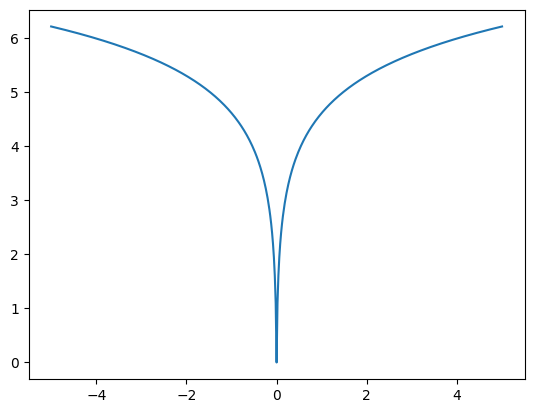

In [9]:
_ = tf.linspace(-5., 5., 501)
plt.plot(_, tfc.PowerLawEntropyModel(0).penalty(_));


The penalty is effectively a regularization loss (sometimes called "weight loss"). The fact that it is concave with a cusp at zero encourages weight sparsity. The coding scheme applied for compressing the weights, an [Elias gamma code](https://en.wikipedia.org/wiki/Elias_gamma_coding), produces codes of length $ 1 + \lfloor \log_2 |x| \rfloor $ bits for the magnitude of the element. That is, it is matched to the penalty, and applying the penalty thus minimizes the expected code length.

In [10]:
class PowerLawRegularizer(tf.keras.regularizers.Regularizer):

  def __init__(self, lmbda):
    super().__init__()
    self.lmbda = lmbda

  def __call__(self, variable):
    em = tfc.PowerLawEntropyModel(coding_rank=variable.shape.rank)
    return self.lmbda * em.penalty(variable)

# Normalizing the weight of the penalty by the number of model parameters is a
# good rule of thumb to produce comparable results across models.
regularizer = PowerLawRegularizer(lmbda=2./classifier.count_params())


Second, define subclasses of `CustomDense` and `CustomConv2D` which have the following additional functionality:

- They take an instance of the above regularizer and apply it to the kernels and biases during training.
- They define kernel and bias as a `@property`, which perform quantization with straight-through gradients whenever the variables are accessed. This accurately reflects the computation that is carried out later in the compressed model.
- They define additional `log_step` variables, which represent the logarithm of the quantization step size. The coarser the quantization, the smaller the model size, but the lower the accuracy. The quantization step sizes are trainable for each model parameter, so that performing optimization on the penalized loss function will determine what quantization step size is best.

The quantization step is defined as follows:

In [11]:
def quantize(latent, log_step):
  step = tf.exp(log_step)
  return tfc.round_st(latent / step) * step


With that, we can define the dense layer:

In [12]:
class CompressibleDense(CustomDense):

  def __init__(self, regularizer, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.regularizer = regularizer

  def build(self, input_shape, other=None):
    """Instantiates weights, optionally initializing them from `other`."""
    super().build(input_shape, other=other)
    if other is not None and hasattr(other, "kernel_log_step"):
      kernel_log_step = other.kernel_log_step
      bias_log_step = other.bias_log_step
    else:
      kernel_log_step = bias_log_step = -4.
    self.kernel_log_step = tf.Variable(
        tf.cast(kernel_log_step, self.variable_dtype), name="kernel_log_step")
    self.bias_log_step = tf.Variable(
        tf.cast(bias_log_step, self.variable_dtype), name="bias_log_step")
    self.add_loss(lambda: self.regularizer(
        self.kernel_latent / tf.exp(self.kernel_log_step)))
    self.add_loss(lambda: self.regularizer(
        self.bias_latent / tf.exp(self.bias_log_step)))

  @property
  def kernel(self):
    return quantize(self.kernel_latent, self.kernel_log_step)

  @kernel.setter
  def kernel(self, kernel):
    self.kernel_latent = tf.Variable(kernel, name="kernel_latent")

  @property
  def bias(self):
    return quantize(self.bias_latent, self.bias_log_step)

  @bias.setter
  def bias(self, bias):
    self.bias_latent = tf.Variable(bias, name="bias_latent")


The convolutional layer is analogous. In addition, the convolution kernel is stored as its real-valued discrete Fourier transform (RDFT) whenever the kernel is set, and the transform is inverted whenever the kernel is used. Since the different frequency components of the kernel tend to be more or less compressible, each of them gets its own quantization step size assigned.

Define the Fourier transform and its inverse as follows:

In [13]:
def to_rdft(kernel, kernel_size):
  # The kernel has shape (H, W, I, O) -> transpose to take DFT over last two
  # dimensions.
  kernel = tf.transpose(kernel, (2, 3, 0, 1))
  # The RDFT has type complex64 and shape (I, O, FH, FW).
  kernel_rdft = tf.signal.rfft2d(kernel)
  # Map real and imaginary parts into regular floats. The result is float32
  # and has shape (I, O, FH, FW, 2).
  kernel_rdft = tf.stack(
      [tf.math.real(kernel_rdft), tf.math.imag(kernel_rdft)], axis=-1)
  # Divide by kernel size to make the DFT orthonormal (length-preserving).
  return kernel_rdft / kernel_size

def from_rdft(kernel_rdft, kernel_size):
  # Undoes the transformations in to_rdft.
  kernel_rdft *= kernel_size
  kernel_rdft = tf.dtypes.complex(*tf.unstack(kernel_rdft, axis=-1))
  kernel = tf.signal.irfft2d(kernel_rdft, fft_length=2 * (kernel_size,))
  return tf.transpose(kernel, (2, 3, 0, 1))


With that, define the convolutional layer as:

In [14]:
class CompressibleConv2D(CustomConv2D):

  def __init__(self, regularizer, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.regularizer = regularizer

  def build(self, input_shape, other=None):
    """Instantiates weights, optionally initializing them from `other`."""
    super().build(input_shape, other=other)
    if other is not None and hasattr(other, "kernel_log_step"):
      kernel_log_step = other.kernel_log_step
      bias_log_step = other.bias_log_step
    else:
      kernel_log_step = tf.fill(self.kernel_latent.shape[2:], -4.)
      bias_log_step = -4.
    self.kernel_log_step = tf.Variable(
        tf.cast(kernel_log_step, self.variable_dtype), name="kernel_log_step")
    self.bias_log_step = tf.Variable(
        tf.cast(bias_log_step, self.variable_dtype), name="bias_log_step")
    self.add_loss(lambda: self.regularizer(
        self.kernel_latent / tf.exp(self.kernel_log_step)))
    self.add_loss(lambda: self.regularizer(
        self.bias_latent / tf.exp(self.bias_log_step)))

  @property
  def kernel(self):
    kernel_rdft = quantize(self.kernel_latent, self.kernel_log_step)
    return from_rdft(kernel_rdft, self.kernel_size)

  @kernel.setter
  def kernel(self, kernel):
    kernel_rdft = to_rdft(kernel, self.kernel_size)
    self.kernel_latent = tf.Variable(kernel_rdft, name="kernel_latent")

  @property
  def bias(self):
    return quantize(self.bias_latent, self.bias_log_step)

  @bias.setter
  def bias(self, bias):
    self.bias_latent = tf.Variable(bias, name="bias_latent")


Define a classifier model with the same architecture as above, but using these modified layers:

In [15]:
def make_mnist_classifier(regularizer):
  return tf.keras.Sequential([
      CompressibleConv2D(regularizer, 20, 5, strides=2, name="conv_1"),
      CompressibleConv2D(regularizer, 50, 5, strides=2, name="conv_2"),
      tf.keras.layers.Flatten(),
      CompressibleDense(regularizer, 500, name="fc_1"),
      CompressibleDense(regularizer, 10, name="fc_2"),
  ], name="classifier")

compressible_classifier = make_mnist_classifier(regularizer)


And train the model:

In [16]:
penalized_accuracy = train_model(
    compressible_classifier, training_dataset, validation_dataset)

print(f"Accuracy: {penalized_accuracy:0.4f}")


Epoch 1/5


  1/469 [..............................] - ETA: 19:08 - loss: 11.3925 - sparse_categorical_accuracy: 0.0547

  2/469 [..............................] - ETA: 50s - loss: 11.2882 - sparse_categorical_accuracy: 0.1680  

  3/469 [..............................] - ETA: 51s - loss: 11.1782 - sparse_categorical_accuracy: 0.2500

  4/469 [..............................] - ETA: 50s - loss: 11.0685 - sparse_categorical_accuracy: 0.2930

  5/469 [..............................] - ETA: 50s - loss: 10.9599 - sparse_categorical_accuracy: 0.3375

  6/469 [..............................] - ETA: 50s - loss: 10.8517 - sparse_categorical_accuracy: 0.3711

  7/469 [..............................] - ETA: 50s - loss: 10.7330 - sparse_categorical_accuracy: 0.4007

  8/469 [..............................] - ETA: 50s - loss: 10.6116 - sparse_categorical_accuracy: 0.4248

  9/469 [..............................] - ETA: 49s - loss: 10.4777 - sparse_categorical_accuracy: 0.4540

 10/469 [..............................] - ETA: 49s - loss: 10.3494 - sparse_categorical_accuracy: 0.4766

 11/469 [..............................] - ETA: 49s - loss: 10.2087 - sparse_categorical_accuracy: 0.5050

 12/469 [..............................] - ETA: 49s - loss: 10.0716 - sparse_categorical_accuracy: 0.5260

 13/469 [..............................] - ETA: 49s - loss: 9.9500 - sparse_categorical_accuracy: 0.5403 

 14/469 [..............................] - ETA: 49s - loss: 9.8309 - sparse_categorical_accuracy: 0.5564

 15/469 [..............................] - ETA: 49s - loss: 9.7161 - sparse_categorical_accuracy: 0.5698

 16/469 [>.............................] - ETA: 49s - loss: 9.6085 - sparse_categorical_accuracy: 0.5825

 17/469 [>.............................] - ETA: 49s - loss: 9.4953 - sparse_categorical_accuracy: 0.5983

 18/469 [>.............................] - ETA: 48s - loss: 9.3921 - sparse_categorical_accuracy: 0.6128

 19/469 [>.............................] - ETA: 48s - loss: 9.3036 - sparse_categorical_accuracy: 0.6234

 20/469 [>.............................] - ETA: 48s - loss: 9.2160 - sparse_categorical_accuracy: 0.6313

 21/469 [>.............................] - ETA: 48s - loss: 9.1339 - sparse_categorical_accuracy: 0.6399

 22/469 [>.............................] - ETA: 48s - loss: 9.0542 - sparse_categorical_accuracy: 0.6477

 23/469 [>.............................] - ETA: 48s - loss: 8.9720 - sparse_categorical_accuracy: 0.6562

 24/469 [>.............................] - ETA: 48s - loss: 8.9032 - sparse_categorical_accuracy: 0.6631

 25/469 [>.............................] - ETA: 48s - loss: 8.8377 - sparse_categorical_accuracy: 0.6687

 26/469 [>.............................] - ETA: 47s - loss: 8.7702 - sparse_categorical_accuracy: 0.6749

 27/469 [>.............................] - ETA: 47s - loss: 8.7096 - sparse_categorical_accuracy: 0.6803

 28/469 [>.............................] - ETA: 47s - loss: 8.6440 - sparse_categorical_accuracy: 0.6861

 29/469 [>.............................] - ETA: 47s - loss: 8.5818 - sparse_categorical_accuracy: 0.6921

 30/469 [>.............................] - ETA: 47s - loss: 8.5164 - sparse_categorical_accuracy: 0.6982

 31/469 [>.............................] - ETA: 47s - loss: 8.4571 - sparse_categorical_accuracy: 0.7029

 32/469 [=>............................] - ETA: 47s - loss: 8.4000 - sparse_categorical_accuracy: 0.7083

 33/469 [=>............................] - ETA: 47s - loss: 8.3417 - sparse_categorical_accuracy: 0.7135

 34/469 [=>............................] - ETA: 46s - loss: 8.2834 - sparse_categorical_accuracy: 0.7192

 35/469 [=>............................] - ETA: 46s - loss: 8.2276 - sparse_categorical_accuracy: 0.7254

 36/469 [=>............................] - ETA: 46s - loss: 8.1743 - sparse_categorical_accuracy: 0.7303

 37/469 [=>............................] - ETA: 46s - loss: 8.1249 - sparse_categorical_accuracy: 0.7340

 38/469 [=>............................] - ETA: 46s - loss: 8.0803 - sparse_categorical_accuracy: 0.7356

 39/469 [=>............................] - ETA: 46s - loss: 8.0344 - sparse_categorical_accuracy: 0.7388

 40/469 [=>............................] - ETA: 46s - loss: 7.9939 - sparse_categorical_accuracy: 0.7410

 41/469 [=>............................] - ETA: 46s - loss: 7.9483 - sparse_categorical_accuracy: 0.7445

 42/469 [=>............................] - ETA: 45s - loss: 7.9013 - sparse_categorical_accuracy: 0.7489

 43/469 [=>............................] - ETA: 45s - loss: 7.8585 - sparse_categorical_accuracy: 0.7527

 44/469 [=>............................] - ETA: 45s - loss: 7.8188 - sparse_categorical_accuracy: 0.7557

 45/469 [=>............................] - ETA: 45s - loss: 7.7739 - sparse_categorical_accuracy: 0.7594

 46/469 [=>............................] - ETA: 45s - loss: 7.7334 - sparse_categorical_accuracy: 0.7627

 47/469 [==>...........................] - ETA: 45s - loss: 7.6943 - sparse_categorical_accuracy: 0.7655

 48/469 [==>...........................] - ETA: 45s - loss: 7.6562 - sparse_categorical_accuracy: 0.7679

 49/469 [==>...........................] - ETA: 45s - loss: 7.6203 - sparse_categorical_accuracy: 0.7707

 50/469 [==>...........................] - ETA: 45s - loss: 7.5837 - sparse_categorical_accuracy: 0.7730

 51/469 [==>...........................] - ETA: 44s - loss: 7.5487 - sparse_categorical_accuracy: 0.7748

 52/469 [==>...........................] - ETA: 44s - loss: 7.5162 - sparse_categorical_accuracy: 0.7766

 53/469 [==>...........................] - ETA: 44s - loss: 7.4798 - sparse_categorical_accuracy: 0.7798

 54/469 [==>...........................] - ETA: 44s - loss: 7.4468 - sparse_categorical_accuracy: 0.7815

 55/469 [==>...........................] - ETA: 44s - loss: 7.4130 - sparse_categorical_accuracy: 0.7841

 56/469 [==>...........................] - ETA: 44s - loss: 7.3790 - sparse_categorical_accuracy: 0.7863

 57/469 [==>...........................] - ETA: 44s - loss: 7.3483 - sparse_categorical_accuracy: 0.7882

 58/469 [==>...........................] - ETA: 44s - loss: 7.3184 - sparse_categorical_accuracy: 0.7896

 59/469 [==>...........................] - ETA: 44s - loss: 7.2866 - sparse_categorical_accuracy: 0.7922

 60/469 [==>...........................] - ETA: 44s - loss: 7.2557 - sparse_categorical_accuracy: 0.7937

 61/469 [==>...........................] - ETA: 43s - loss: 7.2295 - sparse_categorical_accuracy: 0.7946

 62/469 [==>...........................] - ETA: 43s - loss: 7.2006 - sparse_categorical_accuracy: 0.7965

 63/469 [===>..........................] - ETA: 43s - loss: 7.1731 - sparse_categorical_accuracy: 0.7981

 64/469 [===>..........................] - ETA: 43s - loss: 7.1447 - sparse_categorical_accuracy: 0.7996

 65/469 [===>..........................] - ETA: 43s - loss: 7.1161 - sparse_categorical_accuracy: 0.8016

 66/469 [===>..........................] - ETA: 43s - loss: 7.0883 - sparse_categorical_accuracy: 0.8035

 67/469 [===>..........................] - ETA: 43s - loss: 7.0604 - sparse_categorical_accuracy: 0.8056

 68/469 [===>..........................] - ETA: 43s - loss: 7.0348 - sparse_categorical_accuracy: 0.8066

 69/469 [===>..........................] - ETA: 43s - loss: 7.0094 - sparse_categorical_accuracy: 0.8082

 70/469 [===>..........................] - ETA: 42s - loss: 6.9847 - sparse_categorical_accuracy: 0.8096

 71/469 [===>..........................] - ETA: 42s - loss: 6.9602 - sparse_categorical_accuracy: 0.8112

 72/469 [===>..........................] - ETA: 42s - loss: 6.9368 - sparse_categorical_accuracy: 0.8124

 73/469 [===>..........................] - ETA: 42s - loss: 6.9117 - sparse_categorical_accuracy: 0.8140

 74/469 [===>..........................] - ETA: 42s - loss: 6.8882 - sparse_categorical_accuracy: 0.8147

 75/469 [===>..........................] - ETA: 42s - loss: 6.8646 - sparse_categorical_accuracy: 0.8159

 76/469 [===>..........................] - ETA: 42s - loss: 6.8412 - sparse_categorical_accuracy: 0.8174

 77/469 [===>..........................] - ETA: 42s - loss: 6.8192 - sparse_categorical_accuracy: 0.8186

 78/469 [===>..........................] - ETA: 42s - loss: 6.7955 - sparse_categorical_accuracy: 0.8201

 79/469 [====>.........................] - ETA: 42s - loss: 6.7730 - sparse_categorical_accuracy: 0.8213

 80/469 [====>.........................] - ETA: 41s - loss: 6.7519 - sparse_categorical_accuracy: 0.8225

 81/469 [====>.........................] - ETA: 41s - loss: 6.7297 - sparse_categorical_accuracy: 0.8237

 82/469 [====>.........................] - ETA: 41s - loss: 6.7090 - sparse_categorical_accuracy: 0.8245

 83/469 [====>.........................] - ETA: 41s - loss: 6.6894 - sparse_categorical_accuracy: 0.8255

 84/469 [====>.........................] - ETA: 41s - loss: 6.6678 - sparse_categorical_accuracy: 0.8269

 85/469 [====>.........................] - ETA: 41s - loss: 6.6478 - sparse_categorical_accuracy: 0.8279

 86/469 [====>.........................] - ETA: 41s - loss: 6.6287 - sparse_categorical_accuracy: 0.8291

 87/469 [====>.........................] - ETA: 41s - loss: 6.6086 - sparse_categorical_accuracy: 0.8301

 88/469 [====>.........................] - ETA: 41s - loss: 6.5883 - sparse_categorical_accuracy: 0.8311

 89/469 [====>.........................] - ETA: 41s - loss: 6.5697 - sparse_categorical_accuracy: 0.8318

 90/469 [====>.........................] - ETA: 40s - loss: 6.5498 - sparse_categorical_accuracy: 0.8332

 91/469 [====>.........................] - ETA: 40s - loss: 6.5312 - sparse_categorical_accuracy: 0.8340

 92/469 [====>.........................] - ETA: 40s - loss: 6.5131 - sparse_categorical_accuracy: 0.8348

 93/469 [====>.........................] - ETA: 40s - loss: 6.4952 - sparse_categorical_accuracy: 0.8358

 94/469 [=====>........................] - ETA: 40s - loss: 6.4766 - sparse_categorical_accuracy: 0.8368

 95/469 [=====>........................] - ETA: 40s - loss: 6.4596 - sparse_categorical_accuracy: 0.8375

 96/469 [=====>........................] - ETA: 40s - loss: 6.4421 - sparse_categorical_accuracy: 0.8381

 97/469 [=====>........................] - ETA: 40s - loss: 6.4248 - sparse_categorical_accuracy: 0.8388

 98/469 [=====>........................] - ETA: 40s - loss: 6.4060 - sparse_categorical_accuracy: 0.8402

 99/469 [=====>........................] - ETA: 39s - loss: 6.3881 - sparse_categorical_accuracy: 0.8414

100/469 [=====>........................] - ETA: 39s - loss: 6.3709 - sparse_categorical_accuracy: 0.8424

101/469 [=====>........................] - ETA: 39s - loss: 6.3535 - sparse_categorical_accuracy: 0.8434

102/469 [=====>........................] - ETA: 39s - loss: 6.3371 - sparse_categorical_accuracy: 0.8440

103/469 [=====>........................] - ETA: 39s - loss: 6.3205 - sparse_categorical_accuracy: 0.8447

104/469 [=====>........................] - ETA: 39s - loss: 6.3044 - sparse_categorical_accuracy: 0.8455

105/469 [=====>........................] - ETA: 39s - loss: 6.2876 - sparse_categorical_accuracy: 0.8465

106/469 [=====>........................] - ETA: 39s - loss: 6.2720 - sparse_categorical_accuracy: 0.8473

107/469 [=====>........................] - ETA: 39s - loss: 6.2565 - sparse_categorical_accuracy: 0.8479

108/469 [=====>........................] - ETA: 38s - loss: 6.2410 - sparse_categorical_accuracy: 0.8485

109/469 [=====>........................] - ETA: 38s - loss: 6.2257 - sparse_categorical_accuracy: 0.8491

110/469 [======>.......................] - ETA: 38s - loss: 6.2113 - sparse_categorical_accuracy: 0.8497

111/469 [======>.......................] - ETA: 38s - loss: 6.1965 - sparse_categorical_accuracy: 0.8499

112/469 [======>.......................] - ETA: 38s - loss: 6.1810 - sparse_categorical_accuracy: 0.8510

113/469 [======>.......................] - ETA: 38s - loss: 6.1662 - sparse_categorical_accuracy: 0.8518

114/469 [======>.......................] - ETA: 38s - loss: 6.1516 - sparse_categorical_accuracy: 0.8522

115/469 [======>.......................] - ETA: 38s - loss: 6.1379 - sparse_categorical_accuracy: 0.8526

116/469 [======>.......................] - ETA: 38s - loss: 6.1225 - sparse_categorical_accuracy: 0.8537

117/469 [======>.......................] - ETA: 37s - loss: 6.1079 - sparse_categorical_accuracy: 0.8543

118/469 [======>.......................] - ETA: 37s - loss: 6.0936 - sparse_categorical_accuracy: 0.8549

119/469 [======>.......................] - ETA: 37s - loss: 6.0797 - sparse_categorical_accuracy: 0.8555

120/469 [======>.......................] - ETA: 37s - loss: 6.0660 - sparse_categorical_accuracy: 0.8561

121/469 [======>.......................] - ETA: 37s - loss: 6.0518 - sparse_categorical_accuracy: 0.8569

122/469 [======>.......................] - ETA: 37s - loss: 6.0382 - sparse_categorical_accuracy: 0.8575

123/469 [======>.......................] - ETA: 37s - loss: 6.0243 - sparse_categorical_accuracy: 0.8582

124/469 [======>.......................] - ETA: 37s - loss: 6.0113 - sparse_categorical_accuracy: 0.8587

125/469 [======>.......................] - ETA: 37s - loss: 5.9970 - sparse_categorical_accuracy: 0.8597

126/469 [=======>......................] - ETA: 37s - loss: 5.9840 - sparse_categorical_accuracy: 0.8601

127/469 [=======>......................] - ETA: 36s - loss: 5.9706 - sparse_categorical_accuracy: 0.8606

128/469 [=======>......................] - ETA: 36s - loss: 5.9572 - sparse_categorical_accuracy: 0.8615

129/469 [=======>......................] - ETA: 36s - loss: 5.9457 - sparse_categorical_accuracy: 0.8616

130/469 [=======>......................] - ETA: 36s - loss: 5.9322 - sparse_categorical_accuracy: 0.8624

131/469 [=======>......................] - ETA: 36s - loss: 5.9186 - sparse_categorical_accuracy: 0.8633

132/469 [=======>......................] - ETA: 36s - loss: 5.9058 - sparse_categorical_accuracy: 0.8638

133/469 [=======>......................] - ETA: 36s - loss: 5.8939 - sparse_categorical_accuracy: 0.8643

134/469 [=======>......................] - ETA: 36s - loss: 5.8818 - sparse_categorical_accuracy: 0.8646

135/469 [=======>......................] - ETA: 36s - loss: 5.8694 - sparse_categorical_accuracy: 0.8650

136/469 [=======>......................] - ETA: 35s - loss: 5.8572 - sparse_categorical_accuracy: 0.8658

137/469 [=======>......................] - ETA: 35s - loss: 5.8449 - sparse_categorical_accuracy: 0.8662

138/469 [=======>......................] - ETA: 35s - loss: 5.8331 - sparse_categorical_accuracy: 0.8666

139/469 [=======>......................] - ETA: 35s - loss: 5.8215 - sparse_categorical_accuracy: 0.8670

140/469 [=======>......................] - ETA: 35s - loss: 5.8089 - sparse_categorical_accuracy: 0.8677

141/469 [========>.....................] - ETA: 35s - loss: 5.7970 - sparse_categorical_accuracy: 0.8679

142/469 [========>.....................] - ETA: 35s - loss: 5.7853 - sparse_categorical_accuracy: 0.8683

143/469 [========>.....................] - ETA: 35s - loss: 5.7733 - sparse_categorical_accuracy: 0.8688

144/469 [========>.....................] - ETA: 35s - loss: 5.7623 - sparse_categorical_accuracy: 0.8690

145/469 [========>.....................] - ETA: 35s - loss: 5.7511 - sparse_categorical_accuracy: 0.8692

146/469 [========>.....................] - ETA: 34s - loss: 5.7390 - sparse_categorical_accuracy: 0.8700

147/469 [========>.....................] - ETA: 34s - loss: 5.7267 - sparse_categorical_accuracy: 0.8708

148/469 [========>.....................] - ETA: 34s - loss: 5.7160 - sparse_categorical_accuracy: 0.8710

149/469 [========>.....................] - ETA: 34s - loss: 5.7041 - sparse_categorical_accuracy: 0.8715

150/469 [========>.....................] - ETA: 34s - loss: 5.6926 - sparse_categorical_accuracy: 0.8720

151/469 [========>.....................] - ETA: 34s - loss: 5.6813 - sparse_categorical_accuracy: 0.8725

152/469 [========>.....................] - ETA: 34s - loss: 5.6702 - sparse_categorical_accuracy: 0.8729

153/469 [========>.....................] - ETA: 34s - loss: 5.6592 - sparse_categorical_accuracy: 0.8735

154/469 [========>.....................] - ETA: 34s - loss: 5.6484 - sparse_categorical_accuracy: 0.8736

155/469 [========>.....................] - ETA: 33s - loss: 5.6371 - sparse_categorical_accuracy: 0.8742

156/469 [========>.....................] - ETA: 33s - loss: 5.6258 - sparse_categorical_accuracy: 0.8748

157/469 [=========>....................] - ETA: 33s - loss: 5.6147 - sparse_categorical_accuracy: 0.8754

158/469 [=========>....................] - ETA: 33s - loss: 5.6040 - sparse_categorical_accuracy: 0.8759

159/469 [=========>....................] - ETA: 33s - loss: 5.5932 - sparse_categorical_accuracy: 0.8764

160/469 [=========>....................] - ETA: 33s - loss: 5.5822 - sparse_categorical_accuracy: 0.8770

161/469 [=========>....................] - ETA: 33s - loss: 5.5717 - sparse_categorical_accuracy: 0.8773

162/469 [=========>....................] - ETA: 33s - loss: 5.5615 - sparse_categorical_accuracy: 0.8777

163/469 [=========>....................] - ETA: 33s - loss: 5.5516 - sparse_categorical_accuracy: 0.8779

164/469 [=========>....................] - ETA: 33s - loss: 5.5411 - sparse_categorical_accuracy: 0.8784

165/469 [=========>....................] - ETA: 32s - loss: 5.5316 - sparse_categorical_accuracy: 0.8786

166/469 [=========>....................] - ETA: 32s - loss: 5.5218 - sparse_categorical_accuracy: 0.8789

167/469 [=========>....................] - ETA: 32s - loss: 5.5114 - sparse_categorical_accuracy: 0.8794

168/469 [=========>....................] - ETA: 32s - loss: 5.5013 - sparse_categorical_accuracy: 0.8799

169/469 [=========>....................] - ETA: 32s - loss: 5.4911 - sparse_categorical_accuracy: 0.8804

170/469 [=========>....................] - ETA: 32s - loss: 5.4811 - sparse_categorical_accuracy: 0.8809

171/469 [=========>....................] - ETA: 32s - loss: 5.4712 - sparse_categorical_accuracy: 0.8813

172/469 [==========>...................] - ETA: 32s - loss: 5.4610 - sparse_categorical_accuracy: 0.8818

173/469 [==========>...................] - ETA: 32s - loss: 5.4513 - sparse_categorical_accuracy: 0.8823

174/469 [==========>...................] - ETA: 31s - loss: 5.4424 - sparse_categorical_accuracy: 0.8825

175/469 [==========>...................] - ETA: 31s - loss: 5.4329 - sparse_categorical_accuracy: 0.8828

176/469 [==========>...................] - ETA: 31s - loss: 5.4231 - sparse_categorical_accuracy: 0.8833

177/469 [==========>...................] - ETA: 31s - loss: 5.4135 - sparse_categorical_accuracy: 0.8836

178/469 [==========>...................] - ETA: 31s - loss: 5.4046 - sparse_categorical_accuracy: 0.8838

179/469 [==========>...................] - ETA: 31s - loss: 5.3955 - sparse_categorical_accuracy: 0.8841

180/469 [==========>...................] - ETA: 31s - loss: 5.3865 - sparse_categorical_accuracy: 0.8844

181/469 [==========>...................] - ETA: 31s - loss: 5.3778 - sparse_categorical_accuracy: 0.8846

182/469 [==========>...................] - ETA: 31s - loss: 5.3684 - sparse_categorical_accuracy: 0.8850

183/469 [==========>...................] - ETA: 30s - loss: 5.3592 - sparse_categorical_accuracy: 0.8853

184/469 [==========>...................] - ETA: 30s - loss: 5.3500 - sparse_categorical_accuracy: 0.8857

185/469 [==========>...................] - ETA: 30s - loss: 5.3411 - sparse_categorical_accuracy: 0.8860

186/469 [==========>...................] - ETA: 30s - loss: 5.3321 - sparse_categorical_accuracy: 0.8863

187/469 [==========>...................] - ETA: 30s - loss: 5.3234 - sparse_categorical_accuracy: 0.8864

188/469 [===========>..................] - ETA: 30s - loss: 5.3148 - sparse_categorical_accuracy: 0.8868

189/469 [===========>..................] - ETA: 30s - loss: 5.3058 - sparse_categorical_accuracy: 0.8872

190/469 [===========>..................] - ETA: 30s - loss: 5.2970 - sparse_categorical_accuracy: 0.8875

191/469 [===========>..................] - ETA: 30s - loss: 5.2885 - sparse_categorical_accuracy: 0.8877

192/469 [===========>..................] - ETA: 29s - loss: 5.2799 - sparse_categorical_accuracy: 0.8880

193/469 [===========>..................] - ETA: 29s - loss: 5.2711 - sparse_categorical_accuracy: 0.8883

194/469 [===========>..................] - ETA: 29s - loss: 5.2628 - sparse_categorical_accuracy: 0.8885

195/469 [===========>..................] - ETA: 29s - loss: 5.2545 - sparse_categorical_accuracy: 0.8888

196/469 [===========>..................] - ETA: 29s - loss: 5.2457 - sparse_categorical_accuracy: 0.8892

197/469 [===========>..................] - ETA: 29s - loss: 5.2372 - sparse_categorical_accuracy: 0.8895

198/469 [===========>..................] - ETA: 29s - loss: 5.2286 - sparse_categorical_accuracy: 0.8899

199/469 [===========>..................] - ETA: 29s - loss: 5.2206 - sparse_categorical_accuracy: 0.8900

200/469 [===========>..................] - ETA: 29s - loss: 5.2121 - sparse_categorical_accuracy: 0.8903

201/469 [===========>..................] - ETA: 29s - loss: 5.2039 - sparse_categorical_accuracy: 0.8905

202/469 [===========>..................] - ETA: 28s - loss: 5.1957 - sparse_categorical_accuracy: 0.8907

203/469 [===========>..................] - ETA: 28s - loss: 5.1874 - sparse_categorical_accuracy: 0.8911

204/469 [============>.................] - ETA: 28s - loss: 5.1791 - sparse_categorical_accuracy: 0.8914

205/469 [============>.................] - ETA: 28s - loss: 5.1708 - sparse_categorical_accuracy: 0.8917

206/469 [============>.................] - ETA: 28s - loss: 5.1623 - sparse_categorical_accuracy: 0.8921

207/469 [============>.................] - ETA: 28s - loss: 5.1547 - sparse_categorical_accuracy: 0.8924

208/469 [============>.................] - ETA: 28s - loss: 5.1467 - sparse_categorical_accuracy: 0.8927

209/469 [============>.................] - ETA: 28s - loss: 5.1385 - sparse_categorical_accuracy: 0.8931

210/469 [============>.................] - ETA: 28s - loss: 5.1307 - sparse_categorical_accuracy: 0.8933

211/469 [============>.................] - ETA: 27s - loss: 5.1231 - sparse_categorical_accuracy: 0.8934

212/469 [============>.................] - ETA: 27s - loss: 5.1152 - sparse_categorical_accuracy: 0.8937

213/469 [============>.................] - ETA: 27s - loss: 5.1076 - sparse_categorical_accuracy: 0.8939

214/469 [============>.................] - ETA: 27s - loss: 5.1002 - sparse_categorical_accuracy: 0.8941

215/469 [============>.................] - ETA: 27s - loss: 5.0925 - sparse_categorical_accuracy: 0.8944

216/469 [============>.................] - ETA: 27s - loss: 5.0853 - sparse_categorical_accuracy: 0.8946

217/469 [============>.................] - ETA: 27s - loss: 5.0778 - sparse_categorical_accuracy: 0.8949

218/469 [============>.................] - ETA: 27s - loss: 5.0701 - sparse_categorical_accuracy: 0.8952

219/469 [=============>................] - ETA: 27s - loss: 5.0625 - sparse_categorical_accuracy: 0.8956

220/469 [=============>................] - ETA: 26s - loss: 5.0548 - sparse_categorical_accuracy: 0.8960

221/469 [=============>................] - ETA: 26s - loss: 5.0476 - sparse_categorical_accuracy: 0.8961

222/469 [=============>................] - ETA: 26s - loss: 5.0399 - sparse_categorical_accuracy: 0.8964

223/469 [=============>................] - ETA: 26s - loss: 5.0329 - sparse_categorical_accuracy: 0.8965

224/469 [=============>................] - ETA: 26s - loss: 5.0253 - sparse_categorical_accuracy: 0.8968

225/469 [=============>................] - ETA: 26s - loss: 5.0178 - sparse_categorical_accuracy: 0.8970

226/469 [=============>................] - ETA: 26s - loss: 5.0106 - sparse_categorical_accuracy: 0.8972

227/469 [=============>................] - ETA: 26s - loss: 5.0034 - sparse_categorical_accuracy: 0.8975

228/469 [=============>................] - ETA: 26s - loss: 4.9966 - sparse_categorical_accuracy: 0.8974

229/469 [=============>................] - ETA: 25s - loss: 4.9894 - sparse_categorical_accuracy: 0.8977

230/469 [=============>................] - ETA: 25s - loss: 4.9823 - sparse_categorical_accuracy: 0.8980

231/469 [=============>................] - ETA: 25s - loss: 4.9749 - sparse_categorical_accuracy: 0.8983

232/469 [=============>................] - ETA: 25s - loss: 4.9676 - sparse_categorical_accuracy: 0.8985

233/469 [=============>................] - ETA: 25s - loss: 4.9605 - sparse_categorical_accuracy: 0.8987

234/469 [=============>................] - ETA: 25s - loss: 4.9536 - sparse_categorical_accuracy: 0.8989

235/469 [==============>...............] - ETA: 25s - loss: 4.9474 - sparse_categorical_accuracy: 0.8989

236/469 [==============>...............] - ETA: 25s - loss: 4.9408 - sparse_categorical_accuracy: 0.8989

237/469 [==============>...............] - ETA: 25s - loss: 4.9341 - sparse_categorical_accuracy: 0.8990

238/469 [==============>...............] - ETA: 25s - loss: 4.9270 - sparse_categorical_accuracy: 0.8992

239/469 [==============>...............] - ETA: 24s - loss: 4.9201 - sparse_categorical_accuracy: 0.8994

240/469 [==============>...............] - ETA: 24s - loss: 4.9131 - sparse_categorical_accuracy: 0.8997

241/469 [==============>...............] - ETA: 24s - loss: 4.9066 - sparse_categorical_accuracy: 0.8998

242/469 [==============>...............] - ETA: 24s - loss: 4.8998 - sparse_categorical_accuracy: 0.9000

243/469 [==============>...............] - ETA: 24s - loss: 4.8935 - sparse_categorical_accuracy: 0.9001

244/469 [==============>...............] - ETA: 24s - loss: 4.8869 - sparse_categorical_accuracy: 0.9003

245/469 [==============>...............] - ETA: 24s - loss: 4.8807 - sparse_categorical_accuracy: 0.9004

246/469 [==============>...............] - ETA: 24s - loss: 4.8738 - sparse_categorical_accuracy: 0.9006

247/469 [==============>...............] - ETA: 24s - loss: 4.8670 - sparse_categorical_accuracy: 0.9008

248/469 [==============>...............] - ETA: 23s - loss: 4.8602 - sparse_categorical_accuracy: 0.9011

249/469 [==============>...............] - ETA: 23s - loss: 4.8536 - sparse_categorical_accuracy: 0.9013

250/469 [==============>...............] - ETA: 23s - loss: 4.8469 - sparse_categorical_accuracy: 0.9016

251/469 [===============>..............] - ETA: 23s - loss: 4.8401 - sparse_categorical_accuracy: 0.9018

252/469 [===============>..............] - ETA: 23s - loss: 4.8338 - sparse_categorical_accuracy: 0.9020

253/469 [===============>..............] - ETA: 23s - loss: 4.8270 - sparse_categorical_accuracy: 0.9022

254/469 [===============>..............] - ETA: 23s - loss: 4.8203 - sparse_categorical_accuracy: 0.9025

255/469 [===============>..............] - ETA: 23s - loss: 4.8137 - sparse_categorical_accuracy: 0.9027

256/469 [===============>..............] - ETA: 23s - loss: 4.8069 - sparse_categorical_accuracy: 0.9031

257/469 [===============>..............] - ETA: 22s - loss: 4.8004 - sparse_categorical_accuracy: 0.9033

258/469 [===============>..............] - ETA: 22s - loss: 4.7940 - sparse_categorical_accuracy: 0.9035

259/469 [===============>..............] - ETA: 22s - loss: 4.7874 - sparse_categorical_accuracy: 0.9037

260/469 [===============>..............] - ETA: 22s - loss: 4.7810 - sparse_categorical_accuracy: 0.9038

261/469 [===============>..............] - ETA: 22s - loss: 4.7746 - sparse_categorical_accuracy: 0.9041

262/469 [===============>..............] - ETA: 22s - loss: 4.7689 - sparse_categorical_accuracy: 0.9042

263/469 [===============>..............] - ETA: 22s - loss: 4.7626 - sparse_categorical_accuracy: 0.9043

264/469 [===============>..............] - ETA: 22s - loss: 4.7563 - sparse_categorical_accuracy: 0.9046

265/469 [===============>..............] - ETA: 22s - loss: 4.7500 - sparse_categorical_accuracy: 0.9048

266/469 [================>.............] - ETA: 22s - loss: 4.7436 - sparse_categorical_accuracy: 0.9050

267/469 [================>.............] - ETA: 21s - loss: 4.7371 - sparse_categorical_accuracy: 0.9053

268/469 [================>.............] - ETA: 21s - loss: 4.7308 - sparse_categorical_accuracy: 0.9056

269/469 [================>.............] - ETA: 21s - loss: 4.7247 - sparse_categorical_accuracy: 0.9057

270/469 [================>.............] - ETA: 21s - loss: 4.7182 - sparse_categorical_accuracy: 0.9060

271/469 [================>.............] - ETA: 21s - loss: 4.7121 - sparse_categorical_accuracy: 0.9061

272/469 [================>.............] - ETA: 21s - loss: 4.7060 - sparse_categorical_accuracy: 0.9063

273/469 [================>.............] - ETA: 21s - loss: 4.6998 - sparse_categorical_accuracy: 0.9065

274/469 [================>.............] - ETA: 21s - loss: 4.6936 - sparse_categorical_accuracy: 0.9067

275/469 [================>.............] - ETA: 21s - loss: 4.6875 - sparse_categorical_accuracy: 0.9069

276/469 [================>.............] - ETA: 20s - loss: 4.6813 - sparse_categorical_accuracy: 0.9071

277/469 [================>.............] - ETA: 20s - loss: 4.6754 - sparse_categorical_accuracy: 0.9072

278/469 [================>.............] - ETA: 20s - loss: 4.6696 - sparse_categorical_accuracy: 0.9074

279/469 [================>.............] - ETA: 20s - loss: 4.6638 - sparse_categorical_accuracy: 0.9075

280/469 [================>.............] - ETA: 20s - loss: 4.6579 - sparse_categorical_accuracy: 0.9078

281/469 [================>.............] - ETA: 20s - loss: 4.6521 - sparse_categorical_accuracy: 0.9079

282/469 [=================>............] - ETA: 20s - loss: 4.6460 - sparse_categorical_accuracy: 0.9081

283/469 [=================>............] - ETA: 20s - loss: 4.6399 - sparse_categorical_accuracy: 0.9083

284/469 [=================>............] - ETA: 20s - loss: 4.6343 - sparse_categorical_accuracy: 0.9085

285/469 [=================>............] - ETA: 19s - loss: 4.6285 - sparse_categorical_accuracy: 0.9086

286/469 [=================>............] - ETA: 19s - loss: 4.6226 - sparse_categorical_accuracy: 0.9088

287/469 [=================>............] - ETA: 19s - loss: 4.6166 - sparse_categorical_accuracy: 0.9090

288/469 [=================>............] - ETA: 19s - loss: 4.6109 - sparse_categorical_accuracy: 0.9090

289/469 [=================>............] - ETA: 19s - loss: 4.6051 - sparse_categorical_accuracy: 0.9092

290/469 [=================>............] - ETA: 19s - loss: 4.5995 - sparse_categorical_accuracy: 0.9093

291/469 [=================>............] - ETA: 19s - loss: 4.5938 - sparse_categorical_accuracy: 0.9094

292/469 [=================>............] - ETA: 19s - loss: 4.5882 - sparse_categorical_accuracy: 0.9096

293/469 [=================>............] - ETA: 19s - loss: 4.5828 - sparse_categorical_accuracy: 0.9097

294/469 [=================>............] - ETA: 18s - loss: 4.5771 - sparse_categorical_accuracy: 0.9098

295/469 [=================>............] - ETA: 18s - loss: 4.5714 - sparse_categorical_accuracy: 0.9100

296/469 [=================>............] - ETA: 18s - loss: 4.5660 - sparse_categorical_accuracy: 0.9101

297/469 [=================>............] - ETA: 18s - loss: 4.5603 - sparse_categorical_accuracy: 0.9102

298/469 [==================>...........] - ETA: 18s - loss: 4.5547 - sparse_categorical_accuracy: 0.9104

299/469 [==================>...........] - ETA: 18s - loss: 4.5492 - sparse_categorical_accuracy: 0.9105

300/469 [==================>...........] - ETA: 18s - loss: 4.5435 - sparse_categorical_accuracy: 0.9107

301/469 [==================>...........] - ETA: 18s - loss: 4.5381 - sparse_categorical_accuracy: 0.9109

302/469 [==================>...........] - ETA: 18s - loss: 4.5324 - sparse_categorical_accuracy: 0.9111

303/469 [==================>...........] - ETA: 17s - loss: 4.5269 - sparse_categorical_accuracy: 0.9113

304/469 [==================>...........] - ETA: 17s - loss: 4.5215 - sparse_categorical_accuracy: 0.9114

305/469 [==================>...........] - ETA: 17s - loss: 4.5162 - sparse_categorical_accuracy: 0.9115

306/469 [==================>...........] - ETA: 17s - loss: 4.5106 - sparse_categorical_accuracy: 0.9118

307/469 [==================>...........] - ETA: 17s - loss: 4.5052 - sparse_categorical_accuracy: 0.9119

308/469 [==================>...........] - ETA: 17s - loss: 4.5002 - sparse_categorical_accuracy: 0.9120

309/469 [==================>...........] - ETA: 17s - loss: 4.4947 - sparse_categorical_accuracy: 0.9122

310/469 [==================>...........] - ETA: 17s - loss: 4.4892 - sparse_categorical_accuracy: 0.9124

311/469 [==================>...........] - ETA: 17s - loss: 4.4839 - sparse_categorical_accuracy: 0.9125

312/469 [==================>...........] - ETA: 17s - loss: 4.4785 - sparse_categorical_accuracy: 0.9127

313/469 [===================>..........] - ETA: 16s - loss: 4.4732 - sparse_categorical_accuracy: 0.9128

314/469 [===================>..........] - ETA: 16s - loss: 4.4680 - sparse_categorical_accuracy: 0.9128

315/469 [===================>..........] - ETA: 16s - loss: 4.4628 - sparse_categorical_accuracy: 0.9130

316/469 [===================>..........] - ETA: 16s - loss: 4.4577 - sparse_categorical_accuracy: 0.9130

317/469 [===================>..........] - ETA: 16s - loss: 4.4524 - sparse_categorical_accuracy: 0.9132

318/469 [===================>..........] - ETA: 16s - loss: 4.4471 - sparse_categorical_accuracy: 0.9135

319/469 [===================>..........] - ETA: 16s - loss: 4.4417 - sparse_categorical_accuracy: 0.9137

320/469 [===================>..........] - ETA: 16s - loss: 4.4364 - sparse_categorical_accuracy: 0.9139

321/469 [===================>..........] - ETA: 16s - loss: 4.4311 - sparse_categorical_accuracy: 0.9142

322/469 [===================>..........] - ETA: 15s - loss: 4.4264 - sparse_categorical_accuracy: 0.9142

323/469 [===================>..........] - ETA: 15s - loss: 4.4211 - sparse_categorical_accuracy: 0.9143

324/469 [===================>..........] - ETA: 15s - loss: 4.4163 - sparse_categorical_accuracy: 0.9144

325/469 [===================>..........] - ETA: 15s - loss: 4.4111 - sparse_categorical_accuracy: 0.9145

326/469 [===================>..........] - ETA: 15s - loss: 4.4061 - sparse_categorical_accuracy: 0.9146

327/469 [===================>..........] - ETA: 15s - loss: 4.4008 - sparse_categorical_accuracy: 0.9148

328/469 [===================>..........] - ETA: 15s - loss: 4.3955 - sparse_categorical_accuracy: 0.9150

329/469 [====================>.........] - ETA: 15s - loss: 4.3905 - sparse_categorical_accuracy: 0.9151

330/469 [====================>.........] - ETA: 15s - loss: 4.3854 - sparse_categorical_accuracy: 0.9153

331/469 [====================>.........] - ETA: 14s - loss: 4.3803 - sparse_categorical_accuracy: 0.9155

332/469 [====================>.........] - ETA: 14s - loss: 4.3752 - sparse_categorical_accuracy: 0.9157

333/469 [====================>.........] - ETA: 14s - loss: 4.3702 - sparse_categorical_accuracy: 0.9158

334/469 [====================>.........] - ETA: 14s - loss: 4.3654 - sparse_categorical_accuracy: 0.9159

335/469 [====================>.........] - ETA: 14s - loss: 4.3603 - sparse_categorical_accuracy: 0.9161

336/469 [====================>.........] - ETA: 14s - loss: 4.3553 - sparse_categorical_accuracy: 0.9163

337/469 [====================>.........] - ETA: 14s - loss: 4.3504 - sparse_categorical_accuracy: 0.9164

338/469 [====================>.........] - ETA: 14s - loss: 4.3455 - sparse_categorical_accuracy: 0.9165

339/469 [====================>.........] - ETA: 14s - loss: 4.3405 - sparse_categorical_accuracy: 0.9167

340/469 [====================>.........] - ETA: 13s - loss: 4.3354 - sparse_categorical_accuracy: 0.9169

341/469 [====================>.........] - ETA: 13s - loss: 4.3303 - sparse_categorical_accuracy: 0.9171

342/469 [====================>.........] - ETA: 13s - loss: 4.3254 - sparse_categorical_accuracy: 0.9172

343/469 [====================>.........] - ETA: 13s - loss: 4.3205 - sparse_categorical_accuracy: 0.9173

344/469 [=====================>........] - ETA: 13s - loss: 4.3154 - sparse_categorical_accuracy: 0.9175

345/469 [=====================>........] - ETA: 13s - loss: 4.3107 - sparse_categorical_accuracy: 0.9176

346/469 [=====================>........] - ETA: 13s - loss: 4.3061 - sparse_categorical_accuracy: 0.9177

347/469 [=====================>........] - ETA: 13s - loss: 4.3012 - sparse_categorical_accuracy: 0.9178

348/469 [=====================>........] - ETA: 13s - loss: 4.2962 - sparse_categorical_accuracy: 0.9180

349/469 [=====================>........] - ETA: 13s - loss: 4.2914 - sparse_categorical_accuracy: 0.9182

350/469 [=====================>........] - ETA: 12s - loss: 4.2866 - sparse_categorical_accuracy: 0.9183

351/469 [=====================>........] - ETA: 12s - loss: 4.2817 - sparse_categorical_accuracy: 0.9184

352/469 [=====================>........] - ETA: 12s - loss: 4.2771 - sparse_categorical_accuracy: 0.9186

353/469 [=====================>........] - ETA: 12s - loss: 4.2725 - sparse_categorical_accuracy: 0.9187

354/469 [=====================>........] - ETA: 12s - loss: 4.2681 - sparse_categorical_accuracy: 0.9188

355/469 [=====================>........] - ETA: 12s - loss: 4.2635 - sparse_categorical_accuracy: 0.9189

356/469 [=====================>........] - ETA: 12s - loss: 4.2588 - sparse_categorical_accuracy: 0.9190

357/469 [=====================>........] - ETA: 12s - loss: 4.2544 - sparse_categorical_accuracy: 0.9191

358/469 [=====================>........] - ETA: 12s - loss: 4.2498 - sparse_categorical_accuracy: 0.9192

359/469 [=====================>........] - ETA: 11s - loss: 4.2452 - sparse_categorical_accuracy: 0.9194

360/469 [======================>.......] - ETA: 11s - loss: 4.2405 - sparse_categorical_accuracy: 0.9195

361/469 [======================>.......] - ETA: 11s - loss: 4.2358 - sparse_categorical_accuracy: 0.9196

362/469 [======================>.......] - ETA: 11s - loss: 4.2315 - sparse_categorical_accuracy: 0.9197

363/469 [======================>.......] - ETA: 11s - loss: 4.2270 - sparse_categorical_accuracy: 0.9199

364/469 [======================>.......] - ETA: 11s - loss: 4.2225 - sparse_categorical_accuracy: 0.9199

365/469 [======================>.......] - ETA: 11s - loss: 4.2179 - sparse_categorical_accuracy: 0.9201

366/469 [======================>.......] - ETA: 11s - loss: 4.2134 - sparse_categorical_accuracy: 0.9202

367/469 [======================>.......] - ETA: 11s - loss: 4.2088 - sparse_categorical_accuracy: 0.9204

368/469 [======================>.......] - ETA: 10s - loss: 4.2042 - sparse_categorical_accuracy: 0.9205

369/469 [======================>.......] - ETA: 10s - loss: 4.1998 - sparse_categorical_accuracy: 0.9206

370/469 [======================>.......] - ETA: 10s - loss: 4.1956 - sparse_categorical_accuracy: 0.9207

371/469 [======================>.......] - ETA: 10s - loss: 4.1915 - sparse_categorical_accuracy: 0.9207

372/469 [======================>.......] - ETA: 10s - loss: 4.1869 - sparse_categorical_accuracy: 0.9209

373/469 [======================>.......] - ETA: 10s - loss: 4.1824 - sparse_categorical_accuracy: 0.9211

374/469 [======================>.......] - ETA: 10s - loss: 4.1782 - sparse_categorical_accuracy: 0.9211

375/469 [======================>.......] - ETA: 10s - loss: 4.1737 - sparse_categorical_accuracy: 0.9212

376/469 [=======================>......] - ETA: 10s - loss: 4.1694 - sparse_categorical_accuracy: 0.9214

377/469 [=======================>......] - ETA: 9s - loss: 4.1650 - sparse_categorical_accuracy: 0.9214 

378/469 [=======================>......] - ETA: 9s - loss: 4.1606 - sparse_categorical_accuracy: 0.9215

379/469 [=======================>......] - ETA: 9s - loss: 4.1562 - sparse_categorical_accuracy: 0.9216

380/469 [=======================>......] - ETA: 9s - loss: 4.1519 - sparse_categorical_accuracy: 0.9218

381/469 [=======================>......] - ETA: 9s - loss: 4.1474 - sparse_categorical_accuracy: 0.9219

382/469 [=======================>......] - ETA: 9s - loss: 4.1429 - sparse_categorical_accuracy: 0.9221

383/469 [=======================>......] - ETA: 9s - loss: 4.1386 - sparse_categorical_accuracy: 0.9222

384/469 [=======================>......] - ETA: 9s - loss: 4.1343 - sparse_categorical_accuracy: 0.9223

385/469 [=======================>......] - ETA: 9s - loss: 4.1299 - sparse_categorical_accuracy: 0.9224

386/469 [=======================>......] - ETA: 9s - loss: 4.1257 - sparse_categorical_accuracy: 0.9226

387/469 [=======================>......] - ETA: 8s - loss: 4.1215 - sparse_categorical_accuracy: 0.9227

388/469 [=======================>......] - ETA: 8s - loss: 4.1172 - sparse_categorical_accuracy: 0.9228

389/469 [=======================>......] - ETA: 8s - loss: 4.1130 - sparse_categorical_accuracy: 0.9229

390/469 [=======================>......] - ETA: 8s - loss: 4.1087 - sparse_categorical_accuracy: 0.9230

391/469 [========================>.....] - ETA: 8s - loss: 4.1043 - sparse_categorical_accuracy: 0.9232

392/469 [========================>.....] - ETA: 8s - loss: 4.1001 - sparse_categorical_accuracy: 0.9233

393/469 [========================>.....] - ETA: 8s - loss: 4.0957 - sparse_categorical_accuracy: 0.9234

394/469 [========================>.....] - ETA: 8s - loss: 4.0915 - sparse_categorical_accuracy: 0.9236

395/469 [========================>.....] - ETA: 8s - loss: 4.0873 - sparse_categorical_accuracy: 0.9237

396/469 [========================>.....] - ETA: 7s - loss: 4.0833 - sparse_categorical_accuracy: 0.9237

397/469 [========================>.....] - ETA: 7s - loss: 4.0790 - sparse_categorical_accuracy: 0.9239

398/469 [========================>.....] - ETA: 7s - loss: 4.0748 - sparse_categorical_accuracy: 0.9240

399/469 [========================>.....] - ETA: 7s - loss: 4.0706 - sparse_categorical_accuracy: 0.9241

400/469 [========================>.....] - ETA: 7s - loss: 4.0665 - sparse_categorical_accuracy: 0.9241

401/469 [========================>.....] - ETA: 7s - loss: 4.0626 - sparse_categorical_accuracy: 0.9242

402/469 [========================>.....] - ETA: 7s - loss: 4.0583 - sparse_categorical_accuracy: 0.9243

403/469 [========================>.....] - ETA: 7s - loss: 4.0543 - sparse_categorical_accuracy: 0.9244

404/469 [========================>.....] - ETA: 7s - loss: 4.0502 - sparse_categorical_accuracy: 0.9245

405/469 [========================>.....] - ETA: 6s - loss: 4.0461 - sparse_categorical_accuracy: 0.9246

406/469 [========================>.....] - ETA: 6s - loss: 4.0419 - sparse_categorical_accuracy: 0.9248

407/469 [=========================>....] - ETA: 6s - loss: 4.0378 - sparse_categorical_accuracy: 0.9249

408/469 [=========================>....] - ETA: 6s - loss: 4.0337 - sparse_categorical_accuracy: 0.9250

409/469 [=========================>....] - ETA: 6s - loss: 4.0296 - sparse_categorical_accuracy: 0.9251

410/469 [=========================>....] - ETA: 6s - loss: 4.0256 - sparse_categorical_accuracy: 0.9252

411/469 [=========================>....] - ETA: 6s - loss: 4.0217 - sparse_categorical_accuracy: 0.9253

412/469 [=========================>....] - ETA: 6s - loss: 4.0177 - sparse_categorical_accuracy: 0.9254

413/469 [=========================>....] - ETA: 6s - loss: 4.0141 - sparse_categorical_accuracy: 0.9255

414/469 [=========================>....] - ETA: 5s - loss: 4.0100 - sparse_categorical_accuracy: 0.9256

415/469 [=========================>....] - ETA: 5s - loss: 4.0061 - sparse_categorical_accuracy: 0.9257

416/469 [=========================>....] - ETA: 5s - loss: 4.0022 - sparse_categorical_accuracy: 0.9258

417/469 [=========================>....] - ETA: 5s - loss: 3.9983 - sparse_categorical_accuracy: 0.9259

418/469 [=========================>....] - ETA: 5s - loss: 3.9944 - sparse_categorical_accuracy: 0.9259

419/469 [=========================>....] - ETA: 5s - loss: 3.9904 - sparse_categorical_accuracy: 0.9261

420/469 [=========================>....] - ETA: 5s - loss: 3.9866 - sparse_categorical_accuracy: 0.9261

421/469 [=========================>....] - ETA: 5s - loss: 3.9826 - sparse_categorical_accuracy: 0.9263

422/469 [=========================>....] - ETA: 5s - loss: 3.9788 - sparse_categorical_accuracy: 0.9263

423/469 [==========================>...] - ETA: 4s - loss: 3.9748 - sparse_categorical_accuracy: 0.9265

424/469 [==========================>...] - ETA: 4s - loss: 3.9710 - sparse_categorical_accuracy: 0.9265

425/469 [==========================>...] - ETA: 4s - loss: 3.9671 - sparse_categorical_accuracy: 0.9266

426/469 [==========================>...] - ETA: 4s - loss: 3.9632 - sparse_categorical_accuracy: 0.9267

427/469 [==========================>...] - ETA: 4s - loss: 3.9595 - sparse_categorical_accuracy: 0.9268

428/469 [==========================>...] - ETA: 4s - loss: 3.9557 - sparse_categorical_accuracy: 0.9269

429/469 [==========================>...] - ETA: 4s - loss: 3.9521 - sparse_categorical_accuracy: 0.9269

430/469 [==========================>...] - ETA: 4s - loss: 3.9483 - sparse_categorical_accuracy: 0.9270

431/469 [==========================>...] - ETA: 4s - loss: 3.9447 - sparse_categorical_accuracy: 0.9271

432/469 [==========================>...] - ETA: 4s - loss: 3.9408 - sparse_categorical_accuracy: 0.9272

433/469 [==========================>...] - ETA: 3s - loss: 3.9369 - sparse_categorical_accuracy: 0.9274

434/469 [==========================>...] - ETA: 3s - loss: 3.9331 - sparse_categorical_accuracy: 0.9275

435/469 [==========================>...] - ETA: 3s - loss: 3.9293 - sparse_categorical_accuracy: 0.9276

436/469 [==========================>...] - ETA: 3s - loss: 3.9255 - sparse_categorical_accuracy: 0.9277

437/469 [==========================>...] - ETA: 3s - loss: 3.9217 - sparse_categorical_accuracy: 0.9278

438/469 [===========================>..] - ETA: 3s - loss: 3.9181 - sparse_categorical_accuracy: 0.9279

439/469 [===========================>..] - ETA: 3s - loss: 3.9143 - sparse_categorical_accuracy: 0.9279

440/469 [===========================>..] - ETA: 3s - loss: 3.9105 - sparse_categorical_accuracy: 0.9281

441/469 [===========================>..] - ETA: 3s - loss: 3.9068 - sparse_categorical_accuracy: 0.9282

442/469 [===========================>..] - ETA: 2s - loss: 3.9031 - sparse_categorical_accuracy: 0.9283

443/469 [===========================>..] - ETA: 2s - loss: 3.8994 - sparse_categorical_accuracy: 0.9283

444/469 [===========================>..] - ETA: 2s - loss: 3.8957 - sparse_categorical_accuracy: 0.9284

445/469 [===========================>..] - ETA: 2s - loss: 3.8919 - sparse_categorical_accuracy: 0.9285

446/469 [===========================>..] - ETA: 2s - loss: 3.8881 - sparse_categorical_accuracy: 0.9287

447/469 [===========================>..] - ETA: 2s - loss: 3.8845 - sparse_categorical_accuracy: 0.9288

448/469 [===========================>..] - ETA: 2s - loss: 3.8807 - sparse_categorical_accuracy: 0.9289

449/469 [===========================>..] - ETA: 2s - loss: 3.8771 - sparse_categorical_accuracy: 0.9290

450/469 [===========================>..] - ETA: 2s - loss: 3.8735 - sparse_categorical_accuracy: 0.9291

451/469 [===========================>..] - ETA: 1s - loss: 3.8698 - sparse_categorical_accuracy: 0.9292

452/469 [===========================>..] - ETA: 1s - loss: 3.8661 - sparse_categorical_accuracy: 0.9293

453/469 [===========================>..] - ETA: 1s - loss: 3.8625 - sparse_categorical_accuracy: 0.9294

454/469 [============================>.] - ETA: 1s - loss: 3.8592 - sparse_categorical_accuracy: 0.9294

455/469 [============================>.] - ETA: 1s - loss: 3.8556 - sparse_categorical_accuracy: 0.9295

456/469 [============================>.] - ETA: 1s - loss: 3.8522 - sparse_categorical_accuracy: 0.9295

457/469 [============================>.] - ETA: 1s - loss: 3.8485 - sparse_categorical_accuracy: 0.9297

458/469 [============================>.] - ETA: 1s - loss: 3.8450 - sparse_categorical_accuracy: 0.9298

459/469 [============================>.] - ETA: 1s - loss: 3.8417 - sparse_categorical_accuracy: 0.9298

460/469 [============================>.] - ETA: 0s - loss: 3.8381 - sparse_categorical_accuracy: 0.9299

461/469 [============================>.] - ETA: 0s - loss: 3.8345 - sparse_categorical_accuracy: 0.9300

462/469 [============================>.] - ETA: 0s - loss: 3.8310 - sparse_categorical_accuracy: 0.9301

463/469 [============================>.] - ETA: 0s - loss: 3.8274 - sparse_categorical_accuracy: 0.9302

464/469 [============================>.] - ETA: 0s - loss: 3.8239 - sparse_categorical_accuracy: 0.9303

465/469 [============================>.] - ETA: 0s - loss: 3.8205 - sparse_categorical_accuracy: 0.9304

466/469 [============================>.] - ETA: 0s - loss: 3.8170 - sparse_categorical_accuracy: 0.9305

467/469 [============================>.] - ETA: 0s - loss: 3.8137 - sparse_categorical_accuracy: 0.9305

468/469 [============================>.] - ETA: 0s - loss: 3.8103 - sparse_categorical_accuracy: 0.9306

469/469 [==============================] - ETA: 0s - loss: 3.8076 - sparse_categorical_accuracy: 0.9307

469/469 [==============================] - 54s 111ms/step - loss: 3.8076 - sparse_categorical_accuracy: 0.9307 - val_loss: 2.1789 - val_sparse_categorical_accuracy: 0.9741


Epoch 2/5


  1/469 [..............................] - ETA: 52s - loss: 2.1414 - sparse_categorical_accuracy: 0.9844

  2/469 [..............................] - ETA: 50s - loss: 2.1568 - sparse_categorical_accuracy: 0.9727

  3/469 [..............................] - ETA: 50s - loss: 2.1530 - sparse_categorical_accuracy: 0.9740

  4/469 [..............................] - ETA: 50s - loss: 2.1537 - sparse_categorical_accuracy: 0.9746

  5/469 [..............................] - ETA: 50s - loss: 2.1580 - sparse_categorical_accuracy: 0.9734

  6/469 [..............................] - ETA: 50s - loss: 2.1675 - sparse_categorical_accuracy: 0.9714

  7/469 [..............................] - ETA: 50s - loss: 2.1616 - sparse_categorical_accuracy: 0.9743

  8/469 [..............................] - ETA: 50s - loss: 2.1638 - sparse_categorical_accuracy: 0.9746

  9/469 [..............................] - ETA: 50s - loss: 2.1634 - sparse_categorical_accuracy: 0.9740

 10/469 [..............................] - ETA: 49s - loss: 2.1585 - sparse_categorical_accuracy: 0.9750

 11/469 [..............................] - ETA: 49s - loss: 2.1553 - sparse_categorical_accuracy: 0.9759

 12/469 [..............................] - ETA: 49s - loss: 2.1544 - sparse_categorical_accuracy: 0.9759

 13/469 [..............................] - ETA: 49s - loss: 2.1527 - sparse_categorical_accuracy: 0.9760

 14/469 [..............................] - ETA: 49s - loss: 2.1567 - sparse_categorical_accuracy: 0.9754

 15/469 [..............................] - ETA: 49s - loss: 2.1575 - sparse_categorical_accuracy: 0.9750

 16/469 [>.............................] - ETA: 49s - loss: 2.1588 - sparse_categorical_accuracy: 0.9741

 17/469 [>.............................] - ETA: 49s - loss: 2.1555 - sparse_categorical_accuracy: 0.9743

 18/469 [>.............................] - ETA: 49s - loss: 2.1597 - sparse_categorical_accuracy: 0.9731

 19/469 [>.............................] - ETA: 49s - loss: 2.1600 - sparse_categorical_accuracy: 0.9720

 20/469 [>.............................] - ETA: 49s - loss: 2.1578 - sparse_categorical_accuracy: 0.9727

 21/469 [>.............................] - ETA: 48s - loss: 2.1597 - sparse_categorical_accuracy: 0.9721

 22/469 [>.............................] - ETA: 48s - loss: 2.1620 - sparse_categorical_accuracy: 0.9709

 23/469 [>.............................] - ETA: 48s - loss: 2.1602 - sparse_categorical_accuracy: 0.9711

 24/469 [>.............................] - ETA: 48s - loss: 2.1651 - sparse_categorical_accuracy: 0.9697

 25/469 [>.............................] - ETA: 48s - loss: 2.1652 - sparse_categorical_accuracy: 0.9684

 26/469 [>.............................] - ETA: 48s - loss: 2.1638 - sparse_categorical_accuracy: 0.9691

 27/469 [>.............................] - ETA: 48s - loss: 2.1650 - sparse_categorical_accuracy: 0.9679

 28/469 [>.............................] - ETA: 48s - loss: 2.1633 - sparse_categorical_accuracy: 0.9674

 29/469 [>.............................] - ETA: 48s - loss: 2.1611 - sparse_categorical_accuracy: 0.9679

 30/469 [>.............................] - ETA: 47s - loss: 2.1604 - sparse_categorical_accuracy: 0.9682

 31/469 [>.............................] - ETA: 47s - loss: 2.1587 - sparse_categorical_accuracy: 0.9688

 32/469 [=>............................] - ETA: 47s - loss: 2.1577 - sparse_categorical_accuracy: 0.9688

 33/469 [=>............................] - ETA: 47s - loss: 2.1569 - sparse_categorical_accuracy: 0.9688

 34/469 [=>............................] - ETA: 47s - loss: 2.1559 - sparse_categorical_accuracy: 0.9690

 35/469 [=>............................] - ETA: 47s - loss: 2.1552 - sparse_categorical_accuracy: 0.9690

 36/469 [=>............................] - ETA: 47s - loss: 2.1539 - sparse_categorical_accuracy: 0.9690

 37/469 [=>............................] - ETA: 47s - loss: 2.1522 - sparse_categorical_accuracy: 0.9692

 38/469 [=>............................] - ETA: 46s - loss: 2.1525 - sparse_categorical_accuracy: 0.9685

 39/469 [=>............................] - ETA: 46s - loss: 2.1518 - sparse_categorical_accuracy: 0.9685

 40/469 [=>............................] - ETA: 46s - loss: 2.1506 - sparse_categorical_accuracy: 0.9684

 41/469 [=>............................] - ETA: 46s - loss: 2.1490 - sparse_categorical_accuracy: 0.9682

 42/469 [=>............................] - ETA: 46s - loss: 2.1474 - sparse_categorical_accuracy: 0.9684

 43/469 [=>............................] - ETA: 46s - loss: 2.1476 - sparse_categorical_accuracy: 0.9684

 44/469 [=>............................] - ETA: 46s - loss: 2.1459 - sparse_categorical_accuracy: 0.9682

 45/469 [=>............................] - ETA: 46s - loss: 2.1437 - sparse_categorical_accuracy: 0.9684

 46/469 [=>............................] - ETA: 46s - loss: 2.1427 - sparse_categorical_accuracy: 0.9686

 47/469 [==>...........................] - ETA: 45s - loss: 2.1402 - sparse_categorical_accuracy: 0.9691

 48/469 [==>...........................] - ETA: 45s - loss: 2.1379 - sparse_categorical_accuracy: 0.9694

 49/469 [==>...........................] - ETA: 45s - loss: 2.1382 - sparse_categorical_accuracy: 0.9691

 50/469 [==>...........................] - ETA: 45s - loss: 2.1368 - sparse_categorical_accuracy: 0.9689

 51/469 [==>...........................] - ETA: 45s - loss: 2.1356 - sparse_categorical_accuracy: 0.9689

 52/469 [==>...........................] - ETA: 45s - loss: 2.1341 - sparse_categorical_accuracy: 0.9692

 53/469 [==>...........................] - ETA: 45s - loss: 2.1322 - sparse_categorical_accuracy: 0.9696

 54/469 [==>...........................] - ETA: 45s - loss: 2.1299 - sparse_categorical_accuracy: 0.9699

 55/469 [==>...........................] - ETA: 45s - loss: 2.1282 - sparse_categorical_accuracy: 0.9700

 56/469 [==>...........................] - ETA: 44s - loss: 2.1257 - sparse_categorical_accuracy: 0.9703

 57/469 [==>...........................] - ETA: 44s - loss: 2.1246 - sparse_categorical_accuracy: 0.9701

 58/469 [==>...........................] - ETA: 44s - loss: 2.1227 - sparse_categorical_accuracy: 0.9700

 59/469 [==>...........................] - ETA: 44s - loss: 2.1206 - sparse_categorical_accuracy: 0.9703

 60/469 [==>...........................] - ETA: 44s - loss: 2.1189 - sparse_categorical_accuracy: 0.9706

 61/469 [==>...........................] - ETA: 44s - loss: 2.1173 - sparse_categorical_accuracy: 0.9705

 62/469 [==>...........................] - ETA: 44s - loss: 2.1168 - sparse_categorical_accuracy: 0.9703

 63/469 [===>..........................] - ETA: 44s - loss: 2.1156 - sparse_categorical_accuracy: 0.9702

 64/469 [===>..........................] - ETA: 44s - loss: 2.1136 - sparse_categorical_accuracy: 0.9703

 65/469 [===>..........................] - ETA: 43s - loss: 2.1117 - sparse_categorical_accuracy: 0.9703

 66/469 [===>..........................] - ETA: 43s - loss: 2.1101 - sparse_categorical_accuracy: 0.9703

 67/469 [===>..........................] - ETA: 43s - loss: 2.1082 - sparse_categorical_accuracy: 0.9701

 68/469 [===>..........................] - ETA: 43s - loss: 2.1062 - sparse_categorical_accuracy: 0.9705

 69/469 [===>..........................] - ETA: 43s - loss: 2.1043 - sparse_categorical_accuracy: 0.9707

 70/469 [===>..........................] - ETA: 43s - loss: 2.1024 - sparse_categorical_accuracy: 0.9708

 71/469 [===>..........................] - ETA: 43s - loss: 2.1013 - sparse_categorical_accuracy: 0.9704

 72/469 [===>..........................] - ETA: 43s - loss: 2.0995 - sparse_categorical_accuracy: 0.9705

 73/469 [===>..........................] - ETA: 43s - loss: 2.0976 - sparse_categorical_accuracy: 0.9706

 74/469 [===>..........................] - ETA: 42s - loss: 2.0957 - sparse_categorical_accuracy: 0.9708

 75/469 [===>..........................] - ETA: 42s - loss: 2.0945 - sparse_categorical_accuracy: 0.9705

 76/469 [===>..........................] - ETA: 42s - loss: 2.0928 - sparse_categorical_accuracy: 0.9704

 77/469 [===>..........................] - ETA: 42s - loss: 2.0919 - sparse_categorical_accuracy: 0.9702

 78/469 [===>..........................] - ETA: 42s - loss: 2.0899 - sparse_categorical_accuracy: 0.9705

 79/469 [====>.........................] - ETA: 42s - loss: 2.0878 - sparse_categorical_accuracy: 0.9706

 80/469 [====>.........................] - ETA: 42s - loss: 2.0864 - sparse_categorical_accuracy: 0.9705

 81/469 [====>.........................] - ETA: 42s - loss: 2.0849 - sparse_categorical_accuracy: 0.9705

 82/469 [====>.........................] - ETA: 42s - loss: 2.0836 - sparse_categorical_accuracy: 0.9705

 83/469 [====>.........................] - ETA: 42s - loss: 2.0823 - sparse_categorical_accuracy: 0.9705

 84/469 [====>.........................] - ETA: 41s - loss: 2.0808 - sparse_categorical_accuracy: 0.9707

 85/469 [====>.........................] - ETA: 41s - loss: 2.0793 - sparse_categorical_accuracy: 0.9707

 86/469 [====>.........................] - ETA: 41s - loss: 2.0779 - sparse_categorical_accuracy: 0.9707

 87/469 [====>.........................] - ETA: 41s - loss: 2.0764 - sparse_categorical_accuracy: 0.9706

 88/469 [====>.........................] - ETA: 41s - loss: 2.0749 - sparse_categorical_accuracy: 0.9706

 89/469 [====>.........................] - ETA: 41s - loss: 2.0734 - sparse_categorical_accuracy: 0.9704

 90/469 [====>.........................] - ETA: 41s - loss: 2.0712 - sparse_categorical_accuracy: 0.9707

 91/469 [====>.........................] - ETA: 41s - loss: 2.0698 - sparse_categorical_accuracy: 0.9707

 92/469 [====>.........................] - ETA: 41s - loss: 2.0678 - sparse_categorical_accuracy: 0.9710

 93/469 [====>.........................] - ETA: 40s - loss: 2.0676 - sparse_categorical_accuracy: 0.9708

 94/469 [=====>........................] - ETA: 40s - loss: 2.0660 - sparse_categorical_accuracy: 0.9708

 95/469 [=====>........................] - ETA: 40s - loss: 2.0649 - sparse_categorical_accuracy: 0.9708

 96/469 [=====>........................] - ETA: 40s - loss: 2.0636 - sparse_categorical_accuracy: 0.9707

 97/469 [=====>........................] - ETA: 40s - loss: 2.0623 - sparse_categorical_accuracy: 0.9704

 98/469 [=====>........................] - ETA: 40s - loss: 2.0603 - sparse_categorical_accuracy: 0.9707

 99/469 [=====>........................] - ETA: 40s - loss: 2.0584 - sparse_categorical_accuracy: 0.9709

100/469 [=====>........................] - ETA: 40s - loss: 2.0570 - sparse_categorical_accuracy: 0.9710

101/469 [=====>........................] - ETA: 40s - loss: 2.0549 - sparse_categorical_accuracy: 0.9713

102/469 [=====>........................] - ETA: 40s - loss: 2.0537 - sparse_categorical_accuracy: 0.9711

103/469 [=====>........................] - ETA: 39s - loss: 2.0521 - sparse_categorical_accuracy: 0.9712

104/469 [=====>........................] - ETA: 39s - loss: 2.0505 - sparse_categorical_accuracy: 0.9713

105/469 [=====>........................] - ETA: 39s - loss: 2.0487 - sparse_categorical_accuracy: 0.9714

106/469 [=====>........................] - ETA: 39s - loss: 2.0477 - sparse_categorical_accuracy: 0.9713

107/469 [=====>........................] - ETA: 39s - loss: 2.0459 - sparse_categorical_accuracy: 0.9715

108/469 [=====>........................] - ETA: 39s - loss: 2.0448 - sparse_categorical_accuracy: 0.9714

109/469 [=====>........................] - ETA: 39s - loss: 2.0434 - sparse_categorical_accuracy: 0.9713

110/469 [======>.......................] - ETA: 39s - loss: 2.0422 - sparse_categorical_accuracy: 0.9713

111/469 [======>.......................] - ETA: 39s - loss: 2.0404 - sparse_categorical_accuracy: 0.9715

112/469 [======>.......................] - ETA: 38s - loss: 2.0393 - sparse_categorical_accuracy: 0.9715

113/469 [======>.......................] - ETA: 38s - loss: 2.0381 - sparse_categorical_accuracy: 0.9715

114/469 [======>.......................] - ETA: 38s - loss: 2.0364 - sparse_categorical_accuracy: 0.9716

115/469 [======>.......................] - ETA: 38s - loss: 2.0354 - sparse_categorical_accuracy: 0.9715

116/469 [======>.......................] - ETA: 38s - loss: 2.0335 - sparse_categorical_accuracy: 0.9718

117/469 [======>.......................] - ETA: 38s - loss: 2.0320 - sparse_categorical_accuracy: 0.9717

118/469 [======>.......................] - ETA: 38s - loss: 2.0305 - sparse_categorical_accuracy: 0.9717

119/469 [======>.......................] - ETA: 38s - loss: 2.0286 - sparse_categorical_accuracy: 0.9719

120/469 [======>.......................] - ETA: 38s - loss: 2.0273 - sparse_categorical_accuracy: 0.9719

121/469 [======>.......................] - ETA: 37s - loss: 2.0261 - sparse_categorical_accuracy: 0.9719

122/469 [======>.......................] - ETA: 37s - loss: 2.0249 - sparse_categorical_accuracy: 0.9720

123/469 [======>.......................] - ETA: 37s - loss: 2.0233 - sparse_categorical_accuracy: 0.9719

124/469 [======>.......................] - ETA: 37s - loss: 2.0220 - sparse_categorical_accuracy: 0.9718

125/469 [======>.......................] - ETA: 37s - loss: 2.0203 - sparse_categorical_accuracy: 0.9719

126/469 [=======>......................] - ETA: 37s - loss: 2.0187 - sparse_categorical_accuracy: 0.9720

127/469 [=======>......................] - ETA: 37s - loss: 2.0170 - sparse_categorical_accuracy: 0.9722

128/469 [=======>......................] - ETA: 37s - loss: 2.0153 - sparse_categorical_accuracy: 0.9724

129/469 [=======>......................] - ETA: 37s - loss: 2.0147 - sparse_categorical_accuracy: 0.9721

130/469 [=======>......................] - ETA: 36s - loss: 2.0130 - sparse_categorical_accuracy: 0.9722

131/469 [=======>......................] - ETA: 36s - loss: 2.0112 - sparse_categorical_accuracy: 0.9723

132/469 [=======>......................] - ETA: 36s - loss: 2.0098 - sparse_categorical_accuracy: 0.9724

133/469 [=======>......................] - ETA: 36s - loss: 2.0088 - sparse_categorical_accuracy: 0.9722

134/469 [=======>......................] - ETA: 36s - loss: 2.0083 - sparse_categorical_accuracy: 0.9717

135/469 [=======>......................] - ETA: 36s - loss: 2.0069 - sparse_categorical_accuracy: 0.9716

136/469 [=======>......................] - ETA: 36s - loss: 2.0059 - sparse_categorical_accuracy: 0.9715

137/469 [=======>......................] - ETA: 36s - loss: 2.0051 - sparse_categorical_accuracy: 0.9715

138/469 [=======>......................] - ETA: 36s - loss: 2.0038 - sparse_categorical_accuracy: 0.9715

139/469 [=======>......................] - ETA: 35s - loss: 2.0026 - sparse_categorical_accuracy: 0.9715

140/469 [=======>......................] - ETA: 35s - loss: 2.0012 - sparse_categorical_accuracy: 0.9715

141/469 [========>.....................] - ETA: 35s - loss: 1.9999 - sparse_categorical_accuracy: 0.9716

142/469 [========>.....................] - ETA: 35s - loss: 1.9988 - sparse_categorical_accuracy: 0.9717

143/469 [========>.....................] - ETA: 35s - loss: 1.9974 - sparse_categorical_accuracy: 0.9718

144/469 [========>.....................] - ETA: 35s - loss: 1.9963 - sparse_categorical_accuracy: 0.9717

145/469 [========>.....................] - ETA: 35s - loss: 1.9952 - sparse_categorical_accuracy: 0.9717

146/469 [========>.....................] - ETA: 35s - loss: 1.9937 - sparse_categorical_accuracy: 0.9718

147/469 [========>.....................] - ETA: 35s - loss: 1.9921 - sparse_categorical_accuracy: 0.9719

148/469 [========>.....................] - ETA: 35s - loss: 1.9917 - sparse_categorical_accuracy: 0.9717

149/469 [========>.....................] - ETA: 34s - loss: 1.9901 - sparse_categorical_accuracy: 0.9718

150/469 [========>.....................] - ETA: 34s - loss: 1.9887 - sparse_categorical_accuracy: 0.9720

151/469 [========>.....................] - ETA: 34s - loss: 1.9875 - sparse_categorical_accuracy: 0.9720

152/469 [========>.....................] - ETA: 34s - loss: 1.9863 - sparse_categorical_accuracy: 0.9720

153/469 [========>.....................] - ETA: 34s - loss: 1.9848 - sparse_categorical_accuracy: 0.9722

154/469 [========>.....................] - ETA: 34s - loss: 1.9839 - sparse_categorical_accuracy: 0.9722

155/469 [========>.....................] - ETA: 34s - loss: 1.9824 - sparse_categorical_accuracy: 0.9723

156/469 [========>.....................] - ETA: 34s - loss: 1.9810 - sparse_categorical_accuracy: 0.9724

157/469 [=========>....................] - ETA: 34s - loss: 1.9800 - sparse_categorical_accuracy: 0.9724

158/469 [=========>....................] - ETA: 33s - loss: 1.9790 - sparse_categorical_accuracy: 0.9724

159/469 [=========>....................] - ETA: 33s - loss: 1.9776 - sparse_categorical_accuracy: 0.9725

160/469 [=========>....................] - ETA: 33s - loss: 1.9763 - sparse_categorical_accuracy: 0.9727

161/469 [=========>....................] - ETA: 33s - loss: 1.9750 - sparse_categorical_accuracy: 0.9727

162/469 [=========>....................] - ETA: 33s - loss: 1.9741 - sparse_categorical_accuracy: 0.9727

163/469 [=========>....................] - ETA: 33s - loss: 1.9730 - sparse_categorical_accuracy: 0.9727

164/469 [=========>....................] - ETA: 33s - loss: 1.9720 - sparse_categorical_accuracy: 0.9727

165/469 [=========>....................] - ETA: 33s - loss: 1.9710 - sparse_categorical_accuracy: 0.9727

166/469 [=========>....................] - ETA: 33s - loss: 1.9702 - sparse_categorical_accuracy: 0.9726

167/469 [=========>....................] - ETA: 32s - loss: 1.9688 - sparse_categorical_accuracy: 0.9727

168/469 [=========>....................] - ETA: 32s - loss: 1.9676 - sparse_categorical_accuracy: 0.9727

169/469 [=========>....................] - ETA: 32s - loss: 1.9662 - sparse_categorical_accuracy: 0.9729

170/469 [=========>....................] - ETA: 32s - loss: 1.9651 - sparse_categorical_accuracy: 0.9730

171/469 [=========>....................] - ETA: 32s - loss: 1.9640 - sparse_categorical_accuracy: 0.9730

172/469 [==========>...................] - ETA: 32s - loss: 1.9626 - sparse_categorical_accuracy: 0.9732

173/469 [==========>...................] - ETA: 32s - loss: 1.9613 - sparse_categorical_accuracy: 0.9732

174/469 [==========>...................] - ETA: 32s - loss: 1.9603 - sparse_categorical_accuracy: 0.9732

175/469 [==========>...................] - ETA: 32s - loss: 1.9592 - sparse_categorical_accuracy: 0.9732

176/469 [==========>...................] - ETA: 31s - loss: 1.9580 - sparse_categorical_accuracy: 0.9733

177/469 [==========>...................] - ETA: 31s - loss: 1.9570 - sparse_categorical_accuracy: 0.9733

178/469 [==========>...................] - ETA: 31s - loss: 1.9561 - sparse_categorical_accuracy: 0.9732

179/469 [==========>...................] - ETA: 31s - loss: 1.9550 - sparse_categorical_accuracy: 0.9732

180/469 [==========>...................] - ETA: 31s - loss: 1.9540 - sparse_categorical_accuracy: 0.9732

181/469 [==========>...................] - ETA: 31s - loss: 1.9527 - sparse_categorical_accuracy: 0.9732

182/469 [==========>...................] - ETA: 31s - loss: 1.9515 - sparse_categorical_accuracy: 0.9733

183/469 [==========>...................] - ETA: 31s - loss: 1.9502 - sparse_categorical_accuracy: 0.9734

184/469 [==========>...................] - ETA: 31s - loss: 1.9489 - sparse_categorical_accuracy: 0.9735

185/469 [==========>...................] - ETA: 31s - loss: 1.9476 - sparse_categorical_accuracy: 0.9735

186/469 [==========>...................] - ETA: 30s - loss: 1.9464 - sparse_categorical_accuracy: 0.9735

187/469 [==========>...................] - ETA: 30s - loss: 1.9453 - sparse_categorical_accuracy: 0.9734

188/469 [===========>..................] - ETA: 30s - loss: 1.9442 - sparse_categorical_accuracy: 0.9734

189/469 [===========>..................] - ETA: 30s - loss: 1.9430 - sparse_categorical_accuracy: 0.9734

190/469 [===========>..................] - ETA: 30s - loss: 1.9418 - sparse_categorical_accuracy: 0.9734

191/469 [===========>..................] - ETA: 30s - loss: 1.9408 - sparse_categorical_accuracy: 0.9734

192/469 [===========>..................] - ETA: 30s - loss: 1.9395 - sparse_categorical_accuracy: 0.9734

193/469 [===========>..................] - ETA: 30s - loss: 1.9383 - sparse_categorical_accuracy: 0.9734

194/469 [===========>..................] - ETA: 30s - loss: 1.9373 - sparse_categorical_accuracy: 0.9734

195/469 [===========>..................] - ETA: 29s - loss: 1.9360 - sparse_categorical_accuracy: 0.9734

196/469 [===========>..................] - ETA: 29s - loss: 1.9346 - sparse_categorical_accuracy: 0.9735

197/469 [===========>..................] - ETA: 29s - loss: 1.9334 - sparse_categorical_accuracy: 0.9736

198/469 [===========>..................] - ETA: 29s - loss: 1.9322 - sparse_categorical_accuracy: 0.9737

199/469 [===========>..................] - ETA: 29s - loss: 1.9310 - sparse_categorical_accuracy: 0.9737

200/469 [===========>..................] - ETA: 29s - loss: 1.9296 - sparse_categorical_accuracy: 0.9737

201/469 [===========>..................] - ETA: 29s - loss: 1.9284 - sparse_categorical_accuracy: 0.9738

202/469 [===========>..................] - ETA: 29s - loss: 1.9271 - sparse_categorical_accuracy: 0.9739

203/469 [===========>..................] - ETA: 29s - loss: 1.9259 - sparse_categorical_accuracy: 0.9739

204/469 [============>.................] - ETA: 28s - loss: 1.9245 - sparse_categorical_accuracy: 0.9740

205/469 [============>.................] - ETA: 28s - loss: 1.9231 - sparse_categorical_accuracy: 0.9740

206/469 [============>.................] - ETA: 28s - loss: 1.9216 - sparse_categorical_accuracy: 0.9741

207/469 [============>.................] - ETA: 28s - loss: 1.9207 - sparse_categorical_accuracy: 0.9740

208/469 [============>.................] - ETA: 28s - loss: 1.9194 - sparse_categorical_accuracy: 0.9740

209/469 [============>.................] - ETA: 28s - loss: 1.9180 - sparse_categorical_accuracy: 0.9741

210/469 [============>.................] - ETA: 28s - loss: 1.9169 - sparse_categorical_accuracy: 0.9741

211/469 [============>.................] - ETA: 28s - loss: 1.9156 - sparse_categorical_accuracy: 0.9742

212/469 [============>.................] - ETA: 28s - loss: 1.9144 - sparse_categorical_accuracy: 0.9742

213/469 [============>.................] - ETA: 27s - loss: 1.9133 - sparse_categorical_accuracy: 0.9741

214/469 [============>.................] - ETA: 27s - loss: 1.9123 - sparse_categorical_accuracy: 0.9741

215/469 [============>.................] - ETA: 27s - loss: 1.9112 - sparse_categorical_accuracy: 0.9741

216/469 [============>.................] - ETA: 27s - loss: 1.9102 - sparse_categorical_accuracy: 0.9740

217/469 [============>.................] - ETA: 27s - loss: 1.9090 - sparse_categorical_accuracy: 0.9739

218/469 [============>.................] - ETA: 27s - loss: 1.9077 - sparse_categorical_accuracy: 0.9740

219/469 [=============>................] - ETA: 27s - loss: 1.9066 - sparse_categorical_accuracy: 0.9740

220/469 [=============>................] - ETA: 27s - loss: 1.9053 - sparse_categorical_accuracy: 0.9741

221/469 [=============>................] - ETA: 27s - loss: 1.9044 - sparse_categorical_accuracy: 0.9741

222/469 [=============>................] - ETA: 26s - loss: 1.9031 - sparse_categorical_accuracy: 0.9741

223/469 [=============>................] - ETA: 26s - loss: 1.9020 - sparse_categorical_accuracy: 0.9741

224/469 [=============>................] - ETA: 26s - loss: 1.9007 - sparse_categorical_accuracy: 0.9742

225/469 [=============>................] - ETA: 26s - loss: 1.8994 - sparse_categorical_accuracy: 0.9743

226/469 [=============>................] - ETA: 26s - loss: 1.8982 - sparse_categorical_accuracy: 0.9743

227/469 [=============>................] - ETA: 26s - loss: 1.8970 - sparse_categorical_accuracy: 0.9744

228/469 [=============>................] - ETA: 26s - loss: 1.8961 - sparse_categorical_accuracy: 0.9742

229/469 [=============>................] - ETA: 26s - loss: 1.8952 - sparse_categorical_accuracy: 0.9742

230/469 [=============>................] - ETA: 26s - loss: 1.8941 - sparse_categorical_accuracy: 0.9741

231/469 [=============>................] - ETA: 25s - loss: 1.8929 - sparse_categorical_accuracy: 0.9742

232/469 [=============>................] - ETA: 25s - loss: 1.8917 - sparse_categorical_accuracy: 0.9742

233/469 [=============>................] - ETA: 25s - loss: 1.8905 - sparse_categorical_accuracy: 0.9743

234/469 [=============>................] - ETA: 25s - loss: 1.8895 - sparse_categorical_accuracy: 0.9743

235/469 [==============>...............] - ETA: 25s - loss: 1.8892 - sparse_categorical_accuracy: 0.9741

236/469 [==============>...............] - ETA: 25s - loss: 1.8882 - sparse_categorical_accuracy: 0.9741

237/469 [==============>...............] - ETA: 25s - loss: 1.8872 - sparse_categorical_accuracy: 0.9741

238/469 [==============>...............] - ETA: 25s - loss: 1.8861 - sparse_categorical_accuracy: 0.9742

239/469 [==============>...............] - ETA: 25s - loss: 1.8851 - sparse_categorical_accuracy: 0.9741

240/469 [==============>...............] - ETA: 24s - loss: 1.8839 - sparse_categorical_accuracy: 0.9743

241/469 [==============>...............] - ETA: 24s - loss: 1.8830 - sparse_categorical_accuracy: 0.9742

242/469 [==============>...............] - ETA: 24s - loss: 1.8820 - sparse_categorical_accuracy: 0.9742

243/469 [==============>...............] - ETA: 24s - loss: 1.8814 - sparse_categorical_accuracy: 0.9742

244/469 [==============>...............] - ETA: 24s - loss: 1.8804 - sparse_categorical_accuracy: 0.9742

245/469 [==============>...............] - ETA: 24s - loss: 1.8796 - sparse_categorical_accuracy: 0.9741

246/469 [==============>...............] - ETA: 24s - loss: 1.8785 - sparse_categorical_accuracy: 0.9742

247/469 [==============>...............] - ETA: 24s - loss: 1.8774 - sparse_categorical_accuracy: 0.9743

248/469 [==============>...............] - ETA: 24s - loss: 1.8763 - sparse_categorical_accuracy: 0.9744

249/469 [==============>...............] - ETA: 24s - loss: 1.8754 - sparse_categorical_accuracy: 0.9744

250/469 [==============>...............] - ETA: 23s - loss: 1.8744 - sparse_categorical_accuracy: 0.9745

251/469 [===============>..............] - ETA: 23s - loss: 1.8733 - sparse_categorical_accuracy: 0.9745

252/469 [===============>..............] - ETA: 23s - loss: 1.8723 - sparse_categorical_accuracy: 0.9745

253/469 [===============>..............] - ETA: 23s - loss: 1.8712 - sparse_categorical_accuracy: 0.9745

254/469 [===============>..............] - ETA: 23s - loss: 1.8700 - sparse_categorical_accuracy: 0.9746

255/469 [===============>..............] - ETA: 23s - loss: 1.8690 - sparse_categorical_accuracy: 0.9746

256/469 [===============>..............] - ETA: 23s - loss: 1.8677 - sparse_categorical_accuracy: 0.9747

257/469 [===============>..............] - ETA: 23s - loss: 1.8666 - sparse_categorical_accuracy: 0.9747

258/469 [===============>..............] - ETA: 23s - loss: 1.8654 - sparse_categorical_accuracy: 0.9748

259/469 [===============>..............] - ETA: 22s - loss: 1.8642 - sparse_categorical_accuracy: 0.9748

260/469 [===============>..............] - ETA: 22s - loss: 1.8630 - sparse_categorical_accuracy: 0.9748

261/469 [===============>..............] - ETA: 22s - loss: 1.8619 - sparse_categorical_accuracy: 0.9749

262/469 [===============>..............] - ETA: 22s - loss: 1.8613 - sparse_categorical_accuracy: 0.9748

263/469 [===============>..............] - ETA: 22s - loss: 1.8603 - sparse_categorical_accuracy: 0.9748

264/469 [===============>..............] - ETA: 22s - loss: 1.8594 - sparse_categorical_accuracy: 0.9748

265/469 [===============>..............] - ETA: 22s - loss: 1.8582 - sparse_categorical_accuracy: 0.9748

266/469 [================>.............] - ETA: 22s - loss: 1.8570 - sparse_categorical_accuracy: 0.9749

267/469 [================>.............] - ETA: 22s - loss: 1.8558 - sparse_categorical_accuracy: 0.9749

268/469 [================>.............] - ETA: 21s - loss: 1.8547 - sparse_categorical_accuracy: 0.9750

269/469 [================>.............] - ETA: 21s - loss: 1.8536 - sparse_categorical_accuracy: 0.9750

270/469 [================>.............] - ETA: 21s - loss: 1.8523 - sparse_categorical_accuracy: 0.9751

271/469 [================>.............] - ETA: 21s - loss: 1.8512 - sparse_categorical_accuracy: 0.9751

272/469 [================>.............] - ETA: 21s - loss: 1.8500 - sparse_categorical_accuracy: 0.9752

273/469 [================>.............] - ETA: 21s - loss: 1.8488 - sparse_categorical_accuracy: 0.9752

274/469 [================>.............] - ETA: 21s - loss: 1.8476 - sparse_categorical_accuracy: 0.9752

275/469 [================>.............] - ETA: 21s - loss: 1.8464 - sparse_categorical_accuracy: 0.9752

276/469 [================>.............] - ETA: 21s - loss: 1.8452 - sparse_categorical_accuracy: 0.9752

277/469 [================>.............] - ETA: 20s - loss: 1.8440 - sparse_categorical_accuracy: 0.9752

278/469 [================>.............] - ETA: 20s - loss: 1.8430 - sparse_categorical_accuracy: 0.9752

279/469 [================>.............] - ETA: 20s - loss: 1.8420 - sparse_categorical_accuracy: 0.9752

280/469 [================>.............] - ETA: 20s - loss: 1.8409 - sparse_categorical_accuracy: 0.9751

281/469 [================>.............] - ETA: 20s - loss: 1.8400 - sparse_categorical_accuracy: 0.9750

282/469 [=================>............] - ETA: 20s - loss: 1.8387 - sparse_categorical_accuracy: 0.9751

283/469 [=================>............] - ETA: 20s - loss: 1.8375 - sparse_categorical_accuracy: 0.9751

284/469 [=================>............] - ETA: 20s - loss: 1.8367 - sparse_categorical_accuracy: 0.9750

285/469 [=================>............] - ETA: 20s - loss: 1.8357 - sparse_categorical_accuracy: 0.9750

286/469 [=================>............] - ETA: 19s - loss: 1.8345 - sparse_categorical_accuracy: 0.9751

287/469 [=================>............] - ETA: 19s - loss: 1.8334 - sparse_categorical_accuracy: 0.9751

288/469 [=================>............] - ETA: 19s - loss: 1.8325 - sparse_categorical_accuracy: 0.9752

289/469 [=================>............] - ETA: 19s - loss: 1.8315 - sparse_categorical_accuracy: 0.9752

290/469 [=================>............] - ETA: 19s - loss: 1.8305 - sparse_categorical_accuracy: 0.9752

291/469 [=================>............] - ETA: 19s - loss: 1.8296 - sparse_categorical_accuracy: 0.9752

292/469 [=================>............] - ETA: 19s - loss: 1.8286 - sparse_categorical_accuracy: 0.9751

293/469 [=================>............] - ETA: 19s - loss: 1.8278 - sparse_categorical_accuracy: 0.9751

294/469 [=================>............] - ETA: 19s - loss: 1.8267 - sparse_categorical_accuracy: 0.9751

295/469 [=================>............] - ETA: 18s - loss: 1.8258 - sparse_categorical_accuracy: 0.9751

296/469 [=================>............] - ETA: 18s - loss: 1.8249 - sparse_categorical_accuracy: 0.9750

297/469 [=================>............] - ETA: 18s - loss: 1.8239 - sparse_categorical_accuracy: 0.9751

298/469 [==================>...........] - ETA: 18s - loss: 1.8230 - sparse_categorical_accuracy: 0.9751

299/469 [==================>...........] - ETA: 18s - loss: 1.8221 - sparse_categorical_accuracy: 0.9751

300/469 [==================>...........] - ETA: 18s - loss: 1.8211 - sparse_categorical_accuracy: 0.9751

301/469 [==================>...........] - ETA: 18s - loss: 1.8202 - sparse_categorical_accuracy: 0.9752

302/469 [==================>...........] - ETA: 18s - loss: 1.8192 - sparse_categorical_accuracy: 0.9752

303/469 [==================>...........] - ETA: 18s - loss: 1.8182 - sparse_categorical_accuracy: 0.9753

304/469 [==================>...........] - ETA: 18s - loss: 1.8173 - sparse_categorical_accuracy: 0.9753

305/469 [==================>...........] - ETA: 17s - loss: 1.8166 - sparse_categorical_accuracy: 0.9752

306/469 [==================>...........] - ETA: 17s - loss: 1.8156 - sparse_categorical_accuracy: 0.9753

307/469 [==================>...........] - ETA: 17s - loss: 1.8145 - sparse_categorical_accuracy: 0.9753

308/469 [==================>...........] - ETA: 17s - loss: 1.8139 - sparse_categorical_accuracy: 0.9753

309/469 [==================>...........] - ETA: 17s - loss: 1.8129 - sparse_categorical_accuracy: 0.9753

310/469 [==================>...........] - ETA: 17s - loss: 1.8120 - sparse_categorical_accuracy: 0.9753

311/469 [==================>...........] - ETA: 17s - loss: 1.8111 - sparse_categorical_accuracy: 0.9753

312/469 [==================>...........] - ETA: 17s - loss: 1.8101 - sparse_categorical_accuracy: 0.9753

313/469 [===================>..........] - ETA: 17s - loss: 1.8092 - sparse_categorical_accuracy: 0.9753

314/469 [===================>..........] - ETA: 16s - loss: 1.8082 - sparse_categorical_accuracy: 0.9753

315/469 [===================>..........] - ETA: 16s - loss: 1.8074 - sparse_categorical_accuracy: 0.9753

316/469 [===================>..........] - ETA: 16s - loss: 1.8064 - sparse_categorical_accuracy: 0.9753

317/469 [===================>..........] - ETA: 16s - loss: 1.8055 - sparse_categorical_accuracy: 0.9753

318/469 [===================>..........] - ETA: 16s - loss: 1.8045 - sparse_categorical_accuracy: 0.9754

319/469 [===================>..........] - ETA: 16s - loss: 1.8034 - sparse_categorical_accuracy: 0.9754

320/469 [===================>..........] - ETA: 16s - loss: 1.8023 - sparse_categorical_accuracy: 0.9755

321/469 [===================>..........] - ETA: 16s - loss: 1.8012 - sparse_categorical_accuracy: 0.9755

322/469 [===================>..........] - ETA: 16s - loss: 1.8005 - sparse_categorical_accuracy: 0.9754

323/469 [===================>..........] - ETA: 15s - loss: 1.7994 - sparse_categorical_accuracy: 0.9755

324/469 [===================>..........] - ETA: 15s - loss: 1.7985 - sparse_categorical_accuracy: 0.9755

325/469 [===================>..........] - ETA: 15s - loss: 1.7974 - sparse_categorical_accuracy: 0.9755

326/469 [===================>..........] - ETA: 15s - loss: 1.7965 - sparse_categorical_accuracy: 0.9754

327/469 [===================>..........] - ETA: 15s - loss: 1.7954 - sparse_categorical_accuracy: 0.9755

328/469 [===================>..........] - ETA: 15s - loss: 1.7943 - sparse_categorical_accuracy: 0.9755

329/469 [====================>.........] - ETA: 15s - loss: 1.7933 - sparse_categorical_accuracy: 0.9755

330/469 [====================>.........] - ETA: 15s - loss: 1.7923 - sparse_categorical_accuracy: 0.9756

331/469 [====================>.........] - ETA: 15s - loss: 1.7912 - sparse_categorical_accuracy: 0.9756

332/469 [====================>.........] - ETA: 14s - loss: 1.7902 - sparse_categorical_accuracy: 0.9756

333/469 [====================>.........] - ETA: 14s - loss: 1.7891 - sparse_categorical_accuracy: 0.9757

334/469 [====================>.........] - ETA: 14s - loss: 1.7883 - sparse_categorical_accuracy: 0.9757

335/469 [====================>.........] - ETA: 14s - loss: 1.7873 - sparse_categorical_accuracy: 0.9757

336/469 [====================>.........] - ETA: 14s - loss: 1.7863 - sparse_categorical_accuracy: 0.9756

337/469 [====================>.........] - ETA: 14s - loss: 1.7853 - sparse_categorical_accuracy: 0.9756

338/469 [====================>.........] - ETA: 14s - loss: 1.7844 - sparse_categorical_accuracy: 0.9756

339/469 [====================>.........] - ETA: 14s - loss: 1.7833 - sparse_categorical_accuracy: 0.9756

340/469 [====================>.........] - ETA: 14s - loss: 1.7822 - sparse_categorical_accuracy: 0.9757

341/469 [====================>.........] - ETA: 13s - loss: 1.7811 - sparse_categorical_accuracy: 0.9757

342/469 [====================>.........] - ETA: 13s - loss: 1.7800 - sparse_categorical_accuracy: 0.9758

343/469 [====================>.........] - ETA: 13s - loss: 1.7790 - sparse_categorical_accuracy: 0.9758

344/469 [=====================>........] - ETA: 13s - loss: 1.7778 - sparse_categorical_accuracy: 0.9759

345/469 [=====================>........] - ETA: 13s - loss: 1.7769 - sparse_categorical_accuracy: 0.9759

346/469 [=====================>........] - ETA: 13s - loss: 1.7760 - sparse_categorical_accuracy: 0.9759

347/469 [=====================>........] - ETA: 13s - loss: 1.7749 - sparse_categorical_accuracy: 0.9759

348/469 [=====================>........] - ETA: 13s - loss: 1.7738 - sparse_categorical_accuracy: 0.9759

349/469 [=====================>........] - ETA: 13s - loss: 1.7727 - sparse_categorical_accuracy: 0.9759

350/469 [=====================>........] - ETA: 12s - loss: 1.7717 - sparse_categorical_accuracy: 0.9759

351/469 [=====================>........] - ETA: 12s - loss: 1.7706 - sparse_categorical_accuracy: 0.9760

352/469 [=====================>........] - ETA: 12s - loss: 1.7696 - sparse_categorical_accuracy: 0.9759

353/469 [=====================>........] - ETA: 12s - loss: 1.7687 - sparse_categorical_accuracy: 0.9759

354/469 [=====================>........] - ETA: 12s - loss: 1.7678 - sparse_categorical_accuracy: 0.9759

355/469 [=====================>........] - ETA: 12s - loss: 1.7668 - sparse_categorical_accuracy: 0.9759

356/469 [=====================>........] - ETA: 12s - loss: 1.7657 - sparse_categorical_accuracy: 0.9760

357/469 [=====================>........] - ETA: 12s - loss: 1.7649 - sparse_categorical_accuracy: 0.9759

358/469 [=====================>........] - ETA: 12s - loss: 1.7638 - sparse_categorical_accuracy: 0.9760

359/469 [=====================>........] - ETA: 12s - loss: 1.7628 - sparse_categorical_accuracy: 0.9760

360/469 [======================>.......] - ETA: 11s - loss: 1.7618 - sparse_categorical_accuracy: 0.9760

361/469 [======================>.......] - ETA: 11s - loss: 1.7607 - sparse_categorical_accuracy: 0.9760

362/469 [======================>.......] - ETA: 11s - loss: 1.7600 - sparse_categorical_accuracy: 0.9760

363/469 [======================>.......] - ETA: 11s - loss: 1.7590 - sparse_categorical_accuracy: 0.9760

364/469 [======================>.......] - ETA: 11s - loss: 1.7580 - sparse_categorical_accuracy: 0.9759

365/469 [======================>.......] - ETA: 11s - loss: 1.7571 - sparse_categorical_accuracy: 0.9760

366/469 [======================>.......] - ETA: 11s - loss: 1.7561 - sparse_categorical_accuracy: 0.9760

367/469 [======================>.......] - ETA: 11s - loss: 1.7550 - sparse_categorical_accuracy: 0.9760

368/469 [======================>.......] - ETA: 11s - loss: 1.7540 - sparse_categorical_accuracy: 0.9761

369/469 [======================>.......] - ETA: 10s - loss: 1.7531 - sparse_categorical_accuracy: 0.9761

370/469 [======================>.......] - ETA: 10s - loss: 1.7522 - sparse_categorical_accuracy: 0.9760

371/469 [======================>.......] - ETA: 10s - loss: 1.7515 - sparse_categorical_accuracy: 0.9759

372/469 [======================>.......] - ETA: 10s - loss: 1.7504 - sparse_categorical_accuracy: 0.9760

373/469 [======================>.......] - ETA: 10s - loss: 1.7494 - sparse_categorical_accuracy: 0.9760

374/469 [======================>.......] - ETA: 10s - loss: 1.7487 - sparse_categorical_accuracy: 0.9759

375/469 [======================>.......] - ETA: 10s - loss: 1.7477 - sparse_categorical_accuracy: 0.9759

376/469 [=======================>......] - ETA: 10s - loss: 1.7468 - sparse_categorical_accuracy: 0.9759

377/469 [=======================>......] - ETA: 10s - loss: 1.7458 - sparse_categorical_accuracy: 0.9759

378/469 [=======================>......] - ETA: 9s - loss: 1.7448 - sparse_categorical_accuracy: 0.9759 

379/469 [=======================>......] - ETA: 9s - loss: 1.7438 - sparse_categorical_accuracy: 0.9759

380/469 [=======================>......] - ETA: 9s - loss: 1.7428 - sparse_categorical_accuracy: 0.9759

381/469 [=======================>......] - ETA: 9s - loss: 1.7418 - sparse_categorical_accuracy: 0.9760

382/469 [=======================>......] - ETA: 9s - loss: 1.7407 - sparse_categorical_accuracy: 0.9760

383/469 [=======================>......] - ETA: 9s - loss: 1.7398 - sparse_categorical_accuracy: 0.9761

384/469 [=======================>......] - ETA: 9s - loss: 1.7388 - sparse_categorical_accuracy: 0.9761

385/469 [=======================>......] - ETA: 9s - loss: 1.7377 - sparse_categorical_accuracy: 0.9761

386/469 [=======================>......] - ETA: 9s - loss: 1.7368 - sparse_categorical_accuracy: 0.9761

387/469 [=======================>......] - ETA: 8s - loss: 1.7358 - sparse_categorical_accuracy: 0.9761

388/469 [=======================>......] - ETA: 8s - loss: 1.7349 - sparse_categorical_accuracy: 0.9761

389/469 [=======================>......] - ETA: 8s - loss: 1.7339 - sparse_categorical_accuracy: 0.9761

390/469 [=======================>......] - ETA: 8s - loss: 1.7329 - sparse_categorical_accuracy: 0.9762

391/469 [========================>.....] - ETA: 8s - loss: 1.7319 - sparse_categorical_accuracy: 0.9762

392/469 [========================>.....] - ETA: 8s - loss: 1.7309 - sparse_categorical_accuracy: 0.9762

393/469 [========================>.....] - ETA: 8s - loss: 1.7299 - sparse_categorical_accuracy: 0.9762

394/469 [========================>.....] - ETA: 8s - loss: 1.7289 - sparse_categorical_accuracy: 0.9763

395/469 [========================>.....] - ETA: 8s - loss: 1.7280 - sparse_categorical_accuracy: 0.9763

396/469 [========================>.....] - ETA: 7s - loss: 1.7271 - sparse_categorical_accuracy: 0.9762

397/469 [========================>.....] - ETA: 7s - loss: 1.7262 - sparse_categorical_accuracy: 0.9763

398/469 [========================>.....] - ETA: 7s - loss: 1.7252 - sparse_categorical_accuracy: 0.9763

399/469 [========================>.....] - ETA: 7s - loss: 1.7243 - sparse_categorical_accuracy: 0.9763

400/469 [========================>.....] - ETA: 7s - loss: 1.7234 - sparse_categorical_accuracy: 0.9763

401/469 [========================>.....] - ETA: 7s - loss: 1.7226 - sparse_categorical_accuracy: 0.9762

402/469 [========================>.....] - ETA: 7s - loss: 1.7216 - sparse_categorical_accuracy: 0.9763

403/469 [========================>.....] - ETA: 7s - loss: 1.7207 - sparse_categorical_accuracy: 0.9763

404/469 [========================>.....] - ETA: 7s - loss: 1.7199 - sparse_categorical_accuracy: 0.9763

405/469 [========================>.....] - ETA: 6s - loss: 1.7191 - sparse_categorical_accuracy: 0.9763

406/469 [========================>.....] - ETA: 6s - loss: 1.7181 - sparse_categorical_accuracy: 0.9763

407/469 [=========================>....] - ETA: 6s - loss: 1.7171 - sparse_categorical_accuracy: 0.9764

408/469 [=========================>....] - ETA: 6s - loss: 1.7163 - sparse_categorical_accuracy: 0.9763

409/469 [=========================>....] - ETA: 6s - loss: 1.7154 - sparse_categorical_accuracy: 0.9763

410/469 [=========================>....] - ETA: 6s - loss: 1.7146 - sparse_categorical_accuracy: 0.9763

411/469 [=========================>....] - ETA: 6s - loss: 1.7138 - sparse_categorical_accuracy: 0.9763

412/469 [=========================>....] - ETA: 6s - loss: 1.7129 - sparse_categorical_accuracy: 0.9763

413/469 [=========================>....] - ETA: 6s - loss: 1.7124 - sparse_categorical_accuracy: 0.9763

414/469 [=========================>....] - ETA: 6s - loss: 1.7115 - sparse_categorical_accuracy: 0.9763

415/469 [=========================>....] - ETA: 5s - loss: 1.7108 - sparse_categorical_accuracy: 0.9763

416/469 [=========================>....] - ETA: 5s - loss: 1.7100 - sparse_categorical_accuracy: 0.9763

417/469 [=========================>....] - ETA: 5s - loss: 1.7092 - sparse_categorical_accuracy: 0.9763

418/469 [=========================>....] - ETA: 5s - loss: 1.7084 - sparse_categorical_accuracy: 0.9763

419/469 [=========================>....] - ETA: 5s - loss: 1.7076 - sparse_categorical_accuracy: 0.9763

420/469 [=========================>....] - ETA: 5s - loss: 1.7069 - sparse_categorical_accuracy: 0.9763

421/469 [=========================>....] - ETA: 5s - loss: 1.7061 - sparse_categorical_accuracy: 0.9763

422/469 [=========================>....] - ETA: 5s - loss: 1.7054 - sparse_categorical_accuracy: 0.9763

423/469 [==========================>...] - ETA: 5s - loss: 1.7045 - sparse_categorical_accuracy: 0.9763

424/469 [==========================>...] - ETA: 4s - loss: 1.7037 - sparse_categorical_accuracy: 0.9763

425/469 [==========================>...] - ETA: 4s - loss: 1.7029 - sparse_categorical_accuracy: 0.9763

426/469 [==========================>...] - ETA: 4s - loss: 1.7021 - sparse_categorical_accuracy: 0.9763

427/469 [==========================>...] - ETA: 4s - loss: 1.7014 - sparse_categorical_accuracy: 0.9764

428/469 [==========================>...] - ETA: 4s - loss: 1.7006 - sparse_categorical_accuracy: 0.9764

429/469 [==========================>...] - ETA: 4s - loss: 1.7000 - sparse_categorical_accuracy: 0.9764

430/469 [==========================>...] - ETA: 4s - loss: 1.6992 - sparse_categorical_accuracy: 0.9764

431/469 [==========================>...] - ETA: 4s - loss: 1.6984 - sparse_categorical_accuracy: 0.9764

432/469 [==========================>...] - ETA: 4s - loss: 1.6976 - sparse_categorical_accuracy: 0.9764

433/469 [==========================>...] - ETA: 3s - loss: 1.6967 - sparse_categorical_accuracy: 0.9765

434/469 [==========================>...] - ETA: 3s - loss: 1.6958 - sparse_categorical_accuracy: 0.9765

435/469 [==========================>...] - ETA: 3s - loss: 1.6950 - sparse_categorical_accuracy: 0.9765

436/469 [==========================>...] - ETA: 3s - loss: 1.6941 - sparse_categorical_accuracy: 0.9765

437/469 [==========================>...] - ETA: 3s - loss: 1.6933 - sparse_categorical_accuracy: 0.9765

438/469 [===========================>..] - ETA: 3s - loss: 1.6925 - sparse_categorical_accuracy: 0.9765

439/469 [===========================>..] - ETA: 3s - loss: 1.6918 - sparse_categorical_accuracy: 0.9764

440/469 [===========================>..] - ETA: 3s - loss: 1.6909 - sparse_categorical_accuracy: 0.9765

441/469 [===========================>..] - ETA: 3s - loss: 1.6900 - sparse_categorical_accuracy: 0.9765

442/469 [===========================>..] - ETA: 2s - loss: 1.6892 - sparse_categorical_accuracy: 0.9765

443/469 [===========================>..] - ETA: 2s - loss: 1.6883 - sparse_categorical_accuracy: 0.9766

444/469 [===========================>..] - ETA: 2s - loss: 1.6875 - sparse_categorical_accuracy: 0.9766

445/469 [===========================>..] - ETA: 2s - loss: 1.6866 - sparse_categorical_accuracy: 0.9766

446/469 [===========================>..] - ETA: 2s - loss: 1.6857 - sparse_categorical_accuracy: 0.9766

447/469 [===========================>..] - ETA: 2s - loss: 1.6848 - sparse_categorical_accuracy: 0.9766

448/469 [===========================>..] - ETA: 2s - loss: 1.6839 - sparse_categorical_accuracy: 0.9767

449/469 [===========================>..] - ETA: 2s - loss: 1.6831 - sparse_categorical_accuracy: 0.9767

450/469 [===========================>..] - ETA: 2s - loss: 1.6822 - sparse_categorical_accuracy: 0.9767

451/469 [===========================>..] - ETA: 1s - loss: 1.6813 - sparse_categorical_accuracy: 0.9767

452/469 [===========================>..] - ETA: 1s - loss: 1.6805 - sparse_categorical_accuracy: 0.9767

453/469 [===========================>..] - ETA: 1s - loss: 1.6796 - sparse_categorical_accuracy: 0.9767

454/469 [============================>.] - ETA: 1s - loss: 1.6790 - sparse_categorical_accuracy: 0.9766

455/469 [============================>.] - ETA: 1s - loss: 1.6782 - sparse_categorical_accuracy: 0.9766

456/469 [============================>.] - ETA: 1s - loss: 1.6774 - sparse_categorical_accuracy: 0.9766

457/469 [============================>.] - ETA: 1s - loss: 1.6765 - sparse_categorical_accuracy: 0.9766

458/469 [============================>.] - ETA: 1s - loss: 1.6758 - sparse_categorical_accuracy: 0.9766

459/469 [============================>.] - ETA: 1s - loss: 1.6751 - sparse_categorical_accuracy: 0.9766

460/469 [============================>.] - ETA: 0s - loss: 1.6743 - sparse_categorical_accuracy: 0.9767

461/469 [============================>.] - ETA: 0s - loss: 1.6735 - sparse_categorical_accuracy: 0.9767

462/469 [============================>.] - ETA: 0s - loss: 1.6726 - sparse_categorical_accuracy: 0.9767

463/469 [============================>.] - ETA: 0s - loss: 1.6717 - sparse_categorical_accuracy: 0.9768

464/469 [============================>.] - ETA: 0s - loss: 1.6709 - sparse_categorical_accuracy: 0.9768

465/469 [============================>.] - ETA: 0s - loss: 1.6701 - sparse_categorical_accuracy: 0.9768

466/469 [============================>.] - ETA: 0s - loss: 1.6693 - sparse_categorical_accuracy: 0.9768

467/469 [============================>.] - ETA: 0s - loss: 1.6686 - sparse_categorical_accuracy: 0.9767

468/469 [============================>.] - ETA: 0s - loss: 1.6678 - sparse_categorical_accuracy: 0.9767

469/469 [==============================] - ETA: 0s - loss: 1.6671 - sparse_categorical_accuracy: 0.9768

469/469 [==============================] - 52s 111ms/step - loss: 1.6671 - sparse_categorical_accuracy: 0.9768 - val_loss: 1.2815 - val_sparse_categorical_accuracy: 0.9822


Epoch 3/5


  1/469 [..............................] - ETA: 51s - loss: 1.2532 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 50s - loss: 1.2700 - sparse_categorical_accuracy: 0.9844

  3/469 [..............................] - ETA: 50s - loss: 1.2626 - sparse_categorical_accuracy: 0.9896

  4/469 [..............................] - ETA: 51s - loss: 1.2596 - sparse_categorical_accuracy: 0.9883

  5/469 [..............................] - ETA: 50s - loss: 1.2638 - sparse_categorical_accuracy: 0.9844

  6/469 [..............................] - ETA: 50s - loss: 1.2745 - sparse_categorical_accuracy: 0.9831

  7/469 [..............................] - ETA: 50s - loss: 1.2699 - sparse_categorical_accuracy: 0.9844

  8/469 [..............................] - ETA: 50s - loss: 1.2711 - sparse_categorical_accuracy: 0.9834

  9/469 [..............................] - ETA: 50s - loss: 1.2694 - sparse_categorical_accuracy: 0.9844

 10/469 [..............................] - ETA: 50s - loss: 1.2652 - sparse_categorical_accuracy: 0.9859

 11/469 [..............................] - ETA: 50s - loss: 1.2638 - sparse_categorical_accuracy: 0.9858

 12/469 [..............................] - ETA: 49s - loss: 1.2614 - sparse_categorical_accuracy: 0.9863

 13/469 [..............................] - ETA: 49s - loss: 1.2598 - sparse_categorical_accuracy: 0.9868

 14/469 [..............................] - ETA: 49s - loss: 1.2616 - sparse_categorical_accuracy: 0.9860

 15/469 [..............................] - ETA: 49s - loss: 1.2605 - sparse_categorical_accuracy: 0.9859

 16/469 [>.............................] - ETA: 49s - loss: 1.2624 - sparse_categorical_accuracy: 0.9849

 17/469 [>.............................] - ETA: 49s - loss: 1.2610 - sparse_categorical_accuracy: 0.9844

 18/469 [>.............................] - ETA: 49s - loss: 1.2645 - sparse_categorical_accuracy: 0.9822

 19/469 [>.............................] - ETA: 49s - loss: 1.2657 - sparse_categorical_accuracy: 0.9819

 20/469 [>.............................] - ETA: 49s - loss: 1.2641 - sparse_categorical_accuracy: 0.9824

 21/469 [>.............................] - ETA: 48s - loss: 1.2672 - sparse_categorical_accuracy: 0.9821

 22/469 [>.............................] - ETA: 48s - loss: 1.2707 - sparse_categorical_accuracy: 0.9808

 23/469 [>.............................] - ETA: 48s - loss: 1.2695 - sparse_categorical_accuracy: 0.9810

 24/469 [>.............................] - ETA: 48s - loss: 1.2749 - sparse_categorical_accuracy: 0.9795

 25/469 [>.............................] - ETA: 48s - loss: 1.2745 - sparse_categorical_accuracy: 0.9797

 26/469 [>.............................] - ETA: 48s - loss: 1.2743 - sparse_categorical_accuracy: 0.9799

 27/469 [>.............................] - ETA: 48s - loss: 1.2751 - sparse_categorical_accuracy: 0.9795

 28/469 [>.............................] - ETA: 48s - loss: 1.2742 - sparse_categorical_accuracy: 0.9796

 29/469 [>.............................] - ETA: 48s - loss: 1.2736 - sparse_categorical_accuracy: 0.9798

 30/469 [>.............................] - ETA: 47s - loss: 1.2739 - sparse_categorical_accuracy: 0.9797

 31/469 [>.............................] - ETA: 47s - loss: 1.2729 - sparse_categorical_accuracy: 0.9801

 32/469 [=>............................] - ETA: 47s - loss: 1.2727 - sparse_categorical_accuracy: 0.9800

 33/469 [=>............................] - ETA: 47s - loss: 1.2732 - sparse_categorical_accuracy: 0.9796

 34/469 [=>............................] - ETA: 47s - loss: 1.2731 - sparse_categorical_accuracy: 0.9798

 35/469 [=>............................] - ETA: 47s - loss: 1.2722 - sparse_categorical_accuracy: 0.9797

 36/469 [=>............................] - ETA: 47s - loss: 1.2715 - sparse_categorical_accuracy: 0.9794

 37/469 [=>............................] - ETA: 47s - loss: 1.2705 - sparse_categorical_accuracy: 0.9795

 38/469 [=>............................] - ETA: 47s - loss: 1.2709 - sparse_categorical_accuracy: 0.9796

 39/469 [=>............................] - ETA: 47s - loss: 1.2705 - sparse_categorical_accuracy: 0.9798

 40/469 [=>............................] - ETA: 46s - loss: 1.2695 - sparse_categorical_accuracy: 0.9799

 41/469 [=>............................] - ETA: 46s - loss: 1.2686 - sparse_categorical_accuracy: 0.9798

 42/469 [=>............................] - ETA: 46s - loss: 1.2676 - sparse_categorical_accuracy: 0.9799

 43/469 [=>............................] - ETA: 46s - loss: 1.2689 - sparse_categorical_accuracy: 0.9800

 44/469 [=>............................] - ETA: 46s - loss: 1.2676 - sparse_categorical_accuracy: 0.9801

 45/469 [=>............................] - ETA: 46s - loss: 1.2662 - sparse_categorical_accuracy: 0.9804

 46/469 [=>............................] - ETA: 46s - loss: 1.2653 - sparse_categorical_accuracy: 0.9806

 47/469 [==>...........................] - ETA: 46s - loss: 1.2635 - sparse_categorical_accuracy: 0.9811

 48/469 [==>...........................] - ETA: 45s - loss: 1.2618 - sparse_categorical_accuracy: 0.9814

 49/469 [==>...........................] - ETA: 45s - loss: 1.2622 - sparse_categorical_accuracy: 0.9812

 50/469 [==>...........................] - ETA: 45s - loss: 1.2614 - sparse_categorical_accuracy: 0.9809

 51/469 [==>...........................] - ETA: 45s - loss: 1.2613 - sparse_categorical_accuracy: 0.9809

 52/469 [==>...........................] - ETA: 45s - loss: 1.2604 - sparse_categorical_accuracy: 0.9808

 53/469 [==>...........................] - ETA: 45s - loss: 1.2594 - sparse_categorical_accuracy: 0.9808

 54/469 [==>...........................] - ETA: 45s - loss: 1.2581 - sparse_categorical_accuracy: 0.9809

 55/469 [==>...........................] - ETA: 45s - loss: 1.2569 - sparse_categorical_accuracy: 0.9811

 56/469 [==>...........................] - ETA: 45s - loss: 1.2553 - sparse_categorical_accuracy: 0.9813

 57/469 [==>...........................] - ETA: 45s - loss: 1.2550 - sparse_categorical_accuracy: 0.9811

 58/469 [==>...........................] - ETA: 44s - loss: 1.2536 - sparse_categorical_accuracy: 0.9813

 59/469 [==>...........................] - ETA: 44s - loss: 1.2524 - sparse_categorical_accuracy: 0.9815

 60/469 [==>...........................] - ETA: 44s - loss: 1.2516 - sparse_categorical_accuracy: 0.9815

 61/469 [==>...........................] - ETA: 44s - loss: 1.2505 - sparse_categorical_accuracy: 0.9814

 62/469 [==>...........................] - ETA: 44s - loss: 1.2508 - sparse_categorical_accuracy: 0.9811

 63/469 [===>..........................] - ETA: 44s - loss: 1.2499 - sparse_categorical_accuracy: 0.9810

 64/469 [===>..........................] - ETA: 44s - loss: 1.2486 - sparse_categorical_accuracy: 0.9811

 65/469 [===>..........................] - ETA: 44s - loss: 1.2476 - sparse_categorical_accuracy: 0.9809

 66/469 [===>..........................] - ETA: 44s - loss: 1.2468 - sparse_categorical_accuracy: 0.9809

 67/469 [===>..........................] - ETA: 43s - loss: 1.2458 - sparse_categorical_accuracy: 0.9808

 68/469 [===>..........................] - ETA: 43s - loss: 1.2448 - sparse_categorical_accuracy: 0.9808

 69/469 [===>..........................] - ETA: 43s - loss: 1.2438 - sparse_categorical_accuracy: 0.9809

 70/469 [===>..........................] - ETA: 43s - loss: 1.2426 - sparse_categorical_accuracy: 0.9809

 71/469 [===>..........................] - ETA: 43s - loss: 1.2421 - sparse_categorical_accuracy: 0.9810

 72/469 [===>..........................] - ETA: 43s - loss: 1.2411 - sparse_categorical_accuracy: 0.9811

 73/469 [===>..........................] - ETA: 43s - loss: 1.2400 - sparse_categorical_accuracy: 0.9813

 74/469 [===>..........................] - ETA: 43s - loss: 1.2390 - sparse_categorical_accuracy: 0.9813

 75/469 [===>..........................] - ETA: 43s - loss: 1.2384 - sparse_categorical_accuracy: 0.9811

 76/469 [===>..........................] - ETA: 42s - loss: 1.2373 - sparse_categorical_accuracy: 0.9811

 77/469 [===>..........................] - ETA: 42s - loss: 1.2371 - sparse_categorical_accuracy: 0.9809

 78/469 [===>..........................] - ETA: 42s - loss: 1.2359 - sparse_categorical_accuracy: 0.9811

 79/469 [====>.........................] - ETA: 42s - loss: 1.2348 - sparse_categorical_accuracy: 0.9812

 80/469 [====>.........................] - ETA: 42s - loss: 1.2339 - sparse_categorical_accuracy: 0.9812

 81/469 [====>.........................] - ETA: 42s - loss: 1.2329 - sparse_categorical_accuracy: 0.9813

 82/469 [====>.........................] - ETA: 42s - loss: 1.2324 - sparse_categorical_accuracy: 0.9812

 83/469 [====>.........................] - ETA: 42s - loss: 1.2316 - sparse_categorical_accuracy: 0.9813

 84/469 [====>.........................] - ETA: 42s - loss: 1.2310 - sparse_categorical_accuracy: 0.9813

 85/469 [====>.........................] - ETA: 42s - loss: 1.2304 - sparse_categorical_accuracy: 0.9812

 86/469 [====>.........................] - ETA: 41s - loss: 1.2297 - sparse_categorical_accuracy: 0.9812

 87/469 [====>.........................] - ETA: 41s - loss: 1.2288 - sparse_categorical_accuracy: 0.9813

 88/469 [====>.........................] - ETA: 41s - loss: 1.2278 - sparse_categorical_accuracy: 0.9814

 89/469 [====>.........................] - ETA: 41s - loss: 1.2269 - sparse_categorical_accuracy: 0.9814

 90/469 [====>.........................] - ETA: 41s - loss: 1.2258 - sparse_categorical_accuracy: 0.9815

 91/469 [====>.........................] - ETA: 41s - loss: 1.2252 - sparse_categorical_accuracy: 0.9815

 92/469 [====>.........................] - ETA: 41s - loss: 1.2242 - sparse_categorical_accuracy: 0.9817

 93/469 [====>.........................] - ETA: 41s - loss: 1.2247 - sparse_categorical_accuracy: 0.9814

 94/469 [=====>........................] - ETA: 41s - loss: 1.2240 - sparse_categorical_accuracy: 0.9815

 95/469 [=====>........................] - ETA: 40s - loss: 1.2235 - sparse_categorical_accuracy: 0.9815

 96/469 [=====>........................] - ETA: 40s - loss: 1.2232 - sparse_categorical_accuracy: 0.9813

 97/469 [=====>........................] - ETA: 40s - loss: 1.2224 - sparse_categorical_accuracy: 0.9815

 98/469 [=====>........................] - ETA: 40s - loss: 1.2213 - sparse_categorical_accuracy: 0.9816

 99/469 [=====>........................] - ETA: 40s - loss: 1.2205 - sparse_categorical_accuracy: 0.9816

100/469 [=====>........................] - ETA: 40s - loss: 1.2198 - sparse_categorical_accuracy: 0.9817

101/469 [=====>........................] - ETA: 40s - loss: 1.2187 - sparse_categorical_accuracy: 0.9819

102/469 [=====>........................] - ETA: 40s - loss: 1.2185 - sparse_categorical_accuracy: 0.9816

103/469 [=====>........................] - ETA: 40s - loss: 1.2178 - sparse_categorical_accuracy: 0.9816

104/469 [=====>........................] - ETA: 39s - loss: 1.2169 - sparse_categorical_accuracy: 0.9817

105/469 [=====>........................] - ETA: 39s - loss: 1.2160 - sparse_categorical_accuracy: 0.9817

106/469 [=====>........................] - ETA: 39s - loss: 1.2156 - sparse_categorical_accuracy: 0.9816

107/469 [=====>........................] - ETA: 39s - loss: 1.2147 - sparse_categorical_accuracy: 0.9818

108/469 [=====>........................] - ETA: 39s - loss: 1.2143 - sparse_categorical_accuracy: 0.9818

109/469 [=====>........................] - ETA: 39s - loss: 1.2140 - sparse_categorical_accuracy: 0.9817

110/469 [======>.......................] - ETA: 39s - loss: 1.2135 - sparse_categorical_accuracy: 0.9818

111/469 [======>.......................] - ETA: 39s - loss: 1.2126 - sparse_categorical_accuracy: 0.9820

112/469 [======>.......................] - ETA: 39s - loss: 1.2124 - sparse_categorical_accuracy: 0.9819

113/469 [======>.......................] - ETA: 38s - loss: 1.2120 - sparse_categorical_accuracy: 0.9819

114/469 [======>.......................] - ETA: 38s - loss: 1.2112 - sparse_categorical_accuracy: 0.9820

115/469 [======>.......................] - ETA: 38s - loss: 1.2110 - sparse_categorical_accuracy: 0.9819

116/469 [======>.......................] - ETA: 38s - loss: 1.2101 - sparse_categorical_accuracy: 0.9820

117/469 [======>.......................] - ETA: 38s - loss: 1.2094 - sparse_categorical_accuracy: 0.9820

118/469 [======>.......................] - ETA: 38s - loss: 1.2088 - sparse_categorical_accuracy: 0.9821

119/469 [======>.......................] - ETA: 38s - loss: 1.2079 - sparse_categorical_accuracy: 0.9822

120/469 [======>.......................] - ETA: 38s - loss: 1.2074 - sparse_categorical_accuracy: 0.9822

121/469 [======>.......................] - ETA: 38s - loss: 1.2072 - sparse_categorical_accuracy: 0.9822

122/469 [======>.......................] - ETA: 37s - loss: 1.2068 - sparse_categorical_accuracy: 0.9823

123/469 [======>.......................] - ETA: 37s - loss: 1.2061 - sparse_categorical_accuracy: 0.9823

124/469 [======>.......................] - ETA: 37s - loss: 1.2055 - sparse_categorical_accuracy: 0.9823

125/469 [======>.......................] - ETA: 37s - loss: 1.2046 - sparse_categorical_accuracy: 0.9823

126/469 [=======>......................] - ETA: 37s - loss: 1.2041 - sparse_categorical_accuracy: 0.9823

127/469 [=======>......................] - ETA: 37s - loss: 1.2034 - sparse_categorical_accuracy: 0.9823

128/469 [=======>......................] - ETA: 37s - loss: 1.2026 - sparse_categorical_accuracy: 0.9824

129/469 [=======>......................] - ETA: 37s - loss: 1.2027 - sparse_categorical_accuracy: 0.9824

130/469 [=======>......................] - ETA: 37s - loss: 1.2021 - sparse_categorical_accuracy: 0.9823

131/469 [=======>......................] - ETA: 36s - loss: 1.2013 - sparse_categorical_accuracy: 0.9824

132/469 [=======>......................] - ETA: 36s - loss: 1.2008 - sparse_categorical_accuracy: 0.9824

133/469 [=======>......................] - ETA: 36s - loss: 1.2004 - sparse_categorical_accuracy: 0.9823

134/469 [=======>......................] - ETA: 36s - loss: 1.2004 - sparse_categorical_accuracy: 0.9821

135/469 [=======>......................] - ETA: 36s - loss: 1.1999 - sparse_categorical_accuracy: 0.9821

136/469 [=======>......................] - ETA: 36s - loss: 1.1996 - sparse_categorical_accuracy: 0.9820

137/469 [=======>......................] - ETA: 36s - loss: 1.1995 - sparse_categorical_accuracy: 0.9820

138/469 [=======>......................] - ETA: 36s - loss: 1.1991 - sparse_categorical_accuracy: 0.9821

139/469 [=======>......................] - ETA: 36s - loss: 1.1988 - sparse_categorical_accuracy: 0.9820

140/469 [=======>......................] - ETA: 35s - loss: 1.1983 - sparse_categorical_accuracy: 0.9820

141/469 [========>.....................] - ETA: 35s - loss: 1.1978 - sparse_categorical_accuracy: 0.9822

142/469 [========>.....................] - ETA: 35s - loss: 1.1974 - sparse_categorical_accuracy: 0.9822

143/469 [========>.....................] - ETA: 35s - loss: 1.1969 - sparse_categorical_accuracy: 0.9823

144/469 [========>.....................] - ETA: 35s - loss: 1.1965 - sparse_categorical_accuracy: 0.9823

145/469 [========>.....................] - ETA: 35s - loss: 1.1960 - sparse_categorical_accuracy: 0.9823

146/469 [========>.....................] - ETA: 35s - loss: 1.1954 - sparse_categorical_accuracy: 0.9824

147/469 [========>.....................] - ETA: 35s - loss: 1.1946 - sparse_categorical_accuracy: 0.9825

148/469 [========>.....................] - ETA: 35s - loss: 1.1948 - sparse_categorical_accuracy: 0.9822

149/469 [========>.....................] - ETA: 34s - loss: 1.1941 - sparse_categorical_accuracy: 0.9823

150/469 [========>.....................] - ETA: 34s - loss: 1.1935 - sparse_categorical_accuracy: 0.9823

151/469 [========>.....................] - ETA: 34s - loss: 1.1930 - sparse_categorical_accuracy: 0.9824

152/469 [========>.....................] - ETA: 34s - loss: 1.1926 - sparse_categorical_accuracy: 0.9824

153/469 [========>.....................] - ETA: 34s - loss: 1.1918 - sparse_categorical_accuracy: 0.9825

154/469 [========>.....................] - ETA: 34s - loss: 1.1914 - sparse_categorical_accuracy: 0.9824

155/469 [========>.....................] - ETA: 34s - loss: 1.1907 - sparse_categorical_accuracy: 0.9825

156/469 [========>.....................] - ETA: 34s - loss: 1.1900 - sparse_categorical_accuracy: 0.9826

157/469 [=========>....................] - ETA: 34s - loss: 1.1896 - sparse_categorical_accuracy: 0.9825

158/469 [=========>....................] - ETA: 34s - loss: 1.1894 - sparse_categorical_accuracy: 0.9824

159/469 [=========>....................] - ETA: 33s - loss: 1.1886 - sparse_categorical_accuracy: 0.9826

160/469 [=========>....................] - ETA: 33s - loss: 1.1881 - sparse_categorical_accuracy: 0.9826

161/469 [=========>....................] - ETA: 33s - loss: 1.1877 - sparse_categorical_accuracy: 0.9826

162/469 [=========>....................] - ETA: 33s - loss: 1.1873 - sparse_categorical_accuracy: 0.9826

163/469 [=========>....................] - ETA: 33s - loss: 1.1869 - sparse_categorical_accuracy: 0.9826

164/469 [=========>....................] - ETA: 33s - loss: 1.1866 - sparse_categorical_accuracy: 0.9826

165/469 [=========>....................] - ETA: 33s - loss: 1.1861 - sparse_categorical_accuracy: 0.9826

166/469 [=========>....................] - ETA: 33s - loss: 1.1860 - sparse_categorical_accuracy: 0.9825

167/469 [=========>....................] - ETA: 33s - loss: 1.1853 - sparse_categorical_accuracy: 0.9826

168/469 [=========>....................] - ETA: 32s - loss: 1.1848 - sparse_categorical_accuracy: 0.9827

169/469 [=========>....................] - ETA: 32s - loss: 1.1842 - sparse_categorical_accuracy: 0.9827

170/469 [=========>....................] - ETA: 32s - loss: 1.1837 - sparse_categorical_accuracy: 0.9828

171/469 [=========>....................] - ETA: 32s - loss: 1.1833 - sparse_categorical_accuracy: 0.9828

172/469 [==========>...................] - ETA: 32s - loss: 1.1825 - sparse_categorical_accuracy: 0.9829

173/469 [==========>...................] - ETA: 32s - loss: 1.1819 - sparse_categorical_accuracy: 0.9830

174/469 [==========>...................] - ETA: 32s - loss: 1.1815 - sparse_categorical_accuracy: 0.9830

175/469 [==========>...................] - ETA: 32s - loss: 1.1810 - sparse_categorical_accuracy: 0.9828

176/469 [==========>...................] - ETA: 32s - loss: 1.1805 - sparse_categorical_accuracy: 0.9828

177/469 [==========>...................] - ETA: 31s - loss: 1.1800 - sparse_categorical_accuracy: 0.9828

178/469 [==========>...................] - ETA: 31s - loss: 1.1798 - sparse_categorical_accuracy: 0.9828

179/469 [==========>...................] - ETA: 31s - loss: 1.1794 - sparse_categorical_accuracy: 0.9827

180/469 [==========>...................] - ETA: 31s - loss: 1.1790 - sparse_categorical_accuracy: 0.9827

181/469 [==========>...................] - ETA: 31s - loss: 1.1783 - sparse_categorical_accuracy: 0.9828

182/469 [==========>...................] - ETA: 31s - loss: 1.1780 - sparse_categorical_accuracy: 0.9827

183/469 [==========>...................] - ETA: 31s - loss: 1.1774 - sparse_categorical_accuracy: 0.9828

184/469 [==========>...................] - ETA: 31s - loss: 1.1768 - sparse_categorical_accuracy: 0.9829

185/469 [==========>...................] - ETA: 31s - loss: 1.1761 - sparse_categorical_accuracy: 0.9830

186/469 [==========>...................] - ETA: 30s - loss: 1.1756 - sparse_categorical_accuracy: 0.9830

187/469 [==========>...................] - ETA: 30s - loss: 1.1752 - sparse_categorical_accuracy: 0.9829

188/469 [===========>..................] - ETA: 30s - loss: 1.1747 - sparse_categorical_accuracy: 0.9829

189/469 [===========>..................] - ETA: 30s - loss: 1.1742 - sparse_categorical_accuracy: 0.9828

190/469 [===========>..................] - ETA: 30s - loss: 1.1736 - sparse_categorical_accuracy: 0.9829

191/469 [===========>..................] - ETA: 30s - loss: 1.1734 - sparse_categorical_accuracy: 0.9828

192/469 [===========>..................] - ETA: 30s - loss: 1.1728 - sparse_categorical_accuracy: 0.9829

193/469 [===========>..................] - ETA: 30s - loss: 1.1725 - sparse_categorical_accuracy: 0.9828

194/469 [===========>..................] - ETA: 30s - loss: 1.1721 - sparse_categorical_accuracy: 0.9828

195/469 [===========>..................] - ETA: 29s - loss: 1.1715 - sparse_categorical_accuracy: 0.9829

196/469 [===========>..................] - ETA: 29s - loss: 1.1709 - sparse_categorical_accuracy: 0.9829

197/469 [===========>..................] - ETA: 29s - loss: 1.1704 - sparse_categorical_accuracy: 0.9829

198/469 [===========>..................] - ETA: 29s - loss: 1.1700 - sparse_categorical_accuracy: 0.9830

199/469 [===========>..................] - ETA: 29s - loss: 1.1695 - sparse_categorical_accuracy: 0.9830

200/469 [===========>..................] - ETA: 29s - loss: 1.1689 - sparse_categorical_accuracy: 0.9830

201/469 [===========>..................] - ETA: 29s - loss: 1.1684 - sparse_categorical_accuracy: 0.9830

202/469 [===========>..................] - ETA: 29s - loss: 1.1679 - sparse_categorical_accuracy: 0.9831

203/469 [===========>..................] - ETA: 29s - loss: 1.1675 - sparse_categorical_accuracy: 0.9831

204/469 [============>.................] - ETA: 28s - loss: 1.1669 - sparse_categorical_accuracy: 0.9831

205/469 [============>.................] - ETA: 28s - loss: 1.1662 - sparse_categorical_accuracy: 0.9832

206/469 [============>.................] - ETA: 28s - loss: 1.1656 - sparse_categorical_accuracy: 0.9832

207/469 [============>.................] - ETA: 28s - loss: 1.1652 - sparse_categorical_accuracy: 0.9832

208/469 [============>.................] - ETA: 28s - loss: 1.1645 - sparse_categorical_accuracy: 0.9832

209/469 [============>.................] - ETA: 28s - loss: 1.1639 - sparse_categorical_accuracy: 0.9833

210/469 [============>.................] - ETA: 28s - loss: 1.1635 - sparse_categorical_accuracy: 0.9832

211/469 [============>.................] - ETA: 28s - loss: 1.1629 - sparse_categorical_accuracy: 0.9833

212/469 [============>.................] - ETA: 28s - loss: 1.1623 - sparse_categorical_accuracy: 0.9833

213/469 [============>.................] - ETA: 28s - loss: 1.1618 - sparse_categorical_accuracy: 0.9833

214/469 [============>.................] - ETA: 27s - loss: 1.1614 - sparse_categorical_accuracy: 0.9832

215/469 [============>.................] - ETA: 27s - loss: 1.1610 - sparse_categorical_accuracy: 0.9832

216/469 [============>.................] - ETA: 27s - loss: 1.1606 - sparse_categorical_accuracy: 0.9831

217/469 [============>.................] - ETA: 27s - loss: 1.1600 - sparse_categorical_accuracy: 0.9831

218/469 [============>.................] - ETA: 27s - loss: 1.1594 - sparse_categorical_accuracy: 0.9832

219/469 [=============>................] - ETA: 27s - loss: 1.1590 - sparse_categorical_accuracy: 0.9831

220/469 [=============>................] - ETA: 27s - loss: 1.1584 - sparse_categorical_accuracy: 0.9832

221/469 [=============>................] - ETA: 27s - loss: 1.1580 - sparse_categorical_accuracy: 0.9831

222/469 [=============>................] - ETA: 27s - loss: 1.1574 - sparse_categorical_accuracy: 0.9831

223/469 [=============>................] - ETA: 26s - loss: 1.1570 - sparse_categorical_accuracy: 0.9831

224/469 [=============>................] - ETA: 26s - loss: 1.1564 - sparse_categorical_accuracy: 0.9832

225/469 [=============>................] - ETA: 26s - loss: 1.1558 - sparse_categorical_accuracy: 0.9832

226/469 [=============>................] - ETA: 26s - loss: 1.1553 - sparse_categorical_accuracy: 0.9833

227/469 [=============>................] - ETA: 26s - loss: 1.1548 - sparse_categorical_accuracy: 0.9833

228/469 [=============>................] - ETA: 26s - loss: 1.1545 - sparse_categorical_accuracy: 0.9832

229/469 [=============>................] - ETA: 26s - loss: 1.1542 - sparse_categorical_accuracy: 0.9832

230/469 [=============>................] - ETA: 26s - loss: 1.1538 - sparse_categorical_accuracy: 0.9832

231/469 [=============>................] - ETA: 26s - loss: 1.1533 - sparse_categorical_accuracy: 0.9833

232/469 [=============>................] - ETA: 25s - loss: 1.1529 - sparse_categorical_accuracy: 0.9833

233/469 [=============>................] - ETA: 25s - loss: 1.1524 - sparse_categorical_accuracy: 0.9833

234/469 [=============>................] - ETA: 25s - loss: 1.1521 - sparse_categorical_accuracy: 0.9833

235/469 [==============>...............] - ETA: 25s - loss: 1.1524 - sparse_categorical_accuracy: 0.9831

236/469 [==============>...............] - ETA: 25s - loss: 1.1521 - sparse_categorical_accuracy: 0.9831

237/469 [==============>...............] - ETA: 25s - loss: 1.1519 - sparse_categorical_accuracy: 0.9831

238/469 [==============>...............] - ETA: 25s - loss: 1.1514 - sparse_categorical_accuracy: 0.9831

239/469 [==============>...............] - ETA: 25s - loss: 1.1511 - sparse_categorical_accuracy: 0.9832

240/469 [==============>...............] - ETA: 25s - loss: 1.1506 - sparse_categorical_accuracy: 0.9833

241/469 [==============>...............] - ETA: 24s - loss: 1.1504 - sparse_categorical_accuracy: 0.9832

242/469 [==============>...............] - ETA: 24s - loss: 1.1501 - sparse_categorical_accuracy: 0.9832

243/469 [==============>...............] - ETA: 24s - loss: 1.1502 - sparse_categorical_accuracy: 0.9832

244/469 [==============>...............] - ETA: 24s - loss: 1.1498 - sparse_categorical_accuracy: 0.9832

245/469 [==============>...............] - ETA: 24s - loss: 1.1496 - sparse_categorical_accuracy: 0.9832

246/469 [==============>...............] - ETA: 24s - loss: 1.1492 - sparse_categorical_accuracy: 0.9832

247/469 [==============>...............] - ETA: 24s - loss: 1.1489 - sparse_categorical_accuracy: 0.9833

248/469 [==============>...............] - ETA: 24s - loss: 1.1485 - sparse_categorical_accuracy: 0.9833

249/469 [==============>...............] - ETA: 24s - loss: 1.1483 - sparse_categorical_accuracy: 0.9833

250/469 [==============>...............] - ETA: 23s - loss: 1.1479 - sparse_categorical_accuracy: 0.9834

251/469 [===============>..............] - ETA: 23s - loss: 1.1475 - sparse_categorical_accuracy: 0.9834

252/469 [===============>..............] - ETA: 23s - loss: 1.1472 - sparse_categorical_accuracy: 0.9834

253/469 [===============>..............] - ETA: 23s - loss: 1.1468 - sparse_categorical_accuracy: 0.9834

254/469 [===============>..............] - ETA: 23s - loss: 1.1462 - sparse_categorical_accuracy: 0.9835

255/469 [===============>..............] - ETA: 23s - loss: 1.1459 - sparse_categorical_accuracy: 0.9834

256/469 [===============>..............] - ETA: 23s - loss: 1.1453 - sparse_categorical_accuracy: 0.9835

257/469 [===============>..............] - ETA: 23s - loss: 1.1450 - sparse_categorical_accuracy: 0.9835

258/469 [===============>..............] - ETA: 23s - loss: 1.1444 - sparse_categorical_accuracy: 0.9836

259/469 [===============>..............] - ETA: 22s - loss: 1.1438 - sparse_categorical_accuracy: 0.9836

260/469 [===============>..............] - ETA: 22s - loss: 1.1433 - sparse_categorical_accuracy: 0.9837

261/469 [===============>..............] - ETA: 22s - loss: 1.1429 - sparse_categorical_accuracy: 0.9837

262/469 [===============>..............] - ETA: 22s - loss: 1.1428 - sparse_categorical_accuracy: 0.9836

263/469 [===============>..............] - ETA: 22s - loss: 1.1424 - sparse_categorical_accuracy: 0.9835

264/469 [===============>..............] - ETA: 22s - loss: 1.1421 - sparse_categorical_accuracy: 0.9835

265/469 [===============>..............] - ETA: 22s - loss: 1.1416 - sparse_categorical_accuracy: 0.9835

266/469 [================>.............] - ETA: 22s - loss: 1.1410 - sparse_categorical_accuracy: 0.9836

267/469 [================>.............] - ETA: 22s - loss: 1.1405 - sparse_categorical_accuracy: 0.9836

268/469 [================>.............] - ETA: 22s - loss: 1.1400 - sparse_categorical_accuracy: 0.9836

269/469 [================>.............] - ETA: 21s - loss: 1.1396 - sparse_categorical_accuracy: 0.9836

270/469 [================>.............] - ETA: 21s - loss: 1.1390 - sparse_categorical_accuracy: 0.9837

271/469 [================>.............] - ETA: 21s - loss: 1.1386 - sparse_categorical_accuracy: 0.9836

272/469 [================>.............] - ETA: 21s - loss: 1.1380 - sparse_categorical_accuracy: 0.9837

273/469 [================>.............] - ETA: 21s - loss: 1.1375 - sparse_categorical_accuracy: 0.9837

274/469 [================>.............] - ETA: 21s - loss: 1.1370 - sparse_categorical_accuracy: 0.9837

275/469 [================>.............] - ETA: 21s - loss: 1.1365 - sparse_categorical_accuracy: 0.9836

276/469 [================>.............] - ETA: 21s - loss: 1.1358 - sparse_categorical_accuracy: 0.9837

277/469 [================>.............] - ETA: 21s - loss: 1.1353 - sparse_categorical_accuracy: 0.9837

278/469 [================>.............] - ETA: 20s - loss: 1.1349 - sparse_categorical_accuracy: 0.9837

279/469 [================>.............] - ETA: 20s - loss: 1.1345 - sparse_categorical_accuracy: 0.9836

280/469 [================>.............] - ETA: 20s - loss: 1.1341 - sparse_categorical_accuracy: 0.9836

281/469 [================>.............] - ETA: 20s - loss: 1.1338 - sparse_categorical_accuracy: 0.9835

282/469 [=================>............] - ETA: 20s - loss: 1.1332 - sparse_categorical_accuracy: 0.9835

283/469 [=================>............] - ETA: 20s - loss: 1.1327 - sparse_categorical_accuracy: 0.9835

284/469 [=================>............] - ETA: 20s - loss: 1.1325 - sparse_categorical_accuracy: 0.9835

285/469 [=================>............] - ETA: 20s - loss: 1.1321 - sparse_categorical_accuracy: 0.9834

286/469 [=================>............] - ETA: 20s - loss: 1.1317 - sparse_categorical_accuracy: 0.9835

287/469 [=================>............] - ETA: 19s - loss: 1.1313 - sparse_categorical_accuracy: 0.9835

288/469 [=================>............] - ETA: 19s - loss: 1.1309 - sparse_categorical_accuracy: 0.9835

289/469 [=================>............] - ETA: 19s - loss: 1.1305 - sparse_categorical_accuracy: 0.9835

290/469 [=================>............] - ETA: 19s - loss: 1.1302 - sparse_categorical_accuracy: 0.9835

291/469 [=================>............] - ETA: 19s - loss: 1.1299 - sparse_categorical_accuracy: 0.9835

292/469 [=================>............] - ETA: 19s - loss: 1.1296 - sparse_categorical_accuracy: 0.9835

293/469 [=================>............] - ETA: 19s - loss: 1.1294 - sparse_categorical_accuracy: 0.9834

294/469 [=================>............] - ETA: 19s - loss: 1.1290 - sparse_categorical_accuracy: 0.9834

295/469 [=================>............] - ETA: 19s - loss: 1.1287 - sparse_categorical_accuracy: 0.9833

296/469 [=================>............] - ETA: 18s - loss: 1.1285 - sparse_categorical_accuracy: 0.9833

297/469 [=================>............] - ETA: 18s - loss: 1.1281 - sparse_categorical_accuracy: 0.9833

298/469 [==================>...........] - ETA: 18s - loss: 1.1279 - sparse_categorical_accuracy: 0.9832

299/469 [==================>...........] - ETA: 18s - loss: 1.1276 - sparse_categorical_accuracy: 0.9832

300/469 [==================>...........] - ETA: 18s - loss: 1.1272 - sparse_categorical_accuracy: 0.9833

301/469 [==================>...........] - ETA: 18s - loss: 1.1270 - sparse_categorical_accuracy: 0.9833

302/469 [==================>...........] - ETA: 18s - loss: 1.1266 - sparse_categorical_accuracy: 0.9833

303/469 [==================>...........] - ETA: 18s - loss: 1.1262 - sparse_categorical_accuracy: 0.9833

304/469 [==================>...........] - ETA: 18s - loss: 1.1259 - sparse_categorical_accuracy: 0.9833

305/469 [==================>...........] - ETA: 17s - loss: 1.1258 - sparse_categorical_accuracy: 0.9833

306/469 [==================>...........] - ETA: 17s - loss: 1.1254 - sparse_categorical_accuracy: 0.9833

307/469 [==================>...........] - ETA: 17s - loss: 1.1251 - sparse_categorical_accuracy: 0.9833

308/469 [==================>...........] - ETA: 17s - loss: 1.1250 - sparse_categorical_accuracy: 0.9833

309/469 [==================>...........] - ETA: 17s - loss: 1.1246 - sparse_categorical_accuracy: 0.9833

310/469 [==================>...........] - ETA: 17s - loss: 1.1244 - sparse_categorical_accuracy: 0.9833

311/469 [==================>...........] - ETA: 17s - loss: 1.1241 - sparse_categorical_accuracy: 0.9833

312/469 [==================>...........] - ETA: 17s - loss: 1.1237 - sparse_categorical_accuracy: 0.9833

313/469 [===================>..........] - ETA: 17s - loss: 1.1234 - sparse_categorical_accuracy: 0.9833

314/469 [===================>..........] - ETA: 16s - loss: 1.1231 - sparse_categorical_accuracy: 0.9832

315/469 [===================>..........] - ETA: 16s - loss: 1.1228 - sparse_categorical_accuracy: 0.9832

316/469 [===================>..........] - ETA: 16s - loss: 1.1224 - sparse_categorical_accuracy: 0.9832

317/469 [===================>..........] - ETA: 16s - loss: 1.1221 - sparse_categorical_accuracy: 0.9831

318/469 [===================>..........] - ETA: 16s - loss: 1.1216 - sparse_categorical_accuracy: 0.9832

319/469 [===================>..........] - ETA: 16s - loss: 1.1212 - sparse_categorical_accuracy: 0.9832

320/469 [===================>..........] - ETA: 16s - loss: 1.1208 - sparse_categorical_accuracy: 0.9832

321/469 [===================>..........] - ETA: 16s - loss: 1.1203 - sparse_categorical_accuracy: 0.9833

322/469 [===================>..........] - ETA: 16s - loss: 1.1201 - sparse_categorical_accuracy: 0.9832

323/469 [===================>..........] - ETA: 15s - loss: 1.1196 - sparse_categorical_accuracy: 0.9832

324/469 [===================>..........] - ETA: 15s - loss: 1.1194 - sparse_categorical_accuracy: 0.9832

325/469 [===================>..........] - ETA: 15s - loss: 1.1189 - sparse_categorical_accuracy: 0.9832

326/469 [===================>..........] - ETA: 15s - loss: 1.1186 - sparse_categorical_accuracy: 0.9832

327/469 [===================>..........] - ETA: 15s - loss: 1.1181 - sparse_categorical_accuracy: 0.9832

328/469 [===================>..........] - ETA: 15s - loss: 1.1176 - sparse_categorical_accuracy: 0.9833

329/469 [====================>.........] - ETA: 15s - loss: 1.1171 - sparse_categorical_accuracy: 0.9833

330/469 [====================>.........] - ETA: 15s - loss: 1.1168 - sparse_categorical_accuracy: 0.9833

331/469 [====================>.........] - ETA: 15s - loss: 1.1163 - sparse_categorical_accuracy: 0.9833

332/469 [====================>.........] - ETA: 14s - loss: 1.1160 - sparse_categorical_accuracy: 0.9833

333/469 [====================>.........] - ETA: 14s - loss: 1.1155 - sparse_categorical_accuracy: 0.9833

334/469 [====================>.........] - ETA: 14s - loss: 1.1151 - sparse_categorical_accuracy: 0.9833

335/469 [====================>.........] - ETA: 14s - loss: 1.1147 - sparse_categorical_accuracy: 0.9833

336/469 [====================>.........] - ETA: 14s - loss: 1.1143 - sparse_categorical_accuracy: 0.9833

337/469 [====================>.........] - ETA: 14s - loss: 1.1138 - sparse_categorical_accuracy: 0.9833

338/469 [====================>.........] - ETA: 14s - loss: 1.1134 - sparse_categorical_accuracy: 0.9833

339/469 [====================>.........] - ETA: 14s - loss: 1.1129 - sparse_categorical_accuracy: 0.9833

340/469 [====================>.........] - ETA: 14s - loss: 1.1124 - sparse_categorical_accuracy: 0.9833

341/469 [====================>.........] - ETA: 14s - loss: 1.1118 - sparse_categorical_accuracy: 0.9834

342/469 [====================>.........] - ETA: 13s - loss: 1.1113 - sparse_categorical_accuracy: 0.9834

343/469 [====================>.........] - ETA: 13s - loss: 1.1108 - sparse_categorical_accuracy: 0.9834

344/469 [=====================>........] - ETA: 13s - loss: 1.1102 - sparse_categorical_accuracy: 0.9835

345/469 [=====================>........] - ETA: 13s - loss: 1.1098 - sparse_categorical_accuracy: 0.9835

346/469 [=====================>........] - ETA: 13s - loss: 1.1094 - sparse_categorical_accuracy: 0.9834

347/469 [=====================>........] - ETA: 13s - loss: 1.1089 - sparse_categorical_accuracy: 0.9834

348/469 [=====================>........] - ETA: 13s - loss: 1.1083 - sparse_categorical_accuracy: 0.9835

349/469 [=====================>........] - ETA: 13s - loss: 1.1078 - sparse_categorical_accuracy: 0.9834

350/469 [=====================>........] - ETA: 13s - loss: 1.1073 - sparse_categorical_accuracy: 0.9834

351/469 [=====================>........] - ETA: 12s - loss: 1.1068 - sparse_categorical_accuracy: 0.9835

352/469 [=====================>........] - ETA: 12s - loss: 1.1063 - sparse_categorical_accuracy: 0.9834

353/469 [=====================>........] - ETA: 12s - loss: 1.1060 - sparse_categorical_accuracy: 0.9834

354/469 [=====================>........] - ETA: 12s - loss: 1.1057 - sparse_categorical_accuracy: 0.9834

355/469 [=====================>........] - ETA: 12s - loss: 1.1052 - sparse_categorical_accuracy: 0.9835

356/469 [=====================>........] - ETA: 12s - loss: 1.1047 - sparse_categorical_accuracy: 0.9835

357/469 [=====================>........] - ETA: 12s - loss: 1.1044 - sparse_categorical_accuracy: 0.9834

358/469 [=====================>........] - ETA: 12s - loss: 1.1039 - sparse_categorical_accuracy: 0.9834

359/469 [=====================>........] - ETA: 12s - loss: 1.1035 - sparse_categorical_accuracy: 0.9834

360/469 [======================>.......] - ETA: 11s - loss: 1.1029 - sparse_categorical_accuracy: 0.9835

361/469 [======================>.......] - ETA: 11s - loss: 1.1024 - sparse_categorical_accuracy: 0.9835

362/469 [======================>.......] - ETA: 11s - loss: 1.1022 - sparse_categorical_accuracy: 0.9834

363/469 [======================>.......] - ETA: 11s - loss: 1.1018 - sparse_categorical_accuracy: 0.9834

364/469 [======================>.......] - ETA: 11s - loss: 1.1014 - sparse_categorical_accuracy: 0.9833

365/469 [======================>.......] - ETA: 11s - loss: 1.1010 - sparse_categorical_accuracy: 0.9834

366/469 [======================>.......] - ETA: 11s - loss: 1.1006 - sparse_categorical_accuracy: 0.9834

367/469 [======================>.......] - ETA: 11s - loss: 1.1001 - sparse_categorical_accuracy: 0.9834

368/469 [======================>.......] - ETA: 11s - loss: 1.0997 - sparse_categorical_accuracy: 0.9834

369/469 [======================>.......] - ETA: 10s - loss: 1.0994 - sparse_categorical_accuracy: 0.9834

370/469 [======================>.......] - ETA: 10s - loss: 1.0991 - sparse_categorical_accuracy: 0.9834

371/469 [======================>.......] - ETA: 10s - loss: 1.0988 - sparse_categorical_accuracy: 0.9833

372/469 [======================>.......] - ETA: 10s - loss: 1.0983 - sparse_categorical_accuracy: 0.9833

373/469 [======================>.......] - ETA: 10s - loss: 1.0979 - sparse_categorical_accuracy: 0.9833

374/469 [======================>.......] - ETA: 10s - loss: 1.0976 - sparse_categorical_accuracy: 0.9833

375/469 [======================>.......] - ETA: 10s - loss: 1.0972 - sparse_categorical_accuracy: 0.9833

376/469 [=======================>......] - ETA: 10s - loss: 1.0968 - sparse_categorical_accuracy: 0.9833

377/469 [=======================>......] - ETA: 10s - loss: 1.0963 - sparse_categorical_accuracy: 0.9834

378/469 [=======================>......] - ETA: 9s - loss: 1.0959 - sparse_categorical_accuracy: 0.9834 

379/469 [=======================>......] - ETA: 9s - loss: 1.0954 - sparse_categorical_accuracy: 0.9834

380/469 [=======================>......] - ETA: 9s - loss: 1.0950 - sparse_categorical_accuracy: 0.9834

381/469 [=======================>......] - ETA: 9s - loss: 1.0945 - sparse_categorical_accuracy: 0.9834

382/469 [=======================>......] - ETA: 9s - loss: 1.0940 - sparse_categorical_accuracy: 0.9834

383/469 [=======================>......] - ETA: 9s - loss: 1.0935 - sparse_categorical_accuracy: 0.9835

384/469 [=======================>......] - ETA: 9s - loss: 1.0931 - sparse_categorical_accuracy: 0.9835

385/469 [=======================>......] - ETA: 9s - loss: 1.0926 - sparse_categorical_accuracy: 0.9835

386/469 [=======================>......] - ETA: 9s - loss: 1.0922 - sparse_categorical_accuracy: 0.9835

387/469 [=======================>......] - ETA: 8s - loss: 1.0917 - sparse_categorical_accuracy: 0.9835

388/469 [=======================>......] - ETA: 8s - loss: 1.0913 - sparse_categorical_accuracy: 0.9835

389/469 [=======================>......] - ETA: 8s - loss: 1.0908 - sparse_categorical_accuracy: 0.9835

390/469 [=======================>......] - ETA: 8s - loss: 1.0903 - sparse_categorical_accuracy: 0.9836

391/469 [========================>.....] - ETA: 8s - loss: 1.0898 - sparse_categorical_accuracy: 0.9836

392/469 [========================>.....] - ETA: 8s - loss: 1.0894 - sparse_categorical_accuracy: 0.9836

393/469 [========================>.....] - ETA: 8s - loss: 1.0889 - sparse_categorical_accuracy: 0.9836

394/469 [========================>.....] - ETA: 8s - loss: 1.0884 - sparse_categorical_accuracy: 0.9836

395/469 [========================>.....] - ETA: 8s - loss: 1.0879 - sparse_categorical_accuracy: 0.9836

396/469 [========================>.....] - ETA: 7s - loss: 1.0875 - sparse_categorical_accuracy: 0.9835

397/469 [========================>.....] - ETA: 7s - loss: 1.0871 - sparse_categorical_accuracy: 0.9835

398/469 [========================>.....] - ETA: 7s - loss: 1.0866 - sparse_categorical_accuracy: 0.9835

399/469 [========================>.....] - ETA: 7s - loss: 1.0863 - sparse_categorical_accuracy: 0.9835

400/469 [========================>.....] - ETA: 7s - loss: 1.0858 - sparse_categorical_accuracy: 0.9835

401/469 [========================>.....] - ETA: 7s - loss: 1.0855 - sparse_categorical_accuracy: 0.9835

402/469 [========================>.....] - ETA: 7s - loss: 1.0851 - sparse_categorical_accuracy: 0.9835

403/469 [========================>.....] - ETA: 7s - loss: 1.0847 - sparse_categorical_accuracy: 0.9835

404/469 [========================>.....] - ETA: 7s - loss: 1.0844 - sparse_categorical_accuracy: 0.9835

405/469 [========================>.....] - ETA: 7s - loss: 1.0841 - sparse_categorical_accuracy: 0.9835

406/469 [========================>.....] - ETA: 6s - loss: 1.0837 - sparse_categorical_accuracy: 0.9835

407/469 [=========================>....] - ETA: 6s - loss: 1.0833 - sparse_categorical_accuracy: 0.9835

408/469 [=========================>....] - ETA: 6s - loss: 1.0829 - sparse_categorical_accuracy: 0.9835

409/469 [=========================>....] - ETA: 6s - loss: 1.0826 - sparse_categorical_accuracy: 0.9835

410/469 [=========================>....] - ETA: 6s - loss: 1.0823 - sparse_categorical_accuracy: 0.9835

411/469 [=========================>....] - ETA: 6s - loss: 1.0820 - sparse_categorical_accuracy: 0.9835

412/469 [=========================>....] - ETA: 6s - loss: 1.0816 - sparse_categorical_accuracy: 0.9835

413/469 [=========================>....] - ETA: 6s - loss: 1.0816 - sparse_categorical_accuracy: 0.9834

414/469 [=========================>....] - ETA: 6s - loss: 1.0813 - sparse_categorical_accuracy: 0.9835

415/469 [=========================>....] - ETA: 5s - loss: 1.0810 - sparse_categorical_accuracy: 0.9834

416/469 [=========================>....] - ETA: 5s - loss: 1.0807 - sparse_categorical_accuracy: 0.9834

417/469 [=========================>....] - ETA: 5s - loss: 1.0804 - sparse_categorical_accuracy: 0.9834

418/469 [=========================>....] - ETA: 5s - loss: 1.0802 - sparse_categorical_accuracy: 0.9834

419/469 [=========================>....] - ETA: 5s - loss: 1.0798 - sparse_categorical_accuracy: 0.9835

420/469 [=========================>....] - ETA: 5s - loss: 1.0796 - sparse_categorical_accuracy: 0.9834

421/469 [=========================>....] - ETA: 5s - loss: 1.0793 - sparse_categorical_accuracy: 0.9834

422/469 [=========================>....] - ETA: 5s - loss: 1.0791 - sparse_categorical_accuracy: 0.9833

423/469 [==========================>...] - ETA: 5s - loss: 1.0788 - sparse_categorical_accuracy: 0.9834

424/469 [==========================>...] - ETA: 4s - loss: 1.0785 - sparse_categorical_accuracy: 0.9834

425/469 [==========================>...] - ETA: 4s - loss: 1.0781 - sparse_categorical_accuracy: 0.9834

426/469 [==========================>...] - ETA: 4s - loss: 1.0779 - sparse_categorical_accuracy: 0.9834

427/469 [==========================>...] - ETA: 4s - loss: 1.0777 - sparse_categorical_accuracy: 0.9834

428/469 [==========================>...] - ETA: 4s - loss: 1.0773 - sparse_categorical_accuracy: 0.9834

429/469 [==========================>...] - ETA: 4s - loss: 1.0772 - sparse_categorical_accuracy: 0.9834

430/469 [==========================>...] - ETA: 4s - loss: 1.0769 - sparse_categorical_accuracy: 0.9834

431/469 [==========================>...] - ETA: 4s - loss: 1.0766 - sparse_categorical_accuracy: 0.9834

432/469 [==========================>...] - ETA: 4s - loss: 1.0762 - sparse_categorical_accuracy: 0.9835

433/469 [==========================>...] - ETA: 3s - loss: 1.0758 - sparse_categorical_accuracy: 0.9835

434/469 [==========================>...] - ETA: 3s - loss: 1.0754 - sparse_categorical_accuracy: 0.9835

435/469 [==========================>...] - ETA: 3s - loss: 1.0751 - sparse_categorical_accuracy: 0.9835

436/469 [==========================>...] - ETA: 3s - loss: 1.0747 - sparse_categorical_accuracy: 0.9835

437/469 [==========================>...] - ETA: 3s - loss: 1.0743 - sparse_categorical_accuracy: 0.9835

438/469 [===========================>..] - ETA: 3s - loss: 1.0740 - sparse_categorical_accuracy: 0.9835

439/469 [===========================>..] - ETA: 3s - loss: 1.0737 - sparse_categorical_accuracy: 0.9834

440/469 [===========================>..] - ETA: 3s - loss: 1.0733 - sparse_categorical_accuracy: 0.9835

441/469 [===========================>..] - ETA: 3s - loss: 1.0729 - sparse_categorical_accuracy: 0.9835

442/469 [===========================>..] - ETA: 2s - loss: 1.0725 - sparse_categorical_accuracy: 0.9835

443/469 [===========================>..] - ETA: 2s - loss: 1.0722 - sparse_categorical_accuracy: 0.9835

444/469 [===========================>..] - ETA: 2s - loss: 1.0718 - sparse_categorical_accuracy: 0.9835

445/469 [===========================>..] - ETA: 2s - loss: 1.0715 - sparse_categorical_accuracy: 0.9835

446/469 [===========================>..] - ETA: 2s - loss: 1.0711 - sparse_categorical_accuracy: 0.9835

447/469 [===========================>..] - ETA: 2s - loss: 1.0707 - sparse_categorical_accuracy: 0.9836

448/469 [===========================>..] - ETA: 2s - loss: 1.0703 - sparse_categorical_accuracy: 0.9836

449/469 [===========================>..] - ETA: 2s - loss: 1.0700 - sparse_categorical_accuracy: 0.9836

450/469 [===========================>..] - ETA: 2s - loss: 1.0696 - sparse_categorical_accuracy: 0.9836

451/469 [===========================>..] - ETA: 1s - loss: 1.0692 - sparse_categorical_accuracy: 0.9836

452/469 [===========================>..] - ETA: 1s - loss: 1.0689 - sparse_categorical_accuracy: 0.9835

453/469 [===========================>..] - ETA: 1s - loss: 1.0686 - sparse_categorical_accuracy: 0.9835

454/469 [============================>.] - ETA: 1s - loss: 1.0684 - sparse_categorical_accuracy: 0.9834

455/469 [============================>.] - ETA: 1s - loss: 1.0681 - sparse_categorical_accuracy: 0.9835

456/469 [============================>.] - ETA: 1s - loss: 1.0679 - sparse_categorical_accuracy: 0.9834

457/469 [============================>.] - ETA: 1s - loss: 1.0675 - sparse_categorical_accuracy: 0.9834

458/469 [============================>.] - ETA: 1s - loss: 1.0673 - sparse_categorical_accuracy: 0.9834

459/469 [============================>.] - ETA: 1s - loss: 1.0671 - sparse_categorical_accuracy: 0.9834

460/469 [============================>.] - ETA: 0s - loss: 1.0668 - sparse_categorical_accuracy: 0.9835

461/469 [============================>.] - ETA: 0s - loss: 1.0666 - sparse_categorical_accuracy: 0.9834

462/469 [============================>.] - ETA: 0s - loss: 1.0662 - sparse_categorical_accuracy: 0.9835

463/469 [============================>.] - ETA: 0s - loss: 1.0659 - sparse_categorical_accuracy: 0.9835

464/469 [============================>.] - ETA: 0s - loss: 1.0656 - sparse_categorical_accuracy: 0.9835

465/469 [============================>.] - ETA: 0s - loss: 1.0653 - sparse_categorical_accuracy: 0.9835

466/469 [============================>.] - ETA: 0s - loss: 1.0651 - sparse_categorical_accuracy: 0.9835

467/469 [============================>.] - ETA: 0s - loss: 1.0649 - sparse_categorical_accuracy: 0.9835

468/469 [============================>.] - ETA: 0s - loss: 1.0646 - sparse_categorical_accuracy: 0.9835

469/469 [==============================] - ETA: 0s - loss: 1.0644 - sparse_categorical_accuracy: 0.9835

469/469 [==============================] - 52s 111ms/step - loss: 1.0644 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.9371 - val_sparse_categorical_accuracy: 0.9846


Epoch 4/5


  1/469 [..............................] - ETA: 50s - loss: 0.9102 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 51s - loss: 0.9225 - sparse_categorical_accuracy: 0.9844

  3/469 [..............................] - ETA: 51s - loss: 0.9152 - sparse_categorical_accuracy: 0.9870

  4/469 [..............................] - ETA: 51s - loss: 0.9106 - sparse_categorical_accuracy: 0.9883

  5/469 [..............................] - ETA: 51s - loss: 0.9156 - sparse_categorical_accuracy: 0.9859

  6/469 [..............................] - ETA: 51s - loss: 0.9231 - sparse_categorical_accuracy: 0.9844

  7/469 [..............................] - ETA: 51s - loss: 0.9183 - sparse_categorical_accuracy: 0.9855

  8/469 [..............................] - ETA: 51s - loss: 0.9194 - sparse_categorical_accuracy: 0.9854

  9/469 [..............................] - ETA: 50s - loss: 0.9171 - sparse_categorical_accuracy: 0.9852

 10/469 [..............................] - ETA: 50s - loss: 0.9130 - sparse_categorical_accuracy: 0.9867

 11/469 [..............................] - ETA: 50s - loss: 0.9125 - sparse_categorical_accuracy: 0.9865

 12/469 [..............................] - ETA: 50s - loss: 0.9098 - sparse_categorical_accuracy: 0.9870

 13/469 [..............................] - ETA: 49s - loss: 0.9078 - sparse_categorical_accuracy: 0.9874

 14/469 [..............................] - ETA: 49s - loss: 0.9084 - sparse_categorical_accuracy: 0.9866

 15/469 [..............................] - ETA: 49s - loss: 0.9065 - sparse_categorical_accuracy: 0.9870

 16/469 [>.............................] - ETA: 49s - loss: 0.9069 - sparse_categorical_accuracy: 0.9863

 17/469 [>.............................] - ETA: 49s - loss: 0.9052 - sparse_categorical_accuracy: 0.9862

 18/469 [>.............................] - ETA: 49s - loss: 0.9075 - sparse_categorical_accuracy: 0.9852

 19/469 [>.............................] - ETA: 49s - loss: 0.9081 - sparse_categorical_accuracy: 0.9852

 20/469 [>.............................] - ETA: 49s - loss: 0.9066 - sparse_categorical_accuracy: 0.9859

 21/469 [>.............................] - ETA: 49s - loss: 0.9101 - sparse_categorical_accuracy: 0.9855

 22/469 [>.............................] - ETA: 49s - loss: 0.9134 - sparse_categorical_accuracy: 0.9844

 23/469 [>.............................] - ETA: 48s - loss: 0.9124 - sparse_categorical_accuracy: 0.9844

 24/469 [>.............................] - ETA: 48s - loss: 0.9163 - sparse_categorical_accuracy: 0.9837

 25/469 [>.............................] - ETA: 48s - loss: 0.9161 - sparse_categorical_accuracy: 0.9837

 26/469 [>.............................] - ETA: 48s - loss: 0.9156 - sparse_categorical_accuracy: 0.9838

 27/469 [>.............................] - ETA: 48s - loss: 0.9162 - sparse_categorical_accuracy: 0.9832

 28/469 [>.............................] - ETA: 48s - loss: 0.9156 - sparse_categorical_accuracy: 0.9835

 29/469 [>.............................] - ETA: 48s - loss: 0.9150 - sparse_categorical_accuracy: 0.9838

 30/469 [>.............................] - ETA: 48s - loss: 0.9153 - sparse_categorical_accuracy: 0.9836

 31/469 [>.............................] - ETA: 48s - loss: 0.9146 - sparse_categorical_accuracy: 0.9839

 32/469 [=>............................] - ETA: 47s - loss: 0.9148 - sparse_categorical_accuracy: 0.9836

 33/469 [=>............................] - ETA: 47s - loss: 0.9148 - sparse_categorical_accuracy: 0.9834

 34/469 [=>............................] - ETA: 47s - loss: 0.9149 - sparse_categorical_accuracy: 0.9835

 35/469 [=>............................] - ETA: 47s - loss: 0.9140 - sparse_categorical_accuracy: 0.9837

 36/469 [=>............................] - ETA: 47s - loss: 0.9135 - sparse_categorical_accuracy: 0.9837

 37/469 [=>............................] - ETA: 47s - loss: 0.9124 - sparse_categorical_accuracy: 0.9840

 38/469 [=>............................] - ETA: 47s - loss: 0.9129 - sparse_categorical_accuracy: 0.9840

 39/469 [=>............................] - ETA: 47s - loss: 0.9126 - sparse_categorical_accuracy: 0.9838

 40/469 [=>............................] - ETA: 46s - loss: 0.9115 - sparse_categorical_accuracy: 0.9840

 41/469 [=>............................] - ETA: 46s - loss: 0.9106 - sparse_categorical_accuracy: 0.9840

 42/469 [=>............................] - ETA: 46s - loss: 0.9099 - sparse_categorical_accuracy: 0.9840

 43/469 [=>............................] - ETA: 46s - loss: 0.9114 - sparse_categorical_accuracy: 0.9840

 44/469 [=>............................] - ETA: 46s - loss: 0.9102 - sparse_categorical_accuracy: 0.9844

 45/469 [=>............................] - ETA: 46s - loss: 0.9088 - sparse_categorical_accuracy: 0.9845

 46/469 [=>............................] - ETA: 46s - loss: 0.9078 - sparse_categorical_accuracy: 0.9847

 47/469 [==>...........................] - ETA: 46s - loss: 0.9062 - sparse_categorical_accuracy: 0.9850

 48/469 [==>...........................] - ETA: 45s - loss: 0.9046 - sparse_categorical_accuracy: 0.9854

 49/469 [==>...........................] - ETA: 45s - loss: 0.9051 - sparse_categorical_accuracy: 0.9850

 50/469 [==>...........................] - ETA: 45s - loss: 0.9043 - sparse_categorical_accuracy: 0.9848

 51/469 [==>...........................] - ETA: 45s - loss: 0.9044 - sparse_categorical_accuracy: 0.9847

 52/469 [==>...........................] - ETA: 45s - loss: 0.9037 - sparse_categorical_accuracy: 0.9848

 53/469 [==>...........................] - ETA: 45s - loss: 0.9028 - sparse_categorical_accuracy: 0.9848

 54/469 [==>...........................] - ETA: 45s - loss: 0.9017 - sparse_categorical_accuracy: 0.9850

 55/469 [==>...........................] - ETA: 45s - loss: 0.9005 - sparse_categorical_accuracy: 0.9851

 56/469 [==>...........................] - ETA: 45s - loss: 0.8991 - sparse_categorical_accuracy: 0.9854

 57/469 [==>...........................] - ETA: 44s - loss: 0.8988 - sparse_categorical_accuracy: 0.9852

 58/469 [==>...........................] - ETA: 44s - loss: 0.8975 - sparse_categorical_accuracy: 0.9855

 59/469 [==>...........................] - ETA: 44s - loss: 0.8964 - sparse_categorical_accuracy: 0.9856

 60/469 [==>...........................] - ETA: 44s - loss: 0.8957 - sparse_categorical_accuracy: 0.9857

 61/469 [==>...........................] - ETA: 44s - loss: 0.8950 - sparse_categorical_accuracy: 0.9855

 62/469 [==>...........................] - ETA: 44s - loss: 0.8954 - sparse_categorical_accuracy: 0.9850

 63/469 [===>..........................] - ETA: 44s - loss: 0.8944 - sparse_categorical_accuracy: 0.9850

 64/469 [===>..........................] - ETA: 44s - loss: 0.8933 - sparse_categorical_accuracy: 0.9852

 65/469 [===>..........................] - ETA: 44s - loss: 0.8926 - sparse_categorical_accuracy: 0.9850

 66/469 [===>..........................] - ETA: 44s - loss: 0.8918 - sparse_categorical_accuracy: 0.9850

 67/469 [===>..........................] - ETA: 43s - loss: 0.8911 - sparse_categorical_accuracy: 0.9850

 68/469 [===>..........................] - ETA: 43s - loss: 0.8902 - sparse_categorical_accuracy: 0.9851

 69/469 [===>..........................] - ETA: 43s - loss: 0.8892 - sparse_categorical_accuracy: 0.9853

 70/469 [===>..........................] - ETA: 43s - loss: 0.8881 - sparse_categorical_accuracy: 0.9855

 71/469 [===>..........................] - ETA: 43s - loss: 0.8876 - sparse_categorical_accuracy: 0.9856

 72/469 [===>..........................] - ETA: 43s - loss: 0.8867 - sparse_categorical_accuracy: 0.9857

 73/469 [===>..........................] - ETA: 43s - loss: 0.8855 - sparse_categorical_accuracy: 0.9858

 74/469 [===>..........................] - ETA: 43s - loss: 0.8846 - sparse_categorical_accuracy: 0.9857

 75/469 [===>..........................] - ETA: 43s - loss: 0.8839 - sparse_categorical_accuracy: 0.9856

 76/469 [===>..........................] - ETA: 42s - loss: 0.8829 - sparse_categorical_accuracy: 0.9855

 77/469 [===>..........................] - ETA: 42s - loss: 0.8826 - sparse_categorical_accuracy: 0.9855

 78/469 [===>..........................] - ETA: 42s - loss: 0.8816 - sparse_categorical_accuracy: 0.9856

 79/469 [====>.........................] - ETA: 42s - loss: 0.8805 - sparse_categorical_accuracy: 0.9858

 80/469 [====>.........................] - ETA: 42s - loss: 0.8796 - sparse_categorical_accuracy: 0.9859

 81/469 [====>.........................] - ETA: 42s - loss: 0.8787 - sparse_categorical_accuracy: 0.9860

 82/469 [====>.........................] - ETA: 42s - loss: 0.8784 - sparse_categorical_accuracy: 0.9859

 83/469 [====>.........................] - ETA: 42s - loss: 0.8776 - sparse_categorical_accuracy: 0.9860

 84/469 [====>.........................] - ETA: 42s - loss: 0.8772 - sparse_categorical_accuracy: 0.9859

 85/469 [====>.........................] - ETA: 41s - loss: 0.8768 - sparse_categorical_accuracy: 0.9857

 86/469 [====>.........................] - ETA: 41s - loss: 0.8761 - sparse_categorical_accuracy: 0.9856

 87/469 [====>.........................] - ETA: 41s - loss: 0.8753 - sparse_categorical_accuracy: 0.9857

 88/469 [====>.........................] - ETA: 41s - loss: 0.8745 - sparse_categorical_accuracy: 0.9857

 89/469 [====>.........................] - ETA: 41s - loss: 0.8738 - sparse_categorical_accuracy: 0.9858

 90/469 [====>.........................] - ETA: 41s - loss: 0.8730 - sparse_categorical_accuracy: 0.9859

 91/469 [====>.........................] - ETA: 41s - loss: 0.8727 - sparse_categorical_accuracy: 0.9857

 92/469 [====>.........................] - ETA: 41s - loss: 0.8720 - sparse_categorical_accuracy: 0.9858

 93/469 [====>.........................] - ETA: 41s - loss: 0.8728 - sparse_categorical_accuracy: 0.9856

 94/469 [=====>........................] - ETA: 41s - loss: 0.8724 - sparse_categorical_accuracy: 0.9855

 95/469 [=====>........................] - ETA: 40s - loss: 0.8721 - sparse_categorical_accuracy: 0.9855

 96/469 [=====>........................] - ETA: 40s - loss: 0.8722 - sparse_categorical_accuracy: 0.9855

 97/469 [=====>........................] - ETA: 40s - loss: 0.8718 - sparse_categorical_accuracy: 0.9857

 98/469 [=====>........................] - ETA: 40s - loss: 0.8712 - sparse_categorical_accuracy: 0.9857

 99/469 [=====>........................] - ETA: 40s - loss: 0.8707 - sparse_categorical_accuracy: 0.9857

100/469 [=====>........................] - ETA: 40s - loss: 0.8705 - sparse_categorical_accuracy: 0.9858

101/469 [=====>........................] - ETA: 40s - loss: 0.8698 - sparse_categorical_accuracy: 0.9859

102/469 [=====>........................] - ETA: 40s - loss: 0.8699 - sparse_categorical_accuracy: 0.9858

103/469 [=====>........................] - ETA: 40s - loss: 0.8695 - sparse_categorical_accuracy: 0.9858

104/469 [=====>........................] - ETA: 39s - loss: 0.8689 - sparse_categorical_accuracy: 0.9859

105/469 [=====>........................] - ETA: 39s - loss: 0.8684 - sparse_categorical_accuracy: 0.9860

106/469 [=====>........................] - ETA: 39s - loss: 0.8683 - sparse_categorical_accuracy: 0.9859

107/469 [=====>........................] - ETA: 39s - loss: 0.8677 - sparse_categorical_accuracy: 0.9861

108/469 [=====>........................] - ETA: 39s - loss: 0.8677 - sparse_categorical_accuracy: 0.9860

109/469 [=====>........................] - ETA: 39s - loss: 0.8677 - sparse_categorical_accuracy: 0.9860

110/469 [======>.......................] - ETA: 39s - loss: 0.8674 - sparse_categorical_accuracy: 0.9860

111/469 [======>.......................] - ETA: 39s - loss: 0.8669 - sparse_categorical_accuracy: 0.9861

112/469 [======>.......................] - ETA: 39s - loss: 0.8670 - sparse_categorical_accuracy: 0.9861

113/469 [======>.......................] - ETA: 39s - loss: 0.8668 - sparse_categorical_accuracy: 0.9861

114/469 [======>.......................] - ETA: 38s - loss: 0.8663 - sparse_categorical_accuracy: 0.9862

115/469 [======>.......................] - ETA: 38s - loss: 0.8664 - sparse_categorical_accuracy: 0.9861

116/469 [======>.......................] - ETA: 38s - loss: 0.8658 - sparse_categorical_accuracy: 0.9862

117/469 [======>.......................] - ETA: 38s - loss: 0.8656 - sparse_categorical_accuracy: 0.9862

118/469 [======>.......................] - ETA: 38s - loss: 0.8653 - sparse_categorical_accuracy: 0.9862

119/469 [======>.......................] - ETA: 38s - loss: 0.8646 - sparse_categorical_accuracy: 0.9863

120/469 [======>.......................] - ETA: 38s - loss: 0.8645 - sparse_categorical_accuracy: 0.9863

121/469 [======>.......................] - ETA: 38s - loss: 0.8646 - sparse_categorical_accuracy: 0.9862

122/469 [======>.......................] - ETA: 38s - loss: 0.8645 - sparse_categorical_accuracy: 0.9862

123/469 [======>.......................] - ETA: 37s - loss: 0.8642 - sparse_categorical_accuracy: 0.9862

124/469 [======>.......................] - ETA: 37s - loss: 0.8638 - sparse_categorical_accuracy: 0.9863

125/469 [======>.......................] - ETA: 37s - loss: 0.8633 - sparse_categorical_accuracy: 0.9863

126/469 [=======>......................] - ETA: 37s - loss: 0.8630 - sparse_categorical_accuracy: 0.9863

127/469 [=======>......................] - ETA: 37s - loss: 0.8627 - sparse_categorical_accuracy: 0.9863

128/469 [=======>......................] - ETA: 37s - loss: 0.8622 - sparse_categorical_accuracy: 0.9864

129/469 [=======>......................] - ETA: 37s - loss: 0.8623 - sparse_categorical_accuracy: 0.9863

130/469 [=======>......................] - ETA: 37s - loss: 0.8621 - sparse_categorical_accuracy: 0.9862

131/469 [=======>......................] - ETA: 37s - loss: 0.8616 - sparse_categorical_accuracy: 0.9862

132/469 [=======>......................] - ETA: 36s - loss: 0.8614 - sparse_categorical_accuracy: 0.9862

133/469 [=======>......................] - ETA: 36s - loss: 0.8613 - sparse_categorical_accuracy: 0.9861

134/469 [=======>......................] - ETA: 36s - loss: 0.8615 - sparse_categorical_accuracy: 0.9859

135/469 [=======>......................] - ETA: 36s - loss: 0.8613 - sparse_categorical_accuracy: 0.9859

136/469 [=======>......................] - ETA: 36s - loss: 0.8612 - sparse_categorical_accuracy: 0.9859

137/469 [=======>......................] - ETA: 36s - loss: 0.8615 - sparse_categorical_accuracy: 0.9859

138/469 [=======>......................] - ETA: 36s - loss: 0.8614 - sparse_categorical_accuracy: 0.9859

139/469 [=======>......................] - ETA: 36s - loss: 0.8615 - sparse_categorical_accuracy: 0.9858

140/469 [=======>......................] - ETA: 36s - loss: 0.8613 - sparse_categorical_accuracy: 0.9859

141/469 [========>.....................] - ETA: 35s - loss: 0.8610 - sparse_categorical_accuracy: 0.9860

142/469 [========>.....................] - ETA: 35s - loss: 0.8610 - sparse_categorical_accuracy: 0.9860

143/469 [========>.....................] - ETA: 35s - loss: 0.8607 - sparse_categorical_accuracy: 0.9861

144/469 [========>.....................] - ETA: 35s - loss: 0.8606 - sparse_categorical_accuracy: 0.9861

145/469 [========>.....................] - ETA: 35s - loss: 0.8604 - sparse_categorical_accuracy: 0.9861

146/469 [========>.....................] - ETA: 35s - loss: 0.8600 - sparse_categorical_accuracy: 0.9862

147/469 [========>.....................] - ETA: 35s - loss: 0.8595 - sparse_categorical_accuracy: 0.9863

148/469 [========>.....................] - ETA: 35s - loss: 0.8599 - sparse_categorical_accuracy: 0.9861

149/469 [========>.....................] - ETA: 35s - loss: 0.8595 - sparse_categorical_accuracy: 0.9862

150/469 [========>.....................] - ETA: 34s - loss: 0.8592 - sparse_categorical_accuracy: 0.9862

151/469 [========>.....................] - ETA: 34s - loss: 0.8590 - sparse_categorical_accuracy: 0.9863

152/469 [========>.....................] - ETA: 34s - loss: 0.8588 - sparse_categorical_accuracy: 0.9863

153/469 [========>.....................] - ETA: 34s - loss: 0.8585 - sparse_categorical_accuracy: 0.9864

154/469 [========>.....................] - ETA: 34s - loss: 0.8582 - sparse_categorical_accuracy: 0.9864

155/469 [========>.....................] - ETA: 34s - loss: 0.8578 - sparse_categorical_accuracy: 0.9864

156/469 [========>.....................] - ETA: 34s - loss: 0.8574 - sparse_categorical_accuracy: 0.9865

157/469 [=========>....................] - ETA: 34s - loss: 0.8572 - sparse_categorical_accuracy: 0.9864

158/469 [=========>....................] - ETA: 34s - loss: 0.8572 - sparse_categorical_accuracy: 0.9864

159/469 [=========>....................] - ETA: 34s - loss: 0.8567 - sparse_categorical_accuracy: 0.9865

160/469 [=========>....................] - ETA: 33s - loss: 0.8566 - sparse_categorical_accuracy: 0.9865

161/469 [=========>....................] - ETA: 33s - loss: 0.8563 - sparse_categorical_accuracy: 0.9865

162/469 [=========>....................] - ETA: 33s - loss: 0.8562 - sparse_categorical_accuracy: 0.9864

163/469 [=========>....................] - ETA: 33s - loss: 0.8560 - sparse_categorical_accuracy: 0.9865

164/469 [=========>....................] - ETA: 33s - loss: 0.8559 - sparse_categorical_accuracy: 0.9865

165/469 [=========>....................] - ETA: 33s - loss: 0.8556 - sparse_categorical_accuracy: 0.9865

166/469 [=========>....................] - ETA: 33s - loss: 0.8556 - sparse_categorical_accuracy: 0.9864

167/469 [=========>....................] - ETA: 33s - loss: 0.8552 - sparse_categorical_accuracy: 0.9865

168/469 [=========>....................] - ETA: 33s - loss: 0.8549 - sparse_categorical_accuracy: 0.9865

169/469 [=========>....................] - ETA: 32s - loss: 0.8545 - sparse_categorical_accuracy: 0.9865

170/469 [=========>....................] - ETA: 32s - loss: 0.8542 - sparse_categorical_accuracy: 0.9866

171/469 [=========>....................] - ETA: 32s - loss: 0.8539 - sparse_categorical_accuracy: 0.9866

172/469 [==========>...................] - ETA: 32s - loss: 0.8534 - sparse_categorical_accuracy: 0.9867

173/469 [==========>...................] - ETA: 32s - loss: 0.8531 - sparse_categorical_accuracy: 0.9867

174/469 [==========>...................] - ETA: 32s - loss: 0.8529 - sparse_categorical_accuracy: 0.9866

175/469 [==========>...................] - ETA: 32s - loss: 0.8526 - sparse_categorical_accuracy: 0.9866

176/469 [==========>...................] - ETA: 32s - loss: 0.8522 - sparse_categorical_accuracy: 0.9866

177/469 [==========>...................] - ETA: 32s - loss: 0.8520 - sparse_categorical_accuracy: 0.9866

178/469 [==========>...................] - ETA: 31s - loss: 0.8520 - sparse_categorical_accuracy: 0.9866

179/469 [==========>...................] - ETA: 31s - loss: 0.8518 - sparse_categorical_accuracy: 0.9865

180/469 [==========>...................] - ETA: 31s - loss: 0.8517 - sparse_categorical_accuracy: 0.9865

181/469 [==========>...................] - ETA: 31s - loss: 0.8512 - sparse_categorical_accuracy: 0.9865

182/469 [==========>...................] - ETA: 31s - loss: 0.8512 - sparse_categorical_accuracy: 0.9865

183/469 [==========>...................] - ETA: 31s - loss: 0.8509 - sparse_categorical_accuracy: 0.9865

184/469 [==========>...................] - ETA: 31s - loss: 0.8505 - sparse_categorical_accuracy: 0.9865

185/469 [==========>...................] - ETA: 31s - loss: 0.8502 - sparse_categorical_accuracy: 0.9866

186/469 [==========>...................] - ETA: 31s - loss: 0.8500 - sparse_categorical_accuracy: 0.9866

187/469 [==========>...................] - ETA: 30s - loss: 0.8497 - sparse_categorical_accuracy: 0.9867

188/469 [===========>..................] - ETA: 30s - loss: 0.8495 - sparse_categorical_accuracy: 0.9866

189/469 [===========>..................] - ETA: 30s - loss: 0.8493 - sparse_categorical_accuracy: 0.9865

190/469 [===========>..................] - ETA: 30s - loss: 0.8489 - sparse_categorical_accuracy: 0.9866

191/469 [===========>..................] - ETA: 30s - loss: 0.8490 - sparse_categorical_accuracy: 0.9865

192/469 [===========>..................] - ETA: 30s - loss: 0.8487 - sparse_categorical_accuracy: 0.9864

193/469 [===========>..................] - ETA: 30s - loss: 0.8487 - sparse_categorical_accuracy: 0.9864

194/469 [===========>..................] - ETA: 30s - loss: 0.8486 - sparse_categorical_accuracy: 0.9864

195/469 [===========>..................] - ETA: 30s - loss: 0.8483 - sparse_categorical_accuracy: 0.9864

196/469 [===========>..................] - ETA: 30s - loss: 0.8480 - sparse_categorical_accuracy: 0.9864

197/469 [===========>..................] - ETA: 29s - loss: 0.8478 - sparse_categorical_accuracy: 0.9864

198/469 [===========>..................] - ETA: 29s - loss: 0.8477 - sparse_categorical_accuracy: 0.9864

199/469 [===========>..................] - ETA: 29s - loss: 0.8475 - sparse_categorical_accuracy: 0.9864

200/469 [===========>..................] - ETA: 29s - loss: 0.8472 - sparse_categorical_accuracy: 0.9864

201/469 [===========>..................] - ETA: 29s - loss: 0.8469 - sparse_categorical_accuracy: 0.9865

202/469 [===========>..................] - ETA: 29s - loss: 0.8468 - sparse_categorical_accuracy: 0.9865

203/469 [===========>..................] - ETA: 29s - loss: 0.8466 - sparse_categorical_accuracy: 0.9865

204/469 [============>.................] - ETA: 29s - loss: 0.8463 - sparse_categorical_accuracy: 0.9865

205/469 [============>.................] - ETA: 29s - loss: 0.8459 - sparse_categorical_accuracy: 0.9865

206/469 [============>.................] - ETA: 28s - loss: 0.8455 - sparse_categorical_accuracy: 0.9865

207/469 [============>.................] - ETA: 28s - loss: 0.8453 - sparse_categorical_accuracy: 0.9865

208/469 [============>.................] - ETA: 28s - loss: 0.8449 - sparse_categorical_accuracy: 0.9866

209/469 [============>.................] - ETA: 28s - loss: 0.8445 - sparse_categorical_accuracy: 0.9866

210/469 [============>.................] - ETA: 28s - loss: 0.8444 - sparse_categorical_accuracy: 0.9866

211/469 [============>.................] - ETA: 28s - loss: 0.8439 - sparse_categorical_accuracy: 0.9866

212/469 [============>.................] - ETA: 28s - loss: 0.8436 - sparse_categorical_accuracy: 0.9866

213/469 [============>.................] - ETA: 28s - loss: 0.8433 - sparse_categorical_accuracy: 0.9866

214/469 [============>.................] - ETA: 28s - loss: 0.8432 - sparse_categorical_accuracy: 0.9865

215/469 [============>.................] - ETA: 27s - loss: 0.8430 - sparse_categorical_accuracy: 0.9865

216/469 [============>.................] - ETA: 27s - loss: 0.8428 - sparse_categorical_accuracy: 0.9864

217/469 [============>.................] - ETA: 27s - loss: 0.8425 - sparse_categorical_accuracy: 0.9864

218/469 [============>.................] - ETA: 27s - loss: 0.8421 - sparse_categorical_accuracy: 0.9864

219/469 [=============>................] - ETA: 27s - loss: 0.8418 - sparse_categorical_accuracy: 0.9864

220/469 [=============>................] - ETA: 27s - loss: 0.8415 - sparse_categorical_accuracy: 0.9864

221/469 [=============>................] - ETA: 27s - loss: 0.8413 - sparse_categorical_accuracy: 0.9864

222/469 [=============>................] - ETA: 27s - loss: 0.8410 - sparse_categorical_accuracy: 0.9865

223/469 [=============>................] - ETA: 27s - loss: 0.8408 - sparse_categorical_accuracy: 0.9864

224/469 [=============>................] - ETA: 26s - loss: 0.8404 - sparse_categorical_accuracy: 0.9865

225/469 [=============>................] - ETA: 26s - loss: 0.8401 - sparse_categorical_accuracy: 0.9865

226/469 [=============>................] - ETA: 26s - loss: 0.8398 - sparse_categorical_accuracy: 0.9866

227/469 [=============>................] - ETA: 26s - loss: 0.8395 - sparse_categorical_accuracy: 0.9866

228/469 [=============>................] - ETA: 26s - loss: 0.8393 - sparse_categorical_accuracy: 0.9865

229/469 [=============>................] - ETA: 26s - loss: 0.8392 - sparse_categorical_accuracy: 0.9865

230/469 [=============>................] - ETA: 26s - loss: 0.8390 - sparse_categorical_accuracy: 0.9864

231/469 [=============>................] - ETA: 26s - loss: 0.8387 - sparse_categorical_accuracy: 0.9865

232/469 [=============>................] - ETA: 26s - loss: 0.8384 - sparse_categorical_accuracy: 0.9865

233/469 [=============>................] - ETA: 25s - loss: 0.8382 - sparse_categorical_accuracy: 0.9866

234/469 [=============>................] - ETA: 25s - loss: 0.8380 - sparse_categorical_accuracy: 0.9866

235/469 [==============>...............] - ETA: 25s - loss: 0.8385 - sparse_categorical_accuracy: 0.9864

236/469 [==============>...............] - ETA: 25s - loss: 0.8384 - sparse_categorical_accuracy: 0.9863

237/469 [==============>...............] - ETA: 25s - loss: 0.8384 - sparse_categorical_accuracy: 0.9862

238/469 [==============>...............] - ETA: 25s - loss: 0.8381 - sparse_categorical_accuracy: 0.9863

239/469 [==============>...............] - ETA: 25s - loss: 0.8380 - sparse_categorical_accuracy: 0.9863

240/469 [==============>...............] - ETA: 25s - loss: 0.8377 - sparse_categorical_accuracy: 0.9864

241/469 [==============>...............] - ETA: 25s - loss: 0.8376 - sparse_categorical_accuracy: 0.9864

242/469 [==============>...............] - ETA: 24s - loss: 0.8375 - sparse_categorical_accuracy: 0.9864

243/469 [==============>...............] - ETA: 24s - loss: 0.8376 - sparse_categorical_accuracy: 0.9863

244/469 [==============>...............] - ETA: 24s - loss: 0.8374 - sparse_categorical_accuracy: 0.9864

245/469 [==============>...............] - ETA: 24s - loss: 0.8374 - sparse_categorical_accuracy: 0.9863

246/469 [==============>...............] - ETA: 24s - loss: 0.8372 - sparse_categorical_accuracy: 0.9864

247/469 [==============>...............] - ETA: 24s - loss: 0.8370 - sparse_categorical_accuracy: 0.9864

248/469 [==============>...............] - ETA: 24s - loss: 0.8368 - sparse_categorical_accuracy: 0.9865

249/469 [==============>...............] - ETA: 24s - loss: 0.8368 - sparse_categorical_accuracy: 0.9865

250/469 [==============>...............] - ETA: 24s - loss: 0.8366 - sparse_categorical_accuracy: 0.9865

251/469 [===============>..............] - ETA: 23s - loss: 0.8364 - sparse_categorical_accuracy: 0.9865

252/469 [===============>..............] - ETA: 23s - loss: 0.8362 - sparse_categorical_accuracy: 0.9865

253/469 [===============>..............] - ETA: 23s - loss: 0.8359 - sparse_categorical_accuracy: 0.9864

254/469 [===============>..............] - ETA: 23s - loss: 0.8356 - sparse_categorical_accuracy: 0.9865

255/469 [===============>..............] - ETA: 23s - loss: 0.8355 - sparse_categorical_accuracy: 0.9865

256/469 [===============>..............] - ETA: 23s - loss: 0.8351 - sparse_categorical_accuracy: 0.9865

257/469 [===============>..............] - ETA: 23s - loss: 0.8349 - sparse_categorical_accuracy: 0.9865

258/469 [===============>..............] - ETA: 23s - loss: 0.8345 - sparse_categorical_accuracy: 0.9866

259/469 [===============>..............] - ETA: 23s - loss: 0.8342 - sparse_categorical_accuracy: 0.9866

260/469 [===============>..............] - ETA: 22s - loss: 0.8338 - sparse_categorical_accuracy: 0.9866

261/469 [===============>..............] - ETA: 22s - loss: 0.8336 - sparse_categorical_accuracy: 0.9866

262/469 [===============>..............] - ETA: 22s - loss: 0.8336 - sparse_categorical_accuracy: 0.9866

263/469 [===============>..............] - ETA: 22s - loss: 0.8334 - sparse_categorical_accuracy: 0.9866

264/469 [===============>..............] - ETA: 22s - loss: 0.8333 - sparse_categorical_accuracy: 0.9865

265/469 [===============>..............] - ETA: 22s - loss: 0.8330 - sparse_categorical_accuracy: 0.9865

266/469 [================>.............] - ETA: 22s - loss: 0.8326 - sparse_categorical_accuracy: 0.9866

267/469 [================>.............] - ETA: 22s - loss: 0.8323 - sparse_categorical_accuracy: 0.9866

268/469 [================>.............] - ETA: 22s - loss: 0.8320 - sparse_categorical_accuracy: 0.9866

269/469 [================>.............] - ETA: 22s - loss: 0.8318 - sparse_categorical_accuracy: 0.9866

270/469 [================>.............] - ETA: 21s - loss: 0.8313 - sparse_categorical_accuracy: 0.9866

271/469 [================>.............] - ETA: 21s - loss: 0.8312 - sparse_categorical_accuracy: 0.9866

272/469 [================>.............] - ETA: 21s - loss: 0.8308 - sparse_categorical_accuracy: 0.9866

273/469 [================>.............] - ETA: 21s - loss: 0.8305 - sparse_categorical_accuracy: 0.9867

274/469 [================>.............] - ETA: 21s - loss: 0.8302 - sparse_categorical_accuracy: 0.9866

275/469 [================>.............] - ETA: 21s - loss: 0.8298 - sparse_categorical_accuracy: 0.9866

276/469 [================>.............] - ETA: 21s - loss: 0.8294 - sparse_categorical_accuracy: 0.9867

277/469 [================>.............] - ETA: 21s - loss: 0.8291 - sparse_categorical_accuracy: 0.9867

278/469 [================>.............] - ETA: 21s - loss: 0.8289 - sparse_categorical_accuracy: 0.9867

279/469 [================>.............] - ETA: 20s - loss: 0.8286 - sparse_categorical_accuracy: 0.9866

280/469 [================>.............] - ETA: 20s - loss: 0.8284 - sparse_categorical_accuracy: 0.9866

281/469 [================>.............] - ETA: 20s - loss: 0.8281 - sparse_categorical_accuracy: 0.9866

282/469 [=================>............] - ETA: 20s - loss: 0.8278 - sparse_categorical_accuracy: 0.9866

283/469 [=================>............] - ETA: 20s - loss: 0.8275 - sparse_categorical_accuracy: 0.9866

284/469 [=================>............] - ETA: 20s - loss: 0.8274 - sparse_categorical_accuracy: 0.9866

285/469 [=================>............] - ETA: 20s - loss: 0.8272 - sparse_categorical_accuracy: 0.9865

286/469 [=================>............] - ETA: 20s - loss: 0.8269 - sparse_categorical_accuracy: 0.9865

287/469 [=================>............] - ETA: 20s - loss: 0.8267 - sparse_categorical_accuracy: 0.9866

288/469 [=================>............] - ETA: 19s - loss: 0.8264 - sparse_categorical_accuracy: 0.9865

289/469 [=================>............] - ETA: 19s - loss: 0.8262 - sparse_categorical_accuracy: 0.9866

290/469 [=================>............] - ETA: 19s - loss: 0.8261 - sparse_categorical_accuracy: 0.9866

291/469 [=================>............] - ETA: 19s - loss: 0.8259 - sparse_categorical_accuracy: 0.9865

292/469 [=================>............] - ETA: 19s - loss: 0.8257 - sparse_categorical_accuracy: 0.9865

293/469 [=================>............] - ETA: 19s - loss: 0.8256 - sparse_categorical_accuracy: 0.9865

294/469 [=================>............] - ETA: 19s - loss: 0.8253 - sparse_categorical_accuracy: 0.9865

295/469 [=================>............] - ETA: 19s - loss: 0.8251 - sparse_categorical_accuracy: 0.9865

296/469 [=================>............] - ETA: 19s - loss: 0.8250 - sparse_categorical_accuracy: 0.9865

297/469 [=================>............] - ETA: 18s - loss: 0.8249 - sparse_categorical_accuracy: 0.9865

298/469 [==================>...........] - ETA: 18s - loss: 0.8247 - sparse_categorical_accuracy: 0.9864

299/469 [==================>...........] - ETA: 18s - loss: 0.8246 - sparse_categorical_accuracy: 0.9864

300/469 [==================>...........] - ETA: 18s - loss: 0.8243 - sparse_categorical_accuracy: 0.9865

301/469 [==================>...........] - ETA: 18s - loss: 0.8242 - sparse_categorical_accuracy: 0.9865

302/469 [==================>...........] - ETA: 18s - loss: 0.8239 - sparse_categorical_accuracy: 0.9865

303/469 [==================>...........] - ETA: 18s - loss: 0.8237 - sparse_categorical_accuracy: 0.9865

304/469 [==================>...........] - ETA: 18s - loss: 0.8235 - sparse_categorical_accuracy: 0.9865

305/469 [==================>...........] - ETA: 18s - loss: 0.8234 - sparse_categorical_accuracy: 0.9864

306/469 [==================>...........] - ETA: 17s - loss: 0.8232 - sparse_categorical_accuracy: 0.9865

307/469 [==================>...........] - ETA: 17s - loss: 0.8230 - sparse_categorical_accuracy: 0.9865

308/469 [==================>...........] - ETA: 17s - loss: 0.8230 - sparse_categorical_accuracy: 0.9864

309/469 [==================>...........] - ETA: 17s - loss: 0.8228 - sparse_categorical_accuracy: 0.9864

310/469 [==================>...........] - ETA: 17s - loss: 0.8227 - sparse_categorical_accuracy: 0.9864

311/469 [==================>...........] - ETA: 17s - loss: 0.8226 - sparse_categorical_accuracy: 0.9864

312/469 [==================>...........] - ETA: 17s - loss: 0.8224 - sparse_categorical_accuracy: 0.9864

313/469 [===================>..........] - ETA: 17s - loss: 0.8223 - sparse_categorical_accuracy: 0.9864

314/469 [===================>..........] - ETA: 17s - loss: 0.8222 - sparse_categorical_accuracy: 0.9863

315/469 [===================>..........] - ETA: 16s - loss: 0.8220 - sparse_categorical_accuracy: 0.9863

316/469 [===================>..........] - ETA: 16s - loss: 0.8218 - sparse_categorical_accuracy: 0.9864

317/469 [===================>..........] - ETA: 16s - loss: 0.8217 - sparse_categorical_accuracy: 0.9863

318/469 [===================>..........] - ETA: 16s - loss: 0.8215 - sparse_categorical_accuracy: 0.9863

319/469 [===================>..........] - ETA: 16s - loss: 0.8212 - sparse_categorical_accuracy: 0.9864

320/469 [===================>..........] - ETA: 16s - loss: 0.8210 - sparse_categorical_accuracy: 0.9864

321/469 [===================>..........] - ETA: 16s - loss: 0.8208 - sparse_categorical_accuracy: 0.9864

322/469 [===================>..........] - ETA: 16s - loss: 0.8207 - sparse_categorical_accuracy: 0.9864

323/469 [===================>..........] - ETA: 16s - loss: 0.8204 - sparse_categorical_accuracy: 0.9864

324/469 [===================>..........] - ETA: 15s - loss: 0.8202 - sparse_categorical_accuracy: 0.9864

325/469 [===================>..........] - ETA: 15s - loss: 0.8199 - sparse_categorical_accuracy: 0.9864

326/469 [===================>..........] - ETA: 15s - loss: 0.8197 - sparse_categorical_accuracy: 0.9864

327/469 [===================>..........] - ETA: 15s - loss: 0.8194 - sparse_categorical_accuracy: 0.9865

328/469 [===================>..........] - ETA: 15s - loss: 0.8191 - sparse_categorical_accuracy: 0.9865

329/469 [====================>.........] - ETA: 15s - loss: 0.8188 - sparse_categorical_accuracy: 0.9865

330/469 [====================>.........] - ETA: 15s - loss: 0.8186 - sparse_categorical_accuracy: 0.9865

331/469 [====================>.........] - ETA: 15s - loss: 0.8183 - sparse_categorical_accuracy: 0.9865

332/469 [====================>.........] - ETA: 15s - loss: 0.8181 - sparse_categorical_accuracy: 0.9865

333/469 [====================>.........] - ETA: 14s - loss: 0.8178 - sparse_categorical_accuracy: 0.9866

334/469 [====================>.........] - ETA: 14s - loss: 0.8175 - sparse_categorical_accuracy: 0.9866

335/469 [====================>.........] - ETA: 14s - loss: 0.8173 - sparse_categorical_accuracy: 0.9866

336/469 [====================>.........] - ETA: 14s - loss: 0.8170 - sparse_categorical_accuracy: 0.9866

337/469 [====================>.........] - ETA: 14s - loss: 0.8167 - sparse_categorical_accuracy: 0.9866

338/469 [====================>.........] - ETA: 14s - loss: 0.8164 - sparse_categorical_accuracy: 0.9865

339/469 [====================>.........] - ETA: 14s - loss: 0.8161 - sparse_categorical_accuracy: 0.9866

340/469 [====================>.........] - ETA: 14s - loss: 0.8157 - sparse_categorical_accuracy: 0.9866

341/469 [====================>.........] - ETA: 14s - loss: 0.8153 - sparse_categorical_accuracy: 0.9866

342/469 [====================>.........] - ETA: 13s - loss: 0.8149 - sparse_categorical_accuracy: 0.9867

343/469 [====================>.........] - ETA: 13s - loss: 0.8146 - sparse_categorical_accuracy: 0.9867

344/469 [=====================>........] - ETA: 13s - loss: 0.8142 - sparse_categorical_accuracy: 0.9867

345/469 [=====================>........] - ETA: 13s - loss: 0.8138 - sparse_categorical_accuracy: 0.9867

346/469 [=====================>........] - ETA: 13s - loss: 0.8136 - sparse_categorical_accuracy: 0.9867

347/469 [=====================>........] - ETA: 13s - loss: 0.8132 - sparse_categorical_accuracy: 0.9866

348/469 [=====================>........] - ETA: 13s - loss: 0.8128 - sparse_categorical_accuracy: 0.9867

349/469 [=====================>........] - ETA: 13s - loss: 0.8125 - sparse_categorical_accuracy: 0.9867

350/469 [=====================>........] - ETA: 13s - loss: 0.8121 - sparse_categorical_accuracy: 0.9867

351/469 [=====================>........] - ETA: 12s - loss: 0.8118 - sparse_categorical_accuracy: 0.9867

352/469 [=====================>........] - ETA: 12s - loss: 0.8115 - sparse_categorical_accuracy: 0.9867

353/469 [=====================>........] - ETA: 12s - loss: 0.8113 - sparse_categorical_accuracy: 0.9867

354/469 [=====================>........] - ETA: 12s - loss: 0.8111 - sparse_categorical_accuracy: 0.9866

355/469 [=====================>........] - ETA: 12s - loss: 0.8108 - sparse_categorical_accuracy: 0.9867

356/469 [=====================>........] - ETA: 12s - loss: 0.8105 - sparse_categorical_accuracy: 0.9867

357/469 [=====================>........] - ETA: 12s - loss: 0.8104 - sparse_categorical_accuracy: 0.9866

358/469 [=====================>........] - ETA: 12s - loss: 0.8101 - sparse_categorical_accuracy: 0.9866

359/469 [=====================>........] - ETA: 12s - loss: 0.8098 - sparse_categorical_accuracy: 0.9866

360/469 [======================>.......] - ETA: 11s - loss: 0.8095 - sparse_categorical_accuracy: 0.9866

361/469 [======================>.......] - ETA: 11s - loss: 0.8092 - sparse_categorical_accuracy: 0.9866

362/469 [======================>.......] - ETA: 11s - loss: 0.8091 - sparse_categorical_accuracy: 0.9866

363/469 [======================>.......] - ETA: 11s - loss: 0.8089 - sparse_categorical_accuracy: 0.9865

364/469 [======================>.......] - ETA: 11s - loss: 0.8087 - sparse_categorical_accuracy: 0.9865

365/469 [======================>.......] - ETA: 11s - loss: 0.8085 - sparse_categorical_accuracy: 0.9865

366/469 [======================>.......] - ETA: 11s - loss: 0.8083 - sparse_categorical_accuracy: 0.9865

367/469 [======================>.......] - ETA: 11s - loss: 0.8080 - sparse_categorical_accuracy: 0.9865

368/469 [======================>.......] - ETA: 11s - loss: 0.8078 - sparse_categorical_accuracy: 0.9865

369/469 [======================>.......] - ETA: 10s - loss: 0.8076 - sparse_categorical_accuracy: 0.9865

370/469 [======================>.......] - ETA: 10s - loss: 0.8075 - sparse_categorical_accuracy: 0.9865

371/469 [======================>.......] - ETA: 10s - loss: 0.8074 - sparse_categorical_accuracy: 0.9865

372/469 [======================>.......] - ETA: 10s - loss: 0.8072 - sparse_categorical_accuracy: 0.9865

373/469 [======================>.......] - ETA: 10s - loss: 0.8070 - sparse_categorical_accuracy: 0.9865

374/469 [======================>.......] - ETA: 10s - loss: 0.8069 - sparse_categorical_accuracy: 0.9864

375/469 [======================>.......] - ETA: 10s - loss: 0.8067 - sparse_categorical_accuracy: 0.9864

376/469 [=======================>......] - ETA: 10s - loss: 0.8065 - sparse_categorical_accuracy: 0.9865

377/469 [=======================>......] - ETA: 10s - loss: 0.8063 - sparse_categorical_accuracy: 0.9865

378/469 [=======================>......] - ETA: 10s - loss: 0.8061 - sparse_categorical_accuracy: 0.9865

379/469 [=======================>......] - ETA: 9s - loss: 0.8058 - sparse_categorical_accuracy: 0.9865 

380/469 [=======================>......] - ETA: 9s - loss: 0.8056 - sparse_categorical_accuracy: 0.9865

381/469 [=======================>......] - ETA: 9s - loss: 0.8053 - sparse_categorical_accuracy: 0.9865

382/469 [=======================>......] - ETA: 9s - loss: 0.8050 - sparse_categorical_accuracy: 0.9866

383/469 [=======================>......] - ETA: 9s - loss: 0.8048 - sparse_categorical_accuracy: 0.9866

384/469 [=======================>......] - ETA: 9s - loss: 0.8045 - sparse_categorical_accuracy: 0.9866

385/469 [=======================>......] - ETA: 9s - loss: 0.8042 - sparse_categorical_accuracy: 0.9866

386/469 [=======================>......] - ETA: 9s - loss: 0.8040 - sparse_categorical_accuracy: 0.9866

387/469 [=======================>......] - ETA: 9s - loss: 0.8037 - sparse_categorical_accuracy: 0.9866

388/469 [=======================>......] - ETA: 8s - loss: 0.8035 - sparse_categorical_accuracy: 0.9866

389/469 [=======================>......] - ETA: 8s - loss: 0.8032 - sparse_categorical_accuracy: 0.9866

390/469 [=======================>......] - ETA: 8s - loss: 0.8030 - sparse_categorical_accuracy: 0.9867

391/469 [========================>.....] - ETA: 8s - loss: 0.8027 - sparse_categorical_accuracy: 0.9867

392/469 [========================>.....] - ETA: 8s - loss: 0.8024 - sparse_categorical_accuracy: 0.9867

393/469 [========================>.....] - ETA: 8s - loss: 0.8022 - sparse_categorical_accuracy: 0.9867

394/469 [========================>.....] - ETA: 8s - loss: 0.8019 - sparse_categorical_accuracy: 0.9867

395/469 [========================>.....] - ETA: 8s - loss: 0.8016 - sparse_categorical_accuracy: 0.9867

396/469 [========================>.....] - ETA: 8s - loss: 0.8014 - sparse_categorical_accuracy: 0.9867

397/469 [========================>.....] - ETA: 7s - loss: 0.8012 - sparse_categorical_accuracy: 0.9867

398/469 [========================>.....] - ETA: 7s - loss: 0.8009 - sparse_categorical_accuracy: 0.9867

399/469 [========================>.....] - ETA: 7s - loss: 0.8007 - sparse_categorical_accuracy: 0.9867

400/469 [========================>.....] - ETA: 7s - loss: 0.8005 - sparse_categorical_accuracy: 0.9867

401/469 [========================>.....] - ETA: 7s - loss: 0.8004 - sparse_categorical_accuracy: 0.9866

402/469 [========================>.....] - ETA: 7s - loss: 0.8001 - sparse_categorical_accuracy: 0.9866

403/469 [========================>.....] - ETA: 7s - loss: 0.8000 - sparse_categorical_accuracy: 0.9867

404/469 [========================>.....] - ETA: 7s - loss: 0.7999 - sparse_categorical_accuracy: 0.9866

405/469 [========================>.....] - ETA: 7s - loss: 0.7998 - sparse_categorical_accuracy: 0.9867

406/469 [========================>.....] - ETA: 6s - loss: 0.7996 - sparse_categorical_accuracy: 0.9867

407/469 [=========================>....] - ETA: 6s - loss: 0.7993 - sparse_categorical_accuracy: 0.9867

408/469 [=========================>....] - ETA: 6s - loss: 0.7991 - sparse_categorical_accuracy: 0.9867

409/469 [=========================>....] - ETA: 6s - loss: 0.7990 - sparse_categorical_accuracy: 0.9867

410/469 [=========================>....] - ETA: 6s - loss: 0.7988 - sparse_categorical_accuracy: 0.9867

411/469 [=========================>....] - ETA: 6s - loss: 0.7987 - sparse_categorical_accuracy: 0.9867

412/469 [=========================>....] - ETA: 6s - loss: 0.7985 - sparse_categorical_accuracy: 0.9867

413/469 [=========================>....] - ETA: 6s - loss: 0.7986 - sparse_categorical_accuracy: 0.9866

414/469 [=========================>....] - ETA: 6s - loss: 0.7985 - sparse_categorical_accuracy: 0.9866

415/469 [=========================>....] - ETA: 5s - loss: 0.7984 - sparse_categorical_accuracy: 0.9866

416/469 [=========================>....] - ETA: 5s - loss: 0.7983 - sparse_categorical_accuracy: 0.9866

417/469 [=========================>....] - ETA: 5s - loss: 0.7982 - sparse_categorical_accuracy: 0.9866

418/469 [=========================>....] - ETA: 5s - loss: 0.7981 - sparse_categorical_accuracy: 0.9866

419/469 [=========================>....] - ETA: 5s - loss: 0.7980 - sparse_categorical_accuracy: 0.9866

420/469 [=========================>....] - ETA: 5s - loss: 0.7980 - sparse_categorical_accuracy: 0.9866

421/469 [=========================>....] - ETA: 5s - loss: 0.7978 - sparse_categorical_accuracy: 0.9866

422/469 [=========================>....] - ETA: 5s - loss: 0.7978 - sparse_categorical_accuracy: 0.9866

423/469 [==========================>...] - ETA: 5s - loss: 0.7977 - sparse_categorical_accuracy: 0.9866

424/469 [==========================>...] - ETA: 4s - loss: 0.7975 - sparse_categorical_accuracy: 0.9866

425/469 [==========================>...] - ETA: 4s - loss: 0.7974 - sparse_categorical_accuracy: 0.9866

426/469 [==========================>...] - ETA: 4s - loss: 0.7973 - sparse_categorical_accuracy: 0.9866

427/469 [==========================>...] - ETA: 4s - loss: 0.7973 - sparse_categorical_accuracy: 0.9867

428/469 [==========================>...] - ETA: 4s - loss: 0.7972 - sparse_categorical_accuracy: 0.9867

429/469 [==========================>...] - ETA: 4s - loss: 0.7972 - sparse_categorical_accuracy: 0.9866

430/469 [==========================>...] - ETA: 4s - loss: 0.7971 - sparse_categorical_accuracy: 0.9866

431/469 [==========================>...] - ETA: 4s - loss: 0.7969 - sparse_categorical_accuracy: 0.9866

432/469 [==========================>...] - ETA: 4s - loss: 0.7967 - sparse_categorical_accuracy: 0.9866

433/469 [==========================>...] - ETA: 3s - loss: 0.7965 - sparse_categorical_accuracy: 0.9866

434/469 [==========================>...] - ETA: 3s - loss: 0.7962 - sparse_categorical_accuracy: 0.9867

435/469 [==========================>...] - ETA: 3s - loss: 0.7960 - sparse_categorical_accuracy: 0.9867

436/469 [==========================>...] - ETA: 3s - loss: 0.7958 - sparse_categorical_accuracy: 0.9867

437/469 [==========================>...] - ETA: 3s - loss: 0.7956 - sparse_categorical_accuracy: 0.9867

438/469 [===========================>..] - ETA: 3s - loss: 0.7954 - sparse_categorical_accuracy: 0.9866

439/469 [===========================>..] - ETA: 3s - loss: 0.7952 - sparse_categorical_accuracy: 0.9866

440/469 [===========================>..] - ETA: 3s - loss: 0.7950 - sparse_categorical_accuracy: 0.9866

441/469 [===========================>..] - ETA: 3s - loss: 0.7948 - sparse_categorical_accuracy: 0.9866

442/469 [===========================>..] - ETA: 2s - loss: 0.7946 - sparse_categorical_accuracy: 0.9866

443/469 [===========================>..] - ETA: 2s - loss: 0.7944 - sparse_categorical_accuracy: 0.9866

444/469 [===========================>..] - ETA: 2s - loss: 0.7942 - sparse_categorical_accuracy: 0.9866

445/469 [===========================>..] - ETA: 2s - loss: 0.7940 - sparse_categorical_accuracy: 0.9866

446/469 [===========================>..] - ETA: 2s - loss: 0.7938 - sparse_categorical_accuracy: 0.9867

447/469 [===========================>..] - ETA: 2s - loss: 0.7936 - sparse_categorical_accuracy: 0.9867

448/469 [===========================>..] - ETA: 2s - loss: 0.7933 - sparse_categorical_accuracy: 0.9867

449/469 [===========================>..] - ETA: 2s - loss: 0.7932 - sparse_categorical_accuracy: 0.9867

450/469 [===========================>..] - ETA: 2s - loss: 0.7929 - sparse_categorical_accuracy: 0.9867

451/469 [===========================>..] - ETA: 1s - loss: 0.7928 - sparse_categorical_accuracy: 0.9867

452/469 [===========================>..] - ETA: 1s - loss: 0.7926 - sparse_categorical_accuracy: 0.9867

453/469 [===========================>..] - ETA: 1s - loss: 0.7924 - sparse_categorical_accuracy: 0.9867

454/469 [============================>.] - ETA: 1s - loss: 0.7924 - sparse_categorical_accuracy: 0.9866

455/469 [============================>.] - ETA: 1s - loss: 0.7922 - sparse_categorical_accuracy: 0.9867

456/469 [============================>.] - ETA: 1s - loss: 0.7922 - sparse_categorical_accuracy: 0.9866

457/469 [============================>.] - ETA: 1s - loss: 0.7920 - sparse_categorical_accuracy: 0.9866

458/469 [============================>.] - ETA: 1s - loss: 0.7919 - sparse_categorical_accuracy: 0.9866

459/469 [============================>.] - ETA: 1s - loss: 0.7919 - sparse_categorical_accuracy: 0.9866

460/469 [============================>.] - ETA: 0s - loss: 0.7918 - sparse_categorical_accuracy: 0.9866

461/469 [============================>.] - ETA: 0s - loss: 0.7917 - sparse_categorical_accuracy: 0.9866

462/469 [============================>.] - ETA: 0s - loss: 0.7915 - sparse_categorical_accuracy: 0.9866

463/469 [============================>.] - ETA: 0s - loss: 0.7914 - sparse_categorical_accuracy: 0.9866

464/469 [============================>.] - ETA: 0s - loss: 0.7913 - sparse_categorical_accuracy: 0.9866

465/469 [============================>.] - ETA: 0s - loss: 0.7912 - sparse_categorical_accuracy: 0.9866

466/469 [============================>.] - ETA: 0s - loss: 0.7911 - sparse_categorical_accuracy: 0.9866

467/469 [============================>.] - ETA: 0s - loss: 0.7911 - sparse_categorical_accuracy: 0.9865

468/469 [============================>.] - ETA: 0s - loss: 0.7910 - sparse_categorical_accuracy: 0.9865

469/469 [==============================] - ETA: 0s - loss: 0.7908 - sparse_categorical_accuracy: 0.9865

469/469 [==============================] - 52s 112ms/step - loss: 0.7908 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.7463 - val_sparse_categorical_accuracy: 0.9853


Epoch 5/5


  1/469 [..............................] - ETA: 51s - loss: 0.7171 - sparse_categorical_accuracy: 1.0000

  2/469 [..............................] - ETA: 51s - loss: 0.7324 - sparse_categorical_accuracy: 0.9883

  3/469 [..............................] - ETA: 51s - loss: 0.7254 - sparse_categorical_accuracy: 0.9922

  4/469 [..............................] - ETA: 51s - loss: 0.7207 - sparse_categorical_accuracy: 0.9922

  5/469 [..............................] - ETA: 51s - loss: 0.7245 - sparse_categorical_accuracy: 0.9906

  6/469 [..............................] - ETA: 51s - loss: 0.7269 - sparse_categorical_accuracy: 0.9896

  7/469 [..............................] - ETA: 50s - loss: 0.7234 - sparse_categorical_accuracy: 0.9900

  8/469 [..............................] - ETA: 50s - loss: 0.7246 - sparse_categorical_accuracy: 0.9893

  9/469 [..............................] - ETA: 50s - loss: 0.7224 - sparse_categorical_accuracy: 0.9896

 10/469 [..............................] - ETA: 50s - loss: 0.7188 - sparse_categorical_accuracy: 0.9906

 11/469 [..............................] - ETA: 50s - loss: 0.7191 - sparse_categorical_accuracy: 0.9901

 12/469 [..............................] - ETA: 50s - loss: 0.7161 - sparse_categorical_accuracy: 0.9909

 13/469 [..............................] - ETA: 50s - loss: 0.7145 - sparse_categorical_accuracy: 0.9910

 14/469 [..............................] - ETA: 49s - loss: 0.7158 - sparse_categorical_accuracy: 0.9900

 15/469 [..............................] - ETA: 49s - loss: 0.7138 - sparse_categorical_accuracy: 0.9901

 16/469 [>.............................] - ETA: 49s - loss: 0.7137 - sparse_categorical_accuracy: 0.9902

 17/469 [>.............................] - ETA: 49s - loss: 0.7122 - sparse_categorical_accuracy: 0.9903

 18/469 [>.............................] - ETA: 49s - loss: 0.7138 - sparse_categorical_accuracy: 0.9887

 19/469 [>.............................] - ETA: 49s - loss: 0.7138 - sparse_categorical_accuracy: 0.9885

 20/469 [>.............................] - ETA: 49s - loss: 0.7129 - sparse_categorical_accuracy: 0.9891

 21/469 [>.............................] - ETA: 49s - loss: 0.7164 - sparse_categorical_accuracy: 0.9885

 22/469 [>.............................] - ETA: 48s - loss: 0.7196 - sparse_categorical_accuracy: 0.9869

 23/469 [>.............................] - ETA: 48s - loss: 0.7189 - sparse_categorical_accuracy: 0.9871

 24/469 [>.............................] - ETA: 48s - loss: 0.7220 - sparse_categorical_accuracy: 0.9860

 25/469 [>.............................] - ETA: 48s - loss: 0.7218 - sparse_categorical_accuracy: 0.9862

 26/469 [>.............................] - ETA: 48s - loss: 0.7216 - sparse_categorical_accuracy: 0.9865

 27/469 [>.............................] - ETA: 48s - loss: 0.7231 - sparse_categorical_accuracy: 0.9858

 28/469 [>.............................] - ETA: 48s - loss: 0.7228 - sparse_categorical_accuracy: 0.9860

 29/469 [>.............................] - ETA: 48s - loss: 0.7228 - sparse_categorical_accuracy: 0.9863

 30/469 [>.............................] - ETA: 48s - loss: 0.7234 - sparse_categorical_accuracy: 0.9859

 31/469 [>.............................] - ETA: 47s - loss: 0.7229 - sparse_categorical_accuracy: 0.9861

 32/469 [=>............................] - ETA: 47s - loss: 0.7234 - sparse_categorical_accuracy: 0.9858

 33/469 [=>............................] - ETA: 47s - loss: 0.7244 - sparse_categorical_accuracy: 0.9853

 34/469 [=>............................] - ETA: 47s - loss: 0.7248 - sparse_categorical_accuracy: 0.9853

 35/469 [=>............................] - ETA: 47s - loss: 0.7244 - sparse_categorical_accuracy: 0.9855

 36/469 [=>............................] - ETA: 47s - loss: 0.7244 - sparse_categorical_accuracy: 0.9852

 37/469 [=>............................] - ETA: 47s - loss: 0.7239 - sparse_categorical_accuracy: 0.9854

 38/469 [=>............................] - ETA: 47s - loss: 0.7246 - sparse_categorical_accuracy: 0.9854

 39/469 [=>............................] - ETA: 47s - loss: 0.7251 - sparse_categorical_accuracy: 0.9852

 40/469 [=>............................] - ETA: 46s - loss: 0.7243 - sparse_categorical_accuracy: 0.9854

 41/469 [=>............................] - ETA: 46s - loss: 0.7238 - sparse_categorical_accuracy: 0.9853

 42/469 [=>............................] - ETA: 46s - loss: 0.7234 - sparse_categorical_accuracy: 0.9855

 43/469 [=>............................] - ETA: 46s - loss: 0.7252 - sparse_categorical_accuracy: 0.9856

 44/469 [=>............................] - ETA: 46s - loss: 0.7243 - sparse_categorical_accuracy: 0.9860

 45/469 [=>............................] - ETA: 46s - loss: 0.7234 - sparse_categorical_accuracy: 0.9861

 46/469 [=>............................] - ETA: 46s - loss: 0.7227 - sparse_categorical_accuracy: 0.9862

 47/469 [==>...........................] - ETA: 46s - loss: 0.7214 - sparse_categorical_accuracy: 0.9865

 48/469 [==>...........................] - ETA: 45s - loss: 0.7202 - sparse_categorical_accuracy: 0.9868

 49/469 [==>...........................] - ETA: 45s - loss: 0.7205 - sparse_categorical_accuracy: 0.9868

 50/469 [==>...........................] - ETA: 45s - loss: 0.7200 - sparse_categorical_accuracy: 0.9864

 51/469 [==>...........................] - ETA: 45s - loss: 0.7203 - sparse_categorical_accuracy: 0.9862

 52/469 [==>...........................] - ETA: 45s - loss: 0.7199 - sparse_categorical_accuracy: 0.9862

 53/469 [==>...........................] - ETA: 45s - loss: 0.7190 - sparse_categorical_accuracy: 0.9863

 54/469 [==>...........................] - ETA: 45s - loss: 0.7183 - sparse_categorical_accuracy: 0.9863

 55/469 [==>...........................] - ETA: 45s - loss: 0.7173 - sparse_categorical_accuracy: 0.9864

 56/469 [==>...........................] - ETA: 45s - loss: 0.7161 - sparse_categorical_accuracy: 0.9865

 57/469 [==>...........................] - ETA: 45s - loss: 0.7159 - sparse_categorical_accuracy: 0.9863

 58/469 [==>...........................] - ETA: 44s - loss: 0.7148 - sparse_categorical_accuracy: 0.9865

 59/469 [==>...........................] - ETA: 44s - loss: 0.7139 - sparse_categorical_accuracy: 0.9866

 60/469 [==>...........................] - ETA: 44s - loss: 0.7135 - sparse_categorical_accuracy: 0.9867

 61/469 [==>...........................] - ETA: 44s - loss: 0.7129 - sparse_categorical_accuracy: 0.9866

 62/469 [==>...........................] - ETA: 44s - loss: 0.7132 - sparse_categorical_accuracy: 0.9864

 63/469 [===>..........................] - ETA: 44s - loss: 0.7122 - sparse_categorical_accuracy: 0.9865

 64/469 [===>..........................] - ETA: 44s - loss: 0.7112 - sparse_categorical_accuracy: 0.9867

 65/469 [===>..........................] - ETA: 44s - loss: 0.7105 - sparse_categorical_accuracy: 0.9867

 66/469 [===>..........................] - ETA: 44s - loss: 0.7098 - sparse_categorical_accuracy: 0.9865

 67/469 [===>..........................] - ETA: 43s - loss: 0.7089 - sparse_categorical_accuracy: 0.9865

 68/469 [===>..........................] - ETA: 43s - loss: 0.7082 - sparse_categorical_accuracy: 0.9864

 69/469 [===>..........................] - ETA: 43s - loss: 0.7072 - sparse_categorical_accuracy: 0.9866

 70/469 [===>..........................] - ETA: 43s - loss: 0.7062 - sparse_categorical_accuracy: 0.9868

 71/469 [===>..........................] - ETA: 43s - loss: 0.7057 - sparse_categorical_accuracy: 0.9869

 72/469 [===>..........................] - ETA: 43s - loss: 0.7047 - sparse_categorical_accuracy: 0.9870

 73/469 [===>..........................] - ETA: 43s - loss: 0.7037 - sparse_categorical_accuracy: 0.9871

 74/469 [===>..........................] - ETA: 43s - loss: 0.7027 - sparse_categorical_accuracy: 0.9870

 75/469 [===>..........................] - ETA: 43s - loss: 0.7021 - sparse_categorical_accuracy: 0.9870

 76/469 [===>..........................] - ETA: 42s - loss: 0.7010 - sparse_categorical_accuracy: 0.9872

 77/469 [===>..........................] - ETA: 42s - loss: 0.7005 - sparse_categorical_accuracy: 0.9871

 78/469 [===>..........................] - ETA: 42s - loss: 0.6996 - sparse_categorical_accuracy: 0.9872

 79/469 [====>.........................] - ETA: 42s - loss: 0.6986 - sparse_categorical_accuracy: 0.9873

 80/469 [====>.........................] - ETA: 42s - loss: 0.6977 - sparse_categorical_accuracy: 0.9875

 81/469 [====>.........................] - ETA: 42s - loss: 0.6968 - sparse_categorical_accuracy: 0.9876

 82/469 [====>.........................] - ETA: 42s - loss: 0.6963 - sparse_categorical_accuracy: 0.9875

 83/469 [====>.........................] - ETA: 42s - loss: 0.6953 - sparse_categorical_accuracy: 0.9877

 84/469 [====>.........................] - ETA: 42s - loss: 0.6950 - sparse_categorical_accuracy: 0.9875

 85/469 [====>.........................] - ETA: 42s - loss: 0.6944 - sparse_categorical_accuracy: 0.9874

 86/469 [====>.........................] - ETA: 41s - loss: 0.6936 - sparse_categorical_accuracy: 0.9873

 87/469 [====>.........................] - ETA: 41s - loss: 0.6927 - sparse_categorical_accuracy: 0.9873

 88/469 [====>.........................] - ETA: 41s - loss: 0.6918 - sparse_categorical_accuracy: 0.9875

 89/469 [====>.........................] - ETA: 41s - loss: 0.6912 - sparse_categorical_accuracy: 0.9874

 90/469 [====>.........................] - ETA: 41s - loss: 0.6903 - sparse_categorical_accuracy: 0.9875

 91/469 [====>.........................] - ETA: 41s - loss: 0.6900 - sparse_categorical_accuracy: 0.9875

 92/469 [====>.........................] - ETA: 41s - loss: 0.6891 - sparse_categorical_accuracy: 0.9875

 93/469 [====>.........................] - ETA: 41s - loss: 0.6896 - sparse_categorical_accuracy: 0.9873

 94/469 [=====>........................] - ETA: 41s - loss: 0.6891 - sparse_categorical_accuracy: 0.9874

 95/469 [=====>........................] - ETA: 40s - loss: 0.6887 - sparse_categorical_accuracy: 0.9873

 96/469 [=====>........................] - ETA: 40s - loss: 0.6886 - sparse_categorical_accuracy: 0.9873

 97/469 [=====>........................] - ETA: 40s - loss: 0.6880 - sparse_categorical_accuracy: 0.9874

 98/469 [=====>........................] - ETA: 40s - loss: 0.6874 - sparse_categorical_accuracy: 0.9876

 99/469 [=====>........................] - ETA: 40s - loss: 0.6870 - sparse_categorical_accuracy: 0.9875

100/469 [=====>........................] - ETA: 40s - loss: 0.6866 - sparse_categorical_accuracy: 0.9876

101/469 [=====>........................] - ETA: 40s - loss: 0.6859 - sparse_categorical_accuracy: 0.9877

102/469 [=====>........................] - ETA: 40s - loss: 0.6858 - sparse_categorical_accuracy: 0.9876

103/469 [=====>........................] - ETA: 40s - loss: 0.6854 - sparse_categorical_accuracy: 0.9875

104/469 [=====>........................] - ETA: 39s - loss: 0.6849 - sparse_categorical_accuracy: 0.9875

105/469 [=====>........................] - ETA: 39s - loss: 0.6844 - sparse_categorical_accuracy: 0.9876

106/469 [=====>........................] - ETA: 39s - loss: 0.6841 - sparse_categorical_accuracy: 0.9875

107/469 [=====>........................] - ETA: 39s - loss: 0.6836 - sparse_categorical_accuracy: 0.9877

108/469 [=====>........................] - ETA: 39s - loss: 0.6835 - sparse_categorical_accuracy: 0.9876

109/469 [=====>........................] - ETA: 39s - loss: 0.6833 - sparse_categorical_accuracy: 0.9875

110/469 [======>.......................] - ETA: 39s - loss: 0.6829 - sparse_categorical_accuracy: 0.9876

111/469 [======>.......................] - ETA: 39s - loss: 0.6824 - sparse_categorical_accuracy: 0.9877

112/469 [======>.......................] - ETA: 39s - loss: 0.6827 - sparse_categorical_accuracy: 0.9876

113/469 [======>.......................] - ETA: 38s - loss: 0.6825 - sparse_categorical_accuracy: 0.9876

114/469 [======>.......................] - ETA: 38s - loss: 0.6820 - sparse_categorical_accuracy: 0.9877

115/469 [======>.......................] - ETA: 38s - loss: 0.6822 - sparse_categorical_accuracy: 0.9876

116/469 [======>.......................] - ETA: 38s - loss: 0.6817 - sparse_categorical_accuracy: 0.9877

117/469 [======>.......................] - ETA: 38s - loss: 0.6815 - sparse_categorical_accuracy: 0.9877

118/469 [======>.......................] - ETA: 38s - loss: 0.6812 - sparse_categorical_accuracy: 0.9878

119/469 [======>.......................] - ETA: 38s - loss: 0.6808 - sparse_categorical_accuracy: 0.9879

120/469 [======>.......................] - ETA: 38s - loss: 0.6807 - sparse_categorical_accuracy: 0.9878

121/469 [======>.......................] - ETA: 38s - loss: 0.6810 - sparse_categorical_accuracy: 0.9878

122/469 [======>.......................] - ETA: 37s - loss: 0.6809 - sparse_categorical_accuracy: 0.9877

123/469 [======>.......................] - ETA: 37s - loss: 0.6807 - sparse_categorical_accuracy: 0.9877

124/469 [======>.......................] - ETA: 37s - loss: 0.6805 - sparse_categorical_accuracy: 0.9877

125/469 [======>.......................] - ETA: 37s - loss: 0.6802 - sparse_categorical_accuracy: 0.9877

126/469 [=======>......................] - ETA: 37s - loss: 0.6800 - sparse_categorical_accuracy: 0.9877

127/469 [=======>......................] - ETA: 37s - loss: 0.6799 - sparse_categorical_accuracy: 0.9877

128/469 [=======>......................] - ETA: 37s - loss: 0.6795 - sparse_categorical_accuracy: 0.9878

129/469 [=======>......................] - ETA: 37s - loss: 0.6798 - sparse_categorical_accuracy: 0.9877

130/469 [=======>......................] - ETA: 37s - loss: 0.6798 - sparse_categorical_accuracy: 0.9876

131/469 [=======>......................] - ETA: 37s - loss: 0.6794 - sparse_categorical_accuracy: 0.9877

132/469 [=======>......................] - ETA: 36s - loss: 0.6794 - sparse_categorical_accuracy: 0.9876

133/469 [=======>......................] - ETA: 36s - loss: 0.6795 - sparse_categorical_accuracy: 0.9875

134/469 [=======>......................] - ETA: 36s - loss: 0.6797 - sparse_categorical_accuracy: 0.9875

135/469 [=======>......................] - ETA: 36s - loss: 0.6797 - sparse_categorical_accuracy: 0.9874

136/469 [=======>......................] - ETA: 36s - loss: 0.6797 - sparse_categorical_accuracy: 0.9874

137/469 [=======>......................] - ETA: 36s - loss: 0.6802 - sparse_categorical_accuracy: 0.9873

138/469 [=======>......................] - ETA: 36s - loss: 0.6802 - sparse_categorical_accuracy: 0.9873

139/469 [=======>......................] - ETA: 36s - loss: 0.6804 - sparse_categorical_accuracy: 0.9872

140/469 [=======>......................] - ETA: 36s - loss: 0.6805 - sparse_categorical_accuracy: 0.9873

141/469 [========>.....................] - ETA: 35s - loss: 0.6805 - sparse_categorical_accuracy: 0.9873

142/469 [========>.....................] - ETA: 35s - loss: 0.6807 - sparse_categorical_accuracy: 0.9873

143/469 [========>.....................] - ETA: 35s - loss: 0.6807 - sparse_categorical_accuracy: 0.9873

144/469 [========>.....................] - ETA: 35s - loss: 0.6808 - sparse_categorical_accuracy: 0.9873

145/469 [========>.....................] - ETA: 35s - loss: 0.6809 - sparse_categorical_accuracy: 0.9872

146/469 [========>.....................] - ETA: 35s - loss: 0.6808 - sparse_categorical_accuracy: 0.9873

147/469 [========>.....................] - ETA: 35s - loss: 0.6806 - sparse_categorical_accuracy: 0.9874

148/469 [========>.....................] - ETA: 35s - loss: 0.6812 - sparse_categorical_accuracy: 0.9871

149/469 [========>.....................] - ETA: 35s - loss: 0.6811 - sparse_categorical_accuracy: 0.9872

150/469 [========>.....................] - ETA: 34s - loss: 0.6811 - sparse_categorical_accuracy: 0.9872

151/469 [========>.....................] - ETA: 34s - loss: 0.6811 - sparse_categorical_accuracy: 0.9872

152/469 [========>.....................] - ETA: 34s - loss: 0.6813 - sparse_categorical_accuracy: 0.9872

153/469 [========>.....................] - ETA: 34s - loss: 0.6812 - sparse_categorical_accuracy: 0.9873

154/469 [========>.....................] - ETA: 34s - loss: 0.6812 - sparse_categorical_accuracy: 0.9873

155/469 [========>.....................] - ETA: 34s - loss: 0.6811 - sparse_categorical_accuracy: 0.9874

156/469 [========>.....................] - ETA: 34s - loss: 0.6809 - sparse_categorical_accuracy: 0.9875

157/469 [=========>....................] - ETA: 34s - loss: 0.6809 - sparse_categorical_accuracy: 0.9874

158/469 [=========>....................] - ETA: 34s - loss: 0.6810 - sparse_categorical_accuracy: 0.9873

159/469 [=========>....................] - ETA: 33s - loss: 0.6808 - sparse_categorical_accuracy: 0.9874

160/469 [=========>....................] - ETA: 33s - loss: 0.6808 - sparse_categorical_accuracy: 0.9874

161/469 [=========>....................] - ETA: 33s - loss: 0.6807 - sparse_categorical_accuracy: 0.9874

162/469 [=========>....................] - ETA: 33s - loss: 0.6807 - sparse_categorical_accuracy: 0.9874

163/469 [=========>....................] - ETA: 33s - loss: 0.6806 - sparse_categorical_accuracy: 0.9874

164/469 [=========>....................] - ETA: 33s - loss: 0.6807 - sparse_categorical_accuracy: 0.9874

165/469 [=========>....................] - ETA: 33s - loss: 0.6805 - sparse_categorical_accuracy: 0.9875

166/469 [=========>....................] - ETA: 33s - loss: 0.6807 - sparse_categorical_accuracy: 0.9874

167/469 [=========>....................] - ETA: 33s - loss: 0.6804 - sparse_categorical_accuracy: 0.9875

168/469 [=========>....................] - ETA: 32s - loss: 0.6801 - sparse_categorical_accuracy: 0.9875

169/469 [=========>....................] - ETA: 32s - loss: 0.6800 - sparse_categorical_accuracy: 0.9875

170/469 [=========>....................] - ETA: 32s - loss: 0.6797 - sparse_categorical_accuracy: 0.9875

171/469 [=========>....................] - ETA: 32s - loss: 0.6795 - sparse_categorical_accuracy: 0.9876

172/469 [==========>...................] - ETA: 32s - loss: 0.6791 - sparse_categorical_accuracy: 0.9876

173/469 [==========>...................] - ETA: 32s - loss: 0.6790 - sparse_categorical_accuracy: 0.9876

174/469 [==========>...................] - ETA: 32s - loss: 0.6789 - sparse_categorical_accuracy: 0.9876

175/469 [==========>...................] - ETA: 32s - loss: 0.6787 - sparse_categorical_accuracy: 0.9875

176/469 [==========>...................] - ETA: 32s - loss: 0.6784 - sparse_categorical_accuracy: 0.9875

177/469 [==========>...................] - ETA: 32s - loss: 0.6783 - sparse_categorical_accuracy: 0.9876

178/469 [==========>...................] - ETA: 31s - loss: 0.6783 - sparse_categorical_accuracy: 0.9875

179/469 [==========>...................] - ETA: 31s - loss: 0.6784 - sparse_categorical_accuracy: 0.9875

180/469 [==========>...................] - ETA: 31s - loss: 0.6782 - sparse_categorical_accuracy: 0.9875

181/469 [==========>...................] - ETA: 31s - loss: 0.6779 - sparse_categorical_accuracy: 0.9875

182/469 [==========>...................] - ETA: 31s - loss: 0.6780 - sparse_categorical_accuracy: 0.9874

183/469 [==========>...................] - ETA: 31s - loss: 0.6778 - sparse_categorical_accuracy: 0.9874

184/469 [==========>...................] - ETA: 31s - loss: 0.6775 - sparse_categorical_accuracy: 0.9875

185/469 [==========>...................] - ETA: 31s - loss: 0.6772 - sparse_categorical_accuracy: 0.9876

186/469 [==========>...................] - ETA: 31s - loss: 0.6771 - sparse_categorical_accuracy: 0.9876

187/469 [==========>...................] - ETA: 30s - loss: 0.6769 - sparse_categorical_accuracy: 0.9875

188/469 [===========>..................] - ETA: 30s - loss: 0.6768 - sparse_categorical_accuracy: 0.9875

189/469 [===========>..................] - ETA: 30s - loss: 0.6767 - sparse_categorical_accuracy: 0.9874

190/469 [===========>..................] - ETA: 30s - loss: 0.6763 - sparse_categorical_accuracy: 0.9875

191/469 [===========>..................] - ETA: 30s - loss: 0.6763 - sparse_categorical_accuracy: 0.9874

192/469 [===========>..................] - ETA: 30s - loss: 0.6761 - sparse_categorical_accuracy: 0.9874

193/469 [===========>..................] - ETA: 30s - loss: 0.6762 - sparse_categorical_accuracy: 0.9874

194/469 [===========>..................] - ETA: 30s - loss: 0.6761 - sparse_categorical_accuracy: 0.9874

195/469 [===========>..................] - ETA: 30s - loss: 0.6759 - sparse_categorical_accuracy: 0.9874

196/469 [===========>..................] - ETA: 29s - loss: 0.6756 - sparse_categorical_accuracy: 0.9875

197/469 [===========>..................] - ETA: 29s - loss: 0.6755 - sparse_categorical_accuracy: 0.9875

198/469 [===========>..................] - ETA: 29s - loss: 0.6754 - sparse_categorical_accuracy: 0.9875

199/469 [===========>..................] - ETA: 29s - loss: 0.6752 - sparse_categorical_accuracy: 0.9875

200/469 [===========>..................] - ETA: 29s - loss: 0.6749 - sparse_categorical_accuracy: 0.9876

201/469 [===========>..................] - ETA: 29s - loss: 0.6747 - sparse_categorical_accuracy: 0.9876

202/469 [===========>..................] - ETA: 29s - loss: 0.6746 - sparse_categorical_accuracy: 0.9876

203/469 [===========>..................] - ETA: 29s - loss: 0.6744 - sparse_categorical_accuracy: 0.9876

204/469 [============>.................] - ETA: 29s - loss: 0.6740 - sparse_categorical_accuracy: 0.9876

205/469 [============>.................] - ETA: 28s - loss: 0.6737 - sparse_categorical_accuracy: 0.9877

206/469 [============>.................] - ETA: 28s - loss: 0.6733 - sparse_categorical_accuracy: 0.9877

207/469 [============>.................] - ETA: 28s - loss: 0.6731 - sparse_categorical_accuracy: 0.9877

208/469 [============>.................] - ETA: 28s - loss: 0.6727 - sparse_categorical_accuracy: 0.9876

209/469 [============>.................] - ETA: 28s - loss: 0.6723 - sparse_categorical_accuracy: 0.9877

210/469 [============>.................] - ETA: 28s - loss: 0.6720 - sparse_categorical_accuracy: 0.9877

211/469 [============>.................] - ETA: 28s - loss: 0.6716 - sparse_categorical_accuracy: 0.9877

212/469 [============>.................] - ETA: 28s - loss: 0.6713 - sparse_categorical_accuracy: 0.9877

213/469 [============>.................] - ETA: 28s - loss: 0.6710 - sparse_categorical_accuracy: 0.9877

214/469 [============>.................] - ETA: 27s - loss: 0.6708 - sparse_categorical_accuracy: 0.9876

215/469 [============>.................] - ETA: 27s - loss: 0.6707 - sparse_categorical_accuracy: 0.9875

216/469 [============>.................] - ETA: 27s - loss: 0.6704 - sparse_categorical_accuracy: 0.9876

217/469 [============>.................] - ETA: 27s - loss: 0.6701 - sparse_categorical_accuracy: 0.9875

218/469 [============>.................] - ETA: 27s - loss: 0.6698 - sparse_categorical_accuracy: 0.9876

219/469 [=============>................] - ETA: 27s - loss: 0.6695 - sparse_categorical_accuracy: 0.9876

220/469 [=============>................] - ETA: 27s - loss: 0.6691 - sparse_categorical_accuracy: 0.9876

221/469 [=============>................] - ETA: 27s - loss: 0.6690 - sparse_categorical_accuracy: 0.9876

222/469 [=============>................] - ETA: 27s - loss: 0.6687 - sparse_categorical_accuracy: 0.9877

223/469 [=============>................] - ETA: 26s - loss: 0.6685 - sparse_categorical_accuracy: 0.9876

224/469 [=============>................] - ETA: 26s - loss: 0.6682 - sparse_categorical_accuracy: 0.9877

225/469 [=============>................] - ETA: 26s - loss: 0.6680 - sparse_categorical_accuracy: 0.9877

226/469 [=============>................] - ETA: 26s - loss: 0.6678 - sparse_categorical_accuracy: 0.9877

227/469 [=============>................] - ETA: 26s - loss: 0.6675 - sparse_categorical_accuracy: 0.9877

228/469 [=============>................] - ETA: 26s - loss: 0.6673 - sparse_categorical_accuracy: 0.9877

229/469 [=============>................] - ETA: 26s - loss: 0.6672 - sparse_categorical_accuracy: 0.9877

230/469 [=============>................] - ETA: 26s - loss: 0.6670 - sparse_categorical_accuracy: 0.9877

231/469 [=============>................] - ETA: 26s - loss: 0.6667 - sparse_categorical_accuracy: 0.9877

232/469 [=============>................] - ETA: 26s - loss: 0.6665 - sparse_categorical_accuracy: 0.9878

233/469 [=============>................] - ETA: 25s - loss: 0.6662 - sparse_categorical_accuracy: 0.9878

234/469 [=============>................] - ETA: 25s - loss: 0.6661 - sparse_categorical_accuracy: 0.9878

235/469 [==============>...............] - ETA: 25s - loss: 0.6663 - sparse_categorical_accuracy: 0.9877

236/469 [==============>...............] - ETA: 25s - loss: 0.6663 - sparse_categorical_accuracy: 0.9877

237/469 [==============>...............] - ETA: 25s - loss: 0.6662 - sparse_categorical_accuracy: 0.9876

238/469 [==============>...............] - ETA: 25s - loss: 0.6659 - sparse_categorical_accuracy: 0.9877

239/469 [==============>...............] - ETA: 25s - loss: 0.6658 - sparse_categorical_accuracy: 0.9877

240/469 [==============>...............] - ETA: 25s - loss: 0.6656 - sparse_categorical_accuracy: 0.9878

241/469 [==============>...............] - ETA: 25s - loss: 0.6654 - sparse_categorical_accuracy: 0.9877

242/469 [==============>...............] - ETA: 24s - loss: 0.6652 - sparse_categorical_accuracy: 0.9877

243/469 [==============>...............] - ETA: 24s - loss: 0.6654 - sparse_categorical_accuracy: 0.9877

244/469 [==============>...............] - ETA: 24s - loss: 0.6652 - sparse_categorical_accuracy: 0.9877

245/469 [==============>...............] - ETA: 24s - loss: 0.6651 - sparse_categorical_accuracy: 0.9877

246/469 [==============>...............] - ETA: 24s - loss: 0.6649 - sparse_categorical_accuracy: 0.9877

247/469 [==============>...............] - ETA: 24s - loss: 0.6648 - sparse_categorical_accuracy: 0.9877

248/469 [==============>...............] - ETA: 24s - loss: 0.6646 - sparse_categorical_accuracy: 0.9878

249/469 [==============>...............] - ETA: 24s - loss: 0.6647 - sparse_categorical_accuracy: 0.9878

250/469 [==============>...............] - ETA: 24s - loss: 0.6645 - sparse_categorical_accuracy: 0.9878

251/469 [===============>..............] - ETA: 23s - loss: 0.6643 - sparse_categorical_accuracy: 0.9878

252/469 [===============>..............] - ETA: 23s - loss: 0.6642 - sparse_categorical_accuracy: 0.9878

253/469 [===============>..............] - ETA: 23s - loss: 0.6640 - sparse_categorical_accuracy: 0.9878

254/469 [===============>..............] - ETA: 23s - loss: 0.6637 - sparse_categorical_accuracy: 0.9878

255/469 [===============>..............] - ETA: 23s - loss: 0.6636 - sparse_categorical_accuracy: 0.9878

256/469 [===============>..............] - ETA: 23s - loss: 0.6633 - sparse_categorical_accuracy: 0.9879

257/469 [===============>..............] - ETA: 23s - loss: 0.6632 - sparse_categorical_accuracy: 0.9878

258/469 [===============>..............] - ETA: 23s - loss: 0.6630 - sparse_categorical_accuracy: 0.9879

259/469 [===============>..............] - ETA: 23s - loss: 0.6627 - sparse_categorical_accuracy: 0.9879

260/469 [===============>..............] - ETA: 22s - loss: 0.6624 - sparse_categorical_accuracy: 0.9880

261/469 [===============>..............] - ETA: 22s - loss: 0.6622 - sparse_categorical_accuracy: 0.9879

262/469 [===============>..............] - ETA: 22s - loss: 0.6623 - sparse_categorical_accuracy: 0.9879

263/469 [===============>..............] - ETA: 22s - loss: 0.6622 - sparse_categorical_accuracy: 0.9879

264/469 [===============>..............] - ETA: 22s - loss: 0.6621 - sparse_categorical_accuracy: 0.9879

265/469 [===============>..............] - ETA: 22s - loss: 0.6620 - sparse_categorical_accuracy: 0.9879

266/469 [================>.............] - ETA: 22s - loss: 0.6618 - sparse_categorical_accuracy: 0.9879

267/469 [================>.............] - ETA: 22s - loss: 0.6616 - sparse_categorical_accuracy: 0.9879

268/469 [================>.............] - ETA: 22s - loss: 0.6614 - sparse_categorical_accuracy: 0.9879

269/469 [================>.............] - ETA: 21s - loss: 0.6613 - sparse_categorical_accuracy: 0.9879

270/469 [================>.............] - ETA: 21s - loss: 0.6611 - sparse_categorical_accuracy: 0.9879

271/469 [================>.............] - ETA: 21s - loss: 0.6610 - sparse_categorical_accuracy: 0.9879

272/469 [================>.............] - ETA: 21s - loss: 0.6608 - sparse_categorical_accuracy: 0.9879

273/469 [================>.............] - ETA: 21s - loss: 0.6606 - sparse_categorical_accuracy: 0.9880

274/469 [================>.............] - ETA: 21s - loss: 0.6605 - sparse_categorical_accuracy: 0.9879

275/469 [================>.............] - ETA: 21s - loss: 0.6603 - sparse_categorical_accuracy: 0.9879

276/469 [================>.............] - ETA: 21s - loss: 0.6600 - sparse_categorical_accuracy: 0.9880

277/469 [================>.............] - ETA: 21s - loss: 0.6598 - sparse_categorical_accuracy: 0.9880

278/469 [================>.............] - ETA: 20s - loss: 0.6598 - sparse_categorical_accuracy: 0.9879

279/469 [================>.............] - ETA: 20s - loss: 0.6597 - sparse_categorical_accuracy: 0.9880

280/469 [================>.............] - ETA: 20s - loss: 0.6596 - sparse_categorical_accuracy: 0.9879

281/469 [================>.............] - ETA: 20s - loss: 0.6596 - sparse_categorical_accuracy: 0.9879

282/469 [=================>............] - ETA: 20s - loss: 0.6594 - sparse_categorical_accuracy: 0.9879

283/469 [=================>............] - ETA: 20s - loss: 0.6593 - sparse_categorical_accuracy: 0.9879

284/469 [=================>............] - ETA: 20s - loss: 0.6594 - sparse_categorical_accuracy: 0.9878

285/469 [=================>............] - ETA: 20s - loss: 0.6594 - sparse_categorical_accuracy: 0.9878

286/469 [=================>............] - ETA: 20s - loss: 0.6594 - sparse_categorical_accuracy: 0.9878

287/469 [=================>............] - ETA: 19s - loss: 0.6595 - sparse_categorical_accuracy: 0.9878

288/469 [=================>............] - ETA: 19s - loss: 0.6594 - sparse_categorical_accuracy: 0.9879

289/469 [=================>............] - ETA: 19s - loss: 0.6593 - sparse_categorical_accuracy: 0.9879

290/469 [=================>............] - ETA: 19s - loss: 0.6594 - sparse_categorical_accuracy: 0.9879

291/469 [=================>............] - ETA: 19s - loss: 0.6594 - sparse_categorical_accuracy: 0.9878

292/469 [=================>............] - ETA: 19s - loss: 0.6594 - sparse_categorical_accuracy: 0.9879

293/469 [=================>............] - ETA: 19s - loss: 0.6595 - sparse_categorical_accuracy: 0.9878

294/469 [=================>............] - ETA: 19s - loss: 0.6594 - sparse_categorical_accuracy: 0.9879

295/469 [=================>............] - ETA: 19s - loss: 0.6595 - sparse_categorical_accuracy: 0.9879

296/469 [=================>............] - ETA: 18s - loss: 0.6596 - sparse_categorical_accuracy: 0.9878

297/469 [=================>............] - ETA: 18s - loss: 0.6597 - sparse_categorical_accuracy: 0.9878

298/469 [==================>...........] - ETA: 18s - loss: 0.6597 - sparse_categorical_accuracy: 0.9878

299/469 [==================>...........] - ETA: 18s - loss: 0.6597 - sparse_categorical_accuracy: 0.9878

300/469 [==================>...........] - ETA: 18s - loss: 0.6597 - sparse_categorical_accuracy: 0.9878

301/469 [==================>...........] - ETA: 18s - loss: 0.6597 - sparse_categorical_accuracy: 0.9877

302/469 [==================>...........] - ETA: 18s - loss: 0.6596 - sparse_categorical_accuracy: 0.9878

303/469 [==================>...........] - ETA: 18s - loss: 0.6596 - sparse_categorical_accuracy: 0.9878

304/469 [==================>...........] - ETA: 18s - loss: 0.6595 - sparse_categorical_accuracy: 0.9878

305/469 [==================>...........] - ETA: 17s - loss: 0.6597 - sparse_categorical_accuracy: 0.9877

306/469 [==================>...........] - ETA: 17s - loss: 0.6597 - sparse_categorical_accuracy: 0.9877

307/469 [==================>...........] - ETA: 17s - loss: 0.6597 - sparse_categorical_accuracy: 0.9877

308/469 [==================>...........] - ETA: 17s - loss: 0.6599 - sparse_categorical_accuracy: 0.9877

309/469 [==================>...........] - ETA: 17s - loss: 0.6599 - sparse_categorical_accuracy: 0.9877

310/469 [==================>...........] - ETA: 17s - loss: 0.6600 - sparse_categorical_accuracy: 0.9877

311/469 [==================>...........] - ETA: 17s - loss: 0.6600 - sparse_categorical_accuracy: 0.9876

312/469 [==================>...........] - ETA: 17s - loss: 0.6600 - sparse_categorical_accuracy: 0.9876

313/469 [===================>..........] - ETA: 17s - loss: 0.6601 - sparse_categorical_accuracy: 0.9876

314/469 [===================>..........] - ETA: 16s - loss: 0.6602 - sparse_categorical_accuracy: 0.9875

315/469 [===================>..........] - ETA: 16s - loss: 0.6602 - sparse_categorical_accuracy: 0.9875

316/469 [===================>..........] - ETA: 16s - loss: 0.6602 - sparse_categorical_accuracy: 0.9876

317/469 [===================>..........] - ETA: 16s - loss: 0.6603 - sparse_categorical_accuracy: 0.9876

318/469 [===================>..........] - ETA: 16s - loss: 0.6603 - sparse_categorical_accuracy: 0.9876

319/469 [===================>..........] - ETA: 16s - loss: 0.6602 - sparse_categorical_accuracy: 0.9876

320/469 [===================>..........] - ETA: 16s - loss: 0.6601 - sparse_categorical_accuracy: 0.9876

321/469 [===================>..........] - ETA: 16s - loss: 0.6600 - sparse_categorical_accuracy: 0.9877

322/469 [===================>..........] - ETA: 16s - loss: 0.6601 - sparse_categorical_accuracy: 0.9876

323/469 [===================>..........] - ETA: 15s - loss: 0.6600 - sparse_categorical_accuracy: 0.9876

324/469 [===================>..........] - ETA: 15s - loss: 0.6600 - sparse_categorical_accuracy: 0.9876

325/469 [===================>..........] - ETA: 15s - loss: 0.6599 - sparse_categorical_accuracy: 0.9876

326/469 [===================>..........] - ETA: 15s - loss: 0.6598 - sparse_categorical_accuracy: 0.9877

327/469 [===================>..........] - ETA: 15s - loss: 0.6597 - sparse_categorical_accuracy: 0.9877

328/469 [===================>..........] - ETA: 15s - loss: 0.6595 - sparse_categorical_accuracy: 0.9877

329/469 [====================>.........] - ETA: 15s - loss: 0.6594 - sparse_categorical_accuracy: 0.9877

330/469 [====================>.........] - ETA: 15s - loss: 0.6594 - sparse_categorical_accuracy: 0.9877

331/469 [====================>.........] - ETA: 15s - loss: 0.6592 - sparse_categorical_accuracy: 0.9878

332/469 [====================>.........] - ETA: 15s - loss: 0.6592 - sparse_categorical_accuracy: 0.9877

333/469 [====================>.........] - ETA: 14s - loss: 0.6590 - sparse_categorical_accuracy: 0.9877

334/469 [====================>.........] - ETA: 14s - loss: 0.6590 - sparse_categorical_accuracy: 0.9877

335/469 [====================>.........] - ETA: 14s - loss: 0.6590 - sparse_categorical_accuracy: 0.9877

336/469 [====================>.........] - ETA: 14s - loss: 0.6590 - sparse_categorical_accuracy: 0.9877

337/469 [====================>.........] - ETA: 14s - loss: 0.6589 - sparse_categorical_accuracy: 0.9877

338/469 [====================>.........] - ETA: 14s - loss: 0.6588 - sparse_categorical_accuracy: 0.9877

339/469 [====================>.........] - ETA: 14s - loss: 0.6586 - sparse_categorical_accuracy: 0.9877

340/469 [====================>.........] - ETA: 14s - loss: 0.6585 - sparse_categorical_accuracy: 0.9877

341/469 [====================>.........] - ETA: 14s - loss: 0.6583 - sparse_categorical_accuracy: 0.9878

342/469 [====================>.........] - ETA: 13s - loss: 0.6581 - sparse_categorical_accuracy: 0.9878

343/469 [====================>.........] - ETA: 13s - loss: 0.6580 - sparse_categorical_accuracy: 0.9878

344/469 [=====================>........] - ETA: 13s - loss: 0.6578 - sparse_categorical_accuracy: 0.9878

345/469 [=====================>........] - ETA: 13s - loss: 0.6576 - sparse_categorical_accuracy: 0.9878

346/469 [=====================>........] - ETA: 13s - loss: 0.6576 - sparse_categorical_accuracy: 0.9878

347/469 [=====================>........] - ETA: 13s - loss: 0.6574 - sparse_categorical_accuracy: 0.9878

348/469 [=====================>........] - ETA: 13s - loss: 0.6571 - sparse_categorical_accuracy: 0.9878

349/469 [=====================>........] - ETA: 13s - loss: 0.6570 - sparse_categorical_accuracy: 0.9878

350/469 [=====================>........] - ETA: 13s - loss: 0.6568 - sparse_categorical_accuracy: 0.9879

351/469 [=====================>........] - ETA: 12s - loss: 0.6566 - sparse_categorical_accuracy: 0.9879

352/469 [=====================>........] - ETA: 12s - loss: 0.6565 - sparse_categorical_accuracy: 0.9879

353/469 [=====================>........] - ETA: 12s - loss: 0.6565 - sparse_categorical_accuracy: 0.9878

354/469 [=====================>........] - ETA: 12s - loss: 0.6565 - sparse_categorical_accuracy: 0.9878

355/469 [=====================>........] - ETA: 12s - loss: 0.6563 - sparse_categorical_accuracy: 0.9878

356/469 [=====================>........] - ETA: 12s - loss: 0.6561 - sparse_categorical_accuracy: 0.9878

357/469 [=====================>........] - ETA: 12s - loss: 0.6561 - sparse_categorical_accuracy: 0.9878

358/469 [=====================>........] - ETA: 12s - loss: 0.6559 - sparse_categorical_accuracy: 0.9878

359/469 [=====================>........] - ETA: 12s - loss: 0.6558 - sparse_categorical_accuracy: 0.9878

360/469 [======================>.......] - ETA: 11s - loss: 0.6556 - sparse_categorical_accuracy: 0.9878

361/469 [======================>.......] - ETA: 11s - loss: 0.6554 - sparse_categorical_accuracy: 0.9879

362/469 [======================>.......] - ETA: 11s - loss: 0.6553 - sparse_categorical_accuracy: 0.9878

363/469 [======================>.......] - ETA: 11s - loss: 0.6552 - sparse_categorical_accuracy: 0.9878

364/469 [======================>.......] - ETA: 11s - loss: 0.6551 - sparse_categorical_accuracy: 0.9878

365/469 [======================>.......] - ETA: 11s - loss: 0.6550 - sparse_categorical_accuracy: 0.9878

366/469 [======================>.......] - ETA: 11s - loss: 0.6549 - sparse_categorical_accuracy: 0.9878

367/469 [======================>.......] - ETA: 11s - loss: 0.6548 - sparse_categorical_accuracy: 0.9878

368/469 [======================>.......] - ETA: 11s - loss: 0.6547 - sparse_categorical_accuracy: 0.9878

369/469 [======================>.......] - ETA: 10s - loss: 0.6546 - sparse_categorical_accuracy: 0.9878

370/469 [======================>.......] - ETA: 10s - loss: 0.6546 - sparse_categorical_accuracy: 0.9877

371/469 [======================>.......] - ETA: 10s - loss: 0.6547 - sparse_categorical_accuracy: 0.9877

372/469 [======================>.......] - ETA: 10s - loss: 0.6545 - sparse_categorical_accuracy: 0.9877

373/469 [======================>.......] - ETA: 10s - loss: 0.6545 - sparse_categorical_accuracy: 0.9877

374/469 [======================>.......] - ETA: 10s - loss: 0.6545 - sparse_categorical_accuracy: 0.9877

375/469 [======================>.......] - ETA: 10s - loss: 0.6544 - sparse_categorical_accuracy: 0.9877

376/469 [=======================>......] - ETA: 10s - loss: 0.6544 - sparse_categorical_accuracy: 0.9877

377/469 [=======================>......] - ETA: 10s - loss: 0.6542 - sparse_categorical_accuracy: 0.9877

378/469 [=======================>......] - ETA: 9s - loss: 0.6541 - sparse_categorical_accuracy: 0.9877 

379/469 [=======================>......] - ETA: 9s - loss: 0.6540 - sparse_categorical_accuracy: 0.9878

380/469 [=======================>......] - ETA: 9s - loss: 0.6539 - sparse_categorical_accuracy: 0.9878

381/469 [=======================>......] - ETA: 9s - loss: 0.6537 - sparse_categorical_accuracy: 0.9878

382/469 [=======================>......] - ETA: 9s - loss: 0.6535 - sparse_categorical_accuracy: 0.9878

383/469 [=======================>......] - ETA: 9s - loss: 0.6534 - sparse_categorical_accuracy: 0.9878

384/469 [=======================>......] - ETA: 9s - loss: 0.6532 - sparse_categorical_accuracy: 0.9878

385/469 [=======================>......] - ETA: 9s - loss: 0.6531 - sparse_categorical_accuracy: 0.9878

386/469 [=======================>......] - ETA: 9s - loss: 0.6530 - sparse_categorical_accuracy: 0.9878

387/469 [=======================>......] - ETA: 8s - loss: 0.6529 - sparse_categorical_accuracy: 0.9878

388/469 [=======================>......] - ETA: 8s - loss: 0.6528 - sparse_categorical_accuracy: 0.9879

389/469 [=======================>......] - ETA: 8s - loss: 0.6526 - sparse_categorical_accuracy: 0.9879

390/469 [=======================>......] - ETA: 8s - loss: 0.6525 - sparse_categorical_accuracy: 0.9879

391/469 [========================>.....] - ETA: 8s - loss: 0.6524 - sparse_categorical_accuracy: 0.9879

392/469 [========================>.....] - ETA: 8s - loss: 0.6522 - sparse_categorical_accuracy: 0.9879

393/469 [========================>.....] - ETA: 8s - loss: 0.6521 - sparse_categorical_accuracy: 0.9879

394/469 [========================>.....] - ETA: 8s - loss: 0.6520 - sparse_categorical_accuracy: 0.9879

395/469 [========================>.....] - ETA: 8s - loss: 0.6518 - sparse_categorical_accuracy: 0.9879

396/469 [========================>.....] - ETA: 7s - loss: 0.6518 - sparse_categorical_accuracy: 0.9879

397/469 [========================>.....] - ETA: 7s - loss: 0.6517 - sparse_categorical_accuracy: 0.9879

398/469 [========================>.....] - ETA: 7s - loss: 0.6515 - sparse_categorical_accuracy: 0.9879

399/469 [========================>.....] - ETA: 7s - loss: 0.6514 - sparse_categorical_accuracy: 0.9879

400/469 [========================>.....] - ETA: 7s - loss: 0.6513 - sparse_categorical_accuracy: 0.9879

401/469 [========================>.....] - ETA: 7s - loss: 0.6513 - sparse_categorical_accuracy: 0.9879

402/469 [========================>.....] - ETA: 7s - loss: 0.6512 - sparse_categorical_accuracy: 0.9879

403/469 [========================>.....] - ETA: 7s - loss: 0.6511 - sparse_categorical_accuracy: 0.9879

404/469 [========================>.....] - ETA: 7s - loss: 0.6511 - sparse_categorical_accuracy: 0.9879

405/469 [========================>.....] - ETA: 7s - loss: 0.6511 - sparse_categorical_accuracy: 0.9879

406/469 [========================>.....] - ETA: 6s - loss: 0.6510 - sparse_categorical_accuracy: 0.9879

407/469 [=========================>....] - ETA: 6s - loss: 0.6509 - sparse_categorical_accuracy: 0.9879

408/469 [=========================>....] - ETA: 6s - loss: 0.6509 - sparse_categorical_accuracy: 0.9879

409/469 [=========================>....] - ETA: 6s - loss: 0.6508 - sparse_categorical_accuracy: 0.9879

410/469 [=========================>....] - ETA: 6s - loss: 0.6508 - sparse_categorical_accuracy: 0.9879

411/469 [=========================>....] - ETA: 6s - loss: 0.6508 - sparse_categorical_accuracy: 0.9879

412/469 [=========================>....] - ETA: 6s - loss: 0.6508 - sparse_categorical_accuracy: 0.9879

413/469 [=========================>....] - ETA: 6s - loss: 0.6510 - sparse_categorical_accuracy: 0.9879

414/469 [=========================>....] - ETA: 6s - loss: 0.6509 - sparse_categorical_accuracy: 0.9879

415/469 [=========================>....] - ETA: 5s - loss: 0.6509 - sparse_categorical_accuracy: 0.9879

416/469 [=========================>....] - ETA: 5s - loss: 0.6510 - sparse_categorical_accuracy: 0.9879

417/469 [=========================>....] - ETA: 5s - loss: 0.6510 - sparse_categorical_accuracy: 0.9879

418/469 [=========================>....] - ETA: 5s - loss: 0.6510 - sparse_categorical_accuracy: 0.9879

419/469 [=========================>....] - ETA: 5s - loss: 0.6510 - sparse_categorical_accuracy: 0.9879

420/469 [=========================>....] - ETA: 5s - loss: 0.6511 - sparse_categorical_accuracy: 0.9879

421/469 [=========================>....] - ETA: 5s - loss: 0.6511 - sparse_categorical_accuracy: 0.9879

422/469 [=========================>....] - ETA: 5s - loss: 0.6512 - sparse_categorical_accuracy: 0.9879

423/469 [==========================>...] - ETA: 5s - loss: 0.6512 - sparse_categorical_accuracy: 0.9879

424/469 [==========================>...] - ETA: 4s - loss: 0.6512 - sparse_categorical_accuracy: 0.9879

425/469 [==========================>...] - ETA: 4s - loss: 0.6512 - sparse_categorical_accuracy: 0.9878

426/469 [==========================>...] - ETA: 4s - loss: 0.6512 - sparse_categorical_accuracy: 0.9879

427/469 [==========================>...] - ETA: 4s - loss: 0.6514 - sparse_categorical_accuracy: 0.9879

428/469 [==========================>...] - ETA: 4s - loss: 0.6513 - sparse_categorical_accuracy: 0.9879

429/469 [==========================>...] - ETA: 4s - loss: 0.6514 - sparse_categorical_accuracy: 0.9879

430/469 [==========================>...] - ETA: 4s - loss: 0.6514 - sparse_categorical_accuracy: 0.9879

431/469 [==========================>...] - ETA: 4s - loss: 0.6513 - sparse_categorical_accuracy: 0.9879

432/469 [==========================>...] - ETA: 4s - loss: 0.6513 - sparse_categorical_accuracy: 0.9879

433/469 [==========================>...] - ETA: 3s - loss: 0.6512 - sparse_categorical_accuracy: 0.9879

434/469 [==========================>...] - ETA: 3s - loss: 0.6511 - sparse_categorical_accuracy: 0.9880

435/469 [==========================>...] - ETA: 3s - loss: 0.6510 - sparse_categorical_accuracy: 0.9880

436/469 [==========================>...] - ETA: 3s - loss: 0.6509 - sparse_categorical_accuracy: 0.9880

437/469 [==========================>...] - ETA: 3s - loss: 0.6508 - sparse_categorical_accuracy: 0.9880

438/469 [===========================>..] - ETA: 3s - loss: 0.6508 - sparse_categorical_accuracy: 0.9880

439/469 [===========================>..] - ETA: 3s - loss: 0.6507 - sparse_categorical_accuracy: 0.9880

440/469 [===========================>..] - ETA: 3s - loss: 0.6505 - sparse_categorical_accuracy: 0.9880

441/469 [===========================>..] - ETA: 3s - loss: 0.6504 - sparse_categorical_accuracy: 0.9880

442/469 [===========================>..] - ETA: 2s - loss: 0.6503 - sparse_categorical_accuracy: 0.9879

443/469 [===========================>..] - ETA: 2s - loss: 0.6502 - sparse_categorical_accuracy: 0.9879

444/469 [===========================>..] - ETA: 2s - loss: 0.6501 - sparse_categorical_accuracy: 0.9879

445/469 [===========================>..] - ETA: 2s - loss: 0.6500 - sparse_categorical_accuracy: 0.9880

446/469 [===========================>..] - ETA: 2s - loss: 0.6498 - sparse_categorical_accuracy: 0.9880

447/469 [===========================>..] - ETA: 2s - loss: 0.6497 - sparse_categorical_accuracy: 0.9880

448/469 [===========================>..] - ETA: 2s - loss: 0.6495 - sparse_categorical_accuracy: 0.9880

449/469 [===========================>..] - ETA: 2s - loss: 0.6494 - sparse_categorical_accuracy: 0.9880

450/469 [===========================>..] - ETA: 2s - loss: 0.6493 - sparse_categorical_accuracy: 0.9880

451/469 [===========================>..] - ETA: 1s - loss: 0.6492 - sparse_categorical_accuracy: 0.9880

452/469 [===========================>..] - ETA: 1s - loss: 0.6490 - sparse_categorical_accuracy: 0.9880

453/469 [===========================>..] - ETA: 1s - loss: 0.6490 - sparse_categorical_accuracy: 0.9880

454/469 [============================>.] - ETA: 1s - loss: 0.6490 - sparse_categorical_accuracy: 0.9880

455/469 [============================>.] - ETA: 1s - loss: 0.6489 - sparse_categorical_accuracy: 0.9880

456/469 [============================>.] - ETA: 1s - loss: 0.6489 - sparse_categorical_accuracy: 0.9879

457/469 [============================>.] - ETA: 1s - loss: 0.6488 - sparse_categorical_accuracy: 0.9879

458/469 [============================>.] - ETA: 1s - loss: 0.6488 - sparse_categorical_accuracy: 0.9879

459/469 [============================>.] - ETA: 1s - loss: 0.6488 - sparse_categorical_accuracy: 0.9879

460/469 [============================>.] - ETA: 0s - loss: 0.6488 - sparse_categorical_accuracy: 0.9879

461/469 [============================>.] - ETA: 0s - loss: 0.6487 - sparse_categorical_accuracy: 0.9879

462/469 [============================>.] - ETA: 0s - loss: 0.6486 - sparse_categorical_accuracy: 0.9879

463/469 [============================>.] - ETA: 0s - loss: 0.6486 - sparse_categorical_accuracy: 0.9880

464/469 [============================>.] - ETA: 0s - loss: 0.6485 - sparse_categorical_accuracy: 0.9880

465/469 [============================>.] - ETA: 0s - loss: 0.6485 - sparse_categorical_accuracy: 0.9880

466/469 [============================>.] - ETA: 0s - loss: 0.6484 - sparse_categorical_accuracy: 0.9880

467/469 [============================>.] - ETA: 0s - loss: 0.6485 - sparse_categorical_accuracy: 0.9879

468/469 [============================>.] - ETA: 0s - loss: 0.6484 - sparse_categorical_accuracy: 0.9879

469/469 [==============================] - ETA: 0s - loss: 0.6484 - sparse_categorical_accuracy: 0.9879

469/469 [==============================] - 52s 111ms/step - loss: 0.6484 - sparse_categorical_accuracy: 0.9879 - val_loss: 0.6469 - val_sparse_categorical_accuracy: 0.9857


Accuracy: 0.9857


The compressible model has reached a similar accuracy as the plain classifier.

However, the model is not actually compressed yet. To do this, we define another set of subclasses which store the kernels and biases in their compressed form – as a sequence of bits.

## Compress the classifier

The subclasses of `CustomDense` and `CustomConv2D` defined below convert the weights of a compressible dense layer into binary strings. In addition, they store the logarithm of the quantization step size at half precision to save space. Whenever the kernel or bias is accessed through the `@property`, they are decompressed from their string representation and dequantized.

First, define functions to compress and decompress a model parameter:

In [17]:
def compress_latent(latent, log_step, name):
  em = tfc.PowerLawEntropyModel(latent.shape.rank)
  compressed = em.compress(latent / tf.exp(log_step))
  compressed = tf.Variable(compressed, name=f"{name}_compressed")
  log_step = tf.cast(log_step, tf.float16)
  log_step = tf.Variable(log_step, name=f"{name}_log_step")
  return compressed, log_step

def decompress_latent(compressed, shape, log_step):
  latent = tfc.PowerLawEntropyModel(len(shape)).decompress(compressed, shape)
  step = tf.exp(tf.cast(log_step, latent.dtype))
  return latent * step


With these, we can define `CompressedDense`:

In [18]:
class CompressedDense(CustomDense):

  def build(self, input_shape, other=None):
    assert isinstance(other, CompressibleDense)
    self.input_channels = other.kernel.shape[0]
    self.kernel_compressed, self.kernel_log_step = compress_latent(
        other.kernel_latent, other.kernel_log_step, "kernel")
    self.bias_compressed, self.bias_log_step = compress_latent(
        other.bias_latent, other.bias_log_step, "bias")
    self.built = True

  @property
  def kernel(self):
    kernel_shape = (self.input_channels, self.filters)
    return decompress_latent(
        self.kernel_compressed, kernel_shape, self.kernel_log_step)

  @property
  def bias(self):
    bias_shape = (self.filters,)
    return decompress_latent(
        self.bias_compressed, bias_shape, self.bias_log_step)


The convolutional layer class is analogous to the above.

In [19]:
class CompressedConv2D(CustomConv2D):

  def build(self, input_shape, other=None):
    assert isinstance(other, CompressibleConv2D)
    self.input_channels = other.kernel.shape[2]
    self.kernel_compressed, self.kernel_log_step = compress_latent(
        other.kernel_latent, other.kernel_log_step, "kernel")
    self.bias_compressed, self.bias_log_step = compress_latent(
        other.bias_latent, other.bias_log_step, "bias")
    self.built = True

  @property
  def kernel(self):
    rdft_shape = (self.input_channels, self.filters,
                  self.kernel_size, self.kernel_size // 2 + 1, 2)
    kernel_rdft = decompress_latent(
        self.kernel_compressed, rdft_shape, self.kernel_log_step)
    return from_rdft(kernel_rdft, self.kernel_size)

  @property
  def bias(self):
    bias_shape = (self.filters,)
    return decompress_latent(
        self.bias_compressed, bias_shape, self.bias_log_step)


To turn the compressible model into a compressed one, we can conveniently use the `clone_model` function. `compress_layer` converts any compressible layer into a compressed one, and simply passes through any other types of layers (such as `Flatten`, etc.).


In [20]:
def compress_layer(layer):
  if isinstance(layer, CompressibleDense):
    return CompressedDense.copy(layer)
  if isinstance(layer, CompressibleConv2D):
    return CompressedConv2D.copy(layer)
  return type(layer).from_config(layer.get_config())

compressed_classifier = tf.keras.models.clone_model(
    compressible_classifier, clone_function=compress_layer)


Now, let's validate that the compressed model still performs as expected:

In [21]:
compressed_classifier.compile(metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
_, compressed_accuracy = compressed_classifier.evaluate(validation_dataset.batch(128))

print(f"Accuracy of the compressible classifier: {penalized_accuracy:0.4f}")
print(f"Accuracy of the compressed classifier: {compressed_accuracy:0.4f}")


 1/79 [..............................] - ETA: 37s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9844

 6/79 [=>............................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9844 

11/79 [===>..........................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9858

16/79 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9868

21/79 [======>.......................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9866

26/79 [========>.....................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9859

31/79 [==========>...................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9859

37/79 [=============>................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9859

42/79 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9855

47/79 [================>.............] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9855

53/79 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9857

58/79 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9852

63/79 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9856

68/79 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9855

73/79 [==========================>...] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9857

79/79 [==============================] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9857

79/79 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9857


Accuracy of the compressible classifier: 0.9857
Accuracy of the compressed classifier: 0.9857


The classification accuracy of the compressed model is identical to the one achieved during training!

In addition, the size of the compressed model weights is much smaller than the original model size:

In [22]:
def get_weight_size_in_bytes(weight):
  if weight.dtype == tf.string:
    return tf.reduce_sum(tf.strings.length(weight, unit="BYTE"))
  else:
    return tf.size(weight) * weight.dtype.size

original_size = sum(map(get_weight_size_in_bytes, classifier.weights))
compressed_size = sum(map(get_weight_size_in_bytes, compressed_classifier.weights))

print(f"Size of original model weights: {original_size} bytes")
print(f"Size of compressed model weights: {compressed_size} bytes")
print(f"Compression ratio: {(original_size/compressed_size):0.0f}x")


Size of original model weights: 5024320 bytes
Size of compressed model weights: 19047 bytes
Compression ratio: 264x


Storing the models on disk requires some overhead for storing the model architecture, function graphs, etc.

Lossless compression methods such as ZIP are good at compressing this type of data, but not the weights themselves. That is why there is still a significant benefit of EPR when counting model size inclusive of that overhead, after also applying ZIP compression:

In [23]:
import os
import shutil

def get_disk_size(model, path):
  model.save(path)
  zip_path = shutil.make_archive(path, "zip", path)
  return os.path.getsize(zip_path)

original_zip_size = get_disk_size(classifier, "/tmp/classifier")
compressed_zip_size = get_disk_size(
    compressed_classifier, "/tmp/compressed_classifier")

print(f"Original on-disk size (ZIP compressed): {original_zip_size} bytes")
print(f"Compressed on-disk size (ZIP compressed): {compressed_zip_size} bytes")
print(f"Compression ratio: {(original_zip_size/compressed_zip_size):0.0f}x")


INFO:tensorflow:Assets written to: /tmp/classifier/assets


INFO:tensorflow:Assets written to: /tmp/classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


Original on-disk size (ZIP compressed): 13906833 bytes
Compressed on-disk size (ZIP compressed): 61183 bytes
Compression ratio: 227x


## Regularization effect and size–accuracy trade-off

Above, the $\lambda$ hyperparameter was set to 2 (normalized by the number of parameters in the model). As we increase $\lambda$, the model weights are more and more heavily penalized for compressibility.

For low values, the penalty can act like a weight regularizer. It actually has a beneficial effect on the generalization performance of the classifier, and can lead to a slightly higher accuracy on the validation dataset:


In [24]:
#@title

print(f"Accuracy of the vanilla classifier: {classifier_accuracy:0.4f}")
print(f"Accuracy of the penalized classifier: {penalized_accuracy:0.4f}")


Accuracy of the vanilla classifier: 0.9846
Accuracy of the penalized classifier: 0.9857


For higher values, we see a smaller and smaller model size, but also a gradually diminishing accuracy. To see this, let's train a few models and plot their size vs. accuracy:


In [25]:
def compress_and_evaluate_model(lmbda):
  print(f"lambda={lmbda:0.0f}: training...", flush=True)
  regularizer = PowerLawRegularizer(lmbda=lmbda/classifier.count_params())
  compressible_classifier = make_mnist_classifier(regularizer)
  train_model(
      compressible_classifier, training_dataset, validation_dataset, verbose=0)
  print("compressing...", flush=True)
  compressed_classifier = tf.keras.models.clone_model(
      compressible_classifier, clone_function=compress_layer)
  compressed_size = sum(map(
      get_weight_size_in_bytes, compressed_classifier.weights))
  compressed_zip_size = float(get_disk_size(
      compressed_classifier, "/tmp/compressed_classifier"))
  print("evaluating...", flush=True)
  compressed_classifier = tf.keras.models.load_model(
      "/tmp/compressed_classifier")
  compressed_classifier.compile(
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  _, compressed_accuracy = compressed_classifier.evaluate(
      validation_dataset.batch(128), verbose=0)
  print()
  return compressed_size, compressed_zip_size, compressed_accuracy

lambdas = (2., 5., 10., 20., 50.)
metrics = [compress_and_evaluate_model(l) for l in lambdas]
metrics = tf.convert_to_tensor(metrics, tf.float32)


lambda=2: training...


compressing...


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


evaluating...



lambda=5: training...


compressing...


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


evaluating...



lambda=10: training...


compressing...


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


evaluating...



lambda=20: training...


compressing...


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


evaluating...



lambda=50: training...


compressing...


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


evaluating...


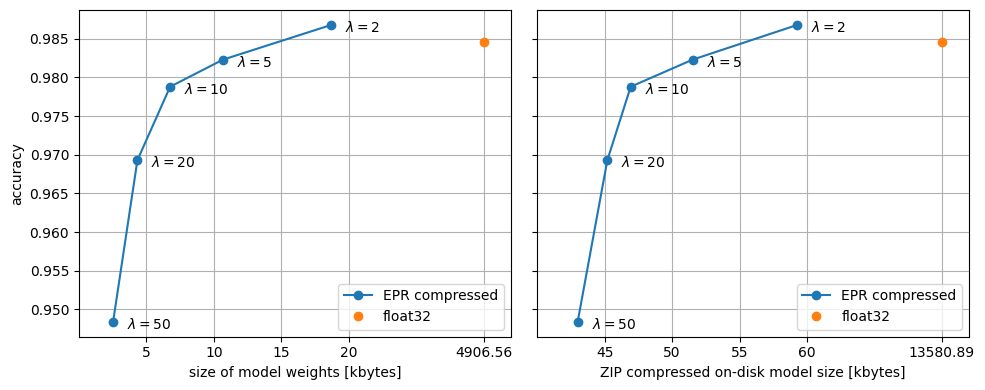

In [26]:
#@title

def plot_broken_xaxis(ax, compressed_sizes, original_size, original_accuracy):
  xticks = list(range(
      int(tf.math.floor(min(compressed_sizes) / 5) * 5),
      int(tf.math.ceil(max(compressed_sizes) / 5) * 5) + 1,
      5))
  xticks.append(xticks[-1] + 10)
  ax.set_xlim(xticks[0], xticks[-1] + 2)
  ax.set_xticks(xticks[1:])
  ax.set_xticklabels(xticks[1:-1] + [f"{original_size:0.2f}"])
  ax.plot(xticks[-1], original_accuracy, "o", label="float32")

sizes, zip_sizes, accuracies = tf.transpose(metrics)
sizes /= 1024
zip_sizes /= 1024

fig, (axl, axr) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
axl.plot(sizes, accuracies, "o-", label="EPR compressed")
axr.plot(zip_sizes, accuracies, "o-", label="EPR compressed")
plot_broken_xaxis(axl, sizes, original_size/1024, classifier_accuracy)
plot_broken_xaxis(axr, zip_sizes, original_zip_size/1024, classifier_accuracy)

axl.set_xlabel("size of model weights [kbytes]")
axr.set_xlabel("ZIP compressed on-disk model size [kbytes]")
axl.set_ylabel("accuracy")
axl.legend(loc="lower right")
axr.legend(loc="lower right")
axl.grid()
axr.grid()
for i in range(len(lambdas)):
  axl.annotate(f"$\lambda = {lambdas[i]:0.0f}$", (sizes[i], accuracies[i]),
               xytext=(10, -5), xycoords="data", textcoords="offset points")
  axr.annotate(f"$\lambda = {lambdas[i]:0.0f}$", (zip_sizes[i], accuracies[i]),
               xytext=(10, -5), xycoords="data", textcoords="offset points")
plt.tight_layout()


The plot should ideally show an elbow-shaped size–accuracy trade-off, but it is normal for accuracy metrics to be somewhat noisy. Depending on initialization, the curve can exhibit some kinks.

Due to the regularization effect, the EPR compressed model is more accurate on the test set than the original model for small values of $\lambda$. The EPR compressed model is also many times smaller, even if we compare the sizes after additional ZIP compression.

## Decompress the classifier

`CompressedDense` and `CompressedConv2D` decompress their weights on every forward pass. This makes them ideal for memory-limited devices, but the decompression can be computationally expensive, especially for small batch sizes.

To decompress the model once, and use it for further training or inference, we can convert it back into a model using regular or compressible layers. This can be useful in model deployment or federated learning scenarios.

First, converting back into a plain model, we can do inference, and/or continue regular training without a compression penalty:

In [27]:
def decompress_layer(layer):
  if isinstance(layer, CompressedDense):
    return CustomDense.copy(layer)
  if isinstance(layer, CompressedConv2D):
    return CustomConv2D.copy(layer)
  return type(layer).from_config(layer.get_config())

decompressed_classifier = tf.keras.models.clone_model(
    compressed_classifier, clone_function=decompress_layer)


In [28]:
decompressed_accuracy = train_model(
    decompressed_classifier, training_dataset, validation_dataset, epochs=1)

print(f"Accuracy of the compressed classifier: {compressed_accuracy:0.4f}")
print(f"Accuracy of the decompressed classifier after one more epoch of training: {decompressed_accuracy:0.4f}")


  1/469 [..............................] - ETA: 6:07 - loss: 0.0174 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 48s - loss: 0.5480 - sparse_categorical_accuracy: 0.8984 

  3/469 [..............................] - ETA: 48s - loss: 0.3937 - sparse_categorical_accuracy: 0.9245

  4/469 [..............................] - ETA: 48s - loss: 0.4537 - sparse_categorical_accuracy: 0.9043

  5/469 [..............................] - ETA: 48s - loss: 0.4844 - sparse_categorical_accuracy: 0.8938

  6/469 [..............................] - ETA: 48s - loss: 0.4460 - sparse_categorical_accuracy: 0.8997

  7/469 [..............................] - ETA: 48s - loss: 0.3895 - sparse_categorical_accuracy: 0.9107

  8/469 [..............................] - ETA: 47s - loss: 0.3529 - sparse_categorical_accuracy: 0.9170

  9/469 [..............................] - ETA: 47s - loss: 0.3393 - sparse_categorical_accuracy: 0.9175

 10/469 [..............................] - ETA: 47s - loss: 0.3356 - sparse_categorical_accuracy: 0.9180

 11/469 [..............................] - ETA: 47s - loss: 0.3184 - sparse_categorical_accuracy: 0.9197

 12/469 [..............................] - ETA: 47s - loss: 0.3044 - sparse_categorical_accuracy: 0.9219

 13/469 [..............................] - ETA: 47s - loss: 0.2917 - sparse_categorical_accuracy: 0.9231

 14/469 [..............................] - ETA: 47s - loss: 0.2987 - sparse_categorical_accuracy: 0.9219

 15/469 [..............................] - ETA: 47s - loss: 0.2902 - sparse_categorical_accuracy: 0.9234

 16/469 [>.............................] - ETA: 46s - loss: 0.2836 - sparse_categorical_accuracy: 0.9253

 17/469 [>.............................] - ETA: 46s - loss: 0.2683 - sparse_categorical_accuracy: 0.9292

 18/469 [>.............................] - ETA: 46s - loss: 0.2650 - sparse_categorical_accuracy: 0.9306

 19/469 [>.............................] - ETA: 46s - loss: 0.2620 - sparse_categorical_accuracy: 0.9309

 20/469 [>.............................] - ETA: 46s - loss: 0.2512 - sparse_categorical_accuracy: 0.9332

 21/469 [>.............................] - ETA: 46s - loss: 0.2549 - sparse_categorical_accuracy: 0.9338

 22/469 [>.............................] - ETA: 46s - loss: 0.2546 - sparse_categorical_accuracy: 0.9343

 23/469 [>.............................] - ETA: 46s - loss: 0.2478 - sparse_categorical_accuracy: 0.9355

 24/469 [>.............................] - ETA: 46s - loss: 0.2504 - sparse_categorical_accuracy: 0.9352

 25/469 [>.............................] - ETA: 46s - loss: 0.2487 - sparse_categorical_accuracy: 0.9356

 26/469 [>.............................] - ETA: 46s - loss: 0.2427 - sparse_categorical_accuracy: 0.9369

 27/469 [>.............................] - ETA: 45s - loss: 0.2394 - sparse_categorical_accuracy: 0.9369

 28/469 [>.............................] - ETA: 45s - loss: 0.2316 - sparse_categorical_accuracy: 0.9386

 29/469 [>.............................] - ETA: 45s - loss: 0.2281 - sparse_categorical_accuracy: 0.9397

 30/469 [>.............................] - ETA: 45s - loss: 0.2231 - sparse_categorical_accuracy: 0.9409

 31/469 [>.............................] - ETA: 45s - loss: 0.2209 - sparse_categorical_accuracy: 0.9418

 32/469 [=>............................] - ETA: 45s - loss: 0.2187 - sparse_categorical_accuracy: 0.9421

 33/469 [=>............................] - ETA: 45s - loss: 0.2163 - sparse_categorical_accuracy: 0.9427

 34/469 [=>............................] - ETA: 45s - loss: 0.2135 - sparse_categorical_accuracy: 0.9432

 35/469 [=>............................] - ETA: 45s - loss: 0.2102 - sparse_categorical_accuracy: 0.9433

 36/469 [=>............................] - ETA: 45s - loss: 0.2062 - sparse_categorical_accuracy: 0.9440

 37/469 [=>............................] - ETA: 44s - loss: 0.2025 - sparse_categorical_accuracy: 0.9449

 38/469 [=>............................] - ETA: 44s - loss: 0.2015 - sparse_categorical_accuracy: 0.9451

 39/469 [=>............................] - ETA: 44s - loss: 0.1980 - sparse_categorical_accuracy: 0.9459

 40/469 [=>............................] - ETA: 44s - loss: 0.1945 - sparse_categorical_accuracy: 0.9469

 41/469 [=>............................] - ETA: 44s - loss: 0.1911 - sparse_categorical_accuracy: 0.9474

 42/469 [=>............................] - ETA: 44s - loss: 0.1896 - sparse_categorical_accuracy: 0.9477

 43/469 [=>............................] - ETA: 44s - loss: 0.1907 - sparse_categorical_accuracy: 0.9479

 44/469 [=>............................] - ETA: 44s - loss: 0.1896 - sparse_categorical_accuracy: 0.9476

 45/469 [=>............................] - ETA: 44s - loss: 0.1866 - sparse_categorical_accuracy: 0.9484

 46/469 [=>............................] - ETA: 43s - loss: 0.1854 - sparse_categorical_accuracy: 0.9489

 47/469 [==>...........................] - ETA: 43s - loss: 0.1824 - sparse_categorical_accuracy: 0.9498

 48/469 [==>...........................] - ETA: 43s - loss: 0.1801 - sparse_categorical_accuracy: 0.9505

 49/469 [==>...........................] - ETA: 43s - loss: 0.1802 - sparse_categorical_accuracy: 0.9507

 50/469 [==>...........................] - ETA: 43s - loss: 0.1777 - sparse_categorical_accuracy: 0.9514

 51/469 [==>...........................] - ETA: 43s - loss: 0.1761 - sparse_categorical_accuracy: 0.9516

 52/469 [==>...........................] - ETA: 43s - loss: 0.1745 - sparse_categorical_accuracy: 0.9522

 53/469 [==>...........................] - ETA: 43s - loss: 0.1725 - sparse_categorical_accuracy: 0.9527

 54/469 [==>...........................] - ETA: 43s - loss: 0.1701 - sparse_categorical_accuracy: 0.9533

 55/469 [==>...........................] - ETA: 43s - loss: 0.1686 - sparse_categorical_accuracy: 0.9531

 56/469 [==>...........................] - ETA: 42s - loss: 0.1660 - sparse_categorical_accuracy: 0.9538

 57/469 [==>...........................] - ETA: 42s - loss: 0.1650 - sparse_categorical_accuracy: 0.9542

 58/469 [==>...........................] - ETA: 42s - loss: 0.1639 - sparse_categorical_accuracy: 0.9543

 59/469 [==>...........................] - ETA: 42s - loss: 0.1628 - sparse_categorical_accuracy: 0.9547

 60/469 [==>...........................] - ETA: 42s - loss: 0.1620 - sparse_categorical_accuracy: 0.9549

 61/469 [==>...........................] - ETA: 42s - loss: 0.1616 - sparse_categorical_accuracy: 0.9549

 62/469 [==>...........................] - ETA: 42s - loss: 0.1631 - sparse_categorical_accuracy: 0.9549

 63/469 [===>..........................] - ETA: 42s - loss: 0.1616 - sparse_categorical_accuracy: 0.9552

 64/469 [===>..........................] - ETA: 42s - loss: 0.1601 - sparse_categorical_accuracy: 0.9556

 65/469 [===>..........................] - ETA: 42s - loss: 0.1582 - sparse_categorical_accuracy: 0.9560

 66/469 [===>..........................] - ETA: 41s - loss: 0.1567 - sparse_categorical_accuracy: 0.9563

 67/469 [===>..........................] - ETA: 41s - loss: 0.1553 - sparse_categorical_accuracy: 0.9565

 68/469 [===>..........................] - ETA: 41s - loss: 0.1536 - sparse_categorical_accuracy: 0.9570

 69/469 [===>..........................] - ETA: 41s - loss: 0.1522 - sparse_categorical_accuracy: 0.9573

 70/469 [===>..........................] - ETA: 41s - loss: 0.1503 - sparse_categorical_accuracy: 0.9579

 71/469 [===>..........................] - ETA: 41s - loss: 0.1491 - sparse_categorical_accuracy: 0.9583

 72/469 [===>..........................] - ETA: 41s - loss: 0.1480 - sparse_categorical_accuracy: 0.9587

 73/469 [===>..........................] - ETA: 41s - loss: 0.1468 - sparse_categorical_accuracy: 0.9589

 74/469 [===>..........................] - ETA: 41s - loss: 0.1458 - sparse_categorical_accuracy: 0.9591

 75/469 [===>..........................] - ETA: 41s - loss: 0.1456 - sparse_categorical_accuracy: 0.9591

 76/469 [===>..........................] - ETA: 40s - loss: 0.1441 - sparse_categorical_accuracy: 0.9594

 77/469 [===>..........................] - ETA: 40s - loss: 0.1435 - sparse_categorical_accuracy: 0.9594

 78/469 [===>..........................] - ETA: 40s - loss: 0.1429 - sparse_categorical_accuracy: 0.9597

 79/469 [====>.........................] - ETA: 40s - loss: 0.1414 - sparse_categorical_accuracy: 0.9600

 80/469 [====>.........................] - ETA: 40s - loss: 0.1407 - sparse_categorical_accuracy: 0.9603

 81/469 [====>.........................] - ETA: 40s - loss: 0.1402 - sparse_categorical_accuracy: 0.9602

 82/469 [====>.........................] - ETA: 40s - loss: 0.1397 - sparse_categorical_accuracy: 0.9604

 83/469 [====>.........................] - ETA: 40s - loss: 0.1388 - sparse_categorical_accuracy: 0.9606

 84/469 [====>.........................] - ETA: 40s - loss: 0.1383 - sparse_categorical_accuracy: 0.9608

 85/469 [====>.........................] - ETA: 39s - loss: 0.1377 - sparse_categorical_accuracy: 0.9609

 86/469 [====>.........................] - ETA: 39s - loss: 0.1371 - sparse_categorical_accuracy: 0.9609

 87/469 [====>.........................] - ETA: 39s - loss: 0.1368 - sparse_categorical_accuracy: 0.9609

 88/469 [====>.........................] - ETA: 39s - loss: 0.1361 - sparse_categorical_accuracy: 0.9613

 89/469 [====>.........................] - ETA: 39s - loss: 0.1356 - sparse_categorical_accuracy: 0.9614

 90/469 [====>.........................] - ETA: 39s - loss: 0.1344 - sparse_categorical_accuracy: 0.9617

 91/469 [====>.........................] - ETA: 39s - loss: 0.1339 - sparse_categorical_accuracy: 0.9618

 92/469 [====>.........................] - ETA: 39s - loss: 0.1328 - sparse_categorical_accuracy: 0.9620

 93/469 [====>.........................] - ETA: 39s - loss: 0.1333 - sparse_categorical_accuracy: 0.9619

 94/469 [=====>........................] - ETA: 39s - loss: 0.1330 - sparse_categorical_accuracy: 0.9619

 95/469 [=====>........................] - ETA: 38s - loss: 0.1324 - sparse_categorical_accuracy: 0.9621

 96/469 [=====>........................] - ETA: 38s - loss: 0.1324 - sparse_categorical_accuracy: 0.9622

 97/469 [=====>........................] - ETA: 38s - loss: 0.1314 - sparse_categorical_accuracy: 0.9624

 98/469 [=====>........................] - ETA: 38s - loss: 0.1306 - sparse_categorical_accuracy: 0.9626

 99/469 [=====>........................] - ETA: 38s - loss: 0.1299 - sparse_categorical_accuracy: 0.9628

100/469 [=====>........................] - ETA: 38s - loss: 0.1293 - sparse_categorical_accuracy: 0.9631

101/469 [=====>........................] - ETA: 38s - loss: 0.1285 - sparse_categorical_accuracy: 0.9633

102/469 [=====>........................] - ETA: 38s - loss: 0.1280 - sparse_categorical_accuracy: 0.9633

103/469 [=====>........................] - ETA: 38s - loss: 0.1273 - sparse_categorical_accuracy: 0.9635

104/469 [=====>........................] - ETA: 37s - loss: 0.1266 - sparse_categorical_accuracy: 0.9636

105/469 [=====>........................] - ETA: 37s - loss: 0.1255 - sparse_categorical_accuracy: 0.9639

106/469 [=====>........................] - ETA: 37s - loss: 0.1256 - sparse_categorical_accuracy: 0.9640

107/469 [=====>........................] - ETA: 37s - loss: 0.1246 - sparse_categorical_accuracy: 0.9643

108/469 [=====>........................] - ETA: 37s - loss: 0.1247 - sparse_categorical_accuracy: 0.9642

109/469 [=====>........................] - ETA: 37s - loss: 0.1243 - sparse_categorical_accuracy: 0.9644

110/469 [======>.......................] - ETA: 37s - loss: 0.1241 - sparse_categorical_accuracy: 0.9643

111/469 [======>.......................] - ETA: 37s - loss: 0.1233 - sparse_categorical_accuracy: 0.9646

112/469 [======>.......................] - ETA: 37s - loss: 0.1234 - sparse_categorical_accuracy: 0.9646

113/469 [======>.......................] - ETA: 37s - loss: 0.1233 - sparse_categorical_accuracy: 0.9646

114/469 [======>.......................] - ETA: 36s - loss: 0.1226 - sparse_categorical_accuracy: 0.9648

115/469 [======>.......................] - ETA: 36s - loss: 0.1229 - sparse_categorical_accuracy: 0.9647

116/469 [======>.......................] - ETA: 36s - loss: 0.1220 - sparse_categorical_accuracy: 0.9650

117/469 [======>.......................] - ETA: 36s - loss: 0.1218 - sparse_categorical_accuracy: 0.9650

118/469 [======>.......................] - ETA: 36s - loss: 0.1215 - sparse_categorical_accuracy: 0.9649

119/469 [======>.......................] - ETA: 36s - loss: 0.1209 - sparse_categorical_accuracy: 0.9650

120/469 [======>.......................] - ETA: 36s - loss: 0.1208 - sparse_categorical_accuracy: 0.9651

121/469 [======>.......................] - ETA: 36s - loss: 0.1210 - sparse_categorical_accuracy: 0.9653

122/469 [======>.......................] - ETA: 36s - loss: 0.1209 - sparse_categorical_accuracy: 0.9652

123/469 [======>.......................] - ETA: 35s - loss: 0.1202 - sparse_categorical_accuracy: 0.9654

124/469 [======>.......................] - ETA: 35s - loss: 0.1198 - sparse_categorical_accuracy: 0.9654

125/469 [======>.......................] - ETA: 35s - loss: 0.1192 - sparse_categorical_accuracy: 0.9656

126/469 [=======>......................] - ETA: 35s - loss: 0.1189 - sparse_categorical_accuracy: 0.9656

127/469 [=======>......................] - ETA: 35s - loss: 0.1184 - sparse_categorical_accuracy: 0.9657

128/469 [=======>......................] - ETA: 35s - loss: 0.1179 - sparse_categorical_accuracy: 0.9658

129/469 [=======>......................] - ETA: 35s - loss: 0.1182 - sparse_categorical_accuracy: 0.9658

130/469 [=======>......................] - ETA: 35s - loss: 0.1178 - sparse_categorical_accuracy: 0.9659

131/469 [=======>......................] - ETA: 35s - loss: 0.1172 - sparse_categorical_accuracy: 0.9660

132/469 [=======>......................] - ETA: 35s - loss: 0.1171 - sparse_categorical_accuracy: 0.9659

133/469 [=======>......................] - ETA: 34s - loss: 0.1173 - sparse_categorical_accuracy: 0.9658

134/469 [=======>......................] - ETA: 34s - loss: 0.1173 - sparse_categorical_accuracy: 0.9657

135/469 [=======>......................] - ETA: 34s - loss: 0.1173 - sparse_categorical_accuracy: 0.9657

136/469 [=======>......................] - ETA: 34s - loss: 0.1169 - sparse_categorical_accuracy: 0.9658

137/469 [=======>......................] - ETA: 34s - loss: 0.1174 - sparse_categorical_accuracy: 0.9658

138/469 [=======>......................] - ETA: 34s - loss: 0.1172 - sparse_categorical_accuracy: 0.9657

139/469 [=======>......................] - ETA: 34s - loss: 0.1171 - sparse_categorical_accuracy: 0.9658

140/469 [=======>......................] - ETA: 34s - loss: 0.1165 - sparse_categorical_accuracy: 0.9660

141/469 [========>.....................] - ETA: 34s - loss: 0.1160 - sparse_categorical_accuracy: 0.9661

142/469 [========>.....................] - ETA: 34s - loss: 0.1158 - sparse_categorical_accuracy: 0.9661

143/469 [========>.....................] - ETA: 33s - loss: 0.1152 - sparse_categorical_accuracy: 0.9662

144/469 [========>.....................] - ETA: 33s - loss: 0.1151 - sparse_categorical_accuracy: 0.9662

145/469 [========>.....................] - ETA: 33s - loss: 0.1146 - sparse_categorical_accuracy: 0.9664

146/469 [========>.....................] - ETA: 33s - loss: 0.1143 - sparse_categorical_accuracy: 0.9665

147/469 [========>.....................] - ETA: 33s - loss: 0.1135 - sparse_categorical_accuracy: 0.9667

148/469 [========>.....................] - ETA: 33s - loss: 0.1137 - sparse_categorical_accuracy: 0.9667

149/469 [========>.....................] - ETA: 33s - loss: 0.1132 - sparse_categorical_accuracy: 0.9669

150/469 [========>.....................] - ETA: 33s - loss: 0.1127 - sparse_categorical_accuracy: 0.9670

151/469 [========>.....................] - ETA: 33s - loss: 0.1124 - sparse_categorical_accuracy: 0.9670

152/469 [========>.....................] - ETA: 32s - loss: 0.1119 - sparse_categorical_accuracy: 0.9672

153/469 [========>.....................] - ETA: 32s - loss: 0.1113 - sparse_categorical_accuracy: 0.9673

154/469 [========>.....................] - ETA: 32s - loss: 0.1110 - sparse_categorical_accuracy: 0.9673

155/469 [========>.....................] - ETA: 32s - loss: 0.1104 - sparse_categorical_accuracy: 0.9675

156/469 [========>.....................] - ETA: 32s - loss: 0.1100 - sparse_categorical_accuracy: 0.9676

157/469 [=========>....................] - ETA: 32s - loss: 0.1097 - sparse_categorical_accuracy: 0.9677

158/469 [=========>....................] - ETA: 32s - loss: 0.1092 - sparse_categorical_accuracy: 0.9678

159/469 [=========>....................] - ETA: 32s - loss: 0.1087 - sparse_categorical_accuracy: 0.9680

160/469 [=========>....................] - ETA: 32s - loss: 0.1085 - sparse_categorical_accuracy: 0.9680

161/469 [=========>....................] - ETA: 32s - loss: 0.1084 - sparse_categorical_accuracy: 0.9679

162/469 [=========>....................] - ETA: 31s - loss: 0.1084 - sparse_categorical_accuracy: 0.9679

163/469 [=========>....................] - ETA: 31s - loss: 0.1081 - sparse_categorical_accuracy: 0.9680

164/469 [=========>....................] - ETA: 31s - loss: 0.1082 - sparse_categorical_accuracy: 0.9679

165/469 [=========>....................] - ETA: 31s - loss: 0.1080 - sparse_categorical_accuracy: 0.9679

166/469 [=========>....................] - ETA: 31s - loss: 0.1083 - sparse_categorical_accuracy: 0.9679

167/469 [=========>....................] - ETA: 31s - loss: 0.1079 - sparse_categorical_accuracy: 0.9680

168/469 [=========>....................] - ETA: 31s - loss: 0.1078 - sparse_categorical_accuracy: 0.9680

169/469 [=========>....................] - ETA: 31s - loss: 0.1073 - sparse_categorical_accuracy: 0.9681

170/469 [=========>....................] - ETA: 31s - loss: 0.1069 - sparse_categorical_accuracy: 0.9682

171/469 [=========>....................] - ETA: 31s - loss: 0.1068 - sparse_categorical_accuracy: 0.9683

172/469 [==========>...................] - ETA: 30s - loss: 0.1064 - sparse_categorical_accuracy: 0.9684

173/469 [==========>...................] - ETA: 30s - loss: 0.1060 - sparse_categorical_accuracy: 0.9686

174/469 [==========>...................] - ETA: 30s - loss: 0.1060 - sparse_categorical_accuracy: 0.9686

175/469 [==========>...................] - ETA: 30s - loss: 0.1058 - sparse_categorical_accuracy: 0.9686

176/469 [==========>...................] - ETA: 30s - loss: 0.1054 - sparse_categorical_accuracy: 0.9687

177/469 [==========>...................] - ETA: 30s - loss: 0.1054 - sparse_categorical_accuracy: 0.9688

178/469 [==========>...................] - ETA: 30s - loss: 0.1053 - sparse_categorical_accuracy: 0.9688

179/469 [==========>...................] - ETA: 30s - loss: 0.1053 - sparse_categorical_accuracy: 0.9688

180/469 [==========>...................] - ETA: 30s - loss: 0.1053 - sparse_categorical_accuracy: 0.9688

181/469 [==========>...................] - ETA: 29s - loss: 0.1048 - sparse_categorical_accuracy: 0.9689

182/469 [==========>...................] - ETA: 29s - loss: 0.1046 - sparse_categorical_accuracy: 0.9690

183/469 [==========>...................] - ETA: 29s - loss: 0.1041 - sparse_categorical_accuracy: 0.9692

184/469 [==========>...................] - ETA: 29s - loss: 0.1038 - sparse_categorical_accuracy: 0.9693

185/469 [==========>...................] - ETA: 29s - loss: 0.1037 - sparse_categorical_accuracy: 0.9693

186/469 [==========>...................] - ETA: 29s - loss: 0.1034 - sparse_categorical_accuracy: 0.9694

187/469 [==========>...................] - ETA: 29s - loss: 0.1031 - sparse_categorical_accuracy: 0.9694

188/469 [===========>..................] - ETA: 29s - loss: 0.1034 - sparse_categorical_accuracy: 0.9693

189/469 [===========>..................] - ETA: 29s - loss: 0.1031 - sparse_categorical_accuracy: 0.9694

190/469 [===========>..................] - ETA: 29s - loss: 0.1029 - sparse_categorical_accuracy: 0.9695

191/469 [===========>..................] - ETA: 28s - loss: 0.1028 - sparse_categorical_accuracy: 0.9695

192/469 [===========>..................] - ETA: 28s - loss: 0.1024 - sparse_categorical_accuracy: 0.9696

193/469 [===========>..................] - ETA: 28s - loss: 0.1024 - sparse_categorical_accuracy: 0.9696

194/469 [===========>..................] - ETA: 28s - loss: 0.1023 - sparse_categorical_accuracy: 0.9697

195/469 [===========>..................] - ETA: 28s - loss: 0.1020 - sparse_categorical_accuracy: 0.9698

196/469 [===========>..................] - ETA: 28s - loss: 0.1017 - sparse_categorical_accuracy: 0.9699

197/469 [===========>..................] - ETA: 28s - loss: 0.1016 - sparse_categorical_accuracy: 0.9699

198/469 [===========>..................] - ETA: 28s - loss: 0.1013 - sparse_categorical_accuracy: 0.9699

199/469 [===========>..................] - ETA: 28s - loss: 0.1015 - sparse_categorical_accuracy: 0.9698

200/469 [===========>..................] - ETA: 28s - loss: 0.1011 - sparse_categorical_accuracy: 0.9700

201/469 [===========>..................] - ETA: 27s - loss: 0.1010 - sparse_categorical_accuracy: 0.9699

202/469 [===========>..................] - ETA: 27s - loss: 0.1007 - sparse_categorical_accuracy: 0.9700

203/469 [===========>..................] - ETA: 27s - loss: 0.1007 - sparse_categorical_accuracy: 0.9700

204/469 [============>.................] - ETA: 27s - loss: 0.1003 - sparse_categorical_accuracy: 0.9702

205/469 [============>.................] - ETA: 27s - loss: 0.1000 - sparse_categorical_accuracy: 0.9702

206/469 [============>.................] - ETA: 27s - loss: 0.0995 - sparse_categorical_accuracy: 0.9703

207/469 [============>.................] - ETA: 27s - loss: 0.0997 - sparse_categorical_accuracy: 0.9703

208/469 [============>.................] - ETA: 27s - loss: 0.0993 - sparse_categorical_accuracy: 0.9703

209/469 [============>.................] - ETA: 27s - loss: 0.0991 - sparse_categorical_accuracy: 0.9704

210/469 [============>.................] - ETA: 26s - loss: 0.0991 - sparse_categorical_accuracy: 0.9704

211/469 [============>.................] - ETA: 26s - loss: 0.0988 - sparse_categorical_accuracy: 0.9705

212/469 [============>.................] - ETA: 26s - loss: 0.0986 - sparse_categorical_accuracy: 0.9706

213/469 [============>.................] - ETA: 26s - loss: 0.0985 - sparse_categorical_accuracy: 0.9706

214/469 [============>.................] - ETA: 26s - loss: 0.0985 - sparse_categorical_accuracy: 0.9706

215/469 [============>.................] - ETA: 26s - loss: 0.0986 - sparse_categorical_accuracy: 0.9706

216/469 [============>.................] - ETA: 26s - loss: 0.0985 - sparse_categorical_accuracy: 0.9706

217/469 [============>.................] - ETA: 26s - loss: 0.0983 - sparse_categorical_accuracy: 0.9707

218/469 [============>.................] - ETA: 26s - loss: 0.0980 - sparse_categorical_accuracy: 0.9708

219/469 [=============>................] - ETA: 26s - loss: 0.0978 - sparse_categorical_accuracy: 0.9708

220/469 [=============>................] - ETA: 25s - loss: 0.0975 - sparse_categorical_accuracy: 0.9709

221/469 [=============>................] - ETA: 25s - loss: 0.0972 - sparse_categorical_accuracy: 0.9709

222/469 [=============>................] - ETA: 25s - loss: 0.0969 - sparse_categorical_accuracy: 0.9710

223/469 [=============>................] - ETA: 25s - loss: 0.0969 - sparse_categorical_accuracy: 0.9710

224/469 [=============>................] - ETA: 25s - loss: 0.0968 - sparse_categorical_accuracy: 0.9711

225/469 [=============>................] - ETA: 25s - loss: 0.0965 - sparse_categorical_accuracy: 0.9711

226/469 [=============>................] - ETA: 25s - loss: 0.0963 - sparse_categorical_accuracy: 0.9711

227/469 [=============>................] - ETA: 25s - loss: 0.0961 - sparse_categorical_accuracy: 0.9712

228/469 [=============>................] - ETA: 25s - loss: 0.0961 - sparse_categorical_accuracy: 0.9711

229/469 [=============>................] - ETA: 24s - loss: 0.0960 - sparse_categorical_accuracy: 0.9711

230/469 [=============>................] - ETA: 24s - loss: 0.0959 - sparse_categorical_accuracy: 0.9712

231/469 [=============>................] - ETA: 24s - loss: 0.0955 - sparse_categorical_accuracy: 0.9713

232/469 [=============>................] - ETA: 24s - loss: 0.0952 - sparse_categorical_accuracy: 0.9714

233/469 [=============>................] - ETA: 24s - loss: 0.0949 - sparse_categorical_accuracy: 0.9714

234/469 [=============>................] - ETA: 24s - loss: 0.0950 - sparse_categorical_accuracy: 0.9714

235/469 [==============>...............] - ETA: 24s - loss: 0.0954 - sparse_categorical_accuracy: 0.9712

236/469 [==============>...............] - ETA: 24s - loss: 0.0954 - sparse_categorical_accuracy: 0.9712

237/469 [==============>...............] - ETA: 24s - loss: 0.0953 - sparse_categorical_accuracy: 0.9712

238/469 [==============>...............] - ETA: 24s - loss: 0.0949 - sparse_categorical_accuracy: 0.9713

239/469 [==============>...............] - ETA: 23s - loss: 0.0948 - sparse_categorical_accuracy: 0.9714

240/469 [==============>...............] - ETA: 23s - loss: 0.0945 - sparse_categorical_accuracy: 0.9715

241/469 [==============>...............] - ETA: 23s - loss: 0.0944 - sparse_categorical_accuracy: 0.9714

242/469 [==============>...............] - ETA: 23s - loss: 0.0943 - sparse_categorical_accuracy: 0.9715

243/469 [==============>...............] - ETA: 23s - loss: 0.0948 - sparse_categorical_accuracy: 0.9714

244/469 [==============>...............] - ETA: 23s - loss: 0.0946 - sparse_categorical_accuracy: 0.9714

245/469 [==============>...............] - ETA: 23s - loss: 0.0946 - sparse_categorical_accuracy: 0.9714

246/469 [==============>...............] - ETA: 23s - loss: 0.0943 - sparse_categorical_accuracy: 0.9715

247/469 [==============>...............] - ETA: 23s - loss: 0.0941 - sparse_categorical_accuracy: 0.9716

248/469 [==============>...............] - ETA: 22s - loss: 0.0939 - sparse_categorical_accuracy: 0.9717

249/469 [==============>...............] - ETA: 22s - loss: 0.0940 - sparse_categorical_accuracy: 0.9717

250/469 [==============>...............] - ETA: 22s - loss: 0.0937 - sparse_categorical_accuracy: 0.9718

251/469 [===============>..............] - ETA: 22s - loss: 0.0937 - sparse_categorical_accuracy: 0.9718

252/469 [===============>..............] - ETA: 22s - loss: 0.0936 - sparse_categorical_accuracy: 0.9718

253/469 [===============>..............] - ETA: 22s - loss: 0.0933 - sparse_categorical_accuracy: 0.9719

254/469 [===============>..............] - ETA: 22s - loss: 0.0931 - sparse_categorical_accuracy: 0.9720

255/469 [===============>..............] - ETA: 22s - loss: 0.0929 - sparse_categorical_accuracy: 0.9720

256/469 [===============>..............] - ETA: 22s - loss: 0.0926 - sparse_categorical_accuracy: 0.9721

257/469 [===============>..............] - ETA: 22s - loss: 0.0925 - sparse_categorical_accuracy: 0.9721

258/469 [===============>..............] - ETA: 21s - loss: 0.0923 - sparse_categorical_accuracy: 0.9722

259/469 [===============>..............] - ETA: 21s - loss: 0.0922 - sparse_categorical_accuracy: 0.9722

260/469 [===============>..............] - ETA: 21s - loss: 0.0920 - sparse_categorical_accuracy: 0.9722

261/469 [===============>..............] - ETA: 21s - loss: 0.0919 - sparse_categorical_accuracy: 0.9723

262/469 [===============>..............] - ETA: 21s - loss: 0.0921 - sparse_categorical_accuracy: 0.9722

263/469 [===============>..............] - ETA: 21s - loss: 0.0921 - sparse_categorical_accuracy: 0.9722

264/469 [===============>..............] - ETA: 21s - loss: 0.0923 - sparse_categorical_accuracy: 0.9722

265/469 [===============>..............] - ETA: 21s - loss: 0.0923 - sparse_categorical_accuracy: 0.9722

266/469 [================>.............] - ETA: 21s - loss: 0.0921 - sparse_categorical_accuracy: 0.9722

267/469 [================>.............] - ETA: 21s - loss: 0.0920 - sparse_categorical_accuracy: 0.9722

268/469 [================>.............] - ETA: 20s - loss: 0.0919 - sparse_categorical_accuracy: 0.9722

269/469 [================>.............] - ETA: 20s - loss: 0.0918 - sparse_categorical_accuracy: 0.9722

270/469 [================>.............] - ETA: 20s - loss: 0.0916 - sparse_categorical_accuracy: 0.9723

271/469 [================>.............] - ETA: 20s - loss: 0.0916 - sparse_categorical_accuracy: 0.9723

272/469 [================>.............] - ETA: 20s - loss: 0.0915 - sparse_categorical_accuracy: 0.9723

273/469 [================>.............] - ETA: 20s - loss: 0.0913 - sparse_categorical_accuracy: 0.9724

274/469 [================>.............] - ETA: 20s - loss: 0.0912 - sparse_categorical_accuracy: 0.9724

275/469 [================>.............] - ETA: 20s - loss: 0.0910 - sparse_categorical_accuracy: 0.9725

276/469 [================>.............] - ETA: 20s - loss: 0.0908 - sparse_categorical_accuracy: 0.9725

277/469 [================>.............] - ETA: 19s - loss: 0.0906 - sparse_categorical_accuracy: 0.9726

278/469 [================>.............] - ETA: 19s - loss: 0.0907 - sparse_categorical_accuracy: 0.9725

279/469 [================>.............] - ETA: 19s - loss: 0.0908 - sparse_categorical_accuracy: 0.9725

280/469 [================>.............] - ETA: 19s - loss: 0.0906 - sparse_categorical_accuracy: 0.9726

281/469 [================>.............] - ETA: 19s - loss: 0.0907 - sparse_categorical_accuracy: 0.9725

282/469 [=================>............] - ETA: 19s - loss: 0.0905 - sparse_categorical_accuracy: 0.9726

283/469 [=================>............] - ETA: 19s - loss: 0.0903 - sparse_categorical_accuracy: 0.9726

284/469 [=================>............] - ETA: 19s - loss: 0.0905 - sparse_categorical_accuracy: 0.9726

285/469 [=================>............] - ETA: 19s - loss: 0.0906 - sparse_categorical_accuracy: 0.9726

286/469 [=================>............] - ETA: 19s - loss: 0.0904 - sparse_categorical_accuracy: 0.9726

287/469 [=================>............] - ETA: 18s - loss: 0.0903 - sparse_categorical_accuracy: 0.9727

288/469 [=================>............] - ETA: 18s - loss: 0.0903 - sparse_categorical_accuracy: 0.9727

289/469 [=================>............] - ETA: 18s - loss: 0.0903 - sparse_categorical_accuracy: 0.9728

290/469 [=================>............] - ETA: 18s - loss: 0.0903 - sparse_categorical_accuracy: 0.9727

291/469 [=================>............] - ETA: 18s - loss: 0.0904 - sparse_categorical_accuracy: 0.9727

292/469 [=================>............] - ETA: 18s - loss: 0.0902 - sparse_categorical_accuracy: 0.9727

293/469 [=================>............] - ETA: 18s - loss: 0.0904 - sparse_categorical_accuracy: 0.9727

294/469 [=================>............] - ETA: 18s - loss: 0.0902 - sparse_categorical_accuracy: 0.9727

295/469 [=================>............] - ETA: 18s - loss: 0.0902 - sparse_categorical_accuracy: 0.9727

296/469 [=================>............] - ETA: 17s - loss: 0.0901 - sparse_categorical_accuracy: 0.9728

297/469 [=================>............] - ETA: 17s - loss: 0.0900 - sparse_categorical_accuracy: 0.9728

298/469 [==================>...........] - ETA: 17s - loss: 0.0900 - sparse_categorical_accuracy: 0.9728

299/469 [==================>...........] - ETA: 17s - loss: 0.0899 - sparse_categorical_accuracy: 0.9729

300/469 [==================>...........] - ETA: 17s - loss: 0.0896 - sparse_categorical_accuracy: 0.9729

301/469 [==================>...........] - ETA: 17s - loss: 0.0896 - sparse_categorical_accuracy: 0.9730

302/469 [==================>...........] - ETA: 17s - loss: 0.0894 - sparse_categorical_accuracy: 0.9730

303/469 [==================>...........] - ETA: 17s - loss: 0.0893 - sparse_categorical_accuracy: 0.9731

304/469 [==================>...........] - ETA: 17s - loss: 0.0892 - sparse_categorical_accuracy: 0.9731

305/469 [==================>...........] - ETA: 17s - loss: 0.0893 - sparse_categorical_accuracy: 0.9730

306/469 [==================>...........] - ETA: 16s - loss: 0.0891 - sparse_categorical_accuracy: 0.9731

307/469 [==================>...........] - ETA: 16s - loss: 0.0890 - sparse_categorical_accuracy: 0.9731

308/469 [==================>...........] - ETA: 16s - loss: 0.0891 - sparse_categorical_accuracy: 0.9730

309/469 [==================>...........] - ETA: 16s - loss: 0.0889 - sparse_categorical_accuracy: 0.9731

310/469 [==================>...........] - ETA: 16s - loss: 0.0889 - sparse_categorical_accuracy: 0.9731

311/469 [==================>...........] - ETA: 16s - loss: 0.0889 - sparse_categorical_accuracy: 0.9731

312/469 [==================>...........] - ETA: 16s - loss: 0.0888 - sparse_categorical_accuracy: 0.9731

313/469 [===================>..........] - ETA: 16s - loss: 0.0890 - sparse_categorical_accuracy: 0.9731

314/469 [===================>..........] - ETA: 16s - loss: 0.0890 - sparse_categorical_accuracy: 0.9731

315/469 [===================>..........] - ETA: 16s - loss: 0.0889 - sparse_categorical_accuracy: 0.9731

316/469 [===================>..........] - ETA: 15s - loss: 0.0887 - sparse_categorical_accuracy: 0.9732

317/469 [===================>..........] - ETA: 15s - loss: 0.0886 - sparse_categorical_accuracy: 0.9732

318/469 [===================>..........] - ETA: 15s - loss: 0.0884 - sparse_categorical_accuracy: 0.9733

319/469 [===================>..........] - ETA: 15s - loss: 0.0882 - sparse_categorical_accuracy: 0.9733

320/469 [===================>..........] - ETA: 15s - loss: 0.0881 - sparse_categorical_accuracy: 0.9734

321/469 [===================>..........] - ETA: 15s - loss: 0.0880 - sparse_categorical_accuracy: 0.9734

322/469 [===================>..........] - ETA: 15s - loss: 0.0881 - sparse_categorical_accuracy: 0.9734

323/469 [===================>..........] - ETA: 15s - loss: 0.0879 - sparse_categorical_accuracy: 0.9734

324/469 [===================>..........] - ETA: 15s - loss: 0.0879 - sparse_categorical_accuracy: 0.9734

325/469 [===================>..........] - ETA: 14s - loss: 0.0878 - sparse_categorical_accuracy: 0.9734

326/469 [===================>..........] - ETA: 14s - loss: 0.0879 - sparse_categorical_accuracy: 0.9734

327/469 [===================>..........] - ETA: 14s - loss: 0.0877 - sparse_categorical_accuracy: 0.9734

328/469 [===================>..........] - ETA: 14s - loss: 0.0875 - sparse_categorical_accuracy: 0.9735

329/469 [====================>.........] - ETA: 14s - loss: 0.0874 - sparse_categorical_accuracy: 0.9735

330/469 [====================>.........] - ETA: 14s - loss: 0.0874 - sparse_categorical_accuracy: 0.9735

331/469 [====================>.........] - ETA: 14s - loss: 0.0872 - sparse_categorical_accuracy: 0.9735

332/469 [====================>.........] - ETA: 14s - loss: 0.0872 - sparse_categorical_accuracy: 0.9736

333/469 [====================>.........] - ETA: 14s - loss: 0.0871 - sparse_categorical_accuracy: 0.9736

334/469 [====================>.........] - ETA: 14s - loss: 0.0871 - sparse_categorical_accuracy: 0.9736

335/469 [====================>.........] - ETA: 13s - loss: 0.0870 - sparse_categorical_accuracy: 0.9736

336/469 [====================>.........] - ETA: 13s - loss: 0.0871 - sparse_categorical_accuracy: 0.9736

337/469 [====================>.........] - ETA: 13s - loss: 0.0871 - sparse_categorical_accuracy: 0.9736

338/469 [====================>.........] - ETA: 13s - loss: 0.0871 - sparse_categorical_accuracy: 0.9736

339/469 [====================>.........] - ETA: 13s - loss: 0.0870 - sparse_categorical_accuracy: 0.9737

340/469 [====================>.........] - ETA: 13s - loss: 0.0868 - sparse_categorical_accuracy: 0.9737

341/469 [====================>.........] - ETA: 13s - loss: 0.0865 - sparse_categorical_accuracy: 0.9738

342/469 [====================>.........] - ETA: 13s - loss: 0.0863 - sparse_categorical_accuracy: 0.9739

343/469 [====================>.........] - ETA: 13s - loss: 0.0862 - sparse_categorical_accuracy: 0.9739

344/469 [=====================>........] - ETA: 12s - loss: 0.0860 - sparse_categorical_accuracy: 0.9740

345/469 [=====================>........] - ETA: 12s - loss: 0.0860 - sparse_categorical_accuracy: 0.9740

346/469 [=====================>........] - ETA: 12s - loss: 0.0859 - sparse_categorical_accuracy: 0.9740

347/469 [=====================>........] - ETA: 12s - loss: 0.0858 - sparse_categorical_accuracy: 0.9740

348/469 [=====================>........] - ETA: 12s - loss: 0.0857 - sparse_categorical_accuracy: 0.9740

349/469 [=====================>........] - ETA: 12s - loss: 0.0855 - sparse_categorical_accuracy: 0.9741

350/469 [=====================>........] - ETA: 12s - loss: 0.0854 - sparse_categorical_accuracy: 0.9741

351/469 [=====================>........] - ETA: 12s - loss: 0.0853 - sparse_categorical_accuracy: 0.9742

352/469 [=====================>........] - ETA: 12s - loss: 0.0852 - sparse_categorical_accuracy: 0.9742

353/469 [=====================>........] - ETA: 12s - loss: 0.0854 - sparse_categorical_accuracy: 0.9742

354/469 [=====================>........] - ETA: 11s - loss: 0.0855 - sparse_categorical_accuracy: 0.9741

355/469 [=====================>........] - ETA: 11s - loss: 0.0854 - sparse_categorical_accuracy: 0.9742

356/469 [=====================>........] - ETA: 11s - loss: 0.0853 - sparse_categorical_accuracy: 0.9742

357/469 [=====================>........] - ETA: 11s - loss: 0.0855 - sparse_categorical_accuracy: 0.9742

358/469 [=====================>........] - ETA: 11s - loss: 0.0855 - sparse_categorical_accuracy: 0.9742

359/469 [=====================>........] - ETA: 11s - loss: 0.0855 - sparse_categorical_accuracy: 0.9742

360/469 [======================>.......] - ETA: 11s - loss: 0.0853 - sparse_categorical_accuracy: 0.9743

361/469 [======================>.......] - ETA: 11s - loss: 0.0851 - sparse_categorical_accuracy: 0.9743

362/469 [======================>.......] - ETA: 11s - loss: 0.0853 - sparse_categorical_accuracy: 0.9742

363/469 [======================>.......] - ETA: 11s - loss: 0.0854 - sparse_categorical_accuracy: 0.9742

364/469 [======================>.......] - ETA: 10s - loss: 0.0853 - sparse_categorical_accuracy: 0.9741

365/469 [======================>.......] - ETA: 10s - loss: 0.0853 - sparse_categorical_accuracy: 0.9742

366/469 [======================>.......] - ETA: 10s - loss: 0.0851 - sparse_categorical_accuracy: 0.9742

367/469 [======================>.......] - ETA: 10s - loss: 0.0850 - sparse_categorical_accuracy: 0.9743

368/469 [======================>.......] - ETA: 10s - loss: 0.0849 - sparse_categorical_accuracy: 0.9743

369/469 [======================>.......] - ETA: 10s - loss: 0.0849 - sparse_categorical_accuracy: 0.9743

370/469 [======================>.......] - ETA: 10s - loss: 0.0849 - sparse_categorical_accuracy: 0.9743

371/469 [======================>.......] - ETA: 10s - loss: 0.0849 - sparse_categorical_accuracy: 0.9743

372/469 [======================>.......] - ETA: 10s - loss: 0.0847 - sparse_categorical_accuracy: 0.9743

373/469 [======================>.......] - ETA: 9s - loss: 0.0846 - sparse_categorical_accuracy: 0.9744 

374/469 [======================>.......] - ETA: 9s - loss: 0.0847 - sparse_categorical_accuracy: 0.9743

375/469 [======================>.......] - ETA: 9s - loss: 0.0847 - sparse_categorical_accuracy: 0.9743

376/469 [=======================>......] - ETA: 9s - loss: 0.0845 - sparse_categorical_accuracy: 0.9744

377/469 [=======================>......] - ETA: 9s - loss: 0.0844 - sparse_categorical_accuracy: 0.9744

378/469 [=======================>......] - ETA: 9s - loss: 0.0843 - sparse_categorical_accuracy: 0.9744

379/469 [=======================>......] - ETA: 9s - loss: 0.0842 - sparse_categorical_accuracy: 0.9744

380/469 [=======================>......] - ETA: 9s - loss: 0.0842 - sparse_categorical_accuracy: 0.9745

381/469 [=======================>......] - ETA: 9s - loss: 0.0841 - sparse_categorical_accuracy: 0.9745

382/469 [=======================>......] - ETA: 9s - loss: 0.0840 - sparse_categorical_accuracy: 0.9745

383/469 [=======================>......] - ETA: 8s - loss: 0.0839 - sparse_categorical_accuracy: 0.9746

384/469 [=======================>......] - ETA: 8s - loss: 0.0838 - sparse_categorical_accuracy: 0.9746

385/469 [=======================>......] - ETA: 8s - loss: 0.0836 - sparse_categorical_accuracy: 0.9747

386/469 [=======================>......] - ETA: 8s - loss: 0.0836 - sparse_categorical_accuracy: 0.9747

387/469 [=======================>......] - ETA: 8s - loss: 0.0835 - sparse_categorical_accuracy: 0.9747

388/469 [=======================>......] - ETA: 8s - loss: 0.0833 - sparse_categorical_accuracy: 0.9747

389/469 [=======================>......] - ETA: 8s - loss: 0.0832 - sparse_categorical_accuracy: 0.9747

390/469 [=======================>......] - ETA: 8s - loss: 0.0831 - sparse_categorical_accuracy: 0.9747

391/469 [========================>.....] - ETA: 8s - loss: 0.0830 - sparse_categorical_accuracy: 0.9747

392/469 [========================>.....] - ETA: 7s - loss: 0.0829 - sparse_categorical_accuracy: 0.9747

393/469 [========================>.....] - ETA: 7s - loss: 0.0828 - sparse_categorical_accuracy: 0.9748

394/469 [========================>.....] - ETA: 7s - loss: 0.0827 - sparse_categorical_accuracy: 0.9748

395/469 [========================>.....] - ETA: 7s - loss: 0.0826 - sparse_categorical_accuracy: 0.9749

396/469 [========================>.....] - ETA: 7s - loss: 0.0825 - sparse_categorical_accuracy: 0.9749

397/469 [========================>.....] - ETA: 7s - loss: 0.0824 - sparse_categorical_accuracy: 0.9749

398/469 [========================>.....] - ETA: 7s - loss: 0.0823 - sparse_categorical_accuracy: 0.9749

399/469 [========================>.....] - ETA: 7s - loss: 0.0821 - sparse_categorical_accuracy: 0.9750

400/469 [========================>.....] - ETA: 7s - loss: 0.0820 - sparse_categorical_accuracy: 0.9750

401/469 [========================>.....] - ETA: 7s - loss: 0.0820 - sparse_categorical_accuracy: 0.9750

402/469 [========================>.....] - ETA: 6s - loss: 0.0820 - sparse_categorical_accuracy: 0.9750

403/469 [========================>.....] - ETA: 6s - loss: 0.0819 - sparse_categorical_accuracy: 0.9750

404/469 [========================>.....] - ETA: 6s - loss: 0.0819 - sparse_categorical_accuracy: 0.9750

405/469 [========================>.....] - ETA: 6s - loss: 0.0818 - sparse_categorical_accuracy: 0.9751

406/469 [========================>.....] - ETA: 6s - loss: 0.0817 - sparse_categorical_accuracy: 0.9751

407/469 [=========================>....] - ETA: 6s - loss: 0.0815 - sparse_categorical_accuracy: 0.9752

408/469 [=========================>....] - ETA: 6s - loss: 0.0815 - sparse_categorical_accuracy: 0.9751

409/469 [=========================>....] - ETA: 6s - loss: 0.0815 - sparse_categorical_accuracy: 0.9752

410/469 [=========================>....] - ETA: 6s - loss: 0.0816 - sparse_categorical_accuracy: 0.9752

411/469 [=========================>....] - ETA: 6s - loss: 0.0816 - sparse_categorical_accuracy: 0.9752

412/469 [=========================>....] - ETA: 5s - loss: 0.0815 - sparse_categorical_accuracy: 0.9753

413/469 [=========================>....] - ETA: 5s - loss: 0.0816 - sparse_categorical_accuracy: 0.9752

414/469 [=========================>....] - ETA: 5s - loss: 0.0815 - sparse_categorical_accuracy: 0.9753

415/469 [=========================>....] - ETA: 5s - loss: 0.0814 - sparse_categorical_accuracy: 0.9753

416/469 [=========================>....] - ETA: 5s - loss: 0.0813 - sparse_categorical_accuracy: 0.9753

417/469 [=========================>....] - ETA: 5s - loss: 0.0813 - sparse_categorical_accuracy: 0.9753

418/469 [=========================>....] - ETA: 5s - loss: 0.0813 - sparse_categorical_accuracy: 0.9753

419/469 [=========================>....] - ETA: 5s - loss: 0.0811 - sparse_categorical_accuracy: 0.9753

420/469 [=========================>....] - ETA: 5s - loss: 0.0810 - sparse_categorical_accuracy: 0.9753

421/469 [=========================>....] - ETA: 4s - loss: 0.0809 - sparse_categorical_accuracy: 0.9754

422/469 [=========================>....] - ETA: 4s - loss: 0.0811 - sparse_categorical_accuracy: 0.9754

423/469 [==========================>...] - ETA: 4s - loss: 0.0809 - sparse_categorical_accuracy: 0.9754

424/469 [==========================>...] - ETA: 4s - loss: 0.0808 - sparse_categorical_accuracy: 0.9754

425/469 [==========================>...] - ETA: 4s - loss: 0.0807 - sparse_categorical_accuracy: 0.9754

426/469 [==========================>...] - ETA: 4s - loss: 0.0807 - sparse_categorical_accuracy: 0.9755

427/469 [==========================>...] - ETA: 4s - loss: 0.0807 - sparse_categorical_accuracy: 0.9755

428/469 [==========================>...] - ETA: 4s - loss: 0.0806 - sparse_categorical_accuracy: 0.9755

429/469 [==========================>...] - ETA: 4s - loss: 0.0806 - sparse_categorical_accuracy: 0.9755

430/469 [==========================>...] - ETA: 4s - loss: 0.0805 - sparse_categorical_accuracy: 0.9756

431/469 [==========================>...] - ETA: 3s - loss: 0.0805 - sparse_categorical_accuracy: 0.9756

432/469 [==========================>...] - ETA: 3s - loss: 0.0803 - sparse_categorical_accuracy: 0.9756

433/469 [==========================>...] - ETA: 3s - loss: 0.0802 - sparse_categorical_accuracy: 0.9757

434/469 [==========================>...] - ETA: 3s - loss: 0.0801 - sparse_categorical_accuracy: 0.9757

435/469 [==========================>...] - ETA: 3s - loss: 0.0799 - sparse_categorical_accuracy: 0.9757

436/469 [==========================>...] - ETA: 3s - loss: 0.0798 - sparse_categorical_accuracy: 0.9758

437/469 [==========================>...] - ETA: 3s - loss: 0.0797 - sparse_categorical_accuracy: 0.9758

438/469 [===========================>..] - ETA: 3s - loss: 0.0797 - sparse_categorical_accuracy: 0.9758

439/469 [===========================>..] - ETA: 3s - loss: 0.0796 - sparse_categorical_accuracy: 0.9758

440/469 [===========================>..] - ETA: 3s - loss: 0.0795 - sparse_categorical_accuracy: 0.9758

441/469 [===========================>..] - ETA: 2s - loss: 0.0794 - sparse_categorical_accuracy: 0.9758

442/469 [===========================>..] - ETA: 2s - loss: 0.0793 - sparse_categorical_accuracy: 0.9758

443/469 [===========================>..] - ETA: 2s - loss: 0.0793 - sparse_categorical_accuracy: 0.9758

444/469 [===========================>..] - ETA: 2s - loss: 0.0792 - sparse_categorical_accuracy: 0.9759

445/469 [===========================>..] - ETA: 2s - loss: 0.0792 - sparse_categorical_accuracy: 0.9759

446/469 [===========================>..] - ETA: 2s - loss: 0.0790 - sparse_categorical_accuracy: 0.9759

447/469 [===========================>..] - ETA: 2s - loss: 0.0790 - sparse_categorical_accuracy: 0.9759

448/469 [===========================>..] - ETA: 2s - loss: 0.0788 - sparse_categorical_accuracy: 0.9760

449/469 [===========================>..] - ETA: 2s - loss: 0.0790 - sparse_categorical_accuracy: 0.9759

450/469 [===========================>..] - ETA: 1s - loss: 0.0790 - sparse_categorical_accuracy: 0.9760

451/469 [===========================>..] - ETA: 1s - loss: 0.0789 - sparse_categorical_accuracy: 0.9760

452/469 [===========================>..] - ETA: 1s - loss: 0.0788 - sparse_categorical_accuracy: 0.9760

453/469 [===========================>..] - ETA: 1s - loss: 0.0789 - sparse_categorical_accuracy: 0.9760

454/469 [============================>.] - ETA: 1s - loss: 0.0791 - sparse_categorical_accuracy: 0.9759

455/469 [============================>.] - ETA: 1s - loss: 0.0791 - sparse_categorical_accuracy: 0.9759

456/469 [============================>.] - ETA: 1s - loss: 0.0792 - sparse_categorical_accuracy: 0.9759

457/469 [============================>.] - ETA: 1s - loss: 0.0791 - sparse_categorical_accuracy: 0.9759

458/469 [============================>.] - ETA: 1s - loss: 0.0791 - sparse_categorical_accuracy: 0.9759

459/469 [============================>.] - ETA: 1s - loss: 0.0792 - sparse_categorical_accuracy: 0.9760

460/469 [============================>.] - ETA: 0s - loss: 0.0791 - sparse_categorical_accuracy: 0.9760

461/469 [============================>.] - ETA: 0s - loss: 0.0791 - sparse_categorical_accuracy: 0.9760

462/469 [============================>.] - ETA: 0s - loss: 0.0790 - sparse_categorical_accuracy: 0.9760

463/469 [============================>.] - ETA: 0s - loss: 0.0790 - sparse_categorical_accuracy: 0.9761

464/469 [============================>.] - ETA: 0s - loss: 0.0789 - sparse_categorical_accuracy: 0.9761

465/469 [============================>.] - ETA: 0s - loss: 0.0789 - sparse_categorical_accuracy: 0.9761

466/469 [============================>.] - ETA: 0s - loss: 0.0788 - sparse_categorical_accuracy: 0.9761

467/469 [============================>.] - ETA: 0s - loss: 0.0790 - sparse_categorical_accuracy: 0.9760

468/469 [============================>.] - ETA: 0s - loss: 0.0789 - sparse_categorical_accuracy: 0.9760

469/469 [==============================] - ETA: 0s - loss: 0.0788 - sparse_categorical_accuracy: 0.9760

469/469 [==============================] - 50s 105ms/step - loss: 0.0788 - sparse_categorical_accuracy: 0.9760 - val_loss: 0.0601 - val_sparse_categorical_accuracy: 0.9797


Accuracy of the compressed classifier: 0.9857
Accuracy of the decompressed classifier after one more epoch of training: 0.9797


Note that the validation accuracy drops after training for an additional epoch, since the training is done without regularization.

Alternatively, we can convert the model back into a "compressible" one, for inference and/or further training with a compression penalty:

In [29]:
def decompress_layer_with_penalty(layer):
  if isinstance(layer, CompressedDense):
    return CompressibleDense.copy(layer, regularizer=regularizer)
  if isinstance(layer, CompressedConv2D):
    return CompressibleConv2D.copy(layer, regularizer=regularizer)
  return type(layer).from_config(layer.get_config())

decompressed_classifier = tf.keras.models.clone_model(
    compressed_classifier, clone_function=decompress_layer_with_penalty)


In [30]:
decompressed_accuracy = train_model(
    decompressed_classifier, training_dataset, validation_dataset, epochs=1)

print(f"Accuracy of the compressed classifier: {compressed_accuracy:0.4f}")
print(f"Accuracy of the decompressed classifier after one more epoch of training: {decompressed_accuracy:0.4f}")


  1/469 [..............................] - ETA: 17:50 - loss: 0.1354 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 51s - loss: 0.7713 - sparse_categorical_accuracy: 0.9844  

  3/469 [..............................] - ETA: 50s - loss: 0.8063 - sparse_categorical_accuracy: 0.9896

  4/469 [..............................] - ETA: 50s - loss: 0.8618 - sparse_categorical_accuracy: 0.9902

  5/469 [..............................] - ETA: 50s - loss: 0.9355 - sparse_categorical_accuracy: 0.9875

  6/469 [..............................] - ETA: 50s - loss: 0.9813 - sparse_categorical_accuracy: 0.9870

  7/469 [..............................] - ETA: 51s - loss: 0.9998 - sparse_categorical_accuracy: 0.9877

  8/469 [..............................] - ETA: 50s - loss: 1.0094 - sparse_categorical_accuracy: 0.9873

  9/469 [..............................] - ETA: 50s - loss: 1.0116 - sparse_categorical_accuracy: 0.9878

 10/469 [..............................] - ETA: 50s - loss: 1.0122 - sparse_categorical_accuracy: 0.9891

 11/469 [..............................] - ETA: 50s - loss: 1.0184 - sparse_categorical_accuracy: 0.9893

 12/469 [..............................] - ETA: 50s - loss: 1.0204 - sparse_categorical_accuracy: 0.9896

 13/469 [..............................] - ETA: 50s - loss: 1.0212 - sparse_categorical_accuracy: 0.9898

 14/469 [..............................] - ETA: 50s - loss: 1.0221 - sparse_categorical_accuracy: 0.9888

 15/469 [..............................] - ETA: 49s - loss: 1.0187 - sparse_categorical_accuracy: 0.9896

 16/469 [>.............................] - ETA: 49s - loss: 1.0173 - sparse_categorical_accuracy: 0.9893

 17/469 [>.............................] - ETA: 49s - loss: 1.0132 - sparse_categorical_accuracy: 0.9890

 18/469 [>.............................] - ETA: 49s - loss: 1.0113 - sparse_categorical_accuracy: 0.9874

 19/469 [>.............................] - ETA: 49s - loss: 1.0088 - sparse_categorical_accuracy: 0.9868

 20/469 [>.............................] - ETA: 49s - loss: 1.0050 - sparse_categorical_accuracy: 0.9871

 21/469 [>.............................] - ETA: 49s - loss: 1.0049 - sparse_categorical_accuracy: 0.9866

 22/469 [>.............................] - ETA: 49s - loss: 1.0044 - sparse_categorical_accuracy: 0.9851

 23/469 [>.............................] - ETA: 48s - loss: 1.0003 - sparse_categorical_accuracy: 0.9857

 24/469 [>.............................] - ETA: 48s - loss: 1.0000 - sparse_categorical_accuracy: 0.9854

 25/469 [>.............................] - ETA: 48s - loss: 0.9968 - sparse_categorical_accuracy: 0.9856

 26/469 [>.............................] - ETA: 48s - loss: 0.9937 - sparse_categorical_accuracy: 0.9859

 27/469 [>.............................] - ETA: 48s - loss: 0.9919 - sparse_categorical_accuracy: 0.9852

 28/469 [>.............................] - ETA: 48s - loss: 0.9887 - sparse_categorical_accuracy: 0.9855

 29/469 [>.............................] - ETA: 48s - loss: 0.9860 - sparse_categorical_accuracy: 0.9855

 30/469 [>.............................] - ETA: 48s - loss: 0.9836 - sparse_categorical_accuracy: 0.9854

 31/469 [>.............................] - ETA: 48s - loss: 0.9805 - sparse_categorical_accuracy: 0.9859

 32/469 [=>............................] - ETA: 48s - loss: 0.9781 - sparse_categorical_accuracy: 0.9858

 33/469 [=>............................] - ETA: 47s - loss: 0.9762 - sparse_categorical_accuracy: 0.9853

 34/469 [=>............................] - ETA: 47s - loss: 0.9749 - sparse_categorical_accuracy: 0.9848

 35/469 [=>............................] - ETA: 47s - loss: 0.9720 - sparse_categorical_accuracy: 0.9853

 36/469 [=>............................] - ETA: 47s - loss: 0.9693 - sparse_categorical_accuracy: 0.9855

 37/469 [=>............................] - ETA: 47s - loss: 0.9664 - sparse_categorical_accuracy: 0.9859

 38/469 [=>............................] - ETA: 47s - loss: 0.9649 - sparse_categorical_accuracy: 0.9858

 39/469 [=>............................] - ETA: 47s - loss: 0.9625 - sparse_categorical_accuracy: 0.9856

 40/469 [=>............................] - ETA: 47s - loss: 0.9597 - sparse_categorical_accuracy: 0.9857

 41/469 [=>............................] - ETA: 47s - loss: 0.9570 - sparse_categorical_accuracy: 0.9859

 42/469 [=>............................] - ETA: 46s - loss: 0.9548 - sparse_categorical_accuracy: 0.9860

 43/469 [=>............................] - ETA: 46s - loss: 0.9549 - sparse_categorical_accuracy: 0.9860

 44/469 [=>............................] - ETA: 46s - loss: 0.9526 - sparse_categorical_accuracy: 0.9862

 45/469 [=>............................] - ETA: 46s - loss: 0.9498 - sparse_categorical_accuracy: 0.9865

 46/469 [=>............................] - ETA: 46s - loss: 0.9477 - sparse_categorical_accuracy: 0.9864

 47/469 [==>...........................] - ETA: 46s - loss: 0.9450 - sparse_categorical_accuracy: 0.9867

 48/469 [==>...........................] - ETA: 46s - loss: 0.9427 - sparse_categorical_accuracy: 0.9868

 49/469 [==>...........................] - ETA: 46s - loss: 0.9421 - sparse_categorical_accuracy: 0.9868

 50/469 [==>...........................] - ETA: 46s - loss: 0.9402 - sparse_categorical_accuracy: 0.9867

 51/469 [==>...........................] - ETA: 45s - loss: 0.9392 - sparse_categorical_accuracy: 0.9865

 52/469 [==>...........................] - ETA: 45s - loss: 0.9379 - sparse_categorical_accuracy: 0.9865

 53/469 [==>...........................] - ETA: 45s - loss: 0.9364 - sparse_categorical_accuracy: 0.9866

 54/469 [==>...........................] - ETA: 45s - loss: 0.9344 - sparse_categorical_accuracy: 0.9868

 55/469 [==>...........................] - ETA: 45s - loss: 0.9327 - sparse_categorical_accuracy: 0.9869

 56/469 [==>...........................] - ETA: 45s - loss: 0.9308 - sparse_categorical_accuracy: 0.9869

 57/469 [==>...........................] - ETA: 45s - loss: 0.9300 - sparse_categorical_accuracy: 0.9866

 58/469 [==>...........................] - ETA: 45s - loss: 0.9279 - sparse_categorical_accuracy: 0.9868

 59/469 [==>...........................] - ETA: 45s - loss: 0.9264 - sparse_categorical_accuracy: 0.9868

 60/469 [==>...........................] - ETA: 45s - loss: 0.9254 - sparse_categorical_accuracy: 0.9868

 61/469 [==>...........................] - ETA: 44s - loss: 0.9240 - sparse_categorical_accuracy: 0.9867

 62/469 [==>...........................] - ETA: 44s - loss: 0.9232 - sparse_categorical_accuracy: 0.9865

 63/469 [===>..........................] - ETA: 44s - loss: 0.9214 - sparse_categorical_accuracy: 0.9866

 64/469 [===>..........................] - ETA: 44s - loss: 0.9196 - sparse_categorical_accuracy: 0.9868

 65/469 [===>..........................] - ETA: 44s - loss: 0.9180 - sparse_categorical_accuracy: 0.9870

 66/469 [===>..........................] - ETA: 44s - loss: 0.9164 - sparse_categorical_accuracy: 0.9871

 67/469 [===>..........................] - ETA: 44s - loss: 0.9150 - sparse_categorical_accuracy: 0.9869

 68/469 [===>..........................] - ETA: 44s - loss: 0.9132 - sparse_categorical_accuracy: 0.9871

 69/469 [===>..........................] - ETA: 43s - loss: 0.9115 - sparse_categorical_accuracy: 0.9873

 70/469 [===>..........................] - ETA: 43s - loss: 0.9097 - sparse_categorical_accuracy: 0.9874

 71/469 [===>..........................] - ETA: 43s - loss: 0.9085 - sparse_categorical_accuracy: 0.9875

 72/469 [===>..........................] - ETA: 43s - loss: 0.9069 - sparse_categorical_accuracy: 0.9874

 73/469 [===>..........................] - ETA: 43s - loss: 0.9050 - sparse_categorical_accuracy: 0.9876

 74/469 [===>..........................] - ETA: 43s - loss: 0.9033 - sparse_categorical_accuracy: 0.9876

 75/469 [===>..........................] - ETA: 43s - loss: 0.9019 - sparse_categorical_accuracy: 0.9876

 76/469 [===>..........................] - ETA: 43s - loss: 0.9002 - sparse_categorical_accuracy: 0.9877

 77/469 [===>..........................] - ETA: 43s - loss: 0.8990 - sparse_categorical_accuracy: 0.9875

 78/469 [===>..........................] - ETA: 43s - loss: 0.8975 - sparse_categorical_accuracy: 0.9876

 79/469 [====>.........................] - ETA: 42s - loss: 0.8960 - sparse_categorical_accuracy: 0.9876

 80/469 [====>.........................] - ETA: 42s - loss: 0.8945 - sparse_categorical_accuracy: 0.9878

 81/469 [====>.........................] - ETA: 42s - loss: 0.8930 - sparse_categorical_accuracy: 0.9879

 82/469 [====>.........................] - ETA: 42s - loss: 0.8921 - sparse_categorical_accuracy: 0.9879

 83/469 [====>.........................] - ETA: 42s - loss: 0.8906 - sparse_categorical_accuracy: 0.9880

 84/469 [====>.........................] - ETA: 42s - loss: 0.8900 - sparse_categorical_accuracy: 0.9878

 85/469 [====>.........................] - ETA: 42s - loss: 0.8889 - sparse_categorical_accuracy: 0.9878

 86/469 [====>.........................] - ETA: 42s - loss: 0.8879 - sparse_categorical_accuracy: 0.9877

 87/469 [====>.........................] - ETA: 42s - loss: 0.8866 - sparse_categorical_accuracy: 0.9879

 88/469 [====>.........................] - ETA: 41s - loss: 0.8854 - sparse_categorical_accuracy: 0.9879

 89/469 [====>.........................] - ETA: 41s - loss: 0.8845 - sparse_categorical_accuracy: 0.9880

 90/469 [====>.........................] - ETA: 41s - loss: 0.8833 - sparse_categorical_accuracy: 0.9880

 91/469 [====>.........................] - ETA: 41s - loss: 0.8825 - sparse_categorical_accuracy: 0.9881

 92/469 [====>.........................] - ETA: 41s - loss: 0.8813 - sparse_categorical_accuracy: 0.9882

 93/469 [====>.........................] - ETA: 41s - loss: 0.8817 - sparse_categorical_accuracy: 0.9879

 94/469 [=====>........................] - ETA: 41s - loss: 0.8807 - sparse_categorical_accuracy: 0.9879

 95/469 [=====>........................] - ETA: 41s - loss: 0.8802 - sparse_categorical_accuracy: 0.9878

 96/469 [=====>........................] - ETA: 41s - loss: 0.8799 - sparse_categorical_accuracy: 0.9878

 97/469 [=====>........................] - ETA: 40s - loss: 0.8793 - sparse_categorical_accuracy: 0.9878

 98/469 [=====>........................] - ETA: 40s - loss: 0.8785 - sparse_categorical_accuracy: 0.9879

 99/469 [=====>........................] - ETA: 40s - loss: 0.8781 - sparse_categorical_accuracy: 0.9879

100/469 [=====>........................] - ETA: 40s - loss: 0.8774 - sparse_categorical_accuracy: 0.9880

101/469 [=====>........................] - ETA: 40s - loss: 0.8766 - sparse_categorical_accuracy: 0.9882

102/469 [=====>........................] - ETA: 40s - loss: 0.8763 - sparse_categorical_accuracy: 0.9881

103/469 [=====>........................] - ETA: 40s - loss: 0.8758 - sparse_categorical_accuracy: 0.9881

104/469 [=====>........................] - ETA: 40s - loss: 0.8750 - sparse_categorical_accuracy: 0.9882

105/469 [=====>........................] - ETA: 40s - loss: 0.8742 - sparse_categorical_accuracy: 0.9883

106/469 [=====>........................] - ETA: 39s - loss: 0.8735 - sparse_categorical_accuracy: 0.9883

107/469 [=====>........................] - ETA: 39s - loss: 0.8726 - sparse_categorical_accuracy: 0.9884

108/469 [=====>........................] - ETA: 39s - loss: 0.8721 - sparse_categorical_accuracy: 0.9884

109/469 [=====>........................] - ETA: 39s - loss: 0.8716 - sparse_categorical_accuracy: 0.9883

110/469 [======>.......................] - ETA: 39s - loss: 0.8707 - sparse_categorical_accuracy: 0.9884

111/469 [======>.......................] - ETA: 39s - loss: 0.8698 - sparse_categorical_accuracy: 0.9885

112/469 [======>.......................] - ETA: 39s - loss: 0.8696 - sparse_categorical_accuracy: 0.9884

113/469 [======>.......................] - ETA: 39s - loss: 0.8690 - sparse_categorical_accuracy: 0.9885

114/469 [======>.......................] - ETA: 39s - loss: 0.8679 - sparse_categorical_accuracy: 0.9886

115/469 [======>.......................] - ETA: 38s - loss: 0.8673 - sparse_categorical_accuracy: 0.9885

116/469 [======>.......................] - ETA: 38s - loss: 0.8663 - sparse_categorical_accuracy: 0.9886

117/469 [======>.......................] - ETA: 38s - loss: 0.8655 - sparse_categorical_accuracy: 0.9886

118/469 [======>.......................] - ETA: 38s - loss: 0.8647 - sparse_categorical_accuracy: 0.9887

119/469 [======>.......................] - ETA: 38s - loss: 0.8638 - sparse_categorical_accuracy: 0.9887

120/469 [======>.......................] - ETA: 38s - loss: 0.8631 - sparse_categorical_accuracy: 0.9887

121/469 [======>.......................] - ETA: 38s - loss: 0.8628 - sparse_categorical_accuracy: 0.9886

122/469 [======>.......................] - ETA: 38s - loss: 0.8622 - sparse_categorical_accuracy: 0.9886

123/469 [======>.......................] - ETA: 38s - loss: 0.8616 - sparse_categorical_accuracy: 0.9886

124/469 [======>.......................] - ETA: 37s - loss: 0.8610 - sparse_categorical_accuracy: 0.9886

125/469 [======>.......................] - ETA: 37s - loss: 0.8602 - sparse_categorical_accuracy: 0.9887

126/469 [=======>......................] - ETA: 37s - loss: 0.8598 - sparse_categorical_accuracy: 0.9887

127/469 [=======>......................] - ETA: 37s - loss: 0.8592 - sparse_categorical_accuracy: 0.9887

128/469 [=======>......................] - ETA: 37s - loss: 0.8585 - sparse_categorical_accuracy: 0.9888

129/469 [=======>......................] - ETA: 37s - loss: 0.8584 - sparse_categorical_accuracy: 0.9887

130/469 [=======>......................] - ETA: 37s - loss: 0.8578 - sparse_categorical_accuracy: 0.9887

131/469 [=======>......................] - ETA: 37s - loss: 0.8571 - sparse_categorical_accuracy: 0.9888

132/469 [=======>......................] - ETA: 37s - loss: 0.8565 - sparse_categorical_accuracy: 0.9888

133/469 [=======>......................] - ETA: 36s - loss: 0.8562 - sparse_categorical_accuracy: 0.9887

134/469 [=======>......................] - ETA: 36s - loss: 0.8561 - sparse_categorical_accuracy: 0.9886

135/469 [=======>......................] - ETA: 36s - loss: 0.8556 - sparse_categorical_accuracy: 0.9885

136/469 [=======>......................] - ETA: 36s - loss: 0.8552 - sparse_categorical_accuracy: 0.9886

137/469 [=======>......................] - ETA: 36s - loss: 0.8553 - sparse_categorical_accuracy: 0.9885

138/469 [=======>......................] - ETA: 36s - loss: 0.8549 - sparse_categorical_accuracy: 0.9885

139/469 [=======>......................] - ETA: 36s - loss: 0.8546 - sparse_categorical_accuracy: 0.9884

140/469 [=======>......................] - ETA: 36s - loss: 0.8541 - sparse_categorical_accuracy: 0.9885

141/469 [========>.....................] - ETA: 36s - loss: 0.8537 - sparse_categorical_accuracy: 0.9886

142/469 [========>.....................] - ETA: 35s - loss: 0.8536 - sparse_categorical_accuracy: 0.9885

143/469 [========>.....................] - ETA: 35s - loss: 0.8530 - sparse_categorical_accuracy: 0.9886

144/469 [========>.....................] - ETA: 35s - loss: 0.8526 - sparse_categorical_accuracy: 0.9886

145/469 [========>.....................] - ETA: 35s - loss: 0.8521 - sparse_categorical_accuracy: 0.9886

146/469 [========>.....................] - ETA: 35s - loss: 0.8515 - sparse_categorical_accuracy: 0.9887

147/469 [========>.....................] - ETA: 35s - loss: 0.8509 - sparse_categorical_accuracy: 0.9887

148/469 [========>.....................] - ETA: 35s - loss: 0.8505 - sparse_categorical_accuracy: 0.9887

149/469 [========>.....................] - ETA: 35s - loss: 0.8498 - sparse_categorical_accuracy: 0.9888

150/469 [========>.....................] - ETA: 35s - loss: 0.8491 - sparse_categorical_accuracy: 0.9889

151/469 [========>.....................] - ETA: 34s - loss: 0.8484 - sparse_categorical_accuracy: 0.9889

152/469 [========>.....................] - ETA: 34s - loss: 0.8479 - sparse_categorical_accuracy: 0.9888

153/469 [========>.....................] - ETA: 34s - loss: 0.8470 - sparse_categorical_accuracy: 0.9889

154/469 [========>.....................] - ETA: 34s - loss: 0.8464 - sparse_categorical_accuracy: 0.9889

155/469 [========>.....................] - ETA: 34s - loss: 0.8455 - sparse_categorical_accuracy: 0.9890

156/469 [========>.....................] - ETA: 34s - loss: 0.8446 - sparse_categorical_accuracy: 0.9890

157/469 [=========>....................] - ETA: 34s - loss: 0.8438 - sparse_categorical_accuracy: 0.9890

158/469 [=========>....................] - ETA: 34s - loss: 0.8432 - sparse_categorical_accuracy: 0.9890

159/469 [=========>....................] - ETA: 34s - loss: 0.8422 - sparse_categorical_accuracy: 0.9890

160/469 [=========>....................] - ETA: 33s - loss: 0.8416 - sparse_categorical_accuracy: 0.9891

161/469 [=========>....................] - ETA: 33s - loss: 0.8410 - sparse_categorical_accuracy: 0.9890

162/469 [=========>....................] - ETA: 33s - loss: 0.8403 - sparse_categorical_accuracy: 0.9890

163/469 [=========>....................] - ETA: 33s - loss: 0.8396 - sparse_categorical_accuracy: 0.9890

164/469 [=========>....................] - ETA: 33s - loss: 0.8393 - sparse_categorical_accuracy: 0.9890

165/469 [=========>....................] - ETA: 33s - loss: 0.8385 - sparse_categorical_accuracy: 0.9891

166/469 [=========>....................] - ETA: 33s - loss: 0.8381 - sparse_categorical_accuracy: 0.9890

167/469 [=========>....................] - ETA: 33s - loss: 0.8374 - sparse_categorical_accuracy: 0.9891

168/469 [=========>....................] - ETA: 33s - loss: 0.8367 - sparse_categorical_accuracy: 0.9892

169/469 [=========>....................] - ETA: 32s - loss: 0.8361 - sparse_categorical_accuracy: 0.9891

170/469 [=========>....................] - ETA: 32s - loss: 0.8353 - sparse_categorical_accuracy: 0.9892

171/469 [=========>....................] - ETA: 32s - loss: 0.8346 - sparse_categorical_accuracy: 0.9892

172/469 [==========>...................] - ETA: 32s - loss: 0.8338 - sparse_categorical_accuracy: 0.9893

173/469 [==========>...................] - ETA: 32s - loss: 0.8331 - sparse_categorical_accuracy: 0.9893

174/469 [==========>...................] - ETA: 32s - loss: 0.8326 - sparse_categorical_accuracy: 0.9891

175/469 [==========>...................] - ETA: 32s - loss: 0.8319 - sparse_categorical_accuracy: 0.9891

176/469 [==========>...................] - ETA: 32s - loss: 0.8312 - sparse_categorical_accuracy: 0.9891

177/469 [==========>...................] - ETA: 32s - loss: 0.8307 - sparse_categorical_accuracy: 0.9891

178/469 [==========>...................] - ETA: 31s - loss: 0.8302 - sparse_categorical_accuracy: 0.9892

179/469 [==========>...................] - ETA: 31s - loss: 0.8297 - sparse_categorical_accuracy: 0.9891

180/469 [==========>...................] - ETA: 31s - loss: 0.8291 - sparse_categorical_accuracy: 0.9891

181/469 [==========>...................] - ETA: 31s - loss: 0.8284 - sparse_categorical_accuracy: 0.9892

182/469 [==========>...................] - ETA: 31s - loss: 0.8282 - sparse_categorical_accuracy: 0.9891

183/469 [==========>...................] - ETA: 31s - loss: 0.8276 - sparse_categorical_accuracy: 0.9892

184/469 [==========>...................] - ETA: 31s - loss: 0.8269 - sparse_categorical_accuracy: 0.9892

185/469 [==========>...................] - ETA: 31s - loss: 0.8263 - sparse_categorical_accuracy: 0.9892

186/469 [==========>...................] - ETA: 31s - loss: 0.8257 - sparse_categorical_accuracy: 0.9892

187/469 [==========>...................] - ETA: 31s - loss: 0.8252 - sparse_categorical_accuracy: 0.9892

188/469 [===========>..................] - ETA: 30s - loss: 0.8247 - sparse_categorical_accuracy: 0.9892

189/469 [===========>..................] - ETA: 30s - loss: 0.8245 - sparse_categorical_accuracy: 0.9891

190/469 [===========>..................] - ETA: 30s - loss: 0.8239 - sparse_categorical_accuracy: 0.9891

191/469 [===========>..................] - ETA: 30s - loss: 0.8236 - sparse_categorical_accuracy: 0.9891

192/469 [===========>..................] - ETA: 30s - loss: 0.8231 - sparse_categorical_accuracy: 0.9891

193/469 [===========>..................] - ETA: 30s - loss: 0.8228 - sparse_categorical_accuracy: 0.9891

194/469 [===========>..................] - ETA: 30s - loss: 0.8226 - sparse_categorical_accuracy: 0.9891

195/469 [===========>..................] - ETA: 30s - loss: 0.8221 - sparse_categorical_accuracy: 0.9891

196/469 [===========>..................] - ETA: 30s - loss: 0.8217 - sparse_categorical_accuracy: 0.9892

197/469 [===========>..................] - ETA: 29s - loss: 0.8213 - sparse_categorical_accuracy: 0.9892

198/469 [===========>..................] - ETA: 29s - loss: 0.8209 - sparse_categorical_accuracy: 0.9892

199/469 [===========>..................] - ETA: 29s - loss: 0.8206 - sparse_categorical_accuracy: 0.9892

200/469 [===========>..................] - ETA: 29s - loss: 0.8201 - sparse_categorical_accuracy: 0.9892

201/469 [===========>..................] - ETA: 29s - loss: 0.8196 - sparse_categorical_accuracy: 0.9892

202/469 [===========>..................] - ETA: 29s - loss: 0.8193 - sparse_categorical_accuracy: 0.9892

203/469 [===========>..................] - ETA: 29s - loss: 0.8190 - sparse_categorical_accuracy: 0.9892

204/469 [============>.................] - ETA: 29s - loss: 0.8183 - sparse_categorical_accuracy: 0.9893

205/469 [============>.................] - ETA: 29s - loss: 0.8177 - sparse_categorical_accuracy: 0.9893

206/469 [============>.................] - ETA: 28s - loss: 0.8171 - sparse_categorical_accuracy: 0.9894

207/469 [============>.................] - ETA: 28s - loss: 0.8164 - sparse_categorical_accuracy: 0.9894

208/469 [============>.................] - ETA: 28s - loss: 0.8157 - sparse_categorical_accuracy: 0.9894

209/469 [============>.................] - ETA: 28s - loss: 0.8150 - sparse_categorical_accuracy: 0.9895

210/469 [============>.................] - ETA: 28s - loss: 0.8144 - sparse_categorical_accuracy: 0.9895

211/469 [============>.................] - ETA: 28s - loss: 0.8136 - sparse_categorical_accuracy: 0.9895

212/469 [============>.................] - ETA: 28s - loss: 0.8129 - sparse_categorical_accuracy: 0.9895

213/469 [============>.................] - ETA: 28s - loss: 0.8121 - sparse_categorical_accuracy: 0.9895

214/469 [============>.................] - ETA: 28s - loss: 0.8117 - sparse_categorical_accuracy: 0.9895

215/469 [============>.................] - ETA: 27s - loss: 0.8112 - sparse_categorical_accuracy: 0.9895

216/469 [============>.................] - ETA: 27s - loss: 0.8104 - sparse_categorical_accuracy: 0.9895

217/469 [============>.................] - ETA: 27s - loss: 0.8098 - sparse_categorical_accuracy: 0.9895

218/469 [============>.................] - ETA: 27s - loss: 0.8091 - sparse_categorical_accuracy: 0.9895

219/469 [=============>................] - ETA: 27s - loss: 0.8084 - sparse_categorical_accuracy: 0.9895

220/469 [=============>................] - ETA: 27s - loss: 0.8077 - sparse_categorical_accuracy: 0.9895

221/469 [=============>................] - ETA: 27s - loss: 0.8072 - sparse_categorical_accuracy: 0.9895

222/469 [=============>................] - ETA: 27s - loss: 0.8065 - sparse_categorical_accuracy: 0.9895

223/469 [=============>................] - ETA: 27s - loss: 0.8060 - sparse_categorical_accuracy: 0.9895

224/469 [=============>................] - ETA: 26s - loss: 0.8054 - sparse_categorical_accuracy: 0.9895

225/469 [=============>................] - ETA: 26s - loss: 0.8048 - sparse_categorical_accuracy: 0.9895

226/469 [=============>................] - ETA: 26s - loss: 0.8042 - sparse_categorical_accuracy: 0.9896

227/469 [=============>................] - ETA: 26s - loss: 0.8035 - sparse_categorical_accuracy: 0.9896

228/469 [=============>................] - ETA: 26s - loss: 0.8029 - sparse_categorical_accuracy: 0.9896

229/469 [=============>................] - ETA: 26s - loss: 0.8023 - sparse_categorical_accuracy: 0.9896

230/469 [=============>................] - ETA: 26s - loss: 0.8017 - sparse_categorical_accuracy: 0.9896

231/469 [=============>................] - ETA: 26s - loss: 0.8010 - sparse_categorical_accuracy: 0.9897

232/469 [=============>................] - ETA: 26s - loss: 0.8004 - sparse_categorical_accuracy: 0.9897

233/469 [=============>................] - ETA: 25s - loss: 0.7998 - sparse_categorical_accuracy: 0.9897

234/469 [=============>................] - ETA: 25s - loss: 0.7992 - sparse_categorical_accuracy: 0.9898

235/469 [==============>...............] - ETA: 25s - loss: 0.7991 - sparse_categorical_accuracy: 0.9896

236/469 [==============>...............] - ETA: 25s - loss: 0.7987 - sparse_categorical_accuracy: 0.9896

237/469 [==============>...............] - ETA: 25s - loss: 0.7983 - sparse_categorical_accuracy: 0.9896

238/469 [==============>...............] - ETA: 25s - loss: 0.7977 - sparse_categorical_accuracy: 0.9896

239/469 [==============>...............] - ETA: 25s - loss: 0.7973 - sparse_categorical_accuracy: 0.9896

240/469 [==============>...............] - ETA: 25s - loss: 0.7968 - sparse_categorical_accuracy: 0.9896

241/469 [==============>...............] - ETA: 25s - loss: 0.7964 - sparse_categorical_accuracy: 0.9897

242/469 [==============>...............] - ETA: 24s - loss: 0.7960 - sparse_categorical_accuracy: 0.9897

243/469 [==============>...............] - ETA: 24s - loss: 0.7957 - sparse_categorical_accuracy: 0.9896

244/469 [==============>...............] - ETA: 24s - loss: 0.7952 - sparse_categorical_accuracy: 0.9897

245/469 [==============>...............] - ETA: 24s - loss: 0.7948 - sparse_categorical_accuracy: 0.9897

246/469 [==============>...............] - ETA: 24s - loss: 0.7943 - sparse_categorical_accuracy: 0.9897

247/469 [==============>...............] - ETA: 24s - loss: 0.7938 - sparse_categorical_accuracy: 0.9897

248/469 [==============>...............] - ETA: 24s - loss: 0.7933 - sparse_categorical_accuracy: 0.9898

249/469 [==============>...............] - ETA: 24s - loss: 0.7931 - sparse_categorical_accuracy: 0.9898

250/469 [==============>...............] - ETA: 24s - loss: 0.7926 - sparse_categorical_accuracy: 0.9898

251/469 [===============>..............] - ETA: 23s - loss: 0.7921 - sparse_categorical_accuracy: 0.9898

252/469 [===============>..............] - ETA: 23s - loss: 0.7916 - sparse_categorical_accuracy: 0.9897

253/469 [===============>..............] - ETA: 23s - loss: 0.7911 - sparse_categorical_accuracy: 0.9897

254/469 [===============>..............] - ETA: 23s - loss: 0.7905 - sparse_categorical_accuracy: 0.9898

255/469 [===============>..............] - ETA: 23s - loss: 0.7901 - sparse_categorical_accuracy: 0.9898

256/469 [===============>..............] - ETA: 23s - loss: 0.7895 - sparse_categorical_accuracy: 0.9898

257/469 [===============>..............] - ETA: 23s - loss: 0.7892 - sparse_categorical_accuracy: 0.9898

258/469 [===============>..............] - ETA: 23s - loss: 0.7886 - sparse_categorical_accuracy: 0.9898

259/469 [===============>..............] - ETA: 23s - loss: 0.7880 - sparse_categorical_accuracy: 0.9899

260/469 [===============>..............] - ETA: 22s - loss: 0.7874 - sparse_categorical_accuracy: 0.9899

261/469 [===============>..............] - ETA: 22s - loss: 0.7870 - sparse_categorical_accuracy: 0.9899

262/469 [===============>..............] - ETA: 22s - loss: 0.7868 - sparse_categorical_accuracy: 0.9898

263/469 [===============>..............] - ETA: 22s - loss: 0.7865 - sparse_categorical_accuracy: 0.9898

264/469 [===============>..............] - ETA: 22s - loss: 0.7862 - sparse_categorical_accuracy: 0.9897

265/469 [===============>..............] - ETA: 22s - loss: 0.7857 - sparse_categorical_accuracy: 0.9897

266/469 [================>.............] - ETA: 22s - loss: 0.7852 - sparse_categorical_accuracy: 0.9898

267/469 [================>.............] - ETA: 22s - loss: 0.7848 - sparse_categorical_accuracy: 0.9898

268/469 [================>.............] - ETA: 22s - loss: 0.7845 - sparse_categorical_accuracy: 0.9898

269/469 [================>.............] - ETA: 21s - loss: 0.7841 - sparse_categorical_accuracy: 0.9898

270/469 [================>.............] - ETA: 21s - loss: 0.7836 - sparse_categorical_accuracy: 0.9898

271/469 [================>.............] - ETA: 21s - loss: 0.7833 - sparse_categorical_accuracy: 0.9898

272/469 [================>.............] - ETA: 21s - loss: 0.7828 - sparse_categorical_accuracy: 0.9898

273/469 [================>.............] - ETA: 21s - loss: 0.7823 - sparse_categorical_accuracy: 0.9898

274/469 [================>.............] - ETA: 21s - loss: 0.7819 - sparse_categorical_accuracy: 0.9897

275/469 [================>.............] - ETA: 21s - loss: 0.7815 - sparse_categorical_accuracy: 0.9897

276/469 [================>.............] - ETA: 21s - loss: 0.7810 - sparse_categorical_accuracy: 0.9898

277/469 [================>.............] - ETA: 21s - loss: 0.7805 - sparse_categorical_accuracy: 0.9898

278/469 [================>.............] - ETA: 20s - loss: 0.7802 - sparse_categorical_accuracy: 0.9897

279/469 [================>.............] - ETA: 20s - loss: 0.7797 - sparse_categorical_accuracy: 0.9898

280/469 [================>.............] - ETA: 20s - loss: 0.7793 - sparse_categorical_accuracy: 0.9898

281/469 [================>.............] - ETA: 20s - loss: 0.7790 - sparse_categorical_accuracy: 0.9898

282/469 [=================>............] - ETA: 20s - loss: 0.7785 - sparse_categorical_accuracy: 0.9898

283/469 [=================>............] - ETA: 20s - loss: 0.7781 - sparse_categorical_accuracy: 0.9898

284/469 [=================>............] - ETA: 20s - loss: 0.7778 - sparse_categorical_accuracy: 0.9898

285/469 [=================>............] - ETA: 20s - loss: 0.7775 - sparse_categorical_accuracy: 0.9898

286/469 [=================>............] - ETA: 20s - loss: 0.7771 - sparse_categorical_accuracy: 0.9898

287/469 [=================>............] - ETA: 19s - loss: 0.7768 - sparse_categorical_accuracy: 0.9898

288/469 [=================>............] - ETA: 19s - loss: 0.7764 - sparse_categorical_accuracy: 0.9898

289/469 [=================>............] - ETA: 19s - loss: 0.7760 - sparse_categorical_accuracy: 0.9898

290/469 [=================>............] - ETA: 19s - loss: 0.7756 - sparse_categorical_accuracy: 0.9898

291/469 [=================>............] - ETA: 19s - loss: 0.7754 - sparse_categorical_accuracy: 0.9898

292/469 [=================>............] - ETA: 19s - loss: 0.7750 - sparse_categorical_accuracy: 0.9898

293/469 [=================>............] - ETA: 19s - loss: 0.7747 - sparse_categorical_accuracy: 0.9898

294/469 [=================>............] - ETA: 19s - loss: 0.7743 - sparse_categorical_accuracy: 0.9899

295/469 [=================>............] - ETA: 19s - loss: 0.7740 - sparse_categorical_accuracy: 0.9899

296/469 [=================>............] - ETA: 19s - loss: 0.7737 - sparse_categorical_accuracy: 0.9898

297/469 [=================>............] - ETA: 18s - loss: 0.7735 - sparse_categorical_accuracy: 0.9898

298/469 [==================>...........] - ETA: 18s - loss: 0.7733 - sparse_categorical_accuracy: 0.9899

299/469 [==================>...........] - ETA: 18s - loss: 0.7731 - sparse_categorical_accuracy: 0.9898

300/469 [==================>...........] - ETA: 18s - loss: 0.7727 - sparse_categorical_accuracy: 0.9899

301/469 [==================>...........] - ETA: 18s - loss: 0.7725 - sparse_categorical_accuracy: 0.9899

302/469 [==================>...........] - ETA: 18s - loss: 0.7721 - sparse_categorical_accuracy: 0.9899

303/469 [==================>...........] - ETA: 18s - loss: 0.7718 - sparse_categorical_accuracy: 0.9899

304/469 [==================>...........] - ETA: 18s - loss: 0.7715 - sparse_categorical_accuracy: 0.9900

305/469 [==================>...........] - ETA: 18s - loss: 0.7713 - sparse_categorical_accuracy: 0.9899

306/469 [==================>...........] - ETA: 17s - loss: 0.7709 - sparse_categorical_accuracy: 0.9899

307/469 [==================>...........] - ETA: 17s - loss: 0.7706 - sparse_categorical_accuracy: 0.9899

308/469 [==================>...........] - ETA: 17s - loss: 0.7705 - sparse_categorical_accuracy: 0.9899

309/469 [==================>...........] - ETA: 17s - loss: 0.7702 - sparse_categorical_accuracy: 0.9899

310/469 [==================>...........] - ETA: 17s - loss: 0.7701 - sparse_categorical_accuracy: 0.9898

311/469 [==================>...........] - ETA: 17s - loss: 0.7698 - sparse_categorical_accuracy: 0.9899

312/469 [==================>...........] - ETA: 17s - loss: 0.7696 - sparse_categorical_accuracy: 0.9899

313/469 [===================>..........] - ETA: 17s - loss: 0.7695 - sparse_categorical_accuracy: 0.9899

314/469 [===================>..........] - ETA: 17s - loss: 0.7693 - sparse_categorical_accuracy: 0.9899

315/469 [===================>..........] - ETA: 16s - loss: 0.7690 - sparse_categorical_accuracy: 0.9899

316/469 [===================>..........] - ETA: 16s - loss: 0.7688 - sparse_categorical_accuracy: 0.9899

317/469 [===================>..........] - ETA: 16s - loss: 0.7686 - sparse_categorical_accuracy: 0.9899

318/469 [===================>..........] - ETA: 16s - loss: 0.7683 - sparse_categorical_accuracy: 0.9899

319/469 [===================>..........] - ETA: 16s - loss: 0.7680 - sparse_categorical_accuracy: 0.9899

320/469 [===================>..........] - ETA: 16s - loss: 0.7677 - sparse_categorical_accuracy: 0.9899

321/469 [===================>..........] - ETA: 16s - loss: 0.7674 - sparse_categorical_accuracy: 0.9899

322/469 [===================>..........] - ETA: 16s - loss: 0.7672 - sparse_categorical_accuracy: 0.9899

323/469 [===================>..........] - ETA: 16s - loss: 0.7668 - sparse_categorical_accuracy: 0.9900

324/469 [===================>..........] - ETA: 15s - loss: 0.7665 - sparse_categorical_accuracy: 0.9900

325/469 [===================>..........] - ETA: 15s - loss: 0.7662 - sparse_categorical_accuracy: 0.9900

326/469 [===================>..........] - ETA: 15s - loss: 0.7659 - sparse_categorical_accuracy: 0.9900

327/469 [===================>..........] - ETA: 15s - loss: 0.7655 - sparse_categorical_accuracy: 0.9900

328/469 [===================>..........] - ETA: 15s - loss: 0.7651 - sparse_categorical_accuracy: 0.9900

329/469 [====================>.........] - ETA: 15s - loss: 0.7648 - sparse_categorical_accuracy: 0.9900

330/469 [====================>.........] - ETA: 15s - loss: 0.7646 - sparse_categorical_accuracy: 0.9900

331/469 [====================>.........] - ETA: 15s - loss: 0.7641 - sparse_categorical_accuracy: 0.9900

332/469 [====================>.........] - ETA: 15s - loss: 0.7640 - sparse_categorical_accuracy: 0.9900

333/469 [====================>.........] - ETA: 14s - loss: 0.7636 - sparse_categorical_accuracy: 0.9900

334/469 [====================>.........] - ETA: 14s - loss: 0.7633 - sparse_categorical_accuracy: 0.9900

335/469 [====================>.........] - ETA: 14s - loss: 0.7631 - sparse_categorical_accuracy: 0.9900

336/469 [====================>.........] - ETA: 14s - loss: 0.7627 - sparse_categorical_accuracy: 0.9900

337/469 [====================>.........] - ETA: 14s - loss: 0.7623 - sparse_categorical_accuracy: 0.9901

338/469 [====================>.........] - ETA: 14s - loss: 0.7619 - sparse_categorical_accuracy: 0.9901

339/469 [====================>.........] - ETA: 14s - loss: 0.7615 - sparse_categorical_accuracy: 0.9900

340/469 [====================>.........] - ETA: 14s - loss: 0.7611 - sparse_categorical_accuracy: 0.9901

341/469 [====================>.........] - ETA: 14s - loss: 0.7606 - sparse_categorical_accuracy: 0.9901

342/469 [====================>.........] - ETA: 13s - loss: 0.7601 - sparse_categorical_accuracy: 0.9901

343/469 [====================>.........] - ETA: 13s - loss: 0.7597 - sparse_categorical_accuracy: 0.9901

344/469 [=====================>........] - ETA: 13s - loss: 0.7592 - sparse_categorical_accuracy: 0.9901

345/469 [=====================>........] - ETA: 13s - loss: 0.7587 - sparse_categorical_accuracy: 0.9901

346/469 [=====================>........] - ETA: 13s - loss: 0.7584 - sparse_categorical_accuracy: 0.9901

347/469 [=====================>........] - ETA: 13s - loss: 0.7579 - sparse_categorical_accuracy: 0.9901

348/469 [=====================>........] - ETA: 13s - loss: 0.7575 - sparse_categorical_accuracy: 0.9901

349/469 [=====================>........] - ETA: 13s - loss: 0.7571 - sparse_categorical_accuracy: 0.9901

350/469 [=====================>........] - ETA: 13s - loss: 0.7567 - sparse_categorical_accuracy: 0.9902

351/469 [=====================>........] - ETA: 12s - loss: 0.7563 - sparse_categorical_accuracy: 0.9901

352/469 [=====================>........] - ETA: 12s - loss: 0.7559 - sparse_categorical_accuracy: 0.9901

353/469 [=====================>........] - ETA: 12s - loss: 0.7557 - sparse_categorical_accuracy: 0.9901

354/469 [=====================>........] - ETA: 12s - loss: 0.7555 - sparse_categorical_accuracy: 0.9901

355/469 [=====================>........] - ETA: 12s - loss: 0.7552 - sparse_categorical_accuracy: 0.9901

356/469 [=====================>........] - ETA: 12s - loss: 0.7548 - sparse_categorical_accuracy: 0.9901

357/469 [=====================>........] - ETA: 12s - loss: 0.7546 - sparse_categorical_accuracy: 0.9901

358/469 [=====================>........] - ETA: 12s - loss: 0.7543 - sparse_categorical_accuracy: 0.9901

359/469 [=====================>........] - ETA: 12s - loss: 0.7540 - sparse_categorical_accuracy: 0.9901

360/469 [======================>.......] - ETA: 11s - loss: 0.7537 - sparse_categorical_accuracy: 0.9901

361/469 [======================>.......] - ETA: 11s - loss: 0.7533 - sparse_categorical_accuracy: 0.9902

362/469 [======================>.......] - ETA: 11s - loss: 0.7532 - sparse_categorical_accuracy: 0.9901

363/469 [======================>.......] - ETA: 11s - loss: 0.7529 - sparse_categorical_accuracy: 0.9901

364/469 [======================>.......] - ETA: 11s - loss: 0.7526 - sparse_categorical_accuracy: 0.9901

365/469 [======================>.......] - ETA: 11s - loss: 0.7523 - sparse_categorical_accuracy: 0.9901

366/469 [======================>.......] - ETA: 11s - loss: 0.7521 - sparse_categorical_accuracy: 0.9901

367/469 [======================>.......] - ETA: 11s - loss: 0.7519 - sparse_categorical_accuracy: 0.9901

368/469 [======================>.......] - ETA: 11s - loss: 0.7517 - sparse_categorical_accuracy: 0.9901

369/469 [======================>.......] - ETA: 10s - loss: 0.7515 - sparse_categorical_accuracy: 0.9900

370/469 [======================>.......] - ETA: 10s - loss: 0.7515 - sparse_categorical_accuracy: 0.9900

371/469 [======================>.......] - ETA: 10s - loss: 0.7514 - sparse_categorical_accuracy: 0.9900

372/469 [======================>.......] - ETA: 10s - loss: 0.7512 - sparse_categorical_accuracy: 0.9900

373/469 [======================>.......] - ETA: 10s - loss: 0.7511 - sparse_categorical_accuracy: 0.9900

374/469 [======================>.......] - ETA: 10s - loss: 0.7512 - sparse_categorical_accuracy: 0.9899

375/469 [======================>.......] - ETA: 10s - loss: 0.7511 - sparse_categorical_accuracy: 0.9899

376/469 [=======================>......] - ETA: 10s - loss: 0.7510 - sparse_categorical_accuracy: 0.9899

377/469 [=======================>......] - ETA: 10s - loss: 0.7509 - sparse_categorical_accuracy: 0.9899

378/469 [=======================>......] - ETA: 9s - loss: 0.7509 - sparse_categorical_accuracy: 0.9899 

379/469 [=======================>......] - ETA: 9s - loss: 0.7507 - sparse_categorical_accuracy: 0.9900

380/469 [=======================>......] - ETA: 9s - loss: 0.7507 - sparse_categorical_accuracy: 0.9900

381/469 [=======================>......] - ETA: 9s - loss: 0.7505 - sparse_categorical_accuracy: 0.9900

382/469 [=======================>......] - ETA: 9s - loss: 0.7504 - sparse_categorical_accuracy: 0.9900

383/469 [=======================>......] - ETA: 9s - loss: 0.7502 - sparse_categorical_accuracy: 0.9900

384/469 [=======================>......] - ETA: 9s - loss: 0.7501 - sparse_categorical_accuracy: 0.9900

385/469 [=======================>......] - ETA: 9s - loss: 0.7499 - sparse_categorical_accuracy: 0.9900

386/469 [=======================>......] - ETA: 9s - loss: 0.7498 - sparse_categorical_accuracy: 0.9900

387/469 [=======================>......] - ETA: 9s - loss: 0.7496 - sparse_categorical_accuracy: 0.9900

388/469 [=======================>......] - ETA: 8s - loss: 0.7495 - sparse_categorical_accuracy: 0.9900

389/469 [=======================>......] - ETA: 8s - loss: 0.7493 - sparse_categorical_accuracy: 0.9900

390/469 [=======================>......] - ETA: 8s - loss: 0.7491 - sparse_categorical_accuracy: 0.9900

391/469 [========================>.....] - ETA: 8s - loss: 0.7489 - sparse_categorical_accuracy: 0.9900

392/469 [========================>.....] - ETA: 8s - loss: 0.7487 - sparse_categorical_accuracy: 0.9901

393/469 [========================>.....] - ETA: 8s - loss: 0.7485 - sparse_categorical_accuracy: 0.9900

394/469 [========================>.....] - ETA: 8s - loss: 0.7483 - sparse_categorical_accuracy: 0.9900

395/469 [========================>.....] - ETA: 8s - loss: 0.7481 - sparse_categorical_accuracy: 0.9901

396/469 [========================>.....] - ETA: 8s - loss: 0.7480 - sparse_categorical_accuracy: 0.9901

397/469 [========================>.....] - ETA: 7s - loss: 0.7478 - sparse_categorical_accuracy: 0.9900

398/469 [========================>.....] - ETA: 7s - loss: 0.7476 - sparse_categorical_accuracy: 0.9900

399/469 [========================>.....] - ETA: 7s - loss: 0.7475 - sparse_categorical_accuracy: 0.9900

400/469 [========================>.....] - ETA: 7s - loss: 0.7473 - sparse_categorical_accuracy: 0.9900

401/469 [========================>.....] - ETA: 7s - loss: 0.7472 - sparse_categorical_accuracy: 0.9900

402/469 [========================>.....] - ETA: 7s - loss: 0.7471 - sparse_categorical_accuracy: 0.9900

403/469 [========================>.....] - ETA: 7s - loss: 0.7470 - sparse_categorical_accuracy: 0.9900

404/469 [========================>.....] - ETA: 7s - loss: 0.7471 - sparse_categorical_accuracy: 0.9900

405/469 [========================>.....] - ETA: 7s - loss: 0.7471 - sparse_categorical_accuracy: 0.9900

406/469 [========================>.....] - ETA: 6s - loss: 0.7470 - sparse_categorical_accuracy: 0.9900

407/469 [=========================>....] - ETA: 6s - loss: 0.7469 - sparse_categorical_accuracy: 0.9900

408/469 [=========================>....] - ETA: 6s - loss: 0.7469 - sparse_categorical_accuracy: 0.9900

409/469 [=========================>....] - ETA: 6s - loss: 0.7468 - sparse_categorical_accuracy: 0.9900

410/469 [=========================>....] - ETA: 6s - loss: 0.7467 - sparse_categorical_accuracy: 0.9900

411/469 [=========================>....] - ETA: 6s - loss: 0.7467 - sparse_categorical_accuracy: 0.9900

412/469 [=========================>....] - ETA: 6s - loss: 0.7467 - sparse_categorical_accuracy: 0.9900

413/469 [=========================>....] - ETA: 6s - loss: 0.7468 - sparse_categorical_accuracy: 0.9900

414/469 [=========================>....] - ETA: 6s - loss: 0.7467 - sparse_categorical_accuracy: 0.9900

415/469 [=========================>....] - ETA: 5s - loss: 0.7467 - sparse_categorical_accuracy: 0.9900

416/469 [=========================>....] - ETA: 5s - loss: 0.7467 - sparse_categorical_accuracy: 0.9900

417/469 [=========================>....] - ETA: 5s - loss: 0.7466 - sparse_categorical_accuracy: 0.9900

418/469 [=========================>....] - ETA: 5s - loss: 0.7466 - sparse_categorical_accuracy: 0.9900

419/469 [=========================>....] - ETA: 5s - loss: 0.7465 - sparse_categorical_accuracy: 0.9900

420/469 [=========================>....] - ETA: 5s - loss: 0.7465 - sparse_categorical_accuracy: 0.9900

421/469 [=========================>....] - ETA: 5s - loss: 0.7465 - sparse_categorical_accuracy: 0.9900

422/469 [=========================>....] - ETA: 5s - loss: 0.7465 - sparse_categorical_accuracy: 0.9900

423/469 [==========================>...] - ETA: 5s - loss: 0.7464 - sparse_categorical_accuracy: 0.9900

424/469 [==========================>...] - ETA: 4s - loss: 0.7464 - sparse_categorical_accuracy: 0.9901

425/469 [==========================>...] - ETA: 4s - loss: 0.7463 - sparse_categorical_accuracy: 0.9901

426/469 [==========================>...] - ETA: 4s - loss: 0.7463 - sparse_categorical_accuracy: 0.9901

427/469 [==========================>...] - ETA: 4s - loss: 0.7464 - sparse_categorical_accuracy: 0.9901

428/469 [==========================>...] - ETA: 4s - loss: 0.7463 - sparse_categorical_accuracy: 0.9901

429/469 [==========================>...] - ETA: 4s - loss: 0.7463 - sparse_categorical_accuracy: 0.9901

430/469 [==========================>...] - ETA: 4s - loss: 0.7462 - sparse_categorical_accuracy: 0.9901

431/469 [==========================>...] - ETA: 4s - loss: 0.7461 - sparse_categorical_accuracy: 0.9901

432/469 [==========================>...] - ETA: 4s - loss: 0.7460 - sparse_categorical_accuracy: 0.9901

433/469 [==========================>...] - ETA: 3s - loss: 0.7459 - sparse_categorical_accuracy: 0.9901

434/469 [==========================>...] - ETA: 3s - loss: 0.7458 - sparse_categorical_accuracy: 0.9901

435/469 [==========================>...] - ETA: 3s - loss: 0.7457 - sparse_categorical_accuracy: 0.9901

436/469 [==========================>...] - ETA: 3s - loss: 0.7456 - sparse_categorical_accuracy: 0.9901

437/469 [==========================>...] - ETA: 3s - loss: 0.7455 - sparse_categorical_accuracy: 0.9901

438/469 [===========================>..] - ETA: 3s - loss: 0.7454 - sparse_categorical_accuracy: 0.9901

439/469 [===========================>..] - ETA: 3s - loss: 0.7453 - sparse_categorical_accuracy: 0.9901

440/469 [===========================>..] - ETA: 3s - loss: 0.7451 - sparse_categorical_accuracy: 0.9901

441/469 [===========================>..] - ETA: 3s - loss: 0.7449 - sparse_categorical_accuracy: 0.9902

442/469 [===========================>..] - ETA: 2s - loss: 0.7448 - sparse_categorical_accuracy: 0.9902

443/469 [===========================>..] - ETA: 2s - loss: 0.7446 - sparse_categorical_accuracy: 0.9902

444/469 [===========================>..] - ETA: 2s - loss: 0.7446 - sparse_categorical_accuracy: 0.9902

445/469 [===========================>..] - ETA: 2s - loss: 0.7444 - sparse_categorical_accuracy: 0.9902

446/469 [===========================>..] - ETA: 2s - loss: 0.7442 - sparse_categorical_accuracy: 0.9902

447/469 [===========================>..] - ETA: 2s - loss: 0.7441 - sparse_categorical_accuracy: 0.9902

448/469 [===========================>..] - ETA: 2s - loss: 0.7439 - sparse_categorical_accuracy: 0.9902

449/469 [===========================>..] - ETA: 2s - loss: 0.7438 - sparse_categorical_accuracy: 0.9902

450/469 [===========================>..] - ETA: 2s - loss: 0.7437 - sparse_categorical_accuracy: 0.9902

451/469 [===========================>..] - ETA: 1s - loss: 0.7436 - sparse_categorical_accuracy: 0.9902

452/469 [===========================>..] - ETA: 1s - loss: 0.7434 - sparse_categorical_accuracy: 0.9901

453/469 [===========================>..] - ETA: 1s - loss: 0.7433 - sparse_categorical_accuracy: 0.9902

454/469 [============================>.] - ETA: 1s - loss: 0.7434 - sparse_categorical_accuracy: 0.9901

455/469 [============================>.] - ETA: 1s - loss: 0.7433 - sparse_categorical_accuracy: 0.9901

456/469 [============================>.] - ETA: 1s - loss: 0.7433 - sparse_categorical_accuracy: 0.9901

457/469 [============================>.] - ETA: 1s - loss: 0.7432 - sparse_categorical_accuracy: 0.9901

458/469 [============================>.] - ETA: 1s - loss: 0.7432 - sparse_categorical_accuracy: 0.9901

459/469 [============================>.] - ETA: 1s - loss: 0.7433 - sparse_categorical_accuracy: 0.9901

460/469 [============================>.] - ETA: 0s - loss: 0.7432 - sparse_categorical_accuracy: 0.9901

461/469 [============================>.] - ETA: 0s - loss: 0.7432 - sparse_categorical_accuracy: 0.9901

462/469 [============================>.] - ETA: 0s - loss: 0.7432 - sparse_categorical_accuracy: 0.9901

463/469 [============================>.] - ETA: 0s - loss: 0.7432 - sparse_categorical_accuracy: 0.9901

464/469 [============================>.] - ETA: 0s - loss: 0.7431 - sparse_categorical_accuracy: 0.9901

465/469 [============================>.] - ETA: 0s - loss: 0.7432 - sparse_categorical_accuracy: 0.9901

466/469 [============================>.] - ETA: 0s - loss: 0.7431 - sparse_categorical_accuracy: 0.9901

467/469 [============================>.] - ETA: 0s - loss: 0.7433 - sparse_categorical_accuracy: 0.9900

468/469 [============================>.] - ETA: 0s - loss: 0.7433 - sparse_categorical_accuracy: 0.9900

469/469 [==============================] - ETA: 0s - loss: 0.7432 - sparse_categorical_accuracy: 0.9900

469/469 [==============================] - 55s 112ms/step - loss: 0.7432 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.7575 - val_sparse_categorical_accuracy: 0.9872


Accuracy of the compressed classifier: 0.9857
Accuracy of the decompressed classifier after one more epoch of training: 0.9872


Here, the accuracy improves after training for an additional epoch.